# **Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops chess

stockfish_path = '/content/drive/MyDrive/ProjectNLP/engines/stockfish-ubuntu-20.04-x86-64'
!chmod 777 '/content/drive/MyDrive/ProjectNLP/engines/stockfish-ubuntu-20.04-x86-64'

import chess.engine, chess.pgn, chess
import torch, transformers, os, pandas as pd, numpy as np, random
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sklearn.metrics import confusion_matrix, precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from collections import Counter
from peft import PeftModel
from datasets import load_from_disk


Mounted at /content/drive
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# @title Load Model
def load_with_adapters(adapters_path, quantize=False):

  torch.cuda.empty_cache()
  gc.collect()

  model_name = "Waterhorse/chessgpt-base-v1"
  tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left', output_attentions=True)


  tokenizer.pad_token = tokenizer.eos_token
  if quantize:
    nf4_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_quant_type="nf4"
    )
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=nf4_config,
        trust_remote_code=True,
      #  torch_dtype=torch.float16
        low_cpu_mem_usage=True
    )
  else:
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        torch_dtype=torch.float16
    )

  model.to('cuda:0')

  if adapters_path:
    m = PeftModel.from_pretrained(model, adapters_path)
    model = m.merge_and_unload()

  torch.cuda.empty_cache()
  gc.collect()

  return model,tokenizer

### Evaulation

In [ ]:
# @title Run Helpers


def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['input'])):
        text = f"### Q: {example['input'][i]}\n ### A:"
        output_texts.append(text)
    return output_texts

def generate_outputs(model, tokenizer, batch, beam_size, max_new_tokens, temp=0.7):
    # Initialize a dictionary to store outputs for each element in the batch
    batch_outputs = {i: [] for i in range(len(batch))}

    torch.cuda.empty_cache()
    gc.collect()


    inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(model.device)
    input_lengths = [len(input) for input in inputs["input_ids"]]  # Individual input lengths for each sequence

    outputs = model.generate(
        **inputs, max_new_tokens=max_new_tokens,do_sample=True, temperature=temp, top_p=0.7, top_k=50,
        return_dict_in_generate=True, num_return_sequences=beam_size#, num_beams=beam_size, diversity_penalty=2.0
    )

    for i in range(len(batch)):
        # Extract the sequences for the current input
        beam_outputs = outputs.sequences[i * beam_size: (i + 1) * beam_size]
        # Trim sequences based on the input lengths and decode
        beam_outputs_trimmed = [seq[input_lengths[i]:].tolist() for seq in beam_outputs]
        decoded = tokenizer.batch_decode(beam_outputs_trimmed, skip_special_tokens=True)
        # Append decoded beams for the current input to batch_outputs
        batch_outputs[i].extend(decoded)

    torch.cuda.empty_cache()
    gc.collect()
    return batch_outputs

def evaluate_dataset(input_data, model, tokenizer, batch_size, max_new_tokens, n_examples=2, beam_size=5, label_data_in=None):
    """
    Evaluates dataset and returns a DataFrame with Input, Label, and Output for each repeat.
    """
    # Extracting a subset if n_examples is provided
    if n_examples != -1:
        input_data = input_data[:n_examples]
        if label_data_in is not None:
          label_data = label_data_in[:n_examples]

    prompts = input_data.tolist()

    # Lists to store each output
    all_outputs = [[] for _ in range(beam_size)]

    for i in range(0, len(prompts), batch_size):
        batch = prompts[i:i+batch_size]
        batch_outputs = generate_outputs(model, tokenizer, batch, beam_size, max_new_tokens)

        # Convert the dictionary back to the format we want (list of lists)
        for idx in range(beam_size):
            repeated_output_for_this_repeat = [batch_outputs[j][idx] for j in range(len(batch))]
            all_outputs[idx].extend(repeated_output_for_this_repeat)

    output = pd.DataFrame()
    output['input'] = input_data
    if label_data_in is not None:
      output['label'] = label_data_in
    for i in range(beam_size):
        output[f'outputs_{i}'] = all_outputs[i]
    print(all_outputs)
    torch.cuda.empty_cache()
    gc.collect()
    return output




In [ ]:
# @title Eval Helpers
def exact_match_metric(output, label):
    # Compute matches and mismatches
    matches = (output == label).sum()
    total_rows = len(output)
    match_percentage = (matches / total_rows) * 100

    print(f"Exact Match Percentage: {match_percentage:.2f}%")

def exact_match_metric_any(outputs, label):
    # Check if any entry in 'output' matches 'label' for each row
    matches = outputs.apply(lambda row: any([label[row.name] == val for val in row.values]), axis=1).sum()
    # print(matches)
    total_rows = len(outputs)
    match_percentage = (matches / total_rows) * 100

    print(f"Exact Match Percentage: {match_percentage:.2f}%")

def get_eval(label, predicted, possible_outputs, special_label):
    """
    Generate full evaulation of the model's output VS label
    """
    # Convert labels and predictions to binary based on special_label
    binary_label = [1 if lbl == special_label else 0 for lbl in label]
    binary_predicted = [1 if lbl == special_label else 0 for lbl in predicted]

    cm = confusion_matrix(binary_label, binary_predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {special_label}', special_label])
    disp.plot()
    plt.show()

    accuracy = accuracy_score(binary_label, binary_predicted)
    precision = precision_score(binary_label, binary_predicted)
    recall = recall_score(binary_label, binary_predicted)

    print(pd.Series(binary_label).value_counts())
    print(pd.Series(binary_predicted).value_counts())
    print(f"Accuracy for {special_label} vs rest: {accuracy:.4f}")
    print(f"Precision for {special_label} vs rest: {precision:.4f}")
    print(f"Recall for {special_label} vs rest: {recall:.4f}")


In [ ]:
# @title Load Json
import json

def load_json():
  with open('/content/drive/MyDrive/ProjectNLP/data/checkmate_in_one.json', 'r') as f:
      data = json.load(f)

  df = pd.DataFrame(data['examples'])
  df['clean_input'] = df['input']
  df['label'] = df['target']
  df['input'] = data['description'] + ' ' + df['input']#.replace('checkmate','check')
  check_test = df[['input', 'clean_input', 'label']]
  return check_test

In [ ]:
# @title Filter
import re
def trim_move(output_df):
    pattern = re.compile(r'[A-Za-z]+\d+[#]')

    def trim(input):
        match = pattern.search(input)  # Search for the first occurrence of the pattern in the input
        if match:
            return match.group()  # Return the first matched substring
        return "garbage"

    return output_df.applymap(trim)


def get_first_valid_entry(row):
    for entry in row:
        if entry != "garbage":
            return entry
    return "garbage"

In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

# **Connection Helpers**

In [ ]:
import io
import chess.engine, chess.pgn, chess

# extract only the move from a single string output
def mapMove(input):
    return input.split('... ')[-1].split()[0]

# extract the moves from the outputs
def extractMove(df):
    cols = [col for col in df.columns if 'outputs_' in col]
    df[cols] = df[cols].applymap(mapMove)
    print(df)
    return df

# get a state of the board from SAN code
def get_board_from_san(san):
    pgn = io.StringIO(san)
    game = chess.pgn.read_game(pgn)
    board = game.board()
    for move in game.mainline_moves():
        board.push(move)
    return board

# check if move is legal
def isLegalMove(san, move):
    board = get_board_from_san(san)

    # After all moves have been played, check the next move's legality
    legal_moves = [board.san(m) for m in board.legal_moves]
    if move in legal_moves:
        return 1
    else:
        return 0

# get SAN from prompt
def getSan(prompt):
    try:
      return prompt.split('Find a move in the chess position resulting in checkmate ')[1].split(' {Now')[0]
    except:
      return prompt.split('Find a move in the chess position resulting in checkmate ')[1]

# convert all input prompts to SANs
def inputToSan(df):
    cols = [col for col in df.columns if 'input' in col]
    df[cols] = df[cols].applymap(getSan)
    print(df)
    return df

# create legals_ columns with the output move added to SAN (# and + trimmed)
def legalSans(df):
    cols = [col for col in df.columns if 'outputs_' in col]
    sans = df['input']
    k=0
    for column in cols:
        legals = []
        for i, row in df.iterrows():
            legals.append(sans[i] + ' ' + row[column].rstrip('#').rstrip('+'))
        df[f'legals_{k}'] = legals
        k += 1
    print(df)
    return df

# create a board dataframe with all output columns converted into boards
def sanBoards(df):
    cols = [col for col in df.columns if 'outputs_' in col]
    boards = df
    boards = boards[cols].applymap(get_board_from_san)
    print(boards)
    return boards

# convert SAN to FEN (mirroring the board where needed)
def getFEN(san):
    pgn = io.StringIO(san)
    game = chess.pgn.read_game(pgn)
    while game.next():
        game=game.next()
        # print(mygame.board().fen())
    print(game.board().fen().split(' '))
    res = game.board().fen()
    if game.board().fen().split(' ')[1] == 'w':
        res = game.board().mirror().fen()
    return res

# create new dataframe (fen) with legals_ columns storing now FEN format instead of PGN / SAN
def pgnToFen(df):
    cols = [col for col in df.columns if 'legals_' in col]
    print(cols)
    fen = df
    fen = fen[cols].applymap(getFEN)
    print(fen)
    return fen

# defining final answer based on first # appearance in the output of first model
def outputFun(df):
    cols = [col for col in df.columns if 'outputs_' in col]
    final = [None] * len(df['input'])
    for i, row in df.iterrows():
        for column in cols:
            if '#' in row[column]:
                final[i] = row[column]
                break
    df['final_output'] = final
    print(df)
    return df

# compare all/multiple outputs with the true label
def exact_match_metric_any(outputs, label):
    # Check if any entry in 'output' matches 'label' for each row
    matches = outputs.apply(lambda row: any([label[row.name] == val for val in row.values]), axis=1).sum()
    # print(matches)
    total_rows = len(outputs)
    match_percentage = (matches / total_rows) * 100
    print(f"Exact Match Percentage: {match_percentage:.2f}%")

# create a prompt for the second model based on the FEN
def addPrompt(fen):
  prompt = f'Q: Is this san position {fen} a mate, a check or neither for White: A:'
  return prompt

# prepare a dataframe with the prompts for the second model
def prepareM2(df):
  cols = [col for col in df.columns if 'legals_' in col]
  df = df[cols].applymap(addPrompt)
  return df

# out of the 2nd model outputs choose the answer (check, mate, neither) with highest frequency
def finalOut(results):
    final = []
    for i, row in results.iterrows():
        counts = row.value_counts()
        final.append(counts.index[0])
    return final

# based on the 2nd model majority answer for each output of the 1st model,
# count the output with highest frequency of 'mate' answer
# strip + and add # at the end
def finalAns(df):
    cols = [col for col in df.columns if 'final_legals_' in col]
    finals = [None]*len(df['input'])
    for i, row in df.iterrows():
        temp = {}
        for column in cols:
            ind = column.split('_')[2]
            if 'mate' in row[column]:
                if row['outputs_'+ind] in temp:
                    temp[row['outputs_'+ind]] += 1
                else:
                    temp[row['outputs_'+ind]] = 1
        if not any(temp):
            finals[i] = 'None'
        else:
            clean = max(zip(temp.values(), temp.keys()))[1].rstrip('#').rstrip('+') +'#'
            finals[i] = clean
        # print(finals)
    df['finals'] = finals
    return df

def filter(output):
    cols = [col for col in output.columns if 'outputs_' in col]
    final = []
    for i, row in output.iterrows():
        counts = row[cols].value_counts()
        final.append(int(len(counts)))
    output['counts'] = final
    output = output.loc[output['counts']>1]
    return output


# **Complete Evaluation**
Runs all the steps: prompt/s -> model1 -> boards -> model2 -> final answer --> accuracy evaluation

### **PART 1: (PGN Prompt, Label) -> ChessGPT --> n moves**

**Load first model (ChessGPT)**

In [ ]:
# empty cash

import gc
import torch
gc.collect()
torch.cuda.empty_cache()

# load model #1

tokenizer = AutoTokenizer.from_pretrained("Waterhorse/chessgpt-base-v1", padding_side='left', output_attentions=True)
tokenizer.pad_token = tokenizer.eos_token

model1 = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/ProjectNLP/saved_models/original_chessgpt", low_cpu_mem_usage=True, torch_dtype=torch.float16)
model1.to('cuda:0')

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50432, 2560)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2560, out_features=7680, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2560, out_features=10240, bias=True)
          (dense_4h_to_h): Linear(in_features=10240, out_features=2560, bias=True)


**Load data: PGN prompts and Labels**

In [ ]:
# empty cash

import gc
import torch
gc.collect()
torch.cuda.empty_cache()

# load test data

df = load_json()

**Evaluate ChessGPT results and Add moves**

In [ ]:
# empty cash

gc.collect()
torch.cuda.empty_cache()

# run evaluation of the first model output



output = evaluate_dataset(df['input'],model1, tokenizer, batch_size=1,beam_size=6, max_new_tokens=6, n_examples=3500,label_data_in= df['label'])
output_columns = [col for col in output.columns if 'outputs_' in col]
trim_output = trim_move(output[output_columns])
trim_output['final_output'] = trim_output[output_columns].apply(get_first_valid_entry, axis=1)
print(trim_output)



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

[[' 31... g6+ 32', ' Nf6+ gxf', ' Bf6# 1-', ' 30... Qxf1#', ' 35... Rh5# 0', ' Qxd4 Qxg', ' 43... Qh1#', ' 9... Qxg2', ' Re8# 1-0', ' 36... Rxg2#', ' Rd8# 1-0', ' 31... Rc7#', ' Rb7 Ra2 43', ' 34... Rd4 35.', ' 27... Ra5# 0', ' 29... Qh1#', ' Qh8# 1-', ' Qxh7# 1', ' 25... Rd1 26.', ' Rh6# 1-0', ' Rh8# 1-0', ' 19... Qg5 20', ' Ra5# 1-0', ' Qg7# 1-', ' Qf8+ Kh5', ' Nd6# 1-', ' 37... Rxh3#', ' Qf7# 1-', ' Rh7# 1-0', ' Qxb7# 1-', ' 33... Ra2+ 34', ' Qxe7# 1-', ' Re8# 1-0', ' Rd8# 1-0', ' Rd7# 1-0', ' 71... Rb1#', ' Qh8# 1-', ' 32... Qxf2#', ' Ra3# 1-0', ' 40... Rxd1#', ' Qxd8# 1-', ' 21... Bf5 22', ' R1d7# 1', ' Rh1# 1-0', ' 29... Qxg2', ' Qxh5# 1', ' 25... Rxg3 26', ' Qxg7# 1', ' Rb1# 0-', ' 27... h6+ 28', ' 24... Qxd1 25', ' 16... Qxh2', ' Qh8+ {The', ' Qg2# 1-', ' 21... Qf1+', ' 8... Bxf2#', ' Rd7# 1-0', ' 17... Rh1 18.', ' Nf3 gxf3', ' Qh8# 1-', ' 10... Qf2#', ' 34... Qh4#', ' 37... Rg2#', ' 31... Qxg2', ' 25... Rd1# 0', ' 39... Be5# 0', ' 28... Qc4+', ' Qxg6# 1', ' Rxf3 {The only', ' 

In [ ]:
print('\n Roys version \n')

evaluation_result = exact_match_metric(trim_output['final_output'], output['label'])
evaluation_result = exact_match_metric( trim_output['outputs_0'], output['label'])
evaluation_result = exact_match_metric_any(trim_output[output_columns], output['label'])
evaluation_result = exact_match_metric_any(trim_output[output_columns[:4]], output['label'])
#print(output[['final_output','label']])

print('\n Ksenias version \n')

# get san out of input
df1 = inputToSan(output)
# perform the moves based on each output
df1 = extractMove(df1)
# concatinate move to san (while trimming # or +) and save it under "legals_" columns
df1 = legalSans(df1)


df1 = outputFun(df1)
cols = [col for col in df1.columns if 'outputs_' in col]
# Evaluate accuracy of the final output based on the first # checkmate sign
exact_match_metric(df1['final_output'], df1['label'])
# Evaluate accuracy of the final output based on all outputs
exact_match_metric_any(df1[cols], output['label'])


 Roys version 

Exact Match Percentage: 71.20%
Exact Match Percentage: 62.20%
Exact Match Percentage: 76.09%
Exact Match Percentage: 74.43%

 Ksenias version 

                                                  input  label      outputs_0  \
0     1. d4 d5 2. Nf3 Nf6 3. e3 a6 4. Nc3 e6 5. Bd3 ...   Rg5#   31... g6+ 32   
1     1. e4 e5 2. Nf3 d6 3. d4 exd4 4. Nxd4 Nf6 5. N...  Qxe7#       Nf6+ gxf   
2     1. c4 c5 2. Nf3 Nf6 3. g3 g6 4. Bg2 Bg7 5. O-O...   Bf6#        Bf6# 1-   
3     1. g3 d6 2. Bg2 c5 3. d3 b6 4. Nf3 Nc6 5. O-O ...  Qxf1#    30... Qxf1#   
4     1. c4 e6 2. Nc3 Bb4 3. Ne4 d5 4. Ng3 dxc4 5. e...   Rh5#   35... Rh5# 0   
...                                                 ...    ...            ...   
3495  1. e4 d6 2. Nf3 e6 3. d4 Nc6 4. Be2 Nf6 5. e5 ...   Rh1#   33... Rh1# 0   
3496  1. e4 Nf6 2. e5 Nd5 3. d4 d6 4. f4 Nc6 5. Nf3 ...   Rg8#        Rg8# 1-   
3497  1. e4 e5 2. Nf3 d6 3. Bc4 h6 4. Nc3 Nc6 5. d4 ...  Qxh2#     15... Qxh2   
3498  1. d4 d5 2. Bf4 Nf6 3. 

**Save 1st model output**

In [ ]:
# save 1st model output

output.to_csv('output_model1.csv', index = True)
trim_output.to_csv('output_model1_Roy.csv', index = True)
df1.to_csv('output_model1_Ksenia.csv', index = True)

### **PART2: (FEN Board, n moves) -> n FEN boards**

**Convert initial PGN to FEN board**

In [ ]:
# create FENs for each san
fens = pgnToFen(df1)


ERROR:chess.pgn:ambiguous san: 'Qc1' in 8/6pk/6pp/8/5qPP/5P2/2q5/6K1 b - - 3 54 while parsing <Game at 0x7ab3807c0be0 ('?' vs. '?', '????.??.??' at '?')>


['legals_0', 'legals_1', 'legals_2', 'legals_3', 'legals_4', 'legals_5']
['6k1/2b2p2/R5pp/2pP1K2/2P5/2B1r3/1P4rP/8', 'w', '-', '-', '0', '32']
['r3k2r/pppnb1pp/4QN2/6B1/3q4/8/PPP2PPP/R3R1K1', 'b', 'kq', '-', '2', '15']
['4b2k/2r2p1p/3p1B2/1PbBp1R1/2P3p1/6P1/7K/2R5', 'b', '-', '-', '11', '41']
['3r1rk1/pb4pp/5p2/3P4/8/1P4P1/P3RP1P/5q1K', 'w', '-', '-', '0', '31']
['6k1/pppb1ppp/6r1/7r/P1B5/7K/6P1/4n3', 'w', '-', '-', '2', '36']
['r2qb2k/1pn3pB/p3p3/2PpP1N1/3Q4/P1N5/6PP/5RK1', 'b', '-', '-', '0', '22']
['8/6k1/8/4r1p1/5nP1/Q7/5P1K/7q', 'w', '-', '-', '1', '44']
['r3kbnr/1pp2ppp/p7/2p5/3NP3/7b/PPP2PqP/RN1QR1K1', 'w', 'kq', '-', '0', '10']
['4R1k1/rp3ppp/p1p5/N7/6N1/2P5/PP3PPP/R1B3K1', 'b', '-', '-', '1', '23']
['6k1/4R1p1/2p5/1p3pp1/p3b3/2P3KP/PP4r1/8', 'w', '-', '-', '0', '37']
['3Rk3/pR6/4N2p/4pp2/2P4p/8/PP3PP1/6K1', 'b', '-', '-', '1', '32']
['6k1/2r1Kppp/4p3/3q4/8/5P2/2P3P1/8', 'w', '-', '-', '2', '32']
['r7/1Rn2p2/4p3/2p3p1/3b1kP1/5P2/1P4K1/4R3', 'b', '-', '-', '3', '42']
['8/ppp3p1/

ERROR:chess.pgn:illegal san: 'Rc1' in 8/8/5p2/p3p3/8/1PR3Pp/P2R1P2/2B1k1K1 w - - 2 42 while parsing <Game at 0x7ab3807938e0 ('?' vs. '?', '????.??.??' at '?')>


['7Q/6R1/8/8/3N4/1P1P3k/K1P5/8', 'b', '-', '-', '4', '50']
['7k/p1R4Q/2p3pb/3pP1q1/3P4/7P/P1r3P1/5NK1', 'b', '-', '-', '0', '24']
['r3r3/p1pB1k2/bnpp1B2/2b1P1Q1/2P5/8/PP3PPP/R4RK1', 'b', '-', '-', '0', '21']
['2kr3r/pppq2b1/3p3p/8/3BQ1p1/2P3P1/PP3P1P/RN4KB', 'b', '-', '-', '0', '19']
['5Q2/6pp/5p1k/4p3/4q1P1/7P/r4P2/5RK1', 'b', '-', '-', '1', '30']
['Q2k1bnr/2p1pBpp/p7/q3N3/1n1P4/2N1P3/PP3PPP/R1B2bK1', 'b', '-', '-', '0', '13']
['6k1/6pp/1p2p3/bB2Pp2/2P1b3/6P1/P6q/B4RK1', 'w', '-', '-', '0', '25']
['6K1/5q2/8/6kp/5r2/8/8/8', 'w', '-', '-', '6', '60']
['3r4/5kp1/2n1bp1p/1p2b3/1Pp5/2K1N2P/2P2PP1/1R6', 'w', '-', '-', '2', '29']
['8/R4B2/5p2/1p3P2/1P3Qk1/6P1/P2p2K1/8', 'b', '-', '-', '1', '52']
['1rr3k1/5ppp/p2b1B2/Qp1B1P2/3p4/P3p3/1PP3Pq/2R2R1K', 'w', '-', '-', '0', '26']
['5k2/p1R2ppp/B3p3/3p1n2/8/P3P1PP/1P3n1K/7q', 'w', '-', '-', '1', '30']
['1k2r2r/1pp3p1/8/4pBBp/8/3P1PP1/R4n1P/1R4K1', 'b', '-', '-', '2', '27']
['1r2r1k1/1q3ppp/p3p3/1pp1N3/3p1Rn1/P2Pn1P1/1PPQN2P/4R1K1', 'w', '-', '-', 

ERROR:chess.pgn:ambiguous san: 'Rxc1' in 2r5/4kp2/1q2p1p1/3pP2p/3Q1P1P/1n1K1BP1/1P2R3/r1R5 b - - 1 33 while parsing <Game at 0x7ab3807d3df0 ('?' vs. '?', '????.??.??' at '?')>


['4R1k1/5p1p/p5pB/1p6/1P5n/P2r4/8/5K2', 'b', '-', '-', '0', '40']
['rn1q1rk1/pp1bbppQ/1n2p2p/2ppP3/3P4/2P2P2/PPB2BPP/RN2K1NR', 'b', 'KQ', '-', '1', '12']
['rnbr1k1Q/p2qbpp1/1pp1p3/4P3/2P5/2BB4/PP3PPP/R3K1NR', 'b', 'KQ', '-', '2', '14']
['4q1k1/6Q1/1pp4p/p2p4/8/2P1r3/PP6/1K4R1', 'b', '-', '-', '0', '29']
['r1b1kQ2/pp3p2/4p2B/n1Np4/1q6/1B1P1N1P/P1P2PP1/5RK1', 'b', 'q', '-', '0', '17']
['r1b1k3/5p2/2qPpb2/2P5/3N3p/1Qn5/2N2PrP/5RK1', 'w', 'q', '-', '0', '27']
['2r5/4kp2/1q2p1p1/3pP2p/3Q1P1P/1n1K1BP1/1P2R3/r1R5', 'b', '-', '-', '1', '33']
['1Q6/Q7/7p/6p1/k7/6P1/7P/6K1', 'b', '-', '-', '3', '54']
['5rk1/p1p3pp/7r/8/P4q2/6K1/1PP3Q1/7R', 'w', '-', '-', '14', '38']
['2k2R2/1R6/P1p5/4n1N1/1PP3P1/7P/5P1K/8', 'b', '-', '-', '2', '44']
['3k4/3Q4/4P3/8/5KP1/8/8/8', 'b', '-', '-', '4', '53']
['2k4r/p4ppp/P1p1p3/2b3P1/Kp5P/2rb4/1R3P2/8', 'w', '-', '-', '2', '33']
['8/8/4pp2/3pk2r/5Q2/5K2/8/8', 'b', '-', '-', '7', '55']
['5b1r/Q1kqpppp/1p1p1n2/3P4/4P3/4BN2/1PP2PPP/R5K1', 'b', '-', '-', '3', '20']
['3r4

ERROR:chess.pgn:ambiguous san: 'Qxd1' in 8/p1p2kpp/5p2/8/8/P7/4q3/1K1Qq3 b - - 7 42 while parsing <Game at 0x7ab3806b8910 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh3' in 8/5p2/p7/1p4pk/1P2Pb2/P1P4K/3r3p/4R3 b - - 0 44 while parsing <Game at 0x7ab3806853f0 ('?' vs. '?', '????.??.??' at '?')>


['r1bq1rk1/pp2bppp/5N2/2p1n3/3p1N2/3B2Q1/PPP2PPP/R1B1K2R', 'b', 'KQ', '-', '0', '12']
['8/p1p2kpp/5p2/8/8/P7/4q3/1K1Qq3', 'b', '-', '-', '7', '42']
['2k4r/ppp1pp1p/1qn2p2/5b2/5P1b/2P5/PP1r1N1P/R2QKB1R', 'w', 'KQ', '-', '0', '16']
['r1b1rbnk/ppp4R/3p2p1/4p1N1/4P3/2NP4/PPP2PP1/R3KB2', 'b', 'Q', '-', '0', '16']
['r4rk1/1b3ppp/p3pb2/1pp5/3P4/1PP5/3NNPqP/2RQ1RK1', 'w', '-', '-', '0', '20']
['5r2/6p1/1R6/2kppB2/p5PP/3PP3/3n4/2R3K1', 'b', '-', '-', '6', '39']
['1k4r1/p4p2/1p6/8/5P2/2Q4P/P2P2q1/2R4K', 'w', '-', '-', '0', '37']
['r4k2/p4Q2/5p2/6N1/5p2/8/PP2PPKP/5R2', 'b', '-', '-', '3', '33']
['r2q1rn1/3b2p1/ppn4p/4P1k1/3PB2P/6P1/PPN1Q3/R4RK1', 'b', '-', '-', '0', '27']
['3R3k/p5p1/5p1p/8/4B3/6P1/P4P1P/B2R2K1', 'b', '-', '-', '0', '39']
['r3r1k1/ppp2ppp/5n2/8/8/1P5P/P3qP1P/R1B1K2R', 'w', '-', '-', '0', '21']
['7k/q4B1p/1Nb2p2/K1p5/3n4/3P3P/3r4/R4R2', 'w', '-', '-', '1', '43']
['2r4r/1p1qppk1/p4Qp1/3Pp1P1/2P5/1P6/P6P/R4RK1', 'b', '-', '-', '1', '28']
['2k3r1/p1p2p2/1p5p/8/3B4/2P5/PP4qP/4R2K', 'w

ERROR:chess.pgn:illegal san: 'Qxg4' in r2r2k1/pp4pp/4bp2/4p3/2q2nPP/b1P5/2QN1P2/1R1K3R b - - 5 25 while parsing <Game at 0x7ab39c2ea140 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rc8' in rk1r4/p1p5/Bn3p2/2R3p1/4P2p/2P3B1/2P1KPPP/1R6 w - - 0 22 while parsing <Game at 0x7ab38067cfd0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rd7' in 3k4/4r3/p1Rp2p1/Np2p2p/4P1B1/3PK3/P4PPP/8 w - - 1 46 while parsing <Game at 0x7ab3806d4e50 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Rh3' in 6k1/ppb3pp/7r/1P6/B4PP1/2n3K1/7r/5R2 b - - 2 34 while parsing <Game at 0x7ab3807eb220 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Rxa2' in 6k1/5pp1/6p1/p4P2/r3p3/2p1P1R1/PrP4P/K1R5 b - - 0 33 while parsing <Game at 0x7ab3808504f0 ('?' vs. '?', '????.??.??' at '?')>


['8/2k2q2/2pnKp2/3p3P/8/8/8/8', 'w', '-', '-', '11', '60']
['r3k2r/pb3ppp/p1q1pn2/2P5/8/2N5/P1PBBPPN/R2Q1R1K', 'b', 'kq', '-', '0', '15']
['5b1k/p5pp/2Qp1r2/8/3P4/1P6/P5PP/5q1K', 'w', '-', '-', '0', '30']
['r2r2k1/pp4pp/4bp2/4p3/2q2nPP/b1P5/2QN1P2/1R1K3R', 'b', '-', '-', '5', '25']
['1Q2k3/R7/8/8/8/8/7P/6K1', 'b', '-', '-', '14', '50']
['rnbqkbnr/pp1pp2p/8/6pQ/3pPp2/6B1/PPP2PPP/RN2KBNR', 'b', 'KQkq', '-', '1', '6']
['4r1k1/pppq1p1Q/2nb2p1/1B3b2/8/1P6/PBPP2PP/2KR2NR', 'b', '-', '-', '0', '16']
['2q4k/3nR1Q1/pp1p1r1p/8/2Pn4/BPN2N2/5PPP/R5K1', 'b', '-', '-', '0', '24']
['4R1k1/6pp/8/P3N3/8/4P1P1/6KP/8', 'b', '-', '-', '0', '48']
['r5k1/1p2r1pb/p1p1p3/1P4R1/3P1p2/4nN2/P3NQ2/1q2K3', 'w', '-', '-', '8', '41']
['r4rk1/1b3ppQ/p1p1p3/1p1nP1q1/8/P2BP3/1P3PPP/R1B2RK1', 'b', '-', '-', '0', '16']
['4Q3/4R1kp/5pp1/3p4/1K1P1B2/1P3N2/q1r2PPP/3R4', 'b', '-', '-', '6', '42']
['5r1k/1pQ3pp/p2P4/8/8/8/PP2Nqb1/2R1K3', 'w', '-', '-', '4', '30']
['1k2R3/p5r1/QppN1n2/7p/3P4/P4p2/1P3PPP/6K1', 'b', '-', '-', '1

ERROR:chess.pgn:illegal san: 'Qh6' in 2k4r/p7/P1pq2p1/1p1P1pK1/8/1Q3P2/8/R7 b - - 2 35 while parsing <Game at 0x7ab380790c40 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qh8' in 2r4k/pp5p/1qb1pPp1/4Q3/8/b4N2/PPP2P1P/2KR3R w - - 2 21 while parsing <Game at 0x7ab380700a90 ('?' vs. '?', '????.??.??' at '?')>


['6k1/3K3Q/8/5B2/5P1P/4N3/8/8', 'b', '-', '-', '10', '77']
['r4rk1/p5QR/1p2b3/4Pp2/5n2/1P3P1P/P4KP1/3R4', 'b', '-', '-', '2', '38']
['8/5Qpk/6p1/8/6P1/P4P2/5rrP/4RK2', 'w', '-', '-', '3', '32']
['r1b3k1/pp6/3p4/3P2p1/8/7P/P4rq1/3R3K', 'w', '-', '-', '0', '29']
['8/6kp/6p1/p1p2q2/3p1P2/2bK2PP/P1R1B3/8', 'w', '-', '-', '2', '38']
['7r/2k2p2/1n1p3P/2pPp1rK/p1P1P3/R1P5/1R2B3/8', 'w', '-', '-', '5', '41']
['3r4/3P4/6pp/5R1k/1nB4P/1P4P1/5PK1/8', 'b', '-', '-', '2', '36']
['8/4N3/6Qk/1p1B3p/3P3P/8/PPP5/7K', 'b', '-', '-', '3', '43']
['6k1/1p2bppp/4p3/3nP3/3P4/1p2B2P/3r2qK/1R6', 'w', '-', '-', '0', '33']
['5b1r/5kp1/1p2p3/4Q3/3PbP2/2P2P2/1P5q/5R1K', 'w', '-', '-', '0', '30']
['8/8/8/8/8/5p1p/2P2QPP/3kQ1K1', 'b', '-', '-', '1', '53']
['3r2k1/p4pQp/1p6/8/3B4/r3P3/5PPP/1R4K1', 'b', '-', '-', '0', '28']
['8/1pp1k3/p7/P6p/2P4P/3P2Pb/1P4qK/8', 'w', '-', '-', '2', '36']
['2r2r2/p4pk1/4p1R1/8/3P3Q/1qpB4/6PP/5RK1', 'b', '-', '-', '3', '33']
['r2k3r/ppn1Q1p1/1qp2p2/2N4p/3P4/1NP2PB1/PP5P/R4BK1', 'b', '-'

ERROR:chess.pgn:illegal san: 'Qxf8' in 5rk1/pp1b2Pp/1b6/4P1q1/1P1p4/P6P/8/2r2Q1K w - - 0 29 while parsing <Game at 0x7ab3807d9b10 ('?' vs. '?', '????.??.??' at '?')>


['2r4k/pp5p/1qb1pPp1/4Q3/8/b4N2/PPP2P1P/2KR3R', 'w', '-', '-', '2', '21']
['6r1/p2Q4/5b1B/2pkp3/8/P2P4/1PP2PP1/R4RK1', 'b', '-', '-', '1', '27']
['rn1q1k1r/pb3pbp/1ppNp1p1/4P3/4B3/2P2N2/P1P2PPP/R2QK2R', 'b', 'KQ', '-', '3', '13']
['1k1r2r1/ppp5/8/1Qb1p2p/4P3/2P2q1P/PP3P1P/R4R1K', 'w', '-', '-', '3', '27']
['r4rk1/ppB5/4p2p/4P1p1/8/4nP1P/6qK/2R4R', 'w', '-', '-', '0', '30']
['r7/p7/1p5p/1k6/1QR1P3/6PP/PP3PK1/8', 'b', '-', '-', '4', '34']
['k1r4r/pQ3ppp/3Np3/8/8/7P/PB4P1/2R4K', 'b', '-', '-', '4', '28']
['8/7p/6p1/p2Q2B1/1Np1k3/8/1P5P/5K2', 'b', '-', '-', '1', '35']
['r2k2nr/pppQ2pp/4p3/2b1N3/1n6/2NP2Pq/PPP2P1P/R1B1K2R', 'b', 'KQ', '-', '6', '13']
['r1b2rk1/pp1pp1bp/6p1/8/P1P1BP2/1P1Q2P1/4n2P/6qK', 'w', '-', '-', '0', '21']
['5r2/5N1p/p5p1/q6k/8/4P2Q/P4PPP/5RK1', 'b', '-', '-', '10', '29']
['8/5Bb1/p2p1nQk/2pPp1p1/2P4p/P7/4NP2/6K1', 'b', '-', '-', '5', '43']
['2r3k1/2P2RQ1/6pp/3p4/2b5/5P2/3q2PP/4R2K', 'b', '-', '-', '2', '33']
['6k1/1b5p/pp4p1/5p2/PN6/2P5/1P4PP/3rR2K', 'b', '-', '-', '2'

ERROR:chess.pgn:illegal san: 'Qxh7' in r1bq1rk1/ppnn3p/2p1p1P1/3p4/8/1P1BpQ2/PBPN2P1/R3K2R w KQ - 0 16 while parsing <Game at 0x7ab3806cf130 ('?' vs. '?', '????.??.??' at '?')>


['6k1/5ppp/2NP4/pp6/5n2/PP5P/1B4P1/4q2K', 'w', '-', '-', '0', '32']
['1R6/8/1R2P3/p7/3P4/k5P1/7r/2r2K2', 'w', '-', '-', '2', '55']
['r1bqkbnr/ppp2Qpp/2np4/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '4']
['5rk1/p1pR3R/1p3bN1/8/2P5/1P6/P4PPP/4r1K1', 'w', '-', '-', '1', '25']
['r4rk1/pp1b2pQ/4p1B1/3pP3/3P1p2/1P2q3/PBP4P/5KR1', 'b', '-', '-', '4', '26']
['2R4k/p4Q2/3p2pp/8/Nq6/1P6/P4PPP/4b1K1', 'b', '-', '-', '2', '25']
['7r/8/1k6/1p5K/8/8/8/6q1', 'w', '-', '-', '8', '62']
['r2q1k1r/4b2p/p2pBnpB/2pPp3/Q1p5/8/PP3PPP/R3R1K1', 'b', '-', '-', '3', '18']
['7k/1p5Q/8/6N1/3p3P/6P1/r4r2/4R1K1', 'b', '-', '-', '0', '41']
['1k4r1/ppp5/7p/1N6/2B4K/3P1P2/P1P4q/1Q6', 'w', '-', '-', '0', '31']
['r1bqk2r/p1pp1Qpp/2p5/2b1N3/4n3/8/PPPP1PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '7']
['r4rk1/p4pp1/2p4p/n1b5/B4P2/2Np4/PPPQ4/R1B1RK1q', 'w', '-', '-', '4', '21']
['3r4/pp1k2p1/3bp1B1/8/2PQ4/P1N2n2/1P3P1r/3R1RK1', 'w', '-', '-', '2', '23']
['6k1/5p2/p3PBp1/1p1b1p2/5P2/q7/7P/K7', 'w', '-', '-', '0', '37']
[

ERROR:chess.pgn:ambiguous san: 'Qa8' in 5K2/1q6/q7/8/8/8/6k1/5n2 b - - 3 67 while parsing <Game at 0x7ab39c3e7fa0 ('?' vs. '?', '????.??.??' at '?')>


['6rk/7Q/p6p/4bP2/8/1P4R1/P5PK/8', 'b', '-', '-', '2', '50']
['3r2k1/pp3p1p/4p1p1/1PP1b3/3rN3/1Q6/P3R1Pq/4R2K', 'w', '-', '-', '0', '31']
['2kr1bnr/pQp2ppp/2Bqp3/5b2/3P4/2N1P3/PP3PPP/R1B1K2R', 'b', 'KQ', '-', '4', '13']
['8/8/8/8/8/4pk2/8/5K1r', 'w', '-', '-', '6', '57']
['4R1k1/p4p1p/5p1B/3p4/2p5/5P2/PP3P1P/6K1', 'b', '-', '-', '0', '23']
['2Q4k/6pp/3B4/8/5N2/8/r1PK1PPP/4R3', 'b', '-', '-', '0', '30']
['2R3k1/3R4/8/7p/5p1P/5N2/PP3PP1/6K1', 'b', '-', '-', '4', '46']
['2kr1Q2/1R6/1pP2p1p/pP1q4/2nP4/3b1N2/P4PPP/R1B3K1', 'b', '-', '-', '0', '30']
['6k1/pp3pQp/4r1pP/2p2b2/8/5P2/6PK/1q6', 'b', '-', '-', '3', '36']
['r1b2rk1/1p2bppB/nqn1p3/p2pP2Q/8/P1B4P/1P1N1PPN/R4RK1', 'b', '-', '-', '5', '21']
['5rk1/Q4p1b/2P1n3/5n2/8/8/P4PPP/2q3K1', 'w', '-', '-', '0', '33']
['R7/2R1kp1p/4p3/4P3/P4b1P/1P5K/6r1/8', 'b', '-', '-', '3', '49']
['8/6bk/Q5pp/2pP4/2P5/5n2/P5P1/4qK2', 'w', '-', '-', '3', '31']
['5r2/pp2k2b/2p4N/3pp2B/6P1/2N1P3/PPP2q2/R2QK3', 'w', 'Q', '-', '0', '21']
['5b1k/R7/5n2/3Pp3/4Pn2/3B1P

ERROR:chess.pgn:illegal san: 'R8xd1' in 1k1r4/1b6/4pP2/1Q6/1p3PR1/1P4P1/3r2P1/2qBK3 b - - 2 37 while parsing <Game at 0x7ab38085da80 ('?' vs. '?', '????.??.??' at '?')>


['2Q2k2/pR6/8/7p/P3p1p1/6Pn/5r2/7K', 'b', '-', '-', '4', '38']
['8/4kp2/1p6/2N5/8/5nN1/PPP4r/5R1K', 'w', '-', '-', '0', '35']
['r1bb1rk1/pp1n1ppQ/3Pp2p/2p1P3/3P3P/2NB3N/PP3P2/R3K2R', 'b', 'KQ', '-', '1', '16']
['r3kR2/pp5r/2pQ2p1/8/4P1q1/1P1P2P1/P1P5/1K6', 'b', '-', '-', '6', '34']
['r1q1k2r/3bppbp/pB1p2p1/1p4Q1/4PP2/1N6/nPP3PP/2KR1B1R', 'w', 'kq', '-', '0', '15']
['2kr3r/p1p2ppp/2p1pPb1/8/1b6/2Nq1Q1P/PP2NPP1/R1B1K2R', 'w', 'KQ', '-', '3', '14']
['6Qk/p7/1p2B2p/5pp1/3p4/1P1P2P1/P1P2P1P/R4RK1', 'b', '-', '-', '1', '28']
['r4q2/pb1p4/k1n5/1Qp5/7R/1R6/PPP2PPP/6K1', 'b', '-', '-', '0', '32']
['4r2k/p1p2p1p/3p1B2/2p2P2/6R1/8/P1P3PP/5K2', 'b', '-', '-', '0', '28']
['4Q1k1/7p/1pB3pP/p2p2q1/3P1p2/1P4P1/PB3P2/1K5R', 'b', '-', '-', '0', '36']
['4R1k1/pR5p/6p1/5pn1/1P6/P7/6PP/6K1', 'b', '-', '-', '0', '26']
['8/6NN/8/8/6p1/6Q1/PP6/1KB1Rk2', 'b', '-', '-', '9', '55']
['3R1k2/p4p1p/b1p2Pp1/2b5/8/1PB1P2P/1P4P1/6K1', 'b', '-', '-', '8', '31']
['r3k3/pp4Qp/2p1bBp1/8/1P4B1/P7/5PPP/6K1', 'b', '-', '-', 

ERROR:chess.pgn:ambiguous san: 'Rf4' in 5r2/p3k2B/1p2p3/1Pp1n3/2Pr4/P1P1Kp2/7R/8 b - - 0 31 while parsing <Game at 0x7ab380792da0 ('?' vs. '?', '????.??.??' at '?')>


['6k1/6Q1/5K2/8/8/8/8/8', 'b', '-', '-', '24', '56']
['3Rk3/2Q5/8/4P2P/8/8/4K3/8', 'b', '-', '-', '4', '61']
['3r1b1r/1p2pB2/pkn1P3/2Q4p/P2P1Bp1/7q/1PP4N/R4RK1', 'b', '-', '-', '1', '23']
['r1b3k1/ppp5/3p3p/2b3p1/4P2P/3P2P1/PPP2qP1/R2QK2R', 'w', 'KQ', '-', '1', '16']
['6r1/pppkn3/3p4/3N1p1K/8/1P1B3r/P1P5/6R1', 'w', '-', '-', '0', '32']
['8/2K5/1Q6/Q7/8/8/k7/8', 'b', '-', '-', '10', '61']
['rnbQkb1r/pp3ppp/2p1pn2/8/4P3/2N1B3/PqP2PPP/3RKBNR', 'b', 'Kkq', '-', '1', '8']
['3K4/8/7k/8/8/8/6Q1/7R', 'b', '-', '-', '16', '76']
['r4k1R/pp3p2/2p2Bp1/4p3/2P1P3/1P3P2/KP6/8', 'b', '-', '-', '2', '27']
['rnbqk2r/pp1p1Qpp/4p3/2b1N3/2B5/8/PPP3PP/RNB1K2n', 'b', 'Qkq', '-', '0', '8']
['5r2/p3k2B/1p2p3/1Pp1n3/2Pr4/P1P1Kp2/7R/8', 'b', '-', '-', '0', '31']
['6k1/4R3/p3p1p1/3p3p/8/2p1q3/Pb6/3K1r2', 'w', '-', '-', '4', '45']
['1r4k1/6Qp/b1p1N3/p2pPp2/1p1P1B2/7P/PPP1q1P1/2R3K1', 'b', '-', '-', '0', '25']
['r7/6pp/3p1p2/3P4/3kPKPP/pr3P2/R7/3R1B2', 'b', '-', '-', '12', '43']
['8/8/7p/4p1p1/8/6kb/8/2r3K1', 'w', 

ERROR:chess.pgn:illegal san: 'Bf7' in 3rk2r/1q2b1p1/pN2Qn1p/Pp6/8/1B5b/1PP2P1P/R4RK1 w k - 2 23 while parsing <Game at 0x7ab380874580 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rxg7' in 8/p3RQbk/1p4p1/7p/2r5/6PP/5BK1/8 w - - 0 53 while parsing <Game at 0x7ab380761390 ('?' vs. '?', '????.??.??' at '?')>


['6K1/6q1/5k2/8/8/7p/8/8', 'w', '-', '-', '10', '66']
['4rk1r/pp2bQpp/2n2n2/2p3N1/8/8/PPP2PPP/R1B2RK1', 'b', '-', '-', '6', '16']
['8/8/8/8/6pp/6k1/8/r5K1', 'w', '-', '-', '10', '74']
['2r4k/4QBp1/p5Pp/1p3P2/3pP3/1P6/2P2RKr/2q5', 'w', '-', '-', '2', '37']
['2R5/5p1p/3pp1pk/P3P3/bq6/5P2/6PP/2K1r3', 'w', '-', '-', '6', '37']
['8/1p3pk1/p2p2pp/2pP4/P1P3bq/2NBb3/1P2Q1PK/4R3', 'w', '-', '-', '7', '27']
['r3r3/7Q/3P3k/6p1/8/P1B2PP1/1P6/1K6', 'b', '-', '-', '0', '43']
['3rk2r/1q2b1p1/pN2Qn1p/Pp6/8/1B5b/1PP2P1P/R4RK1', 'w', 'k', '-', '2', '23']
['3r2k1/ppp3pp/8/5q2/4R3/2P1Q3/PP4PP/6K1', 'w', '-', '-', '0', '20']
['k7/2R1p1b1/P7/1PB2pp1/4pP2/3r1bP1/5K2/8', 'b', '-', '-', '1', '30']
['1k1r4/pQ6/8/8/2P5/3p4/P2K1PB1/6q1', 'b', '-', '-', '0', '32']
['8/pp3k1p/2p2p2/5K2/2P1P1PP/1P6/5r2/8', 'w', '-', '-', '1', '31']
['1rK5/6k1/3q1pp1/7P/8/8/8/8', 'w', '-', '-', '13', '49']
['8/8/5p2/K4kp1/r7/1q6/8/8', 'w', '-', '-', '10', '67']
['2r1r1k1/1b3ppp/p7/1p6/5P2/PQ5P/1P1B2q1/4RRK1', 'w', '-', '-', '0', '23'

ERROR:chess.pgn:illegal san: 'Ne7' in r4rk1/7R/p5p1/1p1b2N1/5PP1/PP4K1/1B2N3/8 w - - 3 32 while parsing <Game at 0x7ab3805d09d0 ('?' vs. '?', '????.??.??' at '?')>


['8/pp1k4/2r1p3/3p4/3P1P2/8/PP3P2/1K4q1', 'w', '-', '-', '1', '36']
['r3k2r/3b1pp1/4p3/3pPnN1/5P2/2PB4/6PP/1qQ2R1K', 'w', 'k', '-', '0', '26']
['4k2r/p4ppp/3B4/P2p4/n1BPn3/5N2/1q5P/1K2R3', 'w', 'k', '-', '2', '30']
['r2q1rk1/p2bn1pQ/2p4p/2bpP1N1/8/2P3P1/PP5P/RNB1KR2', 'b', 'Q', '-', '1', '16']
['rn3r2/3kQp2/p1pN4/5b2/P1p5/8/1P4PP/4R1K1', 'b', '-', '-', '3', '30']
['5rk1/5pQp/4p1p1/3r3n/3B4/2P5/P1P2PPP/R4K2', 'b', '-', '-', '4', '22']
['r4k1r/5Q2/p2pB2p/2p1b3/8/8/PPPB1PPP/R5K1', 'b', '-', '-', '4', '22']
['3rknR1/pp6/2p1Q3/3p4/3P2p1/1BN5/PPP2PP1/2KR4', 'b', '-', '-', '0', '25']
['6r1/2p2p1p/p1Qk4/5p2/8/b4B2/b2r1qPP/4R2K', 'b', '-', '-', '1', '31']
['r7/1b1pk3/pp1qp1B1/2p3Bp/8/2P3PP/PP5K/RN1Q1R2', 'b', '-', '-', '1', '20']
['2Rk4/1Q6/8/3P4/1P2P3/5pP1/8/6K1', 'b', '-', '-', '3', '55']
['4Q1k1/6pp/4p1rn/r4p2/8/P2BPN1P/1q3PP1/R2R2K1', 'b', '-', '-', '1', '22']
['rn3rk1/pbpp2pn/1p2p2p/2P1Pp2/PP6/2NBP3/5PqP/R1BQ1RK1', 'w', '-', '-', '0', '14']
['5k2/2R2Q2/4pp1p/2p5/5P2/8/p6P/B1N3K1', 'b', '-'

ERROR:chess.pgn:illegal san: 'Qh8' in r2r1k2/pp3pNp/5Qp1/8/1PBpP3/8/PqP2PPP/R4RK1 w - - 15 24 while parsing <Game at 0x7ab380643e20 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Qe3' in 4rrk1/pp3ppp/2p1q3/2q5/5P2/3P2P1/PP1K3P/2R4Q b - - 5 29 while parsing <Game at 0x7ab380685090 ('?' vs. '?', '????.??.??' at '?')>


['8/r5B1/6p1/8/8/3n4/K1k5/8', 'w', '-', '-', '2', '58']
['2k1r1r1/pQ5p/2p1Np1q/2Np1p2/8/8/PP6/1K1R4', 'b', '-', '-', '0', '29']
['7k/4b1pp/3p4/6n1/3B3K/2P4q/PP3P1P/3R4', 'w', '-', '-', '7', '33']
['8/7P/6P1/8/8/bb1k4/2pB4/2K5', 'w', '-', '-', '1', '60']
['r1b2rk1/ppp2ppp/4p3/4P3/1b4P1/1P1p1P2/P1nq2BP/3KR3', 'w', '-', '-', '0', '17']
['5Rk1/7p/7B/r2p1p2/2b2P2/2P5/6PP/6K1', 'b', '-', '-', '5', '30']
['r4k1B/1pp2p1p/1p1p2p1/8/1PP2P2/2K4P/PQr3P1/3q4', 'w', '-', '-', '8', '30']
['8/8/8/8/8/5kp1/6p1/1r4K1', 'w', '-', '-', '2', '64']
['rnbqk2r/ppppbQp1/7p/3nP1N1/3p4/3B4/PPP2PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '8']
['r2q1rk1/1b1p1ppQ/p1n1p3/1p2N3/1P1bP2R/P2B4/3N2P1/2R2KB1', 'b', '-', '-', '0', '21']
['5Qk1/p3n1pp/4Npq1/4p3/7P/4P1P1/P5K1/2R1R3', 'b', '-', '-', '0', '26']
['2b4r/1pNpkpp1/p1n4p/2b1p3/2B1P3/3P1N2/PPP2q1P/R2QK2R', 'w', 'KQ', '-', '0', '12']
['r4rk1/ppp3Q1/3pqn1B/4p3/3bP3/3P3b/PPP2PPP/R4RK1', 'b', '-', '-', '0', '16']
['7r/1p6/8/p2R4/4PK1p/k2R3N/Pr3PPn/8', 'b', '-', '-', '3', '31']

ERROR:chess.pgn:illegal san: 'Qc7' in 4b2r/4B2k/1pn1N3/1p2Pp1q/1P6/P5R1/6P1/2Q3K1 w - - 1 57 while parsing <Game at 0x7ab38076d5a0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/R3p3/pp2kp2/2n5/PPPp4/5P2/2K4r', 'w', '-', '-', '1', '39']
['7R/ppp2p2/4b1pk/6Np/5q2/8/1BP2P1P/1K3BR1', 'b', '-', '-', '3', '25']
['3r1k1Q/pp2rp2/2pp2p1/8/2P5/1P5P/P4RP1/7K', 'b', '-', '-', '6', '32']
['1r3r1k/6pp/3Q1n2/p1p5/2Pp4/2q2bP1/3N4/1RK2B1R', 'w', '-', '-', '2', '34']
['7Q/6Q1/6p1/3p2k1/8/p2P1p1P/8/K7', 'b', '-', '-', '3', '54']
['8/p4p2/2kNp3/3pPp2/r7/1pPb4/1P6/K3R3', 'w', '-', '-', '12', '42']
['rn3rk1/p2bqppQ/2p1p2p/1p2P3/2nP4/2N2N2/PPB2PPP/2R2RK1', 'b', '-', '-', '2', '16']
['5Q2/4Bk2/3p4/3Pp2P/4Pb2/5P2/6K1/3q4', 'b', '-', '-', '5', '46']
['rkQ5/p2p1p2/n1pN2r1/1p2P1q1/4P3/2N3P1/PPP1BP1P/R4RK1', 'b', '-', '-', '0', '25']
['1rb1Rk2/b1Np1pp1/p1n4p/1p3q2/3P4/5N2/PPP3PP/R2Q2K1', 'b', '-', '-', '5', '19']
['1kR3r1/p2n4/1p1Np3/4P2p/4Q3/8/P4KPP/8', 'b', '-', '-', '2', '36']
['8/4P3/4R3/8/3p2P1/3n2k1/K7/2q5', 'b', '-', '-', '1', '51']
['8/p5p1/P4p2/5P1k/8/8/3q4/4q2K', 'w', '-', '-', '4', '56']
['4R1k1/p4ppp/b1p2q2/2p5/2N2n2/3B1P2/PPP3PP/6K1', 'b', '-', '-', '0', '24']
['6k1/Bp

ERROR:chess.pgn:illegal san: 'Bb1' in 8/8/8/8/4B3/p3K3/2Q4P/k7 w - - 5 46 while parsing <Game at 0x7ab380741e10 ('?' vs. '?', '????.??.??' at '?')>


['1Q6/8/8/8/P7/8/kQ4K1/8', 'b', '-', '-', '4', '52']
['3k1Q2/2qr1p2/4pr2/1p6/p1pP4/P1P4P/1P4P1/4R1K1', 'b', '-', '-', '1', '39']
['rn1kQ1nr/p1p2B1p/3b4/4N3/Pp1P2pq/4P2b/1P1N1P1P/R1B2RK1', 'b', '-', '-', '4', '14']
['8/KPk3p1/5p1p/r7/8/6PP/4p3/4R3', 'w', '-', '-', '2', '66']
['6k1/p3p2p/8/1p6/P5p1/1P4P1/5rrP/4RK2', 'w', '-', '-', '3', '36']
['k5r1/Q7/1p2Np1n/1Np2P2/6p1/6Pp/PPP4P/5RK1', 'b', '-', '-', '0', '31']
['r3k2r/p1p1bppp/2p5/1q2P3/K7/P3PNnP/1B1P4/R5Q1', 'w', 'kq', '-', '0', '23']
['r5kr/ppp2ppp/8/8/2B5/B1R5/P4P1P/2n2K2', 'b', '-', '-', '0', '21']
['4Q1k1/p1p2ppp/2p5/8/2B5/3P3P/PPP2PP1/R1B2RK1', 'b', '-', '-', '0', '19']
['r4rk1/pp3pbQ/1q2n3/4PNp1/5p2/8/PP4P1/R1B1R2K', 'b', '-', '-', '5', '26']
['6R1/2pkr3/p2p2p1/1p1P1p2/5P1K/1PB4P/1PP4r/8', 'w', '-', '-', '19', '51']
['5k1R/8/5K2/8/8/8/8/8', 'b', '-', '-', '19', '76']
['8/1k3R2/1P6/1KP5/8/8/8/6r1', 'b', '-', '-', '4', '58']
['r2q1r2/pp2bkp1/2b1ppQ1/3pP3/3P4/2PB4/PP1B2PP/R4RK1', 'b', '-', '-', '2', '17']
['7R/2p1q1p1/2r3kp/p3pQ2/P

ERROR:chess.pgn:illegal san: 'Rxg3' in 6rk/2p3p1/pb1P1r1p/1p2p3/PP3p1q/1BP4P/5PbK/R1B3Q1 b - - 0 25 while parsing <Game at 0x7ab380877af0 ('?' vs. '?', '????.??.??' at '?')>


['7k/6Q1/5K2/8/8/8/8/8', 'b', '-', '-', '22', '77']
['5rk1/6p1/7p/P4q2/3P2K1/2P1R1PQ/1R1B4/8', 'w', '-', '-', '6', '40']
['4r3/pr1b3p/2p3p1/3p2B1/N5Pk/1P5P/P4PK1/2R1R3', 'b', '-', '-', '0', '29']
['1q1r1rk1/pp1nbpBb/4p3/1N6/2P4N/PPQ2B1P/5PP1/R3n1K1', 'b', '-', '-', '0', '23']
['7k/5N1P/7K/p7/8/8/PPp5/8', 'b', '-', '-', '1', '57']
['7Q/8/7k/8/K3p3/2PbP2P/5P2/6R1', 'b', '-', '-', '3', '43']
['r5kQ/p1p1p2p/1p4p1/8/2P3Nb/8/PP4PP/5RK1', 'b', '-', '-', '9', '25']
['6k1/1Qb2ppp/3Bp3/3pP3/8/4P3/2q2PPP/1R4K1', 'b', '-', '-', '0', '25']
['r7/pp6/6R1/k7/1P1Q4/P2R1b2/2P2P1q/2K2B2', 'b', '-', '-', '0', '36']
['r3k2r/1pp1qn2/p1b1p1pp/4Pp2/1P1P4/P1N1P1Pn/3BBQ1P/2R2RK1', 'w', 'kq', '-', '1', '22']
['4K1r1/8/4k3/8/8/8/8/8', 'w', '-', '-', '8', '84']
['6k1/pp4pp/2n5/4p2b/3p4/3P4/PP3r1q/2R1N2K', 'w', '-', '-', '0', '24']
['8/8/p5Qp/3P2p1/4R1k1/8/1P4PP/7K', 'b', '-', '-', '10', '41']
['r3kbnr/ppN1pppb/7p/5P2/4PBP1/7P/PP6/2KR2NR', 'b', '-', '-', '2', '17']
['6R1/8/6p1/2p3k1/2Bp4/1P6/6r1/r1K5', 'w', '-', '-

ERROR:chess.pgn:illegal san: 'Qxh2' in 5r1k/bbpp2p1/p2q4/1p2N2p/3P4/2P5/PPB2PrP/R2QRK2 b - - 1 24 while parsing <Game at 0x7ab38058caf0 ('?' vs. '?', '????.??.??' at '?')>


['7R/4K3/7k/8/8/8/8/6R1', 'b', '-', '-', '14', '86']
['6k1/5p2/3p3p/p2P1P2/8/8/4qr1P/3RK3', 'w', '-', '-', '5', '42']
['8/5k1p/5n2/1p4p1/1Pnb4/8/2r3PP/1RB2r1K', 'w', '-', '-', '0', '32']
['3R4/8/2PP4/5p2/4k2p/6pP/6P1/2r3K1', 'w', '-', '-', '2', '52']
['8/8/7r/8/8/5kn1/7p/6K1', 'w', '-', '-', '0', '63']
['2k5/ppp5/3p4/8/2Bb4/N1Pb4/PP3nPP/R1B1r1K1', 'w', '-', '-', '4', '25']
['r7/1n3p2/1p2PR2/pNp3P1/5P2/4Pk2/PP1B4/R3K2r', 'w', 'Q', '-', '1', '27']
['r3kbnr/p1p5/3pbp2/1N2p1pp/3PP3/4BPP1/1PPQB2P/q1KR2NR', 'w', 'kq', '-', '3', '16']
['5r1k/bbpp2p1/p2q4/1p2N2p/3P4/2P5/PPB2PrP/R2QRK2', 'b', '-', '-', '1', '24']
['8/7p/8/6P1/8/4n1kP/8/5rK1', 'w', '-', '-', '0', '55']
['8/8/P7/4K3/2N5/2P5/1P1Q4/3k4', 'b', '-', '-', '6', '69']
['5k2/8/8/3R2p1/p1pP1p2/P1P2Pn1/1P4PK/7r', 'w', '-', '-', '1', '47']
['1k1r3r/pp6/B1b1p1p1/2p2nPp/7P/1QP3q1/PP6/RN3RK1', 'w', '-', '-', '4', '26']
['r5k1/1b4P1/pp2p3/2p5/3p3b/2N1P3/PPP3q1/R6K', 'w', '-', '-', '0', '26']
['2kr4/1pQ2n2/3p1q2/1N1Pp3/P3Pp2/5P2/2P2P2/1K1R4', 'b

ERROR:chess.pgn:illegal san: 'Bh7' in r2q1rk1/3b1pp1/p2bp2p/1p4N1/2pP4/2P1B3/4BPPP/1Q3RK1 w - - 0 19 while parsing <Game at 0x7ab38064bc10 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Qf3' in 5rk1/1pp2p1p/p4Pp1/8/5Pq1/6PP/PPP3RK/3r1q2 b - - 1 23 while parsing <Game at 0x7ab38062a7d0 ('?' vs. '?', '????.??.??' at '?')>


['r5k1/5p1p/p5p1/8/1nPp1P2/1P1P2P1/P3r1qP/R1B3K1', 'w', '-', '-', '6', '29']
['r2qk1nr/pbppbQ1p/1p2p3/6N1/2B1P3/8/PPP2PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '8']
['8/8/8/8/6P1/R1p5/2K2P1P/k7', 'b', '-', '-', '0', '42']
['r3r1k1/p1q2p1Q/bp1p4/2pP1B1P/2n1N1P1/5P2/PP6/2KR3R', 'b', '-', '-', '1', '24']
['7r/pp6/6P1/1P6/P4kPK/8/8/8', 'w', '-', '-', '1', '40']
['6k1/3b2b1/Q1p3rp/3N2p1/8/4pr2/Pq6/K1RR4', 'w', '-', '-', '0', '35']
['3N4/k1K5/8/8/8/8/8/R7', 'b', '-', '-', '16', '79']
['1r6/8/8/P1Nbk3/1PK5/2PB4/8/8', 'w', '-', '-', '0', '74']
['1kr5/pp3pp1/4p2p/3pP2P/1n3PP1/8/1PrQ4/qNKRR3', 'w', '-', '-', '0', '26']
['6k1/p4pp1/p3p2p/4P3/8/P4QP1/1P2RPPK/2q4r', 'w', '-', '-', '7', '26']
['8/3QBpkp/1p2pNp1/4P3/7P/3P4/r5P1/2r1K1NR', 'w', 'K', '-', '1', '30']
['r1b3k1/ppp3b1/5q2/2P4Q/4p1pP/P3B3/1P3P2/1K6', 'w', '-', '-', '0', '26']
['7r/3q2b1/Q1kp3p/1p6/2p5/P1P1B3/1P3PPP/3RR1K1', 'b', '-', '-', '0', '30']
['3rr1k1/p4ppp/8/1Ppbp3/8/1P6/PB1RQPqP/3R2K1', 'w', '-', '-', '0', '24']
['3r1rk1/p4ppp/1pb1p3/4P

ERROR:chess.pgn:illegal san: 'Ra1' in 8/8/8/p5R1/6P1/k1K2P2/r6P/8 w - - 0 44 while parsing <Game at 0x7ab380740760 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qf4' in r4b1r/pp4p1/2p2n2/P1q1k2p/2Q1N1P1/2P1PP2/1P4P1/3RK2R w K - 5 25 while parsing <Game at 0x7ab38048e950 ('?' vs. '?', '????.??.??' at '?')>


['5rk1/1pp2p1p/p4Pp1/8/5Pq1/6PP/PPP3RK/3r1q2', 'b', '-', '-', '1', '23']
['6k1/p6b/1p2pq1p/3pN1p1/1P1P2P1/PQr2PKB/8/8', 'w', '-', '-', '5', '38']
['r2q3r/4k1b1/1p1pQ1B1/1pp5/8/4P2R/PP4PP/R5K1', 'b', '-', '-', '4', '27']
['4R1k1/pp4pp/1q6/5pNn/2r5/7P/P1PB2P1/2K5', 'b', '-', '-', '1', '25']
['6k1/ppp2ppp/2n5/8/2P5/PP6/1q2rPPP/RK5R', 'w', '-', '-', '7', '23']
['r6k/pp3pQp/2np3B/2p5/8/2NP3P/PPP3P1/R5K1', 'b', '-', '-', '0', '22']
['8/8/2p3R1/4Bpkp/r2P3N/6P1/5PKP/8', 'b', '-', '-', '2', '34']
['3q1b1r/ppr3pp/4Q1n1/1k6/PP6/2Pp4/3P1PPP/RNB1R1K1', 'b', '-', '-', '0', '17']
['5k2/1b2pQb1/pq2P3/1p6/2prp3/P1P5/2P2BPP/R6K', 'b', '-', '-', '1', '31']
['2kQ3R/pp1b1q2/8/P3bP2/2p1p3/2P1N3/1P1P4/R1B3K1', 'b', '-', '-', '0', '30']
['8/pp5Q/k2n4/3r4/7P/5p2/P5q1/1R5K', 'w', '-', '-', '4', '42']
['1r1NKQk1/p3p3/p2p2P1/3Pb3/4R3/6P1/2P2P2/1r6', 'b', '-', '-', '0', '36']
['4R2k/6pp/8/1Pr1p3/4b3/7P/6PK/8', 'b', '-', '-', '3', '32']
['4Q1k1/1Q6/5p2/2P5/8/p5N1/7P/6K1', 'b', '-', '-', '5', '44']
['8/8/8/p5R1/6P1/

ERROR:chess.pgn:illegal san: 'e8=Q' in r3k2r/1b1qP1b1/pnp2p2/1p1p4/3P1B1p/2P5/PPQN1PPP/R3R1K1 w kq - 1 24 while parsing <Game at 0x7ab3806fcd00 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh7' in 8/r1b2Q2/p6k/2p3p1/P2p2P1/1P1P1R1P/2P1r1Bq/R4K2 w - - 3 33 while parsing <Game at 0x7ab38076ce20 ('?' vs. '?', '????.??.??' at '?')>


['3b1r2/5p1k/r2p2pp/2pP1Nn1/2P1PQPK/1Pq5/P7/R3R3', 'w', '-', '-', '0', '28']
['r4k2/pp3Q1p/6p1/2p1pn2/2B5/2P5/PP3PPP/2KR3R', 'b', '-', '-', '3', '27']
['2Q3rk/8/p6P/3qb1P1/1p1p1p2/3B1P2/PP6/6K1', 'b', '-', '-', '2', '43']
['r6k/1pp4p/p4B2/3P2R1/8/1P6/P1PK2P1/R2b2qq', 'b', '-', '-', '0', '32']
['4k2R/8/2r1P3/2B5/p1p1P1P1/8/2P3K1/8', 'b', '-', '-', '4', '36']
['3r4/5pkp/p3p1p1/2R5/2P5/1P3b2/P4PRP/3r3K', 'w', '-', '-', '5', '28']
['6k1/2qbbppp/5n2/1pN5/1p1P4/4P2P/5PP1/3r2K1', 'w', '-', '-', '0', '25']
['5rk1/5p1p/2Q3p1/8/6P1/1B2R2P/PP1r2q1/R6K', 'w', '-', '-', '2', '28']
['7N/3p2p1/pk6/6K1/2r2q2/8/P6P/8', 'w', '-', '-', '1', '39']
['1r1q3k/2b2bpQ/p1n2p1p/2Pp4/1P6/2B5/5PPP/1B2NK1R', 'b', '-', '-', '4', '31']
['5r1k/7p/R7/8/2P5/1P5P/P4pP1/4rK2', 'w', '-', '-', '1', '41']
['r3k2r/1b1qP1b1/pnp2p2/1p1p4/3P1B1p/2P5/PPQN1PPP/R3R1K1', 'w', 'kq', '-', '1', '24']
['5R1k/7p/8/p2Pp1R1/2p1P1P1/P7/3K4/5b2', 'b', '-', '-', '0', '40']
['r4rk1/pp2bppb/3p4/2p1p2P/n1P5/1NP1B3/PPq2P1N/2K3RR', 'w', '-', '-', 

ERROR:chess.pgn:ambiguous san: 'Qh1' in 6k1/p4p1p/7P/7q/5p2/5q2/8/6K1 b - - 7 49 while parsing <Game at 0x7ab380725780 ('?' vs. '?', '????.??.??' at '?')>


['8/1B5p/pN6/5pk1/P7/6Pn/5r2/4RK2', 'w', '-', '-', '3', '38']
['rnbk1Qnr/ppqpp1p1/2p5/7p/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQ', '-', '0', '5']
['k2R4/ppp3p1/4N2p/3p4/1Q5P/1P4q1/P2P4/4RK2', 'b', '-', '-', '0', '30']
['1q6/8/8/7k/K7/8/8/r7', 'w', '-', '-', '12', '90']
['rnb1k1nr/pppp1ppp/1b6/4p3/4P3/1B3P2/PPPP1qPP/RNBQK1NR', 'w', 'KQkq', '-', '9', '7']
['2N4k/6pp/p2R4/Pp6/1P6/2N2n2/1K2R2P/8', 'b', '-', '-', '0', '43']
['4r1k1/pp1n1pQ1/8/2P5/3B4/P1P2R2/2P1r2q/1R3K2', 'b', '-', '-', '0', '27']
['5r1k/7p/6p1/2Q2p2/2N2b2/1PP1pP2/P7/3K4', 'b', '-', '-', '0', '34']
['2bRkb1r/r1B1nn2/p6p/1p4pB/2p1P3/P1N5/1P3PPP/4K2R', 'b', 'K', '-', '2', '17']
['4k1nr/2pp1p1p/2b1p1p1/6N1/1P2P3/2b1B3/2P2PPP/r1KR1B1R', 'w', 'k', '-', '2', '16']
['rn3Q1k/ppN2n1p/3p3r/3Pp3/8/2BB1q2/PP6/R3Kb2', 'b', '-', '-', '0', '27']
['8/p6p/1p3k2/5p2/2P4P/1NRp4/qR2r3/1K6', 'w', '-', '-', '4', '38']
['r1bqkb1r/1p1pnp1p/p1n2Np1/1Bp1p3/4P3/5N2/PPPP1PPP/R1BQ1RK1', 'b', 'kq', '-', '1', '7']
['4r2r/5Rpn/2p3kp/1p6/p3P3/P1BP3P/BPP3P1/R5

ERROR:chess.pgn:illegal san: 'Qc7' in 2kr2r1/pp1qpp2/8/1N1P3p/n1P1bB2/6Q1/PP2B1PP/4R1K1 w - - 5 25 while parsing <Game at 0x7ab38085f2e0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qc3' in 4Q3/8/7p/pppQ4/1k4P1/3P3P/PPP5/7K w - - 0 41 while parsing <Game at 0x7ab380761e40 ('?' vs. '?', '????.??.??' at '?')>


['8/ppp2N2/4np2/4k1pP/4PpP1/2P2P2/P2K4/8', 'b', '-', '-', '2', '39']
['1k6/ppp3pp/3b4/8/8/7B/P5Pq/5R1K', 'w', '-', '-', '10', '36']
['8/pR5R/3p2pk/3Pr2p/4p2P/2P1N1P1/PP6/6K1', 'b', '-', '-', '2', '31']
['r5k1/pp1Q2bp/6p1/3p1p2/3P4/1PP5/P4PPP/R1B1r1K1', 'w', '-', '-', '0', '18']
['3rk2r/p2n1ppp/2QRp3/4P3/5Pn1/1P4P1/P3Nq2/3R1K2', 'w', '-', '-', '7', '31']
['4k1r1/4Q3/p4p2/4pN2/8/2N1P1P1/PP3P1P/6K1', 'b', '-', '-', '0', '33']
['Q2k3r/2p1q1pp/2Prpp2/3n1b2/3P4/P5B1/1P3PPP/2KR3R', 'b', '-', '-', '2', '21']
['2kr2r1/pp1qpp2/8/1N1P3p/n1P1bB2/6Q1/PP2B1PP/4R1K1', 'w', '-', '-', '5', '25']
['8/ppp3p1/2n1b1k1/3qp1p1/8/2P2RQ1/PPN2KPr/5R1r', 'w', '-', '-', '8', '23']
['6k1/6Q1/p1p5/3p1p2/4n2p/2P5/PP4RK/4q3', 'b', '-', '-', '0', '37']
['8/4N2k/p3R2Q/2p5/2P5/8/P1P2P2/5K2', 'b', '-', '-', '15', '40']
['3rnrk1/1bqpbppQ/p1n1p3/1p2P3/3P4/P3BN2/1PB2PPP/RN3RK1', 'b', '-', '-', '0', '15']
['4kr2/3pQ3/p2Pp2p/6pq/6R1/P3BP1P/4BP2/4K3', 'b', '-', '-', '8', '31']
['r1kr4/p7/PnQ2p1n/6p1/2p4p/5N1P/5PPB/2R2RK1', 'b'

ERROR:chess.pgn:illegal san: 'Bxf3' in r5k1/pb4pp/2pbp1n1/5p2/N6q/2B2P2/PPP1B2P/R5RK b - - 3 22 while parsing <Game at 0x7ab3804a05e0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Qh2' in 8/1pq4P/8/8/1k6/8/3q4/1K6 b - - 15 67 while parsing <Game at 0x7ab380727490 ('?' vs. '?', '????.??.??' at '?')>


['8/8/1KP5/6r1/8/1R6/1Q6/k7', 'b', '-', '-', '12', '70']
['r2q1rk1/p2b1ppQ/1p3b2/2p1P3/3n2P1/5N2/P1B3PK/R1B2R2', 'b', '-', '-', '1', '24']
['6k1/5r1p/3p2p1/3p2q1/7K/5P1P/r7/8', 'w', '-', '-', '2', '45']
['r3k1R1/pR6/2p5/3p2p1/3P2p1/2P1P3/PP1B1K2/8', 'b', '-', '-', '0', '40']
['1r3r1k/2R4R/pb4pN/3P4/1p2P3/1P5P/P5P1/7K', 'b', '-', '-', '0', '30']
['r5k1/ppp3p1/1b1p3p/P2Pp3/1P2Pp2/2PB1b2/5PqP/R6K', 'w', '-', '-', '0', '26']
['3rk3/p2nnQ2/1pp1R1B1/8/1b1P4/2N5/PPP2PPP/R5K1', 'b', '-', '-', '0', '18']
['r7/5pk1/1n1N2pp/1N2q3/8/1P5P/1KR3P1/8', 'w', '-', '-', '3', '46']
['2k2b2/ppp5/8/1N3b2/8/2Pr4/PP1q3P/RK6', 'w', '-', '-', '4', '26']
['2kR4/4Q3/8/3K4/8/8/8/8', 'b', '-', '-', '4', '68']
['3nkn2/3pQ3/3Pp2p/5rpq/8/1P3N1P/P1R2PP1/4R1K1', 'b', '-', '-', '6', '40']
['4r2k/1p4pp/p7/5B2/1P3Qp1/P3P3/5PKq/R1Br4', 'w', '-', '-', '0', '27']
['r2qr1kQ/pp2np2/3b1p2/2pppb2/8/1P1PP3/PBPN1PB1/R3K1NR', 'b', 'KQ', '-', '3', '15']
['6k1/1pp2ppp/8/p4N2/1b5P/nP3PR1/1K2r1P1/3r4', 'w', '-', '-', '4', '32']
['rn3rk1

ERROR:chess.pgn:illegal san: 'Qxc6' in rk5r/p1p5/B1p1bp2/N5pp/3pP3/bP3Q1P/P1P2PP1/1K5R w - - 0 21 while parsing <Game at 0x7ab380740760 ('?' vs. '?', '????.??.??' at '?')>


['8/5pkp/P5p1/KqP1r3/8/3b4/8/2R5', 'w', '-', '-', '4', '40']
['r1b1N2k/pp4Qp/8/2q2P2/2n3P1/1P6/P1Pp1P1P/R4KR1', 'b', '-', '-', '0', '24']
['2R3k1/6pp/3N4/8/Pn1p3P/1P1r2P1/8/6K1', 'b', '-', '-', '1', '39']
['rn2k2r/p4ppp/1p2p3/3p2b1/6P1/2P2P1K/PPQ3R1/RN2qb2', 'w', 'kq', '-', '10', '21']
['8/8/1Bp1p3/2PpP2k/5pp1/4b1K1/r7/7B', 'w', '-', '-', '0', '51']
['rn2k1nr/ppp2ppp/8/2bP4/5p2/2N2B2/PPPP1qPP/R1BQ1K1R', 'w', 'kq', '-', '3', '9']
['r3r2R/5q2/pp2p1k1/3p2p1/3P4/P1N2N2/1PP4Q/1K6', 'b', '-', '-', '4', '33']
['r3r2k/3b2pQ/n1p1pq2/3p4/p2P1P2/2p4P/PPB3P1/R1B2RK1', 'b', '-', '-', '0', '22']
['8/3kn2p/2pNQ1p1/2Pp1p2/1r1P4/8/5PPP/4R1K1', 'b', '-', '-', '1', '34']
['4r1k1/pp4p1/2p3r1/5p2/3P3p/P1N2P2/1P1Q3N/6qK', 'w', '-', '-', '0', '35']
['r3rk2/pb1n1Qp1/1p1p3N/3P4/2p1B3/2q1B1P1/P4P1P/R4RK1', 'b', '-', '-', '0', '20']
['8/p1p3pp/5pk1/8/3p1K1P/P3rPq1/8/8', 'w', '-', '-', '1', '42']
['rnbq3r/ppp3pp/3b1nk1/5Q2/2BPP3/8/PPP3PP/RNB2RK1', 'b', '-', '-', '4', '11']
['r1b1kb1r/ppp2ppp/8/4p3/3nP1Pq/3P4/PPPB

ERROR:chess.pgn:illegal san: 'Qd4' in r1b1k3/pp3p1Q/4p3/4n3/1b2KPr1/3P4/P1pq2PP/5BNR b q - 0 21 while parsing <Game at 0x7ab380704520 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Qa7' in 1K6/3q2p1/2p1k3/1p4p1/8/8/8/q7 b - - 3 63 while parsing <Game at 0x7ab38058ff10 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'O-O' in r3k1nQ/ppp4p/5p2/4p3/2q1P3/2N5/PPn3PP/1RB2R1K b q - 0 15 while parsing <Game at 0x7ab3805d0370 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qd6' in 8/p4ppk/7p/4KP2/2q4P/b4PP1/8/8 b - - 0 47 while parsing <Game at 0x7ab38062a7d0 ('?' vs. '?', '????.??.??' at '?')>


['8/5p2/4p1k1/6p1/3p4/8/3q4/K3r3', 'w', '-', '-', '10', '62']
['2R2k1r/1p4p1/p3Q3/8/1P2P3/P4rPp/4N2P/7K', 'b', '-', '-', '4', '33']
['r1b1k2r/2p2ppp/p1n2n2/1pbpp3/4P1P1/1B1P1P2/PPP1Kq1P/RNBQ3R', 'w', 'kq', '-', '3', '12']
['Q5k1/5ppp/1pp3q1/3p4/2nPnP2/2P3PP/5PB1/4B1K1', 'b', '-', '-', '1', '27']
['2r2rk1/p4ppp/8/2p1p3/2PpP1Pq/1P2bK1b/PBQ1B2P/R6R', 'w', '-', '-', '1', '23']
['r3r1k1/p4p1p/2N3p1/1pb2b2/2n5/2PQ4/PP4qP/1K1RBR2', 'w', '-', '-', '2', '22']
['3n1rk1/5npp/4p1P1/1p2Pp1P/3P1P2/Q1P1p3/4Bq2/5KN1', 'w', '-', '-', '1', '31']
['8/ppp2kpp/5p2/6rN/8/5qPP/PP3r2/R4K2', 'w', '-', '-', '0', '35']
['8/1pq3k1/5b2/p1p2P2/3pP1K1/PP1n1p2/2P2B2/3BQ2r', 'w', '-', '-', '0', '35']
['8/5kp1/1p1p1p2/p2PpPp1/4P1P1/1P5P/P1q5/3r2K1', 'w', '-', '-', '2', '36']
['8/ppk5/2p5/2PP4/r1K5/2PRP3/1r6/8', 'w', '-', '-', '1', '45']
['r1bqkb1r/pp1p1Q1p/n6p/2p1p3/2B1P3/3P4/PPP2PPP/RN2K1NR', 'b', 'KQkq', '-', '0', '6']
['1rbR3k/p4pp1/4p3/4q3/4B3/7P/P1Q2PP1/R5K1', 'b', '-', '-', '0', '25']
['7k/4Np1p/3p1BpP/p1n1p3/1p2

ERROR:chess.pgn:illegal san: 'Qe7' in q3b3/2R5/3Bpkp1/ppQp1p1p/3P1P2/P3P2P/1P4P1/6K1 w - - 2 39 while parsing <Game at 0x7ab38067ed10 ('?' vs. '?', '????.??.??' at '?')>


['8/p4ppk/7p/4KP2/2q4P/b4PP1/8/8', 'b', '-', '-', '0', '47']
['r1n3kB/pp4Qp/2pP2p1/8/2P3b1/1P5P/P4RK1/4q3', 'b', '-', '-', '1', '32']
['3Q4/5pkp/1p2p1n1/2p5/8/8/Pr4qP/3RR2K', 'w', '-', '-', '0', '34']
['rnbqkbnr/ppppp3/5p1p/6pQ/3P1B2/4P3/PPP2PPP/RN2KBNR', 'b', 'KQkq', '-', '1', '5']
['3rr1k1/p1Q2pp1/4p1p1/4P3/3pR1P1/PP1Rn2P/2P3q1/7K', 'w', '-', '-', '10', '35']
['2r1r2k/6Qp/1p1qN1p1/p1pP4/2P1p3/8/PP3PPP/R1B2RK1', 'b', '-', '-', '0', '28']
['5rk1/1p3rpp/4Q3/3p4/2RPn3/4P3/6PP/4q2K', 'w', '-', '-', '0', '31']
['r4rk1/1b3p2/pn3Q2/1p2p3/8/1P4P1/P1P2R1P/R5Kq', 'w', '-', '-', '1', '28']
['5r1r/Qpp5/p1k1b3/8/4P3/6Pp/PPPR1PqP/R5K1', 'w', '-', '-', '8', '27']
['6k1/pp3pbp/8/8/8/2P3q1/PP1r4/5RK1', 'w', '-', '-', '6', '34']
['7r/6kP/3Np2Q/rb1nP1p1/5pP1/pPq5/P1P2P2/1K1R3R', 'b', '-', '-', '8', '34']
['5rk1/p1p3p1/1p5p/8/1Np2n2/2P5/PP1Q1BqP/4R1K1', 'w', '-', '-', '0', '27']
['1B1qkb2/3b1Q2/p7/1pp3p1/3p4/1B1P4/PPP2PPP/RN3RK1', 'b', '-', '-', '2', '20']
['r4r1k/pbb3pp/8/1Pp1N3/2Np4/1P6/P5q1/R1BQR1K1',

ERROR:chess.pgn:illegal san: 'Bb5' in 3rk3/p4R2/4B2r/3P2pp/1B6/N3P3/Pb3PPP/5RK1 w - - 3 23 while parsing <Game at 0x7ab3804e16c0 ('?' vs. '?', '????.??.??' at '?')>


['3Qk1r1/5p1p/4bB2/8/4P2P/2KP4/PP4q1/R7', 'b', '-', '-', '0', '39']
['r4rk1/pR3ppp/2p1p3/3p4/8/N5qP/n1PPPKBb/3Q1R2', 'w', '-', '-', '2', '16']
['8/8/1p6/7Q/2Pp2Pk/1P1Pp2p/P3P2P/6K1', 'b', '-', '-', '1', '36']
['5rk1/2p1bppp/p1B5/1n1R4/3N4/3P2Pb/P1Q2P1P/R1B1q1K1', 'w', '-', '-', '7', '20']
['5r1k/pp4pp/2p5/2bn1r2/5Pn1/1P4PB/P4q1P/3R1K2', 'w', '-', '-', '0', '31']
['r6r/1p3Rk1/pnn3pN/3p4/7R/8/PP4PP/6K1', 'b', '-', '-', '0', '29']
['5N2/7R/5p2/p2B2pk/4P3/r4P2/6PP/1R4K1', 'b', '-', '-', '0', '32']
['2kr3r/ppp5/2n3p1/1q6/KP3b2/8/P7/8', 'w', '-', '-', '6', '33']
['2R2k2/1Q6/8/2N4p/6pP/6P1/6K1/8', 'b', '-', '-', '6', '57']
['8/8/p1Q5/kp6/4P3/1PPK1P2/P7/8', 'b', '-', '-', '0', '43']
['rn2k2r/p1p1Q1bp/6p1/3q1p2/2p3n1/2P4B/PP1P3P/RNB1R1K1', 'b', 'kq', '-', '0', '15']
['rn1qkbnr/pp2pB1p/2p3p1/4N2Q/8/2N5/PPPP1PPP/R1B1K2R', 'b', 'KQkq', '-', '0', '8']
['2kr1b1r/pp2pppp/2n5/8/3N2n1/2N1B3/PPP2PPq/R2Q1RK1', 'w', '-', '-', '0', '12']
['5rk1/3bR1Q1/6p1/1qPP1p1p/8/5P2/6PP/4R1K1', 'b', '-', '-', '2', '35'

ERROR:chess.pgn:illegal san: 'Rh8' in R1Q5/6p1/5p1k/2B2Pp1/8/5PK1/7P/8 w - - 1 43 while parsing <Game at 0x7ab380283f70 ('?' vs. '?', '????.??.??' at '?')>


['4NQQ1/7k/8/8/8/7K/8/8', 'b', '-', '-', '0', '58']
['1r4k1/5ppp/5bb1/R5N1/8/6PP/6K1/6qr', 'w', '-', '-', '4', '38']
['r4rk1/pp5Q/2p1p1p1/8/3b4/4q3/PPP5/1K3R1R', 'b', '-', '-', '3', '26']
['r2q1rk1/p4pQp/1p2pPp1/2bp4/6P1/2N2N2/PPP2P1P/R3K2R', 'b', 'KQ', '-', '2', '18']
['7r/p6k/4p1Qp/8/3P4/4P3/Pq4PP/6K1', 'b', '-', '-', '0', '35']
['r6r/kp1R2Qp/p2B4/3B4/P7/2N5/1PP2PPP/2K3NR', 'b', '-', '-', '0', '23']
['r3kb1r/p4ppp/4p3/3pN3/4nPP1/3P3P/PPP2q2/R1BQK2R', 'w', 'KQkq', '-', '1', '15']
['r2q1k1r/1p2nQb1/pn4pp/2pP2N1/8/2N5/PPP2PPP/R1B1R1K1', 'b', '-', '-', '3', '16']
['rq5k/p2Q2pp/2B5/P4n2/3P4/2P5/5P1r/R3R2K', 'w', '-', '-', '0', '28']
['3r3k/p3Q1pp/2q2Nr1/1p6/8/2P4P/PP3PP1/3R2K1', 'b', '-', '-', '4', '34']
['r2q1rk1/1bp1bppQ/p3p3/1p2P3/2nP4/2N2N2/PPB2PPP/3R1RK1', 'b', '-', '-', '0', '15']
['6Q1/1p2Nppk/p4q1p/8/3p4/2P2PP1/PP4KP/8', 'b', '-', '-', '1', '33']
['r6k/p1R3Q1/q1b3pp/3p4/8/5N1P/5PP1/4R1K1', 'b', '-', '-', '0', '25']
['8/8/8/8/8/5k2/6p1/6Kr', 'w', '-', '-', '2', '54']
['8/6pk/3p3p/8

ERROR:chess.pgn:illegal san: 'Ng4' in 4r1k1/7p/p5p1/1p3p2/6r1/1P3p2/P1B2n1K/1Q6 b - - 1 43 while parsing <Game at 0x7ab380675d80 ('?' vs. '?', '????.??.??' at '?')>


['5q2/8/7p/4K3/4P2N/p7/6Q1/7k', 'b', '-', '-', '1', '63']
['2kr3r/1Qpn1p2/p3p1q1/P1N1p1pp/2P5/4P2P/3P1PP1/5RK1', 'b', '-', '-', '3', '25']
['1k1Q4/5B2/1K6/8/8/8/8/8', 'b', '-', '-', '0', '65']
['8/7p/6p1/7k/7P/8/1q6/q3K3', 'w', '-', '-', '9', '47']
['8/ppp4P/8/6qK/5k2/8/8/b7', 'w', '-', '-', '0', '51']
['4q3/ppp1nr2/4k1p1/3NPp2/5P2/1P4PQ/P1P4P/3R1RK1', 'b', '-', '-', '2', '26']
['8/2P2k2/3Bp3/3bP2p/4p1p1/5pP1/5P1P/2r3K1', 'w', '-', '-', '0', '43']
['rnb2rk1/pppp1ppp/8/4p3/2B1P1n1/2NP4/PPP2qPP/R1BQK2R', 'w', '-', '-', '3', '10']
['8/8/8/8/8/2K5/1Q6/k7', 'b', '-', '-', '30', '76']
['r4rk1/1b1n1p2/1p1p1b1p/pN3N2/P5p1/3B4/2PB1PqP/1R1QR1K1', 'w', '-', '-', '0', '22']
['4r3/6Qk/p2R3p/1p2Bb2/8/P6P/1P3PPK/4q3', 'b', '-', '-', '0', '32']
['8/6Qk/7P/8/8/8/2P2P2/2K5', 'b', '-', '-', '2', '45']
['8/1p3p2/p2kp3/2p1n1R1/P1PpP3/1K1nb3/1P1r4/4R3', 'w', '-', '-', '3', '33']
['8/5p1k/6rp/p3Q3/1pp2P2/4R2P/1P4q1/7K', 'w', '-', '-', '0', '38']
['6r1/2pn1kBp/p1p1QP1P/3pP3/3Pp3/8/PqP3P1/5RK1', 'b', '-', '-',

ERROR:chess.pgn:illegal san: 'Qxg7' in r1b2r2/kpQ2pq1/pnp5/3p4/1N1P4/2PB2P1/PP5P/4RRK1 w - - 9 25 while parsing <Game at 0x7ab3801cfb80 ('?' vs. '?', '????.??.??' at '?')>


['8/1p3ppp/8/4k3/8/8/q7/1r1K4', 'w', '-', '-', '12', '56']
['5r1k/R5Q1/7p/2P5/1p1P4/4P2P/1q4P1/R6K', 'b', '-', '-', '0', '31']
['6Q1/8/8/8/8/8/5KP1/2k2q1r', 'w', '-', '-', '2', '59']
['r7/6k1/4p1p1/3p4/Pp6/1P4R1/Kq3r2/6R1', 'w', '-', '-', '0', '37']
['8/1b1R2pp/5k2/1pp5/8/6PP/5P1K/7r', 'w', '-', '-', '4', '40']
['6r1/1Q4p1/k2N3r/p1Pp4/1p5P/6P1/q7/4RRK1', 'b', '-', '-', '3', '39']
['6k1/6pp/6P1/4p3/3nP3/3n4/5r1P/1r4K1', 'w', '-', '-', '1', '33']
['8/p3N2k/2p1Q3/1p6/8/1P6/1P4PP/5q1K', 'w', '-', '-', '8', '31']
['r4bnr/6pp/p2pk3/1p2n3/2p1bB2/N1P5/PP4qP/R2B1RK1', 'w', '-', '-', '0', '20']
['r4rk1/pbppbppp/1p6/8/8/2PBB3/PP1Q1PqP/R3R1K1', 'w', '-', '-', '0', '15']
['8/5p2/2kb2p1/P5Rp/1pP3nP/1B4rK/P7/8', 'w', '-', '-', '0', '53']
['1r4k1/5ppp/p7/3p1b2/N4P2/Kq4P1/1B5P/R7', 'w', '-', '-', '3', '30']
['r6r/pp3kpp/3b1n2/4pN2/5P2/8/PP4PP/R1Bb1q1K', 'w', '-', '-', '0', '19']
['r3k3/P3npR1/4p3/Q6p/3P4/2P5/1r2qP2/R1K5', 'w', '-', '-', '0', '35']
['8/5p1p/6p1/8/7Q/4P1Pk/p2K3P/4N3', 'b', '-', '-', '8',

ERROR:chess.pgn:illegal san: 'Rxg7' in 2r5/6pp/4R3/1R6/7k/1Pp4P/5PP1/2B2K2 w - - 3 29 while parsing <Game at 0x7ab379e512d0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Rxf2' in 5rk1/p2N2pp/1p1bp3/8/4b2q/P7/5B1r/2RQK1R1 b - - 3 28 while parsing <Game at 0x7ab379e505b0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Ne2' in 3r1rk1/pq2b1pp/8/1pp1Np2/3n1n2/P1Q3N1/1P3PPP/R3R1K1 b - - 1 22 while parsing <Game at 0x7ab3804c9630 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'f8=Q' in 1kB1Rb1r/p1p2P2/1pp5/8/5r1p/2N5/PPP3PP/3R3K w - - 0 25 while parsing <Game at 0x7ab380428490 ('?' vs. '?', '????.??.??' at '?')>


['6Qk/8/6pp/8/4b3/1B6/P4PPP/4R1K1', 'b', '-', '-', '2', '35']
['2k4r/ppp2ppp/2n5/2Bp4/2nP2P1/2P2P2/P2r2BP/4qK1R', 'w', '-', '-', '4', '23']
['5rk1/ppp2ppp/2p5/8/4N3/8/PP4qr/R4RK1', 'w', '-', '-', '2', '22']
['2r5/6pp/4R3/1R6/7k/1Pp4P/5PP1/2B2K2', 'w', '-', '-', '3', '29']
['r1bq1rk1/1p1p1ppQ/p1p5/n1b3N1/2B5/2P5/PP3PPP/RNB1K2R', 'b', 'KQ', '-', '0', '12']
['5rk1/p2N2pp/1p1bp3/8/4b2q/P7/5B1r/2RQK1R1', 'b', '-', '-', '3', '28']
['8/5pk1/4p3/3p4/1p5r/1P3Kb1/5q2/8', 'w', '-', '-', '0', '53']
['3r1rk1/pq2b1pp/8/1pp1Np2/3n1n2/P1Q3N1/1P3PPP/R3R1K1', 'b', '-', '-', '1', '22']
['r4k2/pR4p1/1p2Bb2/4nR2/8/2P3PP/P7/7K', 'b', '-', '-', '8', '39']
['3n3k/pp4pp/8/4p1bP/1P1pR3/PQ1P2q1/4Kr2/1NrB3R', 'w', '-', '-', '6', '34']
['5rk1/pKr2pp1/7p/8/3q1n2/1P1P3P/2P3P1/R2Q1B1R', 'w', '-', '-', '3', '26']
['r2k1b1r/p2bqN1p/6pn/1pp1P3/5P2/1B2PN2/PPPQ2PP/2KR3R', 'b', '-', '-', '1', '19']
['rnb1k1nr/pppp1ppp/1q6/4p3/4P3/1P3P2/PBPPNbPP/RN1QKB1R', 'w', 'KQkq', '-', '3', '6']
['6k1/7p/7P/q7/6PK/8/7q/8', 'w', '-', '-

ERROR:chess.pgn:illegal san: 'g8=N' in rn2r1q1/p2pk1P1/bpp3n1/5Q2/8/1P1P4/PBP1NP2/1K1R1B1R w - - 1 25 while parsing <Game at 0x7ab3802f7b50 ('?' vs. '?', '????.??.??' at '?')>


['r1q3kr/pb3Q1p/2p1pnp1/4N3/Bp6/3P4/PPP2PPP/R4RK1', 'b', '-', '-', '7', '25']
['8/6qK/5k2/8/8/8/8/8', 'w', '-', '-', '28', '88']
['K7/Pq4p1/1P2p1P1/2k5/8/8/8/8', 'w', '-', '-', '1', '60']
['6k1/1R2N1P1/7p/8/2n5/8/1P4PP/6K1', 'b', '-', '-', '6', '41']
['r4rk1/1bp3p1/p3p2p/1p2Pp1Q/2n2B2/1BP1P2P/PP3Pq1/3R1RK1', 'w', '-', '-', '0', '20']
['r4q2/pp3N2/1k1pp1p1/1Q5p/3N3P/1P2P1Pb/P4P2/R1R3K1', 'b', '-', '-', '1', '26']
['8/8/8/4b3/8/8/2Kn4/1q2k3', 'w', '-', '-', '0', '76']
['2k5/ppp1r3/3p4/8/5p2/3R1P2/6qr/3R2K1', 'w', '-', '-', '0', '45']
['r6Q/1pbRkp2/pq2p1r1/8/1P5p/P1P4P/5P2/3RBK2', 'b', '-', '-', '8', '30']
['2R1r1kQ/pp5p/2n3p1/5p2/5P2/7P/PPq3P1/R6K', 'b', '-', '-', '0', '25']
['6Q1/8/7R/8/4K2k/8/6p1/8', 'b', '-', '-', '3', '47']
['k7/1Q6/2K5/8/8/8/8/8', 'b', '-', '-', '26', '81']
['6k1/8/3p4/1p1Pp3/1Pp1B1Pq/P1R3Qb/7P/5rK1', 'w', '-', '-', '0', '37']
['1rbqkbnr/5Qpp/p7/2p1N3/1p1p4/P1P1P3/1B1P1PPP/RN2K2R', 'b', 'KQk', '-', '0', '11']
['1R3N2/8/kQ6/5p1p/8/7P/5PP1/6K1', 'b', '-', '-', '8', '5

ERROR:chess.pgn:illegal san: 'Rh8' in 1R2Q3/6pk/8/4P2p/Pp1B3p/3P3P/7K/8 w - - 0 41 while parsing <Game at 0x7ab380166440 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qe8' in 4K2k/2pr1p1p/4b1q1/4P1Pp/5P1P/P7/8/8 b - - 0 40 while parsing <Game at 0x7ab379e02230 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxc1' in 6k1/pB5p/6p1/2p5/3p1q2/7Q/PPPn3P/K1N2r2 b - - 3 26 while parsing <Game at 0x7ab38010ce20 ('?' vs. '?', '????.??.??' at '?')>


['5r1k/5pp1/7N/3r4/1Q4P1/2P2q1K/8/8', 'w', '-', '-', '6', '47']
['4Q1k1/q1p3pp/5p2/8/P4P2/1P6/6PP/7K', 'b', '-', '-', '0', '36']
['5Q2/p5kp/6p1/8/3pbP2/B3p3/P3B1PP/R5K1', 'b', '-', '-', '2', '28']
['r2q1r1k/ppp2B2/7Q/n2np3/4N3/2PP4/PP3KPP/RN5R', 'b', '-', '-', '0', '15']
['1R2Q3/6pk/8/4P2p/Pp1B3p/3P3P/7K/8', 'w', '-', '-', '0', '41']
['4K2k/2pr1p1p/4b1q1/4P1Pp/5P1P/P7/8/8', 'b', '-', '-', '0', '40']
['2bk1r2/p1p1Q1pp/8/2pp4/8/2P4B/PP3qPP/R3R2K', 'b', '-', '-', '3', '21']
['r2qk2r/p4Qpp/1npB4/1p1nP3/3P4/3B4/PPP3PP/R4RK1', 'b', 'kq', '-', '0', '14']
['8/P4k2/2q5/8/7p/K2p3P/8/q7', 'w', '-', '-', '3', '62']
['r2qk2r/ppp2Qpp/8/8/3bn3/8/PP4PP/RNB2R1K', 'b', 'kq', '-', '0', '14']
['1k4R1/7Q/8/4P3/4P2P/3KB3/8/8', 'b', '-', '-', '6', '59']
['1r3rk1/p4p1p/7p/2p3B1/3pN3/4n1P1/PPPR3q/6K1', 'w', '-', '-', '0', '27']
['rkbRr3/pp5p/8/2Q1pp2/2P5/7P/PP2B1P1/4K2R', 'b', '-', '-', '5', '23']
['6k1/pB5p/6p1/2p5/3p1q2/7Q/PPPn3P/K1N2r2', 'b', '-', '-', '3', '26']
['rn1Qk1nr/ppp2ppp/8/2b2q2/2p5/2B1PN2/PP3PPP

ERROR:chess.pgn:illegal san: 'fxg3' in 2r3rk/bp3p1p/p1nN1p1B/4p3/2P5/PP4qP/2Q2PB1/3R2K1 w - - 2 28 while parsing <Game at 0x7ab3802609a0 ('?' vs. '?', '????.??.??' at '?')>


['3Qq3/8/8/7p/1P3B1k/2K2P2/2P5/8', 'b', '-', '-', '6', '46']
['1B6/8/7k/6Qp/2N1B1p1/2P5/6PP/6K1', 'b', '-', '-', '8', '45']
['5Q2/5B1k/8/2B4p/1p5P/5K2/P7/8', 'b', '-', '-', '2', '52']
['8/1k6/p3p2p/Kp1pPB2/Pb1P4/8/8/r7', 'w', '-', '-', '0', '61']
['r1b2r1k/p2pRB2/n1p4Q/8/1p5P/3P2b1/PPP3P1/R6K', 'b', '-', '-', '0', '23']
['1rb4r/p3nppp/k1p1p3/PpN5/1P2P3/8/2P2PPP/2KR1BNR', 'b', '-', '-', '4', '16']
['3q1Q1k/p4p1p/3prN2/2pNnp2/8/6P1/Pr3PKP/R7', 'b', '-', '-', '5', '28']
['r1bq1b1r/pppk1Bpp/2npQn2/4p3/4P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQ', '-', '2', '6']
['r1b3k1/p7/1pp3np/3p2P1/P3p3/2P1B1bP/1PB1QKPq/R4R2', 'w', '-', '-', '3', '25']
['8/8/8/7P/4kq1K/7P/8/8', 'w', '-', '-', '5', '63']
['2r3k1/p4ppp/2BR4/8/5Pb1/4n1P1/PPq4P/2K4R', 'w', '-', '-', '0', '24']
['5qk1/ppp4p/2n3p1/8/1b2b2p/BPN1P3/P7/2Kr2R1', 'w', '-', '-', '0', '26']
['1Q2kb1r/p2nqpp1/5n1p/8/B7/8/PP1B1PPP/R3R1K1', 'b', 'k', '-', '0', '17']
['7k/8/8/8/8/K7/r7/1q6', 'w', '-', '-', '12', '62']
['8/pp3R1p/6pk/8/P4RKP/1P4q1/2P1r3/8', 'w',

ERROR:chess.pgn:illegal san: 'Qgxb3' in 6Q1/8/8/8/2Q5/kpp5/8/7K w - - 0 44 while parsing <Game at 0x7ab380165ea0 ('?' vs. '?', '????.??.??' at '?')>


['8/p4p2/5k2/8/8/8/6r1/3K3r', 'w', '-', '-', '12', '55']
['8/4R3/4R1kp/6p1/6P1/6K1/7P/3q4', 'b', '-', '-', '16', '39']
['1r3rk1/2p5/ppBb2Qn/8/1P6/P3qP2/1B5P/1R5K', 'b', '-', '-', '0', '29']
['1kr5/1p5p/8/3P4/6B1/1P6/Pq5P/K1R3NR', 'w', '-', '-', '0', '31']
['2Rkr3/q7/p3Q2p/3P2p1/4P1Bb/P2P3P/1P4KB/5R2', 'b', '-', '-', '10', '31']
['r5R1/8/n1p3Qk/pp1p1p2/8/2P5/P1P2PP1/5K2', 'b', '-', '-', '4', '31']
['6Q1/8/8/8/2Q5/kpp5/8/7K', 'w', '-', '-', '0', '44']
['8/7q/k5qP/8/7K/8/8/8', 'b', '-', '-', '3', '65']
['4r1k1/p1p3pp/8/3p4/3P2P1/5q2/3R4/3K3R', 'w', '-', '-', '3', '31']
['8/8/3k2N1/6P1/8/8/2q5/r5K1', 'w', '-', '-', '5', '53']
['rkr5/3R3p/n1Q5/p1p5/B1P5/4P3/PP3PPP/R5K1', 'b', '-', '-', '4', '24']
['r4rk1/7Q/pp3qP1/2p2b2/3p3P/1N6/PPP5/1K1R4', 'b', '-', '-', '2', '37']
['6k1/7p/6p1/2K4P/1rq2bP1/8/8/8', 'w', '-', '-', '11', '50']
['2K5/2PPb3/2q5/6p1/6k1/8/8/8', 'w', '-', '-', '1', '65']
['1r1k1r2/p1R2ppp/2B5/2NQp2q/8/4P3/PPP5/2K2R2', 'b', '-', '-', '2', '27']
['6k1/3R1pp1/7p/p1pN4/5n2/8/P4P1P/

ERROR:chess.pgn:illegal san: 'Rxf2' in 5r2/p4p1k/1p4pp/2p5/2P1R2R/3Q2PP/Pq3P1K/4r3 b - - 1 31 while parsing <Game at 0x7ab380165ea0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qa5' in 6k1/p2n2pp/1pp1p3/8/K2P4/P1r5/3q4/7Q b - - 1 31 while parsing <Game at 0x7ab380087d90 ('?' vs. '?', '????.??.??' at '?')>


['5r1k/pQR3pp/8/7n/5p1q/1P3P2/P5PP/4r1RK', 'w', '-', '-', '8', '29']
['2Q2R2/2pN2kp/3p2p1/3Pp1q1/2B5/2PP3P/1r4P1/6K1', 'b', '-', '-', '0', '32']
['r1bq1rk1/pp3p1Q/3p2n1/3pp1P1/4P3/2N2P2/PPP5/R3KBNR', 'b', 'KQ', '-', '0', '15']
['r1k1r3/pppNq1pp/5p2/3B4/3P1pQ1/6b1/PPP3P1/RNB2K1R', 'w', '-', '-', '1', '16']
['8/4k3/R6P/1r1p1p2/5P2/4PKP1/8/5q2', 'w', '-', '-', '1', '47']
['8/8/8/8/6b1/7p/4k1qK/8', 'w', '-', '-', '2', '64']
['5kqK/p5p1/7p/6pP/8/1p6/8/8', 'w', '-', '-', '4', '51']
['r4r2/pp3pQk/3p2p1/2p4p/2R5/7P/PB1P2P1/R5K1', 'b', '-', '-', '1', '27']
['8/5Q1p/4p1R1/6pk/3P4/4P2P/1P3Pp1/5RK1', 'b', '-', '-', '0', '32']
['r4r1k/2q2n1Q/1pP4p/p1npPBp1/P4P2/8/3N2PP/R4RK1', 'b', '-', '-', '3', '24']
['7n/6Rk/1p2p2p/4rN1P/p7/7K/5PP1/8', 'b', '-', '-', '0', '42']
['b2R4/2Q3pk/P7/8/1P3p2/2P3Pp/5P1P/4r1K1', 'w', '-', '-', '2', '35']
['rn1r1k1Q/4qp2/2p1P3/p2p1P2/1p1P4/1P4PP/P3N3/2R2RK1', 'b', '-', '-', '2', '29']
['5r1r/1ppn3p/p2k4/3Q2B1/3PP1P1/8/P5PP/R4RK1', 'b', '-', '-', '2', '24']
['5r2/1b1Q4/pp2

ERROR:chess.pgn:illegal san: 'Rh2' in 5r1k/ppp3R1/8/3n2Q1/6P1/2N5/PP1R1P2/2K5 w - - 1 29 while parsing <Game at 0x7ab380106290 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rxa3' in Q2nk2r/p1p2ppp/4p3/8/5P2/q1PRBN2/P5PP/R5K1 w k - 0 19 while parsing <Game at 0x7ab379f8ece0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qa8' in 8/8/2N5/8/kPP5/5QK1/7R/8 w - - 1 52 while parsing <Game at 0x7ab379f43220 ('?' vs. '?', '????.??.??' at '?')>


['8/Q7/1Q6/3K4/7P/8/k7/8', 'b', '-', '-', '10', '61']
['r1bqk2r/2pp1Qpp/p1p5/4N3/3P4/2n5/PPP2PPP/R3K2R', 'b', 'KQkq', '-', '0', '11']
['r4rk1/pp3ppp/8/3Q4/6n1/6P1/5q2/3RRK2', 'w', '-', '-', '0', '27']
['r2r2k1/2R3Qp/3p4/1b1q1p2/4p3/P6P/3N1PP1/6K1', 'b', '-', '-', '0', '28']
['2Q5/1k1Q4/8/8/8/4B3/8/3K4', 'b', '-', '-', '0', '55']
['7r/pp6/2p1kp2/6pp/2PP2K1/1P3PPP/P7/3R4', 'w', '-', '-', '0', '32']
['7r/5p1p/1Qk1b3/2BnR3/8/2N2N1q/PP3P1P/R3K3', 'b', 'Q', '-', '2', '24']
['4R2k/7P/1r3PK1/8/8/8/8/8', 'b', '-', '-', '28', '83']
['5r1k/ppp3R1/8/3n2Q1/6P1/2N5/PP1R1P2/2K5', 'w', '-', '-', '1', '29']
['5rk1/p7/1P2p1p1/6Pp/3B1n1K/7r/8/7R', 'w', '-', '-', '0', '35']
['r4rk1/pp3ppQ/3qp3/3p2P1/6B1/2P1PPn1/PP4P1/R3K2R', 'b', 'KQ', '-', '2', '18']
['7Q/8/5p1k/1N3P2/7p/7P/3K4/6R1', 'b', '-', '-', '2', '56']
['2kr1b1r/ppp1pppp/8/8/3N1Pn1/2N5/PPPPB1Pq/R1BQ1RK1', 'w', '-', '-', '1', '12']
['r1b1k2r/p4ppp/2p2n2/n1b1p1N1/B7/2PP4/PP3qPP/RNBQK2R', 'w', 'KQkq', '-', '0', '11']
['8/3r1R2/P7/6P1/8/1pbBP3/k4K2/1R

ERROR:chess.pgn:illegal san: 'Rh7' in r5rk/pp3Rn1/5Rp1/1qppP1Q1/3P4/2P4P/PP4P1/7K w - - 0 32 while parsing <Game at 0x7ab379ed3130 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Rg6' in 8/p1p4k/1pbpQb1r/n4P2/8/P2P4/1PP3rP/R4R1K b - - 1 36 while parsing <Game at 0x7ab379db5e70 ('?' vs. '?', '????.??.??' at '?')>


['8/1p4p1/p7/4Pk1P/P4P2/2ppp3/8/3K1r2', 'w', '-', '-', '2', '53']
['5Rk1/R6p/1p2p3/3p4/8/B3qn2/6PP/7K', 'b', '-', '-', '0', '33']
['1k1q4/pQ6/P4p2/1pp1n3/7P/2P1P1P1/5P2/5RK1', 'b', '-', '-', '1', '28']
['4k3/5PR1/2p1N3/4r3/2P4p/p4K2/7P/8', 'b', '-', '-', '0', '39']
['QKq5/3k4/8/8/8/8/8/8', 'w', '-', '-', '1', '67']
['8/4k1p1/5p2/nb1B3Q/5P2/P3P1R1/1R3KPP/5r2', 'w', '-', '-', '2', '35']
['r3r2k/ppp3Q1/6b1/3PN2p/q7/2P4P/PP3P2/2K1R1R1', 'b', '-', '-', '2', '26']
['2kr4/ppp1pN1p/7b/8/2n4P/5P2/PPr3P1/R1K1R3', 'w', '-', '-', '0', '19']
['4r1k1/pp3pb1/2p3p1/1P4Pp/2R2B1P/P2p3Q/1q6/4K3', 'w', '-', '-', '1', '34']
['1k6/8/Q1K5/8/2P4P/7P/8/B7', 'b', '-', '-', '6', '70']
['8/1p4k1/p5p1/2R1N2p/P1P5/1P4P1/6rr/5RK1', 'w', '-', '-', '2', '38']
['1Q6/8/4p2p/2kp4/5R2/P7/1P4PP/2R3K1', 'b', '-', '-', '4', '36']
['r2q4/1b2kQ2/2nbPp2/p2p1p2/P1pP1B1N/1pP3Pp/1P3P1P/R3R1K1', 'b', '-', '-', '2', '26']
['3Q2r1/p4p1k/5p1p/4p3/8/2P4r/P7/R6K', 'w', '-', '-', '0', '36']
['r1b5/ppp1kQ1p/4p3/6P1/1nB1p2P/1Pq1P3/P1PR1P2/

ERROR:chess.pgn:ambiguous san: 'Qh2' in 8/6pk/6pp/8/5qPP/5P2/2q5/6K1 b - - 3 54 while parsing <Game at 0x7ab379eb0910 ('?' vs. '?', '????.??.??' at '?')>


['4b3/p5Qk/1p3B1n/3p1p2/3P1P2/P3r1P1/1KR5/4q3', 'b', '-', '-', '25', '57']
['8/7p/7k/p2P1pQ1/PpPq3P/1P4P1/5P2/6K1', 'b', '-', '-', '2', '36']
['r1bRkb1r/1p3ppp/p3p3/2p1n1B1/2B1N3/8/PPP2PPP/2K4R', 'b', '-', '-', '1', '13']
['8/p6k/2p1R2p/3p2pK/1P4P1/P2P3r/8/8', 'w', '-', '-', '0', '38']
['3qk2r/p2n1Qpp/1r2p3/2b1P3/2P5/6B1/P5PP/R4R1K', 'b', 'k', '-', '9', '21']
['r1r4k/4R3/4pN1P/6pP/1p3N2/pP1n4/P2B1PB1/1K2R3', 'b', '-', '-', '2', '35']
['8/1Q6/1kp1B3/p1NpP3/3P4/4B3/6PP/6K1', 'b', '-', '-', '0', '34']
['5k2/1p5p/2n1pbp1/1p6/P3P3/1P3P2/r2r1P1P/K7', 'w', '-', '-', '7', '34']
['rnb1k2r/ppp1Q1pp/3p4/6p1/2B3n1/2P5/PP3PPP/RN2R1K1', 'b', 'kq', '-', '0', '13']
['4Rk2/2K2p2/2B2P2/8/8/8/8/2r5', 'b', '-', '-', '8', '64']
['4Q1kr/ppp2p1p/6p1/8/8/5N2/q1P3PP/3R3K', 'b', '-', '-', '7', '25']
['3k1r1r/p2Rp3/6pp/1B2N3/8/8/PP3PPP/2R3K1', 'b', '-', '-', '4', '33']
['8/8/8/8/8/6k1/8/1r4K1', 'w', '-', '-', '52', '72']
['r1b1rk1Q/pp3pp1/8/2pNq1P1/3n4/8/PPP3P1/2KR1B1R', 'b', '-', '-', '2', '18']
['2rr3k/pp3p1p/

ERROR:chess.pgn:illegal san: 'Bh6' in 1r3rk1/pp4b1/3p1pP1/2pN3R/2P2R1P/1q2B3/1P4B1/2Q3K1 w - - 1 29 while parsing <Game at 0x7ab379c5d600 ('?' vs. '?', '????.??.??' at '?')>


['3q4/5pQ1/p4P1k/1pR1Br1p/1P3P2/P6P/8/6K1', 'b', '-', '-', '8', '39']
['2rq1r1k/p5Qp/5p2/1p5p/1p6/P2P4/BB3P1P/6RK', 'b', '-', '-', '1', '29']
['5K2/5Pq1/4k3/8/8/8/8/8', 'w', '-', '-', '8', '58']
['2r2b1k/2p4R/p4NpB/4P2p/2p4P/8/PPP5/2K4R', 'b', '-', '-', '2', '34']
['r1r5/2p1RQpk/p2p4/8/3B4/P1P5/2Pq1PPP/R5K1', 'b', '-', '-', '2', '22']
['3b1rk1/5bQp/p3qP2/1p1pP3/1P2p3/P3P3/2rB2PP/R4R1K', 'b', '-', '-', '0', '26']
['rnbqkb1r/pp1pnBpp/2p2p2/4p3/4P3/1Q6/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '1', '5']
['Q1kr3r/1ppqb3/3p1p2/4p3/1P2P1np/2PP4/P5PP/RN3RBK', 'b', '-', '-', '2', '19']
['7k/p5pp/bp2B3/3P4/3b4/1P5Q/P5PP/4qRK1', 'w', '-', '-', '12', '34']
['2k1r2r/ppp5/2n4p/1Q1pp3/6pP/2PP1qK1/PP3P1P/R1B2R2', 'w', '-', '-', '5', '22']
['7k/6Q1/5K2/8/8/8/8/8', 'b', '-', '-', '9', '67']
['1k1r4/pQ3p1p/Bn2ppb1/8/1b6/1P3N1P/PBP2qP1/2K4R', 'b', '-', '-', '0', '19']
['6k1/6p1/K3pp2/8/r7/1q6/1p6/8', 'w', '-', '-', '4', '57']
['3n1Bnr/3R1p1k/1p4p1/p6p/3P4/P6B/1qr5/K7', 'w', '-', '-', '4', '38']
['4Q1k1/1p3pp

ERROR:chess.pgn:ambiguous san: 'Rxc1' in 2r5/4kp2/1q2p1p1/3pP2p/3Q1P1P/1n1K1BP1/1P2R3/r1R5 b - - 1 33 while parsing <Game at 0x7ab379f41720 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/8/7r/5k2/7K', 'w', '-', '-', '5', '97']
['4kQ2/4r3/p2Q4/3K4/P7/8/8/8', 'b', '-', '-', '4', '67']
['6k1/4rp2/1pB3p1/pQp1p3/2P1P3/P7/3r1q2/5K2', 'w', '-', '-', '0', '41']
['4nR1k/p5pp/1p6/2p1P1q1/8/2P3B1/PP4PP/4R1K1', 'b', '-', '-', '1', '28']
['8/4R3/5R2/5k1p/p7/4BB1P/q4PP1/6K1', 'b', '-', '-', '5', '33']
['r1k3r1/ppp4p/2n1p3/1NQ5/2pp4/8/PPP2PqP/R1B3K1', 'w', '-', '-', '0', '17']
['8/R7/8/k1K5/8/8/8/8', 'b', '-', '-', '20', '71']
['rn2r1k1/pp3pp1/2pp1b2/8/3P1PpP/1B4P1/PPP1q3/RNBK3R', 'w', '-', '-', '1', '19']
['r4q1r/pp2pN2/2np2p1/6Qk/6b1/2P5/PP3P1P/R3K2R', 'b', 'KQ', '-', '6', '22']
['8/pp6/3p2pp/5pQk/1P6/1PBq1PK1/6PP/8', 'b', '-', '-', '3', '38']
['8/2b4k/8/7R/3p2Q1/3P3P/1PPn1PK1/8', 'b', '-', '-', '4', '50']
['4r1k1/pp3pp1/3p3p/8/2P1n3/QP5P/P5q1/2R4K', 'w', '-', '-', '2', '29']
['r4rk1/p5pp/5n2/1Qn3N1/4p3/4q3/PPP3PP/RN3BKR', 'w', '-', '-', '0', '16']
['4k1nr/ppN2pp1/2n2b1p/2B1p3/2P1P1b1/5N2/PP3PPP/2KR1B1R', 'b', '-', '-', '8', '16']
['5K2/2k2q2/4r3/2p5/2P2n2/1R6/8/8', 'w', 

ERROR:chess.pgn:illegal san: 'Qg8' in r1b2r2/5Bkp/p2N2pb/8/4P1q1/1Q6/1P3PPP/3R1RK1 w - - 1 21 while parsing <Game at 0x7ab379d9e8c0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/8/1K6/8/1k4R1', 'b', '-', '-', '58', '100']
['3rr3/1p2b1pp/2kp4/8/2P5/1P6/P2n1PPP/4q1K1', 'w', '-', '-', '0', '25']
['8/3r3k/p7/2pp3R/6R1/P2B2B1/1P4P1/6K1', 'b', '-', '-', '7', '49']
['R3k3/1Q6/8/3P1p2/3K1P2/6P1/7P/8', 'b', '-', '-', '6', '52']
['8/pp3p1k/7P/8/1P6/6qK/P4b2/8', 'w', '-', '-', '4', '36']
['5kr1/2R2R2/p3p3/1p4p1/8/P2bq1P1/1PP1n1P1/1K6', 'b', '-', '-', '1', '29']
['5rk1/pp3ppp/8/5Q2/P4B2/bP1B2P1/1q6/1K6', 'w', '-', '-', '3', '37']
['r6k/2pQ2p1/3p3p/1p1P4/p2P1R2/P1P1p2P/BP2n1PK/6q1', 'w', '-', '-', '1', '35']
['r1b1k2r/3pP2p/pq3p2/1p4pQ/2p5/3N4/PPPP1PPP/R1B1R1K1', 'b', 'kq', '-', '1', '15']
['3q1rk1/3n1ppQ/p2b1p2/1p6/3P4/3BPN2/PP3PPP/2R3K1', 'b', '-', '-', '0', '18']
['rR6/P7/8/5k2/4p1p1/6P1/R4PKP/8', 'b', '-', '-', '2', '49']
['6r1/3p4/p2Qkp2/1pq1p3/8/2P3nP/PP4PK/3R1R2', 'b', '-', '-', '1', '29']
['8/1p2kp2/p3p3/4P3/8/1P5P/P1r3q1/4R1K1', 'w', '-', '-', '4', '41']
['2kr4/1p3Rp1/p7/q1Pp4/8/KP2r1p1/PBP3P1/R7', 'w', '-', '-', '5', '32']
['3r3r/5R2/1p1p2kq/5Q1p/1P2P1p

ERROR:chess.pgn:ambiguous san: 'Qxd1' in 8/p1p2kpp/5p2/8/8/P7/4q3/1K1Qq3 b - - 7 42 while parsing <Game at 0x7ab379c84cd0 ('?' vs. '?', '????.??.??' at '?')>


['8/p1p5/1p6/P7/8/q7/2Kb1rk1/8', 'w', '-', '-', '6', '40']
['r2qkb1r/p2nnQpp/1p3p2/4p3/2B5/7P/PPPP1PP1/RNB2RK1', 'b', 'kq', '-', '3', '11']
['4Qk2/6b1/1n5p/p1q3p1/Pp6/1B3P1N/1P3PPP/3RR1K1', 'b', '-', '-', '0', '25']
['r4r1k/pbp2pQp/1pn1pn1P/4N3/3P4/2P5/PP3PP1/R3K2R', 'b', 'KQ', '-', '5', '19']
['r1bq1rk1/pp2bpQp/5n2/2p1n2N/3p1N2/3B4/PPP2PPP/R1B1K2R', 'b', 'KQ', '-', '0', '12']
['8/p1p2kpp/5p2/8/8/P7/4q3/1K1Qq3', 'b', '-', '-', '7', '42']
['2kr3r/ppp1pp1p/1qn2p2/5b2/5P2/2P5/PP1N1b1P/R2QKB1R', 'w', 'KQ', '-', '0', '16']
['r1b1rbnk/ppp4R/3p2p1/4p1N1/4P3/2NP4/PPP2PP1/R3KB2', 'b', 'Q', '-', '0', '16']
['r4rk1/1b3ppp/p3pb2/1pp5/3P4/1PP5/3NNPqP/2RQ1RK1', 'w', '-', '-', '0', '20']
['5r2/6p1/1R6/2kppB2/p5PP/3PP3/3n4/2R3K1', 'b', '-', '-', '6', '39']
['1k4r1/p4p2/1p6/8/5P2/2Q4P/P2P2q1/2R4K', 'w', '-', '-', '0', '37']
['r4k2/p4Q2/5p2/6N1/5p2/8/PP2PPKP/5R2', 'b', '-', '-', '3', '33']
['r2q1rn1/3b2p1/ppn4p/4P1k1/3PB2P/6P1/PPN1Q3/R4RK1', 'b', '-', '-', '0', '27']
['3R3k/p5p1/5p1p/8/4B3/6P1/P4P1P/B2R

ERROR:chess.pgn:illegal san: 'Rd7' in 3k4/4r3/p1Rp2p1/Np2p2p/4P1B1/3PK3/P4PPP/8 w - - 1 46 while parsing <Game at 0x7ab379f00430 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Rxa2' in 6k1/5pp1/6p1/p4P2/r3p3/2p1P1R1/PrP4P/K1R5 b - - 0 33 while parsing <Game at 0x7ab379e37eb0 ('?' vs. '?', '????.??.??' at '?')>


['8/2k1q3/2pnKp2/3p3P/8/8/8/8', 'w', '-', '-', '11', '60']
['r3k2r/pb3ppp/p3pn2/2P5/8/2N5/P1PBBPqN/R2Q1R1K', 'w', 'kq', '-', '0', '16']
['5b1k/p5pp/2Qp1r2/8/3P4/1P6/P5PP/5q1K', 'w', '-', '-', '0', '30']
['r5k1/pp4pp/4bp2/4p3/2q2nPP/b1P5/2Qr1P2/1R1K3R', 'w', '-', '-', '0', '26']
['1Q2k3/R7/8/8/8/8/7P/6K1', 'b', '-', '-', '14', '50']
['rnbqkbnr/pp1pp2p/8/6pQ/3pPp2/6B1/PPP2PPP/RN2KBNR', 'b', 'KQkq', '-', '1', '6']
['4r1k1/pppq1pQp/2nb2p1/1B3b2/8/1P6/PBPP2PP/2KR2NR', 'b', '-', '-', '10', '16']
['2q4k/3nR1Q1/pp1p1r1p/8/2Pn4/BPN2N2/5PPP/R5K1', 'b', '-', '-', '0', '24']
['4R1k1/6pp/8/P3N3/8/4P1P1/6KP/8', 'b', '-', '-', '0', '48']
['r5k1/1p2r1pb/p1p1p3/1P4R1/3P1p2/4nN2/P3NQ2/3qK3', 'w', '-', '-', '8', '41']
['r4rk1/1b3ppQ/p1p1p3/1p1nP1q1/8/P2BP3/1P3PPP/R1B2RK1', 'b', '-', '-', '0', '16']
['4Q3/4R1kp/5pp1/3p4/1K1P1B2/1P3N2/q1r2PPP/3R4', 'b', '-', '-', '6', '42']
['5r1k/1pQ3pp/p2P4/8/8/8/PP2Nqb1/2R1K3', 'w', '-', '-', '4', '30']
['1k2R3/p5r1/QppN1n2/7p/3P4/P4p2/1P3PPP/6K1', 'b', '-', '-', '1', '

ERROR:chess.pgn:illegal san: 'Qh6' in 2k4r/p7/P1pq2p1/1p1P1pK1/8/1Q3P2/8/R7 b - - 2 35 while parsing <Game at 0x7ab379b5d0f0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qh8' in 2r4k/pp5p/1qb1pPp1/4Q3/8/b4N2/PPP2P1P/2KR3R w - - 2 21 while parsing <Game at 0x7ab38010fbe0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/8/5p1p/2P2QPP/3kQ1K1', 'b', '-', '-', '1', '53']
['3r2k1/p4pQp/1p6/8/3B4/r3P3/5PPP/1R4K1', 'b', '-', '-', '0', '28']
['8/1pp1k3/p7/P6p/2P4P/3P2Pb/1P4qK/8', 'w', '-', '-', '2', '36']
['2r2r2/p4pk1/4p1R1/8/3P3Q/1qpB4/6PP/5RK1', 'b', '-', '-', '3', '33']
['r2k3r/ppnQb1p1/1qp2p2/2N4p/3P4/1NP2PB1/PP5P/R4BK1', 'b', '-', '-', '2', '25']
['6k1/pp3pp1/7p/8/2QB3P/1P3P2/r5q1/6K1', 'w', '-', '-', '0', '33']
['4kb1Q/5p1p/8/2n3B1/2p5/2P2PP1/PP2b1qP/RN4K1', 'w', '-', '-', '1', '24']
['2R1k3/KQ6/8/6pp/8/6P1/7P/8', 'b', '-', '-', '8', '57']
['7k/p1p3Qp/P4r2/5p2/3pPp2/3PbP1P/1r2N1RK/8', 'b', '-', '-', '0', '31']
['Q1b3k1/6pp/1q6/1pN5/1p2N3/P7/6PP/R1B2r1K', 'w', '-', '-', '1', '29']
['8/p7/2k5/3p4/3P4/P7/1Pq1rPP1/3K4', 'w', '-', '-', '0', '34']
['r5k1/1p3pp1/7p/p7/Kq5P/3Pn1P1/P7/8', 'w', '-', '-', '0', '35']
['1Q4k1/5ppp/1p6/1n6/2p5/2q1B2P/P1B2PP1/R5K1', 'b', '-', '-', '0', '26']
['4rbr1/p1p2k2/3p3p/4pb2/8/3P4/PPP2PqK/RNB2R2', 'w', '-', '-', '4', '18']
['8/6Qk/2n5/np6/2p5/P1K4P/1P6/6R1', 'b', '

ERROR:chess.pgn:illegal san: 'Rxg7' in 5r1k/2RQ2pp/5r2/p7/3pP3/P7/1P3PP1/4BRK1 w - - 3 29 while parsing <Game at 0x7ab379e022c0 ('?' vs. '?', '????.??.??' at '?')>


['r1bq1rk1/ppnn3P/2p1p3/3p4/8/1P1BpQ2/PBPN2P1/R3K2R', 'b', 'KQ', '-', '0', '16']
['5r1k/2RQ2pp/5r2/p7/3pP3/P7/1P3PP1/4BRK1', 'w', '-', '-', '3', '29']
['6r1/3k4/Q1ppp2p/5p2/P2P4/1P5P/5PqK/R7', 'w', '-', '-', '4', '28']
['r1bq1bnr/ppppk3/2n3Qp/3NPp2/8/8/PPP3PP/R1B1KB1R', 'b', 'KQ', '-', '4', '14']
['R7/kpr1r3/7p/4QP2/4P3/7P/2P5/2K2B1R', 'b', '-', '-', '4', '30']
['r3k1nr/pp1n1pp1/4p2p/3pP2P/8/3PR3/PP3q2/1K1R4', 'w', 'kq', '-', '0', '21']
['r1b1k2r/p1p2pQ1/2pp4/2b3B1/4P3/8/PPP2PPq/RN3RK1', 'w', 'kq', '-', '0', '13']
['r1q1k1nr/1b1np1N1/1p1p1p1p/p1pP2p1/2P1P3/2NBB3/PP3PPP/R2Q1RK1', 'b', 'kq', '-', '0', '12']
['4Q2Q/5k2/8/5N2/4K3/8/8/8', 'b', '-', '-', '0', '48']
['5Q2/5P2/2B1k3/8/6K1/8/7P/8', 'b', '-', '-', '0', '55']
['2r5/Q1k2N2/1p1rP1pp/R2p1p2/2pP4/2P4P/5PP1/6K1', 'b', '-', '-', '2', '32']
['1n2r2k/2R5/1p3qpQ/2pBpp2/1PP5/P7/5PPP/4R1K1', 'b', '-', '-', '0', '28']
['3r2k1/R4p2/2B2pp1/1P1P3p/4r2P/2q3P1/3K1P2/3R4', 'w', '-', '-', '3', '39']
['1n1q1b1r/p1p3p1/7p/5Q2/7k/2P3P1/PP1P1P1P/RNB1K2

ERROR:chess.pgn:illegal san: 'Rxh3' in 8/p6p/1p3rpk/1P2Qpr1/4p3/4P2P/3q4/4RR1K b - - 6 36 while parsing <Game at 0x7ab379d98b20 ('?' vs. '?', '????.??.??' at '?')>


['R7/2R1kp1p/4p3/4P3/P4b1P/1P5K/6r1/8', 'b', '-', '-', '3', '49']
['8/6bk/Q5pp/2pP4/2P5/5n2/P5q1/5K2', 'w', '-', '-', '0', '31']
['5r2/pp2k2b/2p4N/3pp2B/6P1/2N1P3/PPP2q2/R2QK3', 'w', 'Q', '-', '0', '21']
['5b1k/R7/5n2/3Pp3/4Pn2/3B1Ppb/7p/1R5K', 'w', '-', '-', '2', '43']
['r6r/ppkn2pp/8/3Q1p2/N4Pb1/5N1q/PPP2b1K/R1B1R3', 'w', '-', '-', '0', '21']
['3r2k1/p5pp/2p3b1/4p1P1/P1Pb4/3P3r/4Q1N1/3R3K', 'w', '-', '-', '1', '28']
['1nb3kr/1p2Bp1r/5N2/4pN2/3bP2p/3P4/PPP1BPPP/1R1Q1RK1', 'b', '-', '-', '1', '24']
['rnbq1r1k/p1b5/1pp4Q/8/2B1N3/3P4/PPP2PPP/3R2K1', 'b', '-', '-', '0', '20']
['8/kb4p1/p7/2b5/1PPp4/P2Q4/6qP/6K1', 'w', '-', '-', '0', '34']
['r2qr2k/pp3p1Q/2pb1p2/8/3P4/3B3P/PPP2PP1/R4K1R', 'b', '-', '-', '0', '15']
['6k1/6bp/6p1/n4p2/1p1PpP2/1Pn1P1P1/P2Q3P/2K2q2', 'w', '-', '-', '6', '38']
['r4r1k/pp6/1np1B2Q/8/3P4/4P3/PP3PPP/5RK1', 'b', '-', '-', '2', '27']
['r2qkbnr/5Qpp/p7/3pP3/8/3p3P/PP4P1/RNB2RK1', 'b', 'kq', '-', '0', '14']
['8/4R3/8/B2R4/P1B5/4k1P1/1PP3KP/8', 'b', '-', '-', '2', '48'

ERROR:chess.pgn:illegal san: 'R8xd1' in 1k1r4/1b6/4pP2/1Q6/1p3PR1/1P4P1/3r2P1/2qBK3 b - - 2 37 while parsing <Game at 0x7ab379c420b0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qh1' in 8/1p6/p7/2pkp3/8/7K/8/3q2r1 b - - 1 65 while parsing <Game at 0x7ab379c42950 ('?' vs. '?', '????.??.??' at '?')>


['6k1/7p/6p1/6P1/7P/K4p2/1r6/q7', 'w', '-', '-', '10', '65']
['5r1k/p5rp/1pQ3n1/2p5/3p4/7R/P5PP/4q2K', 'w', '-', '-', '0', '38']
['6r1/1p3Rbk/p7/7Q/8/5P2/PP2nPKP/8', 'b', '-', '-', '4', '40']
['1k4rr/1Qpq1p2/Bp1p1n2/8/4P2p/7P/PPP3P1/R1B1R1K1', 'b', '-', '-', '13', '27']
['3r1k1Q/4rp2/4P3/1bp5/p7/8/1PP2PPP/2K1R3', 'b', '-', '-', '2', '33']
['rnbq1r1k/pppp1p1Q/3b2n1/3Pp3/2B1P3/2P5/PP3PP1/RNB1K1NR', 'b', 'KQ', '-', '0', '9']
['r1b2rk1/pp2bpQ1/1q2p2p/3p4/2PpPP2/3P3N/PP2N2P/R3KBR1', 'b', 'Q', '-', '0', '14']
['8/8/7p/1Q1R3P/8/8/2r5/2k2RK1', 'b', '-', '-', '13', '52']
['3r3R/5pkR/p1rp2p1/qp2p1P1/2P1P1B1/1P4P1/P4PK1/8', 'b', '-', '-', '3', '29']
['rn3rk1/pp2qpbQ/3p1p2/6pp/2p5/5N1P/PPB2P2/RN3RK1', 'b', '-', '-', '1', '16']
['1k1r4/1b6/4pP2/1Q6/1p3PR1/1P4P1/3r2P1/2qBK3', 'b', '-', '-', '2', '37']
['4r1k1/5pp1/7p/8/3QP1P1/1P3b2/6qK/8', 'w', '-', '-', '1', '44']
['3r4/ppp2p1k/1bb1pp2/7P/6P1/5P2/1PR1N3/3rK3', 'w', '-', '-', '0', '28']
['3k4/pp1n3p/8/5b2/8/7P/PPr3qK/8', 'w', '-', '-', '0', '29']
['

ERROR:chess.pgn:illegal san: 'Qa6' in 8/8/1P1q4/1r6/K1k5/8/8/8 b - - 2 71 while parsing <Game at 0x7ab379b4e080 ('?' vs. '?', '????.??.??' at '?')>


['5r1k/6p1/p1Q4p/3P4/5P2/1P3qr1/P3p2P/4R2K', 'w', '-', '-', '2', '46']
['2r2k1R/R7/8/3pB2p/3Pb3/4P1KP/5PP1/7r', 'b', '-', '-', '12', '43']
['r5k1/ppp4p/1n4p1/4Np2/3P1P2/2P5/PP2r2P/R2Q1K1q', 'w', '-', '-', '0', '23']
['7r/pp4p1/5k2/2p1Qnp1/8/1B6/PP3PPP/6K1', 'b', '-', '-', '0', '27']
['6k1/3b2pp/4p3/8/8/5PP1/3q3P/r4K2', 'w', '-', '-', '1', '47']
['3R2k1/pp3R2/6Bp/8/8/6P1/r6P/7K', 'b', '-', '-', '0', '38']
['rn1R2nr/ppk3pp/1Np2p2/4p3/4P3/5P1B/PPP2P1P/2K4R', 'b', '-', '-', '5', '14']
['r3r1k1/p1p2pQp/b2p4/2p3R1/8/8/PPP4q/1K1R4', 'b', '-', '-', '0', '20']
['r3r1k1/3b1p1p/pp3qp1/2p5/2P2Q2/1P1p4/P2P1PPP/RN4K1', 'w', '-', '-', '0', '20']
['7r/R4B2/2P3r1/1P2kp2/P1P4K/8/7P/8', 'w', '-', '-', '2', '47']
['8/R4pp1/p4kp1/1p6/P6P/1P4P1/5r2/1K2r3', 'w', '-', '-', '1', '40']
['r1b2rk1/p3R1Q1/1p3p1p/3p1P2/2p5/2qB4/P1P3PP/5R1K', 'b', '-', '-', '0', '22']
['rq3r2/pb2bNQp/1pn1P1p1/7k/8/1B4P1/P6P/3R1RK1', 'b', '-', '-', '4', '32']
['2b4k/7n/8/p2p4/P1p5/2P5/1Kq5/r7', 'w', '-', '-', '4', '40']
['r1b1Q1k1/p1

ERROR:chess.pgn:illegal san: 'Q3c4' in 8/8/2q5/8/1K6/5q2/8/5k2 b - - 1 56 while parsing <Game at 0x7ab379b23e20 ('?' vs. '?', '????.??.??' at '?')>


['8/7p/1p6/p2bkPp1/P6P/7K/6q1/8', 'w', '-', '-', '3', '50']
['5Q2/7p/6pk/p2r3q/4p3/2R2bR1/PP3P1P/6K1', 'b', '-', '-', '5', '41']
['1R4k1/6p1/6B1/7P/5B2/8/5b1P/7K', 'b', '-', '-', '2', '43']
['r3k3/p3n3/4P2R/1pp1N3/3p4/3b4/P5PP/3B1rK1', 'w', '-', '-', '3', '31']
['r4rk1/1b1p1ppp/p3p3/5n2/P1Pb1B2/1B6/RP1Q1RqP/1N4K1', 'w', '-', '-', '0', '23']
['5Qk1/p1p4p/2p2p2/3p1bq1/P1PP4/BP6/6PP/5R1K', 'b', '-', '-', '0', '26']
['6k1/1p3p1p/p5pP/5PP1/2q3KR/1P1r4/P4B2/8', 'w', '-', '-', '1', '40']
['6rk/p4p1Q/2p1b3/3p1pN1/5q1P/2P5/PP3PP1/R3R1K1', 'b', '-', '-', '0', '27']
['8/p3R1Qk/1p4p1/7p/2r5/6PP/5BK1/8', 'b', '-', '-', '0', '53']
['K7/1q4b1/2k3P1/8/8/8/8/8', 'w', '-', '-', '10', '72']
['r3k2r/pp2bppp/1Pp5/3p4/1P1PpPn1/4P1P1/1BPN3q/R2Q1RK1', 'w', 'kq', '-', '0', '16']
['7r/2qk1p2/p2bppp1/1P1p4/3P4/2P2N2/1P2QPP1/R3R1Kr', 'w', '-', '-', '1', '22']
['2k1r3/2p5/p7/1p3p2/7p/P5pP/8/3R1rNK', 'w', '-', '-', '2', '38']
['r1bq1b1r/pppnkBpp/3pQn2/4pP2/8/8/PPPP1PPP/RNB1K1NR', 'b', 'KQ', '-', '5', '7']
['1r4nr/p

ERROR:chess.pgn:illegal san: 'Rxh7' in r4rk1/1p1nppbp/1q1p3B/7R/p2pP3/P1N3Q1/1PP2PP1/2K3N1 w - - 0 17 while parsing <Game at 0x7ab379a1b430 ('?' vs. '?', '????.??.??' at '?')>


['8/4k3/5p1K/8/7r/6q1/8/8', 'w', '-', '-', '4', '68']
['7k/4np2/1p1B2pb/pP1Pp3/P3P3/6Nb/B4Pq1/6K1', 'w', '-', '-', '2', '37']
['2k4r/p1pp4/b4b2/3P4/2P5/N1P1PqP1/PP5p/3R3K', 'w', '-', '-', '0', '25']
['r3k2r/pp6/4p2p/6p1/P4p2/1PR3P1/5PqP/3N1RKb', 'w', 'kq', '-', '2', '33']
['4r1r1/p2R4/kp3p1p/1P4pn/P7/2B3P1/2P2P1P/3R2K1', 'b', '-', '-', '0', '26']
['r4rk1/2p2ppQ/b1n1p3/1p2P1P1/p2P4/PqP3P1/5P2/R3K2R', 'b', 'KQ', '-', '2', '22']
['8/3QR3/1p6/p7/2P1k3/P3P1KP/1P4P1/8', 'b', '-', '-', '4', '37']
['3b3k/7p/4p1p1/4N3/8/4Q2P/5PPK/r7', 'b', '-', '-', '0', '45']
['rb2kr2/pb1p3p/1p2p3/6N1/4P1p1/2NB4/PPPQ1PPq/3R1RK1', 'w', 'q', '-', '0', '17']
['6k1/1pN2p2/2pp3p/2P3P1/8/8/r5q1/5RK1', 'w', '-', '-', '0', '46']
['r1bq2k1/pppnn1Qp/6pB/8/2p1N3/5P2/PP3P1P/R3K2R', 'b', 'KQ', '-', '1', '15']
['1qr3k1/3nrp2/p2R4/4p1Q1/1p6/P1N4P/BP3PP1/6K1', 'b', '-', '-', '1', '24']
['1kqr2nr/Q1p2p1p/1p4p1/1N1bn1P1/8/8/PP3KPP/R2R4', 'b', '-', '-', '0', '21']
['R7/p4k1p/1p6/4b3/1P3p2/3rB2P/5PP1/6K1', 'w', '-', '-', '0', '31

ERROR:chess.pgn:illegal san: 'Rf5' in 2k2r2/pbp5/1p1qp1p1/3p1rN1/4N1np/2PQ3P/PP4K1/5RR1 b - - 9 25 while parsing <Game at 0x7ab379bf6170 ('?' vs. '?', '????.??.??' at '?')>


['8/8/6P1/p6P/P2Qk1K1/2P5/1P6/4r3', 'b', '-', '-', '6', '67']
['2k2r2/pbp5/1p1qp1p1/3p1rN1/4N1np/2PQ3P/PP4K1/5RR1', 'b', '-', '-', '9', '25']
['rnbq1bnr/ppp1kQpp/3p4/4pP2/2B5/8/PPPP1PPP/RNB1K1NR', 'b', 'KQ', '-', '3', '6']
['2rqk2r/5Qpp/3b1n2/1b1pN3/3P1P2/B1P5/P5PP/RN2K2R', 'b', 'KQk', '-', '0', '16']
['8/Bp3p2/PP5k/6Rp/4P1PP/5P1K/7r/5n2', 'w', '-', '-', '1', '55']
['5rk1/pp3ppQ/3p4/8/8/B3r3/PPB3PP/RN4K1', 'b', '-', '-', '0', '19']
['rnbkQb2/p1pp3p/1p1N1q1p/5p2/2B1P3/3P4/PPP2PPP/RN2K2R', 'b', 'KQ', '-', '6', '12']
['2r2rk1/pp2ppbp/2np2p1/6B1/4P3/3B1Q1P/PqP2PP1/1K1R3R', 'w', '-', '-', '0', '17']
['r1bk3r/ppp1Q1p1/2p5/6Bp/3PP3/1B4Pq/PPP2P2/R4RK1', 'b', '-', '-', '0', '18']
['3R3R/ppp3pk/7p/4N3/8/2K5/PP4nP/8', 'b', '-', '-', '1', '28']
['8/8/4n3/8/8/1k6/8/K1r5', 'w', '-', '-', '40', '84']
['7k/1p6/p2p1BQ1/2pP2p1/7b/1P1P1P2/q5P1/5RK1', 'b', '-', '-', '0', '33']
['rnQ1kb1r/p3pppp/2p2n2/4q3/8/2N5/PPPPBPPP/R1B1K2R', 'b', 'KQkq', '-', '1', '9']
['1r3K2/r7/p5k1/1p6/8/8/8/8', 'w', '-', '-', '10'

ERROR:chess.pgn:illegal san: 'Rxh7' in r6k/p1pRQ2p/1p4p1/6Bn/8/2P2r2/P1P2P1P/2KR4 w - - 0 21 while parsing <Game at 0x7ab3802e30a0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxc7' in 7r/1pQ5/p3p1k1/3pPp2/3P2p1/4K3/7q/8 b - - 7 40 while parsing <Game at 0x7ab37993ae90 ('?' vs. '?', '????.??.??' at '?')>


['8/4P3/4R3/8/3p2P1/3n2k1/K1q5/8', 'w', '-', '-', '2', '52']
['8/p5p1/P4p2/5P1k/8/8/3q4/4q2K', 'w', '-', '-', '4', '56']
['4R1k1/p4ppp/b1p2q2/2p5/2N2n2/3B1P2/PPP3PP/6K1', 'b', '-', '-', '0', '24']
['6k1/Bp3pp1/7p/8/8/1P6/P4PPP/3r2K1', 'w', '-', '-', '1', '25']
['8/2R3P1/4k2K/8/8/5P2/2p3r1/7r', 'w', '-', '-', '1', '56']
['r6k/p1pRQ2p/1p4p1/6Bn/8/2P2r2/P1P2P1P/2KR4', 'w', '-', '-', '0', '21']
['1rbq3r/3pkQ2/p2N2p1/2R1Ppb1/1P5p/P4B2/5PPP/5RK1', 'b', '-', '-', '3', '26']
['r4rk1/3b1ppQ/p1nqp3/8/3P4/4PN2/1PB2PPP/R3K2R', 'b', 'KQ', '-', '0', '17']
['4R1k1/5ppp/rp6/p1p5/8/1Q6/PP4PP/5RK1', 'b', '-', '-', '0', '27']
['2r2rk1/pp3ppp/2p1p1b1/3p4/3P3q/1NP1KP2/PP1QB1nP/R4R2', 'w', '-', '-', '4', '20']
['r7/8/b1p1pk1R/p1P5/2PPRpBP/r4P2/2K3P1/8', 'b', '-', '-', '13', '42']
['2R2Q2/5pkp/4p1p1/1Pp1P3/2P5/5N1P/5PP1/6K1', 'b', '-', '-', '0', '32']
['7r/pp3R2/3k1Q2/2p5/2B5/3P2P1/PqP2P1P/5RK1', 'b', '-', '-', '4', '29']
['5rk1/6p1/2pbp2p/1p1p3b/1PnPp2P/1q2B1P1/4PPB1/r1K1Q2R', 'w', '-', '-', '2', '31']
['2b

ERROR:chess.pgn:illegal san: 'Bb1' in 8/8/8/8/4B3/p3K3/2Q4P/k7 w - - 5 46 while parsing <Game at 0x7ab379950fd0 ('?' vs. '?', '????.??.??' at '?')>


['7k/7P/6P1/2B4K/8/8/8/8', 'b', '-', '-', '2', '66']
['3R3k/5Q2/4p1pp/2p5/2P1P3/8/P5PP/5RK1', 'b', '-', '-', '2', '31']
['6k1/p4pp1/2Q1n1p1/3p4/3P1P2/2P3P1/PP3n1P/5qNK', 'w', '-', '-', '2', '31']
['6k1/1p4pp/3b4/2p5/pPPp4/P5P1/7P/2Q1Bq1K', 'w', '-', '-', '0', '35']
['4R1k1/2q2ppp/r3p3/3p4/p3b3/6R1/1PP1NP1P/4K3', 'b', '-', '-', '0', '21']
['6k1/pbpn1p1p/1p4pQ/4P1K1/8/1PB5/P1PP2q1/8', 'w', '-', '-', '2', '25']
['1n1r1b1r/1Qkp4/B1n1p3/2qpPpP1/5B1p/2P2Q2/1P3PPN/R4RK1', 'b', '-', '-', '4', '25']
['r3r1k1/p5p1/2p1b2p/5p2/R2P4/KPN5/1Pq3P1/R1n5', 'w', '-', '-', '0', '28']
['8/8/8/8/4B3/p3K3/2Q4P/k7', 'w', '-', '-', '5', '46']
['r1b2rk1/1p3ppQ/4pq2/2P1n3/2P5/5N2/PPB2PPP/3RK2R', 'b', 'K', '-', '0', '18']
['rn1q1rk1/pb1nbppQ/1p2p3/3pP3/8/2p2N1P/PPB2PP1/RNB2RK1', 'b', '-', '-', '0', '12']
['r1r3k1/1b3ppp/4pn2/3pN3/5PP1/1P1B4/qB2Q2P/1K5R', 'w', '-', '-', '1', '26']
['2kr4/p7/2p1p3/4Pp2/1P1p2nr/P2P2P1/5q2/2R1R2K', 'w', '-', '-', '0', '25']
['2r2rk1/bpqbnppQ/p1n1p3/P2p4/1P6/2P1PN2/2B2PPP/RNB2RK1', 'b

ERROR:chess.pgn:illegal san: 'Rxg3' in 6rk/2p3p1/pb1P1r1p/1p2p3/PP3p1q/1BP4P/5PbK/R1B3Q1 b - - 0 25 while parsing <Game at 0x7ab39c418cd0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxh2' in 5r1k/bbpp2p1/p2q4/1p2N2p/3P4/2P5/PPB2PrP/R2QRK2 b - - 1 24 while parsing <Game at 0x7ab39c3ec6d0 ('?' vs. '?', '????.??.??' at '?')>



['r6r/3bNpQk/1q1Bp3/p3P2p/PnB5/1P2nP2/6PP/R4R1K', 'b', '-', '-', '0', '28']
['2b1rkr1/p3qp2/1pp1p3/3n2NQ/3P3P/2PB4/PP3P2/4RR1K', 'b', '-', '-', '4', '24']
['2R2k2/8/4PPPb/3K4/1p1B4/1P6/8/6r1', 'b', '-', '-', '4', '56']
['1k6/ppp2pBp/2p5/2b5/P1N5/1P4Pb/2R2P1P/4r1K1', 'w', '-', '-', '1', '24']
['2rq1rk1/n2bbppQ/p1p1p3/1p1n4/1P1P4/P3PN2/1B1N1PPP/1BR2RK1', 'b', '-', '-', '0', '15']
['r2qk2r/pb1pbQpp/1p6/2p1P3/2B5/2n5/PPP2PPP/R1B2RK1', 'b', 'kq', '-', '0', '12']
['1r1q3r/1Q1n3p/p4pkN/3P4/7R/8/PPP1B3/2K3R1', 'b', '-', '-', '2', '27']
['8/6p1/1p5p/4p3/8/3Q1k1P/PP3P2/5K2', 'b', '-', '-', '1', '44']
['4r1k1/7p/6p1/6Q1/1q2b2P/ppN5/P7/K5R1', 'w', '-', '-', '0', '32']
['5Q1R/2kqn3/3p4/p1pP2p1/4NbP1/5P1K/P6r/8', 'w', '-', '-', '6', '36']
['8/5Qkp/p4b1r/1p5n/8/1B6/PPPN1PbP/3RR1K1', 'b', '-', '-', '2', '28']
['6k1/1p4bp/p1p5/3pB1R1/1P1P4/P3n3/4N1PP/5rK1', 'w', '-', '-', '0', '29']
['2r5/7R/p1P2bk1/4pBp1/4P3/5p2/P4PbB/6K1', 'b', '-', '-', '2', '38']
['3k2r1/pp2n2Q/3p4/2b1p3/8/2P1P3/PP3PqP/R1B2RK1', '

ERROR:chess.pgn:illegal san: 'Bh7' in r2q1rk1/3b1pp1/p2bp2p/1p4N1/2pP4/2P1B3/4BPPP/1Q3RK1 w - - 0 19 while parsing <Game at 0x7ab380237310 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Ra2' in 8/8/8/p5R1/6P1/k1K2P2/r6P/8 w - - 0 44 while parsing <Game at 0x7ab39c456e90 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/8/6PN/1Q4K1/2R1k3', 'b', '-', '-', '14', '61']
['8/4Qp1k/3P2p1/7p/p7/8/6PP/5q1K', 'w', '-', '-', '2', '44']
['r6r/1p1b4/3p4/3Bp2p/1RQ1P1n1/3k4/P5PP/4K2R', 'b', '-', '-', '1', '28']
['2k4Q/6R1/8/pp1pB3/3P4/2P5/PPK5/8', 'b', '-', '-', '9', '49']
['r4rk1/pp3p1Q/2pp1q2/4n3/P3P2R/1B1P4/1PP3Pp/7K', 'b', '-', '-', '1', '27']
['8/p5k1/1p3pp1/2b5/2P2B2/1P4PQ/P6K/6q1', 'w', '-', '-', '2', '37']
['7k/6Q1/4Np2/p4p2/7p/2P5/PP3PPP/R5K1', 'b', '-', '-', '1', '33']
['3R1k2/p4p2/5Qpp/5b2/6r1/8/PP3PPP/6K1', 'b', '-', '-', '1', '33']
['3r1rk1/pp1b1pQp/4p1p1/7N/8/P4B2/2q3PP/5R1K', 'b', '-', '-', '3', '26']
['r2q1rk1/3b1pp1/p2bp2p/1p4N1/2pP4/2P1B3/4BPPP/1Q3RK1', 'w', '-', '-', '0', '19']
['r1b1k2r/5ppp/p3p3/1pPp4/6n1/2P2QP1/PPB2P1q/RN3RK1', 'w', 'kq', '-', '0', '17']
['1r6/2p1k3/3p1b1p/3Pp1p1/4P3/r1P1K1P1/4q1P1/8', 'w', '-', '-', '0', '39']
['5r1k/pR6/2p5/6p1/3P4/2P3P1/PP4KP/5q2', 'w', '-', '-', '0', '36']
['2k4r/5ppp/4b3/q5PP/1n1N1p2/1PK5/r1PP4/4R2R', 'w', '-', '-', '3', '31']
['r1b1k2r/1p1p1pp1

ERROR:chess.pgn:illegal san: 'e8=Q' in r3k2r/1b1qP1b1/pnp2p2/1p1p4/3P1B1p/2P5/PPQN1PPP/R3R1K1 w kq - 1 24 while parsing <Game at 0x7ab3802368f0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh7' in 8/r1b2Q2/p6k/2p3p1/P2p2P1/1P1P1R1P/2P1r1Bq/R4K2 w - - 3 33 while parsing <Game at 0x7ab39c3e7130 ('?' vs. '?', '????.??.??' at '?')>


['8/5K1k/8/7R/7P/8/8/8', 'b', '-', '-', '14', '58']
['2k1R3/pppn4/8/3P2N1/1PP2r2/P5pP/6P1/6K1', 'b', '-', '-', '2', '32']
['2k3nr/ppp2Np1/7p/6P1/2P5/2n5/2b2PP1/3r1K2', 'w', '-', '-', '4', '23']
['8/5P2/4K3/4N3/7Q/3Qk3/8/8', 'b', '-', '-', '3', '96']
['1r4k1/4P1p1/7p/3R4/8/2p1qP2/1pK3P1/3R4', 'w', '-', '-', '0', '45']
['2k2R2/8/1PP5/6Pp/p3P2N/P3K1P1/8/8', 'b', '-', '-', '2', '40']
['rn3Qkr/ppp5/6pp/6B1/3P2b1/2N5/PPP3PP/2K2RNR', 'b', '-', '-', '0', '16']
['1k6/2p5/1p2B3/5p2/P3pPp1/p3b1P1/P7/2qK4', 'w', '-', '-', '2', '43']
['8/1p6/1p6/k3Q3/P6P/8/8/6K1', 'b', '-', '-', '4', '46']
['4R1k1/R7/8/8/6pP/1P4P1/P2p1K2/8', 'b', '-', '-', '0', '47']
['r5k1/pp1b2Q1/2p2r1p/4p3/3NB2q/5P2/PPP5/1K4R1', 'b', '-', '-', '0', '23']
['2r1R3/p2r1kpp/1p2Q3/3p2q1/3P1p2/P1PB1P2/1P4PP/6K1', 'b', '-', '-', '4', '31']
['8/3Q1pkp/4p1p1/P1PbP3/3B1q2/2P4P/5PPK/8', 'w', '-', '-', '1', '36']
['r1bqk1nr/pppp1Qpp/2n5/2b1p3/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '4']
['5rk1/b1p2pp1/p6p/Pr3P2/3P1n2/2B3q1/5PB1/R

ERROR:chess.pgn:illegal san: 'Qc7' in 2kr2r1/pp1qpp2/8/1N1P3p/n1P1bB2/6Q1/PP2B1PP/4R1K1 w - - 5 25 while parsing <Game at 0x7ab38020fac0 ('?' vs. '?', '????.??.??' at '?')>


['8/ppp2N2/4np2/4k1pP/4PpP1/2P2P2/P2K4/8', 'b', '-', '-', '2', '39']
['1k6/ppp3pp/3b4/8/8/7B/P5Pq/5R1K', 'w', '-', '-', '10', '36']
['8/pR5R/3p2pk/3Pr2p/4p2P/2P1N1P1/PP6/6K1', 'b', '-', '-', '2', '31']
['r5k1/pp1Q2bp/6p1/3p1p2/3P4/1PP5/P4PPP/R1B1r1K1', 'w', '-', '-', '0', '18']
['3rk2r/p2n1ppp/2QRp3/4P3/5Pn1/1P4P1/P3Nq2/3R1K2', 'w', '-', '-', '7', '31']
['4k1r1/4Q3/p4p2/4pN2/8/2N1P1P1/PP3P1P/6K1', 'b', '-', '-', '0', '33']
['Q2k3r/2p1q1pp/2Prpp2/3n1b2/3P4/P5B1/1P3PPP/2KR3R', 'b', '-', '-', '2', '21']
['2kr2r1/pp1qpp2/8/1N1P3p/n1P1bB2/6Q1/PP2B1PP/4R1K1', 'w', '-', '-', '5', '25']
['7r/ppp3p1/2n1b1k1/3qp1p1/8/2P2RQ1/PPN2KP1/5r2', 'w', '-', '-', '0', '23']
['6k1/6Q1/p1p5/3p1p2/4n2p/2P5/PP4RK/4q3', 'b', '-', '-', '0', '37']
['8/4N2k/p3R1Q1/2p5/2P5/8/P1P2P2/5K2', 'b', '-', '-', '15', '40']
['3rnrk1/1bqpbppQ/p1n1p3/1p2P3/3P4/P3BN2/1PB2PPP/RN3RK1', 'b', '-', '-', '0', '15']
['4kr2/3p3Q/p2Pp2p/1B4pq/6R1/P3BP1P/5P2/4K3', 'b', '-', '-', '8', '31']
['r1kr4/p7/PnQ2p1n/6p1/2p4p/5N1P/5PPB/2R2RK1', '

ERROR:chess.pgn:illegal san: 'Qxc6' in rk5r/p1p5/B1p1bp2/N5pp/3pP3/bP3Q1P/P1P2PP1/1K5R w - - 0 21 while parsing <Game at 0x7ab379a5ebf0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/1Bp1p3/2PpPp1k/6p1/r3b1K1/8/7B', 'w', '-', '-', '8', '51']
['rn2k1nr/ppp2ppp/8/2bP4/5p2/2N2B2/PPPP1qPP/R1BQ1K1R', 'w', 'kq', '-', '3', '9']
['r3r1R1/5q2/pp2p1k1/3pQ1p1/3P4/P1N2N2/1PP5/1K6', 'b', '-', '-', '4', '33']
['r3r2k/3b2pQ/n1p1pq2/3p4/p2P1P2/2p4P/PPB3P1/R1B2RK1', 'b', '-', '-', '0', '22']
['8/3kQ2p/2pN2p1/2Pp1p2/1r1P4/8/5PPP/4R1K1', 'b', '-', '-', '0', '34']
['4r1k1/pp4p1/2p3r1/5p2/3P3p/P1N2P2/1P1Q3N/6qK', 'w', '-', '-', '0', '35']
['r3rk2/pb1n1Qp1/1p1p3N/3P4/2p1B3/2q1B1P1/P4P1P/R4RK1', 'b', '-', '-', '0', '20']
['8/p1p3pp/5pk1/8/3p1K1P/P3rq2/8/8', 'w', '-', '-', '0', '42']
['rnbq3r/ppp3pp/3b1nk1/5Q2/2BPP3/8/PPP3PP/RNB2RK1', 'b', '-', '-', '4', '11']
['r1b1kb1r/ppp2ppp/8/4p3/3nP1Pq/3P4/PPPB3P/R2QKBNR', 'w', 'KQkq', '-', '1', '9']
['5k2/5pp1/2p5/8/1b6/8/2r5/3q2K1', 'w', '-', '-', '12', '52']
['R5k1/1R6/8/5p2/1P2p2p/2P1P1P1/3P3P/6K1', 'b', '-', '-', '3', '50']
['6k1/1n2b1pp/pN2p3/P3Pp2/1P3P2/2P4P/6rr/3R1RK1', 'w', '-', '-', '4', '31']
['8/p1R3pp/1p4k1/8/3PP3/6Pn/5r1P/4RK2', 

ERROR:chess.pgn:illegal san: 'Qd4' in r1b1k3/pp3p1Q/4p3/4n3/1b2KPr1/3P4/P1pq2PP/5BNR b q - 0 21 while parsing <Game at 0x7ab38010ebc0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'O-O' in r3k1nQ/ppp4p/5p2/4p3/2q1P3/2N5/PPn3PP/1RB2R1K b q - 0 15 while parsing <Game at 0x7ab39c3e4130 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Nc5' in rkb4N/p5pp/p1Q1p3/3pq3/4N3/5P2/PP4PP/2R1K2R w K - 4 23 while parsing <Game at 0x7ab38024d240 ('?' vs. '?', '????.??.??' at '?')>


['8/ppk5/2p5/2PP4/2K5/rrPRP3/8/8', 'w', '-', '-', '1', '45']
['r1bqkb1r/pp1p1Q1p/n6p/2p1p3/2B1P3/3P4/PPP2PPP/RN2K1NR', 'b', 'KQkq', '-', '0', '6']
['1rbR3k/p4pp1/4p3/4q3/4B3/7P/P1Q2PP1/R5K1', 'b', '-', '-', '0', '25']
['7k/4Np1p/3p1BpP/p1n1p3/1p2P3/5P2/1PK2P2/6R1', 'b', '-', '-', '1', '26']
['r3r1k1/pp3pQp/2np4/5b2/5P2/2B5/qPP3PP/2KR1B1R', 'b', '-', '-', '0', '18']
['r3k2r/pp2b1pp/n1p5/4Qb2/KqP5/8/P5PP/RNB3Nn', 'w', '-', '-', '0', '18']
['r1b1k3/pp3p1Q/4p3/4n3/1b2KPr1/3P4/P1pq2PP/5BNR', 'b', 'q', '-', '0', '21']
['1K6/1q4p1/2p1k3/1p4p1/8/8/8/q7', 'w', '-', '-', '4', '64']
['r1brk3/1pp2Q2/1qn1p3/p2nP1N1/3P4/P1B5/1P3PPP/R4RK1', 'b', '-', '-', '2', '21']
['8/6R1/3p1pk1/2bP1N1p/7P/3B2P1/r4PK1/8', 'b', '-', '-', '0', '41']
['1R3k2/p4p2/5B1r/4Pp1p/3P4/7P/5PP1/6K1', 'b', '-', '-', '5', '34']
['2r2rk1/3nqppQ/2p1p3/1p6/p2P4/2P5/PPB2PPP/3RR1K1', 'b', '-', '-', '0', '18']
['5Qk1/7p/4p1p1/2B1P3/p1bPP2P/1pP5/6P1/2R3K1', 'b', '-', '-', '0', '38']
['3r1rk1/1qp2nQ1/p2b3B/P4p2/1p6/1P6/1P3PPP/3R1RK1', '

ERROR:chess.pgn:illegal san: 'Qe7' in q3b3/2R5/3Bpkp1/ppQp1p1p/3P1P2/P3P2P/1P4P1/6K1 w - - 2 39 while parsing <Game at 0x7ab379a8a800 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rag8' in 7R/8/4N3/5p2/P3pBk1/4P3/5K2/R7 w - - 2 47 while parsing <Game at 0x7ab379a7d3c0 ('?' vs. '?', '????.??.??' at '?')>


['K7/2k5/r7/2n5/8/8/8/8', 'w', '-', '-', '16', '71']
['6k1/6p1/4p1p1/8/Q7/2P2P2/R2r1q1P/5K2', 'w', '-', '-', '0', '37']
['1N5k/1b4pp/p7/5p2/3p4/Q6P/PP4q1/R6K', 'w', '-', '-', '0', '32']
['3R2k1/p2P1pp1/1p6/8/6r1/3Q2pq/P4P2/3R2K1', 'b', '-', '-', '0', '31']
['7k/5p2/1p4pP/1P6/1q6/2b5/P1Kr4/8', 'w', '-', '-', '2', '51']
['8/1p3pp1/7p/5P1P/8/1kpqKP2/2b5/8', 'w', '-', '-', '2', '47']
['r1b1r1k1/pppp1ppp/2n5/2P3B1/8/8/P3BPPP/qN2K2R', 'w', 'K', '-', '0', '16']
['8/8/4Q3/5kpp/1P2N3/3K1PP1/7P/8', 'b', '-', '-', '8', '55']
['7R/1B3p1k/p4Bbp/1p3Np1/1P6/P6P/3r1PP1/5RK1', 'b', '-', '-', '5', '31']
['1r3r2/pp2ppbk/1qnp4/3b1P2/8/3BQ2P/PPPB2P1/1K1R3R', 'w', '-', '-', '0', '20']
['1r3r1k/2p3pp/p1n5/1pp1p3/7n/P1P3PP/1P3PqN/RN1Q1RK1', 'w', '-', '-', '2', '21']
['rnb1k1nr/pppp1ppp/8/2b1p3/4P1PP/8/PPPPBq2/RNBQK1NR', 'w', 'KQkq', '-', '2', '6']
['8/8/8/7B/3r1k2/R3p3/2r1K3/8', 'w', '-', '-', '3', '47']
['4k1R1/3R4/1p6/p1p1PB2/2P1KP1r/PP6/8/8', 'b', '-', '-', '3', '63']
['rnbqkbnr/1ppp1Qp1/8/p3p2p/2B1P3/8/PP

ERROR:chess.pgn:illegal san: 'Qd5' in 2r1r3/2Q2pp1/4kq1p/B7/P2pP1Pb/3P3P/5PR1/1R2KB2 w - - 5 33 while parsing <Game at 0x7ab39c3e4280 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Bb5' in 3rk3/p4R2/4B2r/3P2pp/1B6/N3P3/Pb3PPP/5RK1 w - - 3 23 while parsing <Game at 0x7ab380837940 ('?' vs. '?', '????.??.??' at '?')>


['6k1/7p/6pb/1p2Pp2/p2B1P2/4Q1P1/PP1RK2P/2r1q3', 'w', '-', '-', '8', '35']
['3Qk1r1/5p1p/4bB2/8/4P2P/2KP4/PP4q1/R7', 'b', '-', '-', '0', '39']
['r4rk1/pR3ppp/2p1p3/3p4/8/N5qP/n1PPPKBb/3Q1R2', 'w', '-', '-', '2', '16']
['8/8/1p6/7Q/2Pp2Pk/1P1Pp2p/P3P2P/6K1', 'b', '-', '-', '1', '36']
['5rk1/2p1bppp/p1B5/1n1R4/3N4/3P2Pb/P1Q2P1P/R1B1q1K1', 'w', '-', '-', '7', '20']
['5r1k/pp4pp/2p5/2bn1r2/5Pn1/1P4PB/P4q1P/3R1K2', 'w', '-', '-', '0', '31']
['r6r/1p3Rk1/pnn3pN/3p4/7R/8/PP4PP/6K1', 'b', '-', '-', '0', '29']
['5N2/7R/5p2/p2B2pk/4P3/r4P2/6PP/1R4K1', 'b', '-', '-', '0', '32']
['2kr3r/ppp5/2n3p1/1q6/KP3b2/8/P7/8', 'w', '-', '-', '6', '33']
['2R2k2/1Q6/8/2N4p/6pP/6P1/6K1/8', 'b', '-', '-', '6', '57']
['8/8/p1Q5/kp6/4P3/1PPK1P2/P7/8', 'b', '-', '-', '0', '43']
['rn2k2r/p1p1p1bp/6p1/3q1p2/2p3B1/2P5/PP1PQ2P/RNB1R1K1', 'b', 'kq', '-', '0', '15']
['rn1qkbnr/pp2pB1p/2p3p1/4N2Q/8/2N5/PPPP1PPP/R1B1K2R', 'b', 'KQkq', '-', '0', '8']
['2kr1b1r/pp2pppp/2n5/8/3N2n1/2N1B3/PPP2PPq/R2Q1RK1', 'w', '-', '-', '0', 

ERROR:chess.pgn:ambiguous san: 'Qg8' in 1RQ5/6kp/6p1/2P1p3/4q3/1Q4PP/7K/8 w - - 0 40 while parsing <Game at 0x7ab379a2dd50 ('?' vs. '?', '????.??.??' at '?')>


['4r1k1/p1p2pp1/bp1p3p/8/3P2Pb/2P1B2P/P2R1P2/R3K2q', 'w', '-', '-', '12', '27']
['r1b5/1p6/1b2kQ2/5p1p/p1p2P2/n3P2P/1B4P1/2KR1N1R', 'b', '-', '-', '0', '35']
['rn2k2r/pbpp1pp1/1p2p2p/2bP4/2P1PN2/5P2/P2N1qPP/R2QKB1R', 'w', 'KQkq', '-', '4', '11']
['5Rk1/p7/7Q/8/3P4/P7/2PK4/8', 'b', '-', '-', '2', '40']
['2kr2nr/pp5p/5pb1/2p5/3N4/1Pq1BP2/P5PP/K2R3R', 'w', '-', '-', '0', '21']
['4r1k1/2R2p2/5Qpp/3pB3/3PbP2/8/p5PP/2q2K2', 'w', '-', '-', '0', '36']
['rnb1Q1k1/ppp2ppp/8/3P4/5p2/7P/PPP3PK/RN3BNR', 'b', '-', '-', '0', '14']
['r2q4/1pp5/2nkQP1p/p4B2/3P4/2P5/P4PPP/4R1K1', 'b', '-', '-', '1', '24']
['8/8/3RQ1p1/4k2p/7P/2P3P1/5PK1/8', 'b', '-', '-', '8', '55']
['6k1/1p5p/pQ3pp1/P3p3/8/5P2/1P4PP/4q1K1', 'w', '-', '-', '0', '39']
['r1k1Qb1r/ppp1np2/3p2qn/3Pp3/4P1Pp/2P2N1p/PP3P1N/R1B2RK1', 'b', '-', '-', '7', '16']
['8/8/1p3p2/7P/6Pk/1rp1BK2/7R/8', 'b', '-', '-', '1', '45']
['8/8/5p1k/7p/6pK/7r/1p6/5R2', 'w', '-', '-', '4', '57']
['4rr1k/6p1/5PQp/p1PpqN2/8/8/P5PP/1R5K', 'b', '-', '-', '1', '31']
['r1

ERROR:chess.pgn:illegal san: 'Rh8' in R1Q5/6p1/5p1k/2B2Pp1/8/5PK1/7P/8 w - - 1 43 while parsing <Game at 0x7ab38012e200 ('?' vs. '?', '????.??.??' at '?')>


['3R2Q1/6bk/1p4pp/4Pp2/1n3P1P/5N2/2nB2PK/3q4', 'b', '-', '-', '8', '37']
['6k1/1p3p2/1pp3pp/1P6/P7/8/5PPP/3r2K1', 'w', '-', '-', '0', '27']
['6k1/6p1/5bPp/8/1p4N1/pP3R2/K1Pr4/8', 'w', '-', '-', '6', '48']
['r2q1rk1/1pp2ppQ/p1n5/2b1P3/2Pp1P2/3B4/PP1P2PP/RNB2RK1', 'b', '-', '-', '0', '13']
['6Qk/8/p3p1p1/1p2N3/1b6/2q3P1/5PKP/8', 'b', '-', '-', '2', '40']
['4NQQ1/7k/8/8/8/7K/8/8', 'b', '-', '-', '0', '58']
['1r4k1/5ppp/5bb1/R5N1/8/6PP/6K1/5q1r', 'w', '-', '-', '4', '38']
['r4rk1/pp5Q/2p1p1p1/8/3b4/4q3/PPP5/1K3R1R', 'b', '-', '-', '3', '26']
['r2q1rk1/p4pQp/1p2pPp1/2bp4/6P1/2N2N2/PPP2P1P/R3K2R', 'b', 'KQ', '-', '2', '18']
['7r/p6k/4p1Qp/8/3P4/4P3/Pq4PP/6K1', 'b', '-', '-', '0', '35']
['r6r/kp1R2Qp/p2B4/3B4/P7/2N5/1PP2PPP/2K3NR', 'b', '-', '-', '0', '23']
['r3kb1r/p4ppp/4p3/3pN3/4nPP1/3P3P/PPP2q2/R1BQK2R', 'w', 'KQkq', '-', '1', '15']
['r2q1k1r/1p2nQb1/pn4pp/2pP2N1/8/2N5/PPP2PPP/R1B1R1K1', 'b', '-', '-', '3', '16']
['r6k/p2Q2pp/2B4r/P4n2/3P4/2P5/5P1q/R3R2K', 'w', '-', '-', '0', '28']
['3r1N

ERROR:chess.pgn:ambiguous san: 'Qh8' in 5Q2/8/2N1pQp1/4p2k/7p/7P/5PPK/8 w - - 1 46 while parsing <Game at 0x7ab38020c400 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/8/5K2/6Qk/8', 'b', '-', '-', '18', '80']
['3r1k1Q/3b1p2/p4p2/1p1N4/8/7P/PPB1qPP1/3R2K1', 'b', '-', '-', '4', '26']
['r1bq1k2/pppn1Q2/3bp1B1/3p1nP1/3P4/2P1P3/PP1N3P/R1B2K2', 'b', '-', '-', '4', '19']
['r1b1k2r/p5pp/2p5/5p2/3Pp1n1/2N1P2P/PP1BQ1Pq/R4RK1', 'w', 'kq', '-', '1', '16']
['2q5/r3b1Qk/p3N2p/1p3P2/4P3/P2P2P1/2P3BP/R4R1K', 'b', '-', '-', '0', '31']
['8/8/p5p1/P3p2q/QPp5/5R1P/2R3P1/4k1K1', 'b', '-', '-', '9', '42']
['4Q3/5krp/2N4R/2P3n1/8/4R3/1KP5/6r1', 'b', '-', '-', '0', '37']
['2k5/1N6/p1p5/P4pp1/1PP5/R1KP4/2Q1r3/2q1b3', 'w', '-', '-', '19', '43']
['2rq1rk1/1b1Rbnp1/p7/1p2n1Np/7P/P1N1B3/1PQ3P1/2K2B1R', 'b', '-', '-', '0', '18']
['8/8/8/8/8/5k2/3K4/1r1q4', 'w', '-', '-', '18', '64']
['3rk2r/pp2Qppp/8/2B5/5Pb1/5NP1/PPP4P/RN4K1', 'b', 'k', '-', '0', '17']
['rn1bk3/pQ5p/2p1P1p1/8/8/2p5/P1Pq1PPP/3K3R', 'w', '-', '-', '0', '25']
['8/p7/1p1pQ3/3P1k2/1bP2P2/1P6/P6P/2B3K1', 'b', '-', '-', '2', '52']
['5rk1/4Qpp1/p3p3/1p6/4n3/2P2N2/PP3qPP/3R1K2', 'w', '-', '-', '4', '32']
['5rk1

ERROR:chess.pgn:illegal san: 'Rxg7' in 6rk/2R2Qb1/5N1p/4pPpN/4P3/3r4/6PP/2R3K1 w - - 1 38 while parsing <Game at 0x7ab380250580 ('?' vs. '?', '????.??.??' at '?')>


['1k1R4/8/1K6/4N3/6P1/8/7P/8', 'b', '-', '-', '2', '70']
['6k1/pp3ppp/3p2n1/2P5/PP6/8/5q2/3Kr3', 'w', '-', '-', '4', '37']
['r4R1r/p5kp/2p3pN/3n4/3Pp1P1/4B3/PPP4P/RN2K3', 'b', 'Q', '-', '0', '18']
['r1b4r/p2n2p1/2p1Qk1p/1p3p2/3P4/1BP2N2/P4PPP/R5K1', 'b', '-', '-', '3', '16']
['5R2/5R1p/2p4k/ppP4P/3P1QP1/4P3/PP5N/6K1', 'b', '-', '-', '1', '39']
['2rq1r1k/p3npQp/3p3p/1B2p2N/4P3/8/PPP2PPP/R4RK1', 'b', '-', '-', '1', '17']
['r3b1nr/2q3pp/p1P2p2/Q2Pp3/1p2P1P1/kP3P1P/P5K1/R4R2', 'b', '-', '-', '2', '32']
['2b5/1pppkp2/4pn2/3nN3/3N3Q/8/4PP1P/2q1K3', 'w', '-', '-', '6', '27']
['2kr3r/bp3pp1/p1n1b3/3p1N2/1P4np/P1NBP3/1B2QPPq/R4RK1', 'w', '-', '-', '0', '17']
['5rk1/5p1Q/7p/q3p1p1/3p4/rPn5/PR3PPP/1B3RK1', 'b', '-', '-', '7', '23']
['3K4/3q4/2b5/8/8/8/8/6k1', 'w', '-', '-', '6', '58']
['7r/p5k1/2p5/3p1p1K/3Pb3/1PP1PnP1/P7/5R2', 'w', '-', '-', '3', '31']
['r3kb2/pp2pp1Q/2n5/5P2/3Pp3/2P5/Pq4rP/2KR3R', 'w', 'q', '-', '0', '20']
['k7/1Q6/P6B/1K6/5N2/8/8/8', 'b', '-', '-', '4', '46']
['r4r1k/1pq2p1Q/p

ERROR:chess.pgn:illegal san: 'Ng4' in 4r1k1/7p/p5p1/1p3p2/6r1/1P3p2/P1B2n1K/1Q6 b - - 1 43 while parsing <Game at 0x7ab379edc820 ('?' vs. '?', '????.??.??' at '?')>


['k7/2K5/R7/8/8/8/8/8', 'b', '-', '-', '48', '86']
['8/8/8/P2p4/3B4/1KP1Q3/3k4/2r1R3', 'b', '-', '-', '10', '52']
['r3kb1r/1B3ppp/p7/2p5/P7/3P1n1q/1PP1NP1P/R2Q1K1R', 'w', 'kq', '-', '1', '16']
['3r1k2/pp1rn3/3pRQ1p/2p5/3P4/5N1P/P4PP1/4R1K1', 'b', '-', '-', '3', '28']
['2k1r3/1p4R1/p2Q3p/4P3/1P1P4/P2q4/2r2PP1/4R2K', 'b', '-', '-', '4', '42']
['r1bqk2r/pp1n1Qp1/2pb3p/4p3/2B5/5N1P/PPP2PP1/R1B1R1K1', 'b', 'kq', '-', '0', '12']
['8/k2p1Npp/2p5/p1P1Np2/8/8/q7/1rK5', 'w', '-', '-', '7', '43']
['rn3r1k/6pp/p7/B3pN2/1PQb4/6Nb/P4PqP/1R1R2K1', 'w', '-', '-', '6', '29']
['R7/3k4/p5q1/P2r3p/5PpK/8/8/8', 'w', '-', '-', '6', '58']
['2r4R/p4kpp/1p3pq1/1B2p3/7P/8/PPPQ1PP1/1K5R', 'b', '-', '-', '0', '26']
['2rq3Q/pb1nrkR1/1pn1pp2/3pP3/5P2/PP3N2/1BP3PP/5RK1', 'b', '-', '-', '0', '24']
['3r1k2/2p2Q1p/8/2P1N1p1/2P1p3/6pP/P2q1PK1/6N1', 'b', '-', '-', '6', '36']
['rn2k2r/pp3ppp/2pb4/5b2/2NPp3/4P3/PP2BPPq/R1BQ1RK1', 'w', 'kq', '-', '0', '13']
['6k1/p5p1/1p2p2p/4P1P1/P1P2K1P/4q3/3r4/8', 'w', '-', '-', '3', '43

ERROR:chess.pgn:illegal san: 'Qf1' in 1k6/pppB3p/8/8/7P/2PPn1P1/4K2R/2q2r2 b - - 0 34 while parsing <Game at 0x7ab379ae5de0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/7p/7P/4r3/4k2K/6q1', 'w', '-', '-', '2', '62']
['r2q1bnr/2p1kQ2/3pP2p/p3p3/P2nPP2/2N5/1P4p1/R1B2RK1', 'b', '-', '-', '3', '19']
['1k4R1/pp6/4p3/1N3p2/3P4/P7/1P3n2/5K2', 'b', '-', '-', '1', '33']
['1k5r/Q5bp/1nR3p1/1Np1pb2/2P5/3rB1P1/1P2NPKP/5R2', 'b', '-', '-', '2', '22']
['8/8/5Q2/6R1/p1P4k/5P2/PP4P1/RN4K1', 'b', '-', '-', '0', '30']
['8/8/8/8/6p1/6KP/5RP1/1k2Q3', 'b', '-', '-', '17', '74']
['3b2k1/p3qpQ1/1p2p2p/8/2P5/1P4P1/PB3PBP/6K1', 'b', '-', '-', '0', '27']
['r1b2k1N/1ppppQ1p/8/p4p2/2BP4/8/PP1K1PPP/nN5R', 'b', '-', '-', '1', '13']
['4r3/p2N3k/3n1K1b/2p5/2P2Pn1/P7/1P5R/8', 'w', '-', '-', '5', '41']
['6k1/pp4Q1/5p1p/5Np1/8/3q2PP/P4P2/2r2NK1', 'b', '-', '-', '5', '39']
['4K3/2r5/8/4k3/4b3/8/8/q7', 'b', '-', '-', '5', '64']
['6r1/p6p/8/8/3p1k1K/1P6/P6r/8', 'w', '-', '-', '0', '40']
['3r1r1k/pp3p2/1bp5/3nq3/7R/3B3P/PPPQ2P1/RN5K', 'b', '-', '-', '2', '23']
['3q1k2/1P1b1Q2/3p4/3B2p1/2PN3p/4P1P1/5P1P/6K1', 'b', '-', '-', '0', '33']
['7k/6Q1/6p1/pp2Np1p/1P1Pn2P/4P1P1/5PK1/8', 'b',

ERROR:chess.pgn:ambiguous san: 'Rg5' in 2k3r1/p1p4R/1p1p4/3Rn2K/8/6r1/PP2Bb2/8 b - - 4 30 while parsing <Game at 0x7ab3802d2b30 ('?' vs. '?', '????.??.??' at '?')>


['Q2k4/1Q6/8/8/1P4P1/6K1/8/8', 'b', '-', '-', '6', '59']
['2krr3/pbpp1ppp/1p6/6P1/3N4/N1P2nB1/PP2q2P/R4RK1', 'w', '-', '-', '4', '18']
['n6r/2p1N2p/1kQ3p1/1N6/1PP5/8/1r3PPP/2R3K1', 'b', '-', '-', '2', '26']
['3k2r1/1b6/p3R3/1p1p1P2/3P1K2/3B2N1/P2q4/8', 'w', '-', '-', '2', '40']
['8/6Qk/8/8/7K/2B4P/1P6/8', 'b', '-', '-', '6', '55']
['4r3/2pn1k2/3b2pQ/8/5p2/8/Pr3pPP/R2RqK2', 'w', '-', '-', '2', '27']
['rn1Qkb1r/5ppp/4p3/1p4B1/8/8/PP3PbP/R3K2R', 'b', 'KQkq', '-', '1', '15']
['R7/kB4p1/P4b1p/2P4P/6K1/5P2/2r5/8', 'b', '-', '-', '2', '49']
['1k6/ppp4p/3pQ3/8/2q5/6P1/P2RK2P/5r2', 'w', '-', '-', '6', '34']
['3k1b1r/2q5/r2p1Q1p/4p1p1/BpNpP3/1P4PP/2P1RP2/6K1', 'b', '-', '-', '2', '31']
['7r/5k2/7K/5r2/8/6R1/8/8', 'w', '-', '-', '9', '72']
['8/pR3pk1/6pp/8/2p5/2P5/r4PB1/2q2K2', 'w', '-', '-', '1', '35']
['r4B1k/pp3ppp/8/3NR3/8/1B6/PPP2PqP/4n2K', 'w', '-', '-', '0', '27']
['r3kQ2/pbpq3p/1p4pB/3p4/3Nn3/2N5/PPP2PPP/2KRR3', 'b', 'q', '-', '0', '15']
['R5kr/3R4/8/2p5/2P1pPPn/1P2P1K1/P7/8', 'b', '-', '

ERROR:chess.pgn:illegal san: 'Qxf7' in rn3k1r/pQp2ppp/3b3q/8/2B5/5b2/PP1N1PPP/R3R1K1 w - - 0 15 while parsing <Game at 0x7ab3807ea0b0 ('?' vs. '?', '????.??.??' at '?')>


['K7/2k5/r7/8/8/8/8/8', 'w', '-', '-', '11', '78']
['r4knr/pp1bbQpp/8/4P3/2B5/P1N5/1P3PPP/R1B1K2R', 'b', 'KQ', '-', '0', '14']
['4B2k/1pp3Q1/p2p1p1p/5N2/2P3P1/1P5P/r7/3R1RK1', 'b', '-', '-', '0', '33']
['2b1k3/4Q3/p2P4/7r/3K4/3P4/8/8', 'b', '-', '-', '5', '63']
['r1bqk3/ppppbQ2/5p2/8/1nB5/N4N2/PPP2PrP/R1B1K2R', 'b', 'KQq', '-', '1', '11']
['r4r1k/2p2pRQ/p2b3B/1q1bp3/8/3P1N2/PP2PP1P/R3K3', 'b', 'Q', '-', '0', '18']
['rn3rk1/ppp2ppQ/4b3/8/2P5/2NB4/Pq4PP/1N3RK1', 'b', '-', '-', '0', '16']
['6Q1/8/1Qk5/2p1p2P/P1P3P1/3K4/8/8', 'b', '-', '-', '4', '59']
['r3nk1Q/4rpp1/p1q1n3/1pppP3/5P2/2P4P/PP4P1/1BB1RRK1', 'b', '-', '-', '2', '23']
['2b4r/R7/2pk4/2P2p2/3P1N2/4P3/1P3K2/8', 'b', '-', '-', '0', '40']
['rn3k1r/pQp2ppp/3b3q/8/2B5/5b2/PP1N1PPP/R3R1K1', 'w', '-', '-', '0', '15']
['r1b3kr/ppb2pp1/2p2n1p/8/2BP4/1P6/PB2RPP1/RN2QK1q', 'w', '-', '-', '2', '18']
['6k1/6p1/7p/8/8/5p1r/5P2/r2R1K2', 'w', '-', '-', '2', '39']
['b2qkb1r/4pNp1/1n1pPn1p/2p5/1pP2P2/3B4/1P4PP/1NBQK2R', 'b', 'Kk', '-', '1', '15']

ERROR:chess.pgn:illegal san: 'Qh7' in 6rk/p1p1Q1R1/1p3r1p/5p2/8/8/P1P3PP/6K1 w - - 2 31 while parsing <Game at 0x7ab38086d3f0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh6' in 5Q2/6pk/6b1/4R2N/P5rp/1q6/5PPP/5RK1 w - - 1 41 while parsing <Game at 0x7ab3801b8250 ('?' vs. '?', '????.??.??' at '?')>


['5r2/p7/6R1/1p3P1p/2pr3k/P2B2PP/1PP4K/5R2', 'b', '-', '-', '0', '36']
['4r3/ppp2R2/6R1/PP1kNn1r/2PP4/3K4/8/8', 'b', '-', '-', '0', '39']
['r3k2r/1bp2pbp/pp4p1/4P3/8/2Q1B3/PP2N1qP/R4RK1', 'w', 'kq', '-', '0', '17']
['rn1q3k/pp3pQp/2pprp1B/4p3/3bP3/3P3P/PPP2PP1/R4RK1', 'b', '-', '-', '3', '15']
['r1b1R1k1/5npp/1p6/pPpP1p2/P1Pq3P/5pP1/8/R1K5', 'b', '-', '-', '3', '36']
['8/8/8/3K4/kpQ5/8/R7/8', 'b', '-', '-', '6', '64']
['r5k1/5ppp/p3p3/4n3/1p2P3/3q4/PQr2P1P/1R2K2R', 'w', '-', '-', '11', '26']
['r3k2r/pB3pp1/7p/2b5/8/P7/1P3qPP/R2QK1NR', 'w', 'KQkq', '-', '0', '15']
['r7/p1q1bQpk/7R/1p1pP3/3P2b1/8/PP4PP/R1B3K1', 'b', '-', '-', '8', '25']
['5k2/1p3p2/8/8/8/6qb/7R/6K1', 'w', '-', '-', '14', '60']
['r1bqkbnr/pppp1Q1p/6p1/4p3/2BnP3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '5']
['8/p1pk2p1/7p/8/2R1p3/1P1nP3/P2PK2P/4r3', 'w', '-', '-', '4', '31']
['2kr1b1r/1pp1pppp/p1n5/5b2/3P4/2Q1PN2/PP1BBPPP/1qKR3R', 'w', '-', '-', '4', '17']
['8/4p1b1/4Q2p/2p1kBp1/3p1rP1/2P2P2/PP3PK1/8', 'b', '-', '-', '

ERROR:chess.pgn:illegal san: 'f8=Q' in 1kB1Rb1r/p1p2P2/1pp5/8/5r1p/2N5/PPP3PP/3R3K w - - 0 25 while parsing <Game at 0x7ab380825ab0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rc7' in 2kr4/4QR2/3p2p1/2qN4/4P1pp/1P4P1/P1PP3P/R6K w - - 0 38 while parsing <Game at 0x7ab38085a680 ('?' vs. '?', '????.??.??' at '?')>


['8/3p1k2/8/K3p3/r7/1q4p1/8/8', 'w', '-', '-', '14', '74']
['7k/5Q2/6pp/8/4R3/1B6/P4PPP/6K1', 'b', '-', '-', '0', '35']
['2k4r/ppp2ppp/2n5/2Bp4/2nP2P1/2P2P2/P2r2BP/4qK1R', 'w', '-', '-', '4', '23']
['5rk1/ppp2ppp/2p5/8/4N3/8/PP4qr/R4RK1', 'w', '-', '-', '2', '22']
['2r5/6pp/4R3/1R4B1/7k/1Pp4P/5PP1/5K2', 'b', '-', '-', '4', '29']
['r1bq1rk1/1p1p1ppQ/p1p5/n1b3N1/2B5/2P5/PP3PPP/RNB1K2R', 'b', 'KQ', '-', '0', '12']
['5rk1/p2N2pp/1p1bp3/8/4b3/P7/5q1r/2RQK1R1', 'w', '-', '-', '0', '29']
['8/5pk1/4p3/3p4/1p5r/1P3Kb1/5q2/8', 'w', '-', '-', '0', '53']
['3r1rk1/pq2b1pp/8/1pp1Np2/5n2/P1Q3N1/1P2nPPP/R3R1K1', 'w', '-', '-', '2', '23']
['r4k2/pR4p1/1p2Bb2/4nR2/8/2P3PP/P7/7K', 'b', '-', '-', '8', '39']
['3n3k/pp4pp/8/4p1bP/1P1pR3/PQ1P2q1/4Kr2/1NrB3R', 'w', '-', '-', '6', '34']
['2r2rk1/pK3pp1/1q5p/8/5n2/1P1P3P/2P3P1/R2Q1B1R', 'w', '-', '-', '3', '26']
['r2k1b1r/p2bq2p/6pn/1Np1P3/5P2/1B2PN2/PPPQ2PP/2KR3R', 'b', '-', '-', '0', '19']
['rnb1k1nr/pppp1ppp/1q6/4p3/4P3/1P3P2/PBPPNbPP/RN1QKB1R', 'w', 'KQkq',

ERROR:chess.pgn:illegal san: 'Qxf2' in rnb1k1nr/pppp1ppp/1q6/2b5/2P5/2B2N2/PP1NPPPP/R2QKB1R b KQkq - 7 7 while parsing <Game at 0x7ab379e8ffd0 ('?' vs. '?', '????.??.??' at '?')>


['r1q3kr/pb3Q1p/2p1pnp1/4N3/Bp6/3P4/PPP2PPP/R4RK1', 'b', '-', '-', '7', '25']
['8/6qK/5k2/8/8/8/8/8', 'w', '-', '-', '28', '88']
['K7/Pq4p1/1P2p1P1/2k5/8/8/8/8', 'w', '-', '-', '1', '60']
['6k1/1R2N1P1/7p/8/2n5/8/1P4PP/6K1', 'b', '-', '-', '6', '41']
['r4rk1/1bp3p1/p3p2p/1p2Pp1Q/2n2B2/1BP1P2P/PP3Pq1/3R1RK1', 'w', '-', '-', '0', '20']
['r4q2/pp3N2/1k1pp1p1/1Q5p/3N3P/1P2P1Pb/P4P2/R1R3K1', 'b', '-', '-', '1', '26']
['8/8/8/4b3/8/8/2Kn4/1q2k3', 'w', '-', '-', '0', '76']
['2k5/ppp1r3/3p4/8/5p2/3R1P2/4q1r1/3R2K1', 'w', '-', '-', '0', '45']
['r6Q/1pbRkp2/pq2p1r1/8/1P5p/P1P4P/5P2/3RBK2', 'b', '-', '-', '8', '30']
['2R1r1kr/pp4Qp/2n3p1/5p2/5P2/7P/PPq3P1/R6K', 'b', '-', '-', '5', '25']
['6Q1/8/7R/8/4K2k/8/6p1/8', 'b', '-', '-', '3', '47']
['k7/1Q6/2K5/8/8/8/8/8', 'b', '-', '-', '26', '81']
['6k1/8/3p4/1p1Pp3/1Pp1B1Pq/P1R3Qb/7P/5rK1', 'w', '-', '-', '0', '37']
['1rbqkbnr/5Qpp/p7/2p1N3/1p1p4/P1P1P3/1B1P1PPP/RN2K2R', 'b', 'KQk', '-', '0', '11']
['1R3N2/8/kQ6/5p1p/8/7P/5PP1/6K1', 'b', '-', '-', '8',

ERROR:chess.pgn:illegal san: 'Rh8' in 1R2Q3/6pk/8/4P2p/Pp1B3p/3P3P/7K/8 w - - 0 41 while parsing <Game at 0x7ab379e8ae60 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxc1' in 6k1/pB5p/6p1/2p5/3p1q2/7Q/PPPn3P/K1N2r2 b - - 3 26 while parsing <Game at 0x7ab379df7610 ('?' vs. '?', '????.??.??' at '?')>


['4Q1k1/q1p3pp/5p2/8/P4P2/1P6/6PP/7K', 'b', '-', '-', '0', '36']
['8/p3Q1kp/6p1/8/3pbP2/B3p3/P3B1PP/R5K1', 'b', '-', '-', '2', '28']
['r2q1r1k/ppp2B2/7Q/n2np3/4N3/2PP4/PP3KPP/RN5R', 'b', '-', '-', '0', '15']
['1R2Q3/6pk/8/4P2p/Pp1B3p/3P3P/7K/8', 'w', '-', '-', '0', '41']
['4K1qk/2pr1p1p/4b3/4P1Pp/5P1P/P7/8/8', 'w', '-', '-', '1', '41']
['2bk1r2/p1p1Q1pp/8/2pp4/8/2P4B/PP3qPP/R3R2K', 'b', '-', '-', '3', '21']
['r2qk2r/p4Qpp/1npB4/1p1nP3/3P4/3B4/PPP3PP/R4RK1', 'b', 'kq', '-', '0', '14']
['8/P4k2/2q5/8/7p/K2p3P/8/q7', 'w', '-', '-', '3', '62']
['r2qk2r/ppp2Qpp/8/8/3bn3/8/PP4PP/RNB2R1K', 'b', 'kq', '-', '0', '14']
['1k4R1/7Q/8/4P3/4P2P/3KB3/8/8', 'b', '-', '-', '6', '59']
['1r3rk1/p4p1p/7p/2p3B1/3pN3/4n1P1/PPPR3R/5qK1', 'w', '-', '-', '2', '27']
['rkbRr3/pp5p/8/2Q1pp2/2P5/7P/PP2B1P1/4K2R', 'b', '-', '-', '5', '23']
['6k1/pB5p/6p1/2p5/3p1q2/7Q/PPPn3P/K1N2r2', 'b', '-', '-', '3', '26']
['rn1Qk1nr/ppp2ppp/8/2b2q2/2p5/2B1PN2/PP3PPP/3RKB1R', 'b', 'Kkq', '-', '1', '15']
['2Q3k1/pp3pp1/5b1p/8/3q4/

ERROR:chess.pgn:illegal san: 'Qgxb3' in 6Q1/8/8/8/2Q5/kpp5/8/7K w - - 0 44 while parsing <Game at 0x7ab3802a3520 ('?' vs. '?', '????.??.??' at '?')>


['8/1r2PK1k/8/2p2P2/2P4R/p7/8/8', 'b', '-', '-', '6', '64']
['5bk1/rq3p1Q/4pPB1/4P3/2pP3P/1pP3P1/1P6/5RK1', 'b', '-', '-', '2', '38']
['r5k1/pp3Npp/4p3/P7/1Pb5/8/1R4PP/5rK1', 'w', '-', '-', '0', '27']
['8/p4p2/5k2/8/8/8/6r1/3K3r', 'w', '-', '-', '12', '55']
['8/4R3/4R1kp/6p1/6P1/6K1/7P/3q4', 'b', '-', '-', '16', '39']
['1r3rk1/2p5/ppBb2Qn/8/1P6/P3qP2/1B5P/1R5K', 'b', '-', '-', '0', '29']
['1kr5/1p5p/8/3P4/6B1/1P6/Pq5P/K1R3NR', 'w', '-', '-', '0', '31']
['2Rkr3/q7/p3Q2p/3P2p1/4P1Bb/P2P3P/1P4KB/5R2', 'b', '-', '-', '10', '31']
['r5R1/8/n1p3Qk/pp1p1p2/8/2P5/P1P2PP1/5K2', 'b', '-', '-', '4', '31']
['6Q1/8/8/8/2Q5/kpp5/8/7K', 'w', '-', '-', '0', '44']
['8/7q/k5qP/8/7K/8/8/8', 'b', '-', '-', '3', '65']
['4r1k1/p1p3pp/8/3p4/3P2P1/8/3R4/1q1K3R', 'w', '-', '-', '3', '31']
['8/8/3k2N1/6P1/8/8/2q5/r5K1', 'w', '-', '-', '5', '53']
['rkr5/3R3p/n1Q5/p1p5/B1P5/4P3/PP3PPP/R5K1', 'b', '-', '-', '4', '24']
['r4rk1/7Q/pp3qP1/2p2b2/3p3P/1N6/PPP5/1K1R4', 'b', '-', '-', '2', '37']
['6k1/7p/6p1/2K4P/1rq2bP1/

ERROR:chess.pgn:illegal san: 'Qa5' in 6k1/p2n2pp/1pp1p3/8/K2P4/P1r5/3q4/7Q b - - 1 31 while parsing <Game at 0x7ab379ee72b0 ('?' vs. '?', '????.??.??' at '?')>


['8/5R2/2N1Q1R1/8/P4k2/7p/2K5/8', 'b', '-', '-', '2', '49']
['4r1k1/pp3r1p/3p2p1/8/7q/1P1P4/PB1Pn1P1/1R5K', 'w', '-', '-', '0', '30']
['4rr1k/pQR3pp/8/7n/5p1q/1P3P2/P5PP/6RK', 'b', '-', '-', '7', '28']
['2Q2R2/2pN2kp/3p2p1/3Pp1q1/2B5/2PP3P/1r4P1/6K1', 'b', '-', '-', '0', '32']
['r1bq1rk1/pp3p1Q/3p2n1/3pp1P1/4P3/2N2P2/PPP5/R3KBNR', 'b', 'KQ', '-', '0', '15']
['r1kq4/pppN2pp/5p2/3B4/3P1pQ1/6b1/PPP3P1/RNB1rK1R', 'w', '-', '-', '1', '16']
['8/4k3/R6P/1r1p1p2/5P2/4PKP1/8/5q2', 'w', '-', '-', '1', '47']
['8/8/8/8/6b1/7p/4k1qK/8', 'w', '-', '-', '2', '64']
['5kqK/p5p1/7p/6pP/8/1p6/8/8', 'w', '-', '-', '4', '51']
['r4r2/pp3pQk/3p2p1/2p4p/2R5/7P/PB1P2P1/R5K1', 'b', '-', '-', '1', '27']
['6R1/7Q/4p1n1/6pk/3P4/4P2P/1P3Pp1/5RK1', 'b', '-', '-', '0', '32']
['r4r1k/2q2n1Q/1pP4p/p1npPBp1/P4P2/8/3N2PP/R4RK1', 'b', '-', '-', '3', '24']
['7n/6Nk/1p2p2p/4r2P/p7/6RK/5PP1/8', 'b', '-', '-', '0', '42']
['b2R4/2Q3pk/P7/8/1P3p2/2P3Pp/5P1P/4r1K1', 'w', '-', '-', '2', '35']
['rn1r1k1Q/4qp2/2p1P3/p2p1P2/1p1P4/1P

ERROR:chess.pgn:illegal san: 'Rxa3' in Q2nk2r/p1p2ppp/4p3/8/5P2/q1PRBN2/P5PP/R5K1 w k - 0 19 while parsing <Game at 0x7ab379d01e70 ('?' vs. '?', '????.??.??' at '?')>


['6k1/4r1p1/4PqKp/1Q1B3P/8/1P4P1/8/8', 'w', '-', '-', '1', '48']
['4Q2k/p5pp/2pN4/1p6/nq6/8/6PP/6K1', 'b', '-', '-', '0', '27']
['8/8/5N1p/kQ6/P7/8/5P1P/7K', 'b', '-', '-', '2', '46']
['r1K3k1/4qpp1/7p/8/2P5/8/8/8', 'w', '-', '-', '4', '48']
['8/6Qk/7p/3p1N2/3P4/1p2PK1P/5PP1/1r6', 'b', '-', '-', '0', '34']
['R3k3/5RP1/8/ppp5/8/P1P5/KP6/6r1', 'b', '-', '-', '5', '43']
['8/8/8/8/8/1k6/8/1K4r1', 'w', '-', '-', '14', '88']
['3k4/3Q4/8/5B2/3PP1P1/2P3K1/5P2/8', 'b', '-', '-', '8', '54']
['r3kr2/pp2n2p/6p1/4Q3/8/1PpR4/6PP/5q1K', 'w', 'q', '-', '2', '24']
['8/pR5R/6pk/2qB1p2/5P2/6PK/P6P/8', 'b', '-', '-', '0', '39']
['8/8/2KB2qp/2P1Q1k1/6P1/6P1/8/8', 'b', '-', '-', '2', '59']
['r3r1k1/p2b1ppp/Q2B4/8/1P4n1/N2P2P1/P6q/R4RK1', 'w', '-', '-', '3', '26']
['7Q/pppkn3/6p1/3p4/P5r1/5q2/7P/R6K', 'w', '-', '-', '0', '35']
['4R1k1/1p3ppp/p2p1q2/P2B4/1p3P2/1Nn2N1P/2PK1nP1/8', 'b', '-', '-', '0', '27']
['r1bqkbnr/pppn1Qpp/3p4/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '4']
['8/pp6/k7/1Q6/PR6/5q

ERROR:chess.pgn:illegal san: 'Qa8' in 8/8/2N5/8/kPP5/5QK1/7R/8 w - - 1 52 while parsing <Game at 0x7ab379e8c4c0 ('?' vs. '?', '????.??.??' at '?')>


['3rr1k1/2q2ppp/2p5/2b5/p1Q1P3/P5P1/5PBP/B1R2RK1', 'b', '-', '-', '0', '32']
['8/8/2N5/8/kPP5/5QK1/7R/8', 'w', '-', '-', '1', '52']
['6k1/pb6/1pn2r2/4p2P/6P1/2P2Kb1/PP1r4/4R2R', 'w', '-', '-', '1', '33']
['8/p6r/3pk3/4n3/P7/2P3PK/1P3r1P/8', 'w', '-', '-', '0', '39']
['8/3bk1Q1/2r1p3/p1P1Pp2/Pp1P4/3r4/1B4R1/6K1', 'b', '-', '-', '2', '42']
['R4k2/4R3/8/3N2B1/3r4/8/PPP2P2/5K2', 'b', '-', '-', '9', '38']
['1k1Q1b1r/Npp2ppp/4p3/4nbNq/2B3n1/4B3/PPP2PPP/R4RK1', 'b', '-', '-', '0', '18']
['Q1kr1b1r/1ppqnp1p/3p2b1/1N1Pp3/2P1P1p1/5P1N/PP5P/R3KB1R', 'b', 'KQ', '-', '3', '16']
['r1bqkbnr/pppp1Qpp/8/4p3/2BnP3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '4']
['8/p3P2k/1p3n1p/2p2p2/P2p1Pb1/4p3/7r/2Kr4', 'w', '-', '-', '0', '47']
['2r3r1/4R3/p2Rp2p/1p2PPp1/1Bp1k1P1/2P1P3/P4K1P/8', 'b', '-', '-', '0', '31']
['kr5r/2pq4/Q2p1p1p/P2Ppbp1/1P6/3PB3/1P2NKPP/R6R', 'b', '-', '-', '0', '25']
['r4rk1/ppp1qppp/2np4/8/5P2/bP1Q1N2/b1PBB1PP/2KR3R', 'w', '-', '-', '1', '15']
['8/1p1r1k2/p2B1bp1/2P2p1p/1P6/P3n3/6PP/4

ERROR:chess.pgn:illegal san: 'Rh7' in r5rk/pp3Rn1/5Rp1/1qppP1Q1/3P4/2P4P/PP4P1/7K w - - 0 32 while parsing <Game at 0x7ab379e88b50 ('?' vs. '?', '????.??.??' at '?')>


['8/p7/6p1/3R4/2p2k1p/2b5/r4K2/4q3', 'w', '-', '-', '0', '50']
['1Q6/1k3p2/1pN1p1r1/1P1pP2p/r1p5/P1P2P2/5q1P/7K', 'b', '-', '-', '5', '41']
['4k2R/8/4K1N1/6P1/P4P1P/2P5/3P4/8', 'b', '-', '-', '2', '59']
['8/5kpp/3R1p2/2P5/5P2/6P1/r4r1P/4RK2', 'w', '-', '-', '3', '42']
['5knr/1P3ppp/4p3/p1P5/5bP1/4q3/P5BP/n2r1K1R', 'w', '-', '-', '1', '27']
['r1b1kQ2/ppppn2p/2n1q1pB/5p2/8/2NP1N2/PPP2PPP/R2K1B1R', 'b', 'q', '-', '0', '10']
['3q1rk1/p3bppp/1p6/3pP3/PPr1n3/2P1P1P1/2Q1N3/R1BK1Bn1', 'w', '-', '-', '0', '21']
['4r1k1/p4r1p/1p6/1PpP1p2/P1P2B2/6P1/6qP/6K1', 'w', '-', '-', '2', '34']
['r5rk/pp3Rn1/5Rp1/1qppP1Q1/3P4/2P4P/PP4P1/7K', 'w', '-', '-', '0', '32']
['r2qkbnr/ppp2Qpp/2np4/4p3/2B1P3/3P4/PPP2PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '6']
['8/4Bp1p/8/3p1k2/p6P/P3PK1r/r7/5R2', 'w', '-', '-', '2', '39']
['r5k1/p1b2pp1/7p/8/Q7/P7/3rq1PP/1R2R2K', 'w', '-', '-', '0', '29']
['3rk3/pQp5/6pr/4P2p/8/2PbqN2/PP4PP/R4K1R', 'w', '-', '-', '4', '21']
['3q1rk1/p4p1p/5Q2/2p3R1/P3PPP1/2r3R1/6P1/4KBN1', 'b', '-', 

ERROR:chess.pgn:illegal san: 'Qxa8' in b2r3r/Pk1p1n2/1p1q1p1b/3Pp3/4P1p1/3PB1Pp/Q4P1P/R1R1N1KB w - - 1 26 while parsing <Game at 0x7ab379dd9030 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/Kq6/2k5/8/8', 'w', '-', '-', '2', '69']
['3r2kR/p4r2/8/1p1pB3/2p1nPp1/P3P1P1/1P4K1/2R5', 'b', '-', '-', '1', '27']
['8/8/8/8/8/1K6/8/1k5R', 'b', '-', '-', '50', '82']
['4k3/p2n4/1p1PKp2/8/3Pq1r1/8/8/8', 'w', '-', '-', '2', '56']
['r2qr1k1/p1p3Qp/2p2p1B/2bp4/4P3/2P5/PP3PPP/RN2R1K1', 'b', '-', '-', '0', '14']
['2r2r1k/5p1p/7p/p3N3/6Q1/1n1P4/PPq2PPP/1K1R3R', 'w', '-', '-', '0', '22']
['r5k1/1p4R1/5RQp/p2P4/2P4N/4p2P/P3b1PK/2q5', 'b', '-', '-', '0', '30']
['7k/ppR5/7P/8/8/1PbP4/2P5/2K1r3', 'w', '-', '-', '0', '35']
['r3k3/pp3p2/1bn1b3/3pp3/1PP3n1/P4NP1/1B3qBr/2RQ2K1', 'w', 'q', '-', '0', '20']
['b2r3r/Pk1p1n2/1p1q1p1b/3Pp3/4P1p1/3PB1Pp/Q4P1P/R1R1N1KB', 'w', '-', '-', '1', '26']
['r1bq2nr/pp1k2pp/3Q4/8/3p1B2/8/PP3PPP/RN2R1K1', 'b', '-', '-', '0', '16']
['5kr1/8/5p1p/4N3/5Q2/8/2P2PqP/5RK1', 'w', '-', '-', '0', '35']
['5rk1/rbp2pbQ/1pq4p/p2pP1p1/2P2N2/P7/1P3BPP/1B1R1RK1', 'b', '-', '-', '2', '27']
['8/8/p7/3P1p2/2R5/5kPp/8/5K1r', 'w', '-', '-', '4', '46']
['3q4/5p2/p4P1k/1pR1BrQp/1P

ERROR:chess.pgn:illegal san: 'Qh8' in 4k3/4r3/p2Q4/3K1Q2/P7/8/8/8 w - - 3 67 while parsing <Game at 0x7ab379d987c0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/8/6k1/8/5r1K', 'w', '-', '-', '32', '82']
['4r1k1/p4pQn/8/3p4/1Pq5/7P/1B3PPK/8', 'b', '-', '-', '0', '28']
['2kr3r/ppQ2Rp1/4q3/4p3/3nP2P/3P2P1/PP5K/5R2', 'b', '-', '-', '0', '23']
['r4k2/5Qp1/2p2pP1/p3p1p1/8/P7/5rP1/5RK1', 'b', '-', '-', '1', '38']
['8/p3N1pk/3p2p1/5P2/8/1P2QP2/1K6/7R', 'b', '-', '-', '2', '39']
['N5k1/pb1p1ppp/1p5B/4p3/8/Q2P1Pn1/PPP1q3/R3KR2', 'w', '-', '-', '1', '25']
['3k3R/5R2/8/8/1P6/8/5P1P/6K1', 'b', '-', '-', '16', '48']
['k7/p5Rp/NpQ5/8/5P2/3K1P2/8/7r', 'b', '-', '-', '0', '37']
['r1bqkb1r/pp1np3/2p4p/5ppQ/2PPp2B/4P3/PP1N1PPP/R3KB1R', 'b', 'KQkq', '-', '1', '10']
['r7/pp1R1p2/5k1p/6p1/1P4Pn/P7/1RP2P1P/4r1K1', 'w', '-', '-', '3', '27']
['r3k2r/pp3pp1/2N3b1/3p3p/N5n1/BP2P2P/P3BPPq/2RQ1RK1', 'w', 'kq', '-', '1', '19']
['K7/1q6/2k5/8/8/8/8/8', 'w', '-', '-', '12', '70']
['6k1/5p1p/6p1/3B4/3b1PP1/4p2P/3r3R/nq2K3', 'w', '-', '-', '2', '33']
['1k6/5Q2/1p1p4/1Bp5/5P1q/P4PK1/1P5r/3RR3', 'w', '-', '-', '2', '29']
['r4r1k/pp3pQp/1q3B2/8/2p5/P5PP/1P3RB1/R5K1', 'b

ERROR:chess.pgn:ambiguous san: 'Rxc1' in 2r5/4kp2/1q2p1p1/3pP2p/3Q1P1P/1n1K1BP1/1P2R3/r1R5 b - - 1 33 while parsing <Game at 0x7ab379da8820 ('?' vs. '?', '????.??.??' at '?')>


['4rK2/2k5/6q1/2p5/2P2n2/1R6/8/8', 'w', '-', '-', '10', '59']
['Qk5r/2q1n2p/bp3p2/p7/3PBP2/2P5/PP4PP/R1B1R1K1', 'b', '-', '-', '5', '26']
['5rk1/ppR2ppp/3p4/8/8/8/5PPP/4q1K1', 'w', '-', '-', '0', '27']
['3rr1k1/1b3ppp/p7/1p6/2p3Q1/6B1/PbB3qP/3R1R1K', 'w', '-', '-', '0', '26']
['4R1k1/5p1p/p5pB/1p6/1P5n/P2r4/8/5K2', 'b', '-', '-', '0', '40']
['rn1q1rk1/pp1bbppQ/1n2p2p/2ppP3/3P4/2P2P2/PPB2BPP/RN2K1NR', 'b', 'KQ', '-', '1', '12']
['rnbr1k1Q/p2qbpp1/1pp1p3/4P3/2P5/2BB4/PP3PPP/R3K1NR', 'b', 'KQ', '-', '2', '14']
['4q1k1/6Q1/1pp4p/p2p4/8/2P1r3/PP6/1K4R1', 'b', '-', '-', '0', '29']
['r1b1kr2/pp3pQ1/4p2B/n1Np4/1q1N4/1B1P3P/P1P2PP1/5RK1', 'b', 'q', '-', '2', '17']
['r1b1k3/5p2/2qPpb2/2P5/3N3p/1Qn5/2N2PrP/5RK1', 'w', 'q', '-', '0', '27']
['2r5/4kp2/1q2p1p1/3pP2p/3Q1P1P/1n1K1BP1/1P2R3/r1R5', 'b', '-', '-', '1', '33']
['1Q6/Q7/7p/6p1/k7/6P1/7P/6K1', 'b', '-', '-', '3', '54']
['5rk1/p1p3pp/6r1/8/P2q4/6K1/1PP3Q1/7R', 'w', '-', '-', '14', '38']
['2k5/PR6/2p2R2/4n1N1/1PP3P1/7P/5P1K/8', 'b', '-', '-', 

ERROR:chess.pgn:ambiguous san: 'Qxd1' in 8/p1p2kpp/5p2/8/8/P7/4q3/1K1Qq3 b - - 7 42 while parsing <Game at 0x7ab380522980 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh3' in 8/5p2/p7/1p4pk/1P2Pb2/P1P4K/3r3p/4R3 b - - 0 44 while parsing <Game at 0x7ab379cc5030 ('?' vs. '?', '????.??.??' at '?')>



['3r3r/5R2/1p1p2kq/5Q1p/1P2P1p1/8/5PPP/5RK1', 'b', '-', '-', '2', '31']
['8/3k3p/5ppP/8/6n1/5q2/8/2r3K1', 'w', '-', '-', '6', '46']
['8/8/5K2/2P5/8/8/4Q2P/1k4R1', 'b', '-', '-', '4', '65']
['8/p1p1k1p1/2Pp4/3Pp2p/2r1r1bP/4K3/P4RP1/5R2', 'w', '-', '-', '8', '33']
['1Qk4r/2r2p2/1p6/2p1pPqp/N3P1p1/1N3nP1/PP5P/1K1R1R2', 'b', '-', '-', '0', '33']
['r5k1/2p3Qp/5p2/3q1N2/Pp6/3P4/1P3PPP/R5K1', 'b', '-', '-', '0', '24']
['7k/p5p1/3p3r/6R1/2P1p3/4P1P1/P1Q2P1q/5RK1', 'w', '-', '-', '0', '32']
['bn1RQ3/p4rkp/1p3pp1/8/8/7P/PP3P1q/K5N1', 'w', '-', '-', '0', '26']
['7k/6Pp/p2p1Q2/2pP2p1/2p1P1b1/P1N5/1PP3P1/6K1', 'b', '-', '-', '0', '30']
['r4k1r/ppp2ppp/8/2P5/2B2n2/P1P5/1P3PqP/RNB2R1K', 'w', '-', '-', '0', '16']
['R7/1p3pp1/kpbq4/8/P2P2P1/1KP5/6r1/4R3', 'b', '-', '-', '1', '35']
['8/7p/1k3p2/p7/Kp6/r7/8/8', 'w', '-', '-', '8', '47']
['8/6Qk/4N2p/3pPp2/3P4/2P5/b1q3PP/Q6K', 'b', '-', '-', '0', '37']
['3rr2k/p3NR2/1p1P3R/4p1p1/4P3/7P/PP4P1/6K1', 'b', '-', '-', '0', '25']
['rnb1k1nr/pppp1ppp/8/2b1p3/4P1

ERROR:chess.pgn:illegal san: 'Qe1' in 5k2/8/4p1P1/8/2qN2q1/4K3/8/8 b - - 12 58 while parsing <Game at 0x7ab38081eef0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rd7' in 3k4/4r3/p1Rp2p1/Np2p2p/4P1B1/3PK3/P4PPP/8 w - - 1 46 while parsing <Game at 0x7ab38081ad40 ('?' vs. '?', '????.??.??' at '?')>


['8/5p2/p7/1p4pk/1P2Pb2/P1P4K/3r3p/4R3', 'b', '-', '-', '0', '44']
['8/4B3/p4R2/6pp/2p4k/2P2K2/P7/7R', 'b', '-', '-', '1', '41']
['5r2/1pp3Qk/8/p2pP3/7n/8/PP1B3K/6R1', 'b', '-', '-', '0', '28']
['6k1/1R1b2p1/2n1p2p/p1pp4/P7/2P3P1/6PP/5q1K', 'w', '-', '-', '0', '29']
['1k2r2r/pp1Q2p1/3p4/2P1p1p1/1P6/3P1P1q/P4P2/R3R1K1', 'b', '-', '-', '1', '21']
['Q1R5/5pk1/3bP2p/3p1pp1/8/7P/7q/7K', 'w', '-', '-', '2', '45']
['7R/8/8/7p/5p1k/5p2/6r1/r3K3', 'w', '-', '-', '8', '57']
['rnbqkb1r/ppp1nBpp/3p4/4N3/8/8/PB3PPP/RN1QK2R', 'b', 'KQkq', '-', '1', '9']
['8/8/8/4Q3/3R4/1P2k3/P5PP/6K1', 'b', '-', '-', '6', '54']
['rn2k3/ppp2p1p/3p4/4p3/PP2P3/R1PP1K2/5qrP/8', 'w', 'q', '-', '0', '22']
['8/5pkp/4p1p1/1p6/1P1R2P1/PKR4P/1r3r2/8', 'w', '-', '-', '8', '36']
['8/7k/p3K3/1p6/7R/6R1/PP5P/8', 'b', '-', '-', '12', '52']
['7k/6Q1/5K2/8/8/8/8/8', 'b', '-', '-', '28', '55']
['7r/7p/6p1/8/4QkP1/7P/PPP2P2/R5K1', 'b', '-', '-', '0', '30']
['rnQ1k2r/pp3ppp/5p2/8/1B6/8/Pq2BPPP/R3K1NR', 'b', 'KQkq', '-', '1', '14']
['rn

ERROR:chess.pgn:ambiguous san: 'Rxa2' in 6k1/5pp1/6p1/p4P2/r3p3/2p1P1R1/PrP4P/K1R5 b - - 0 33 while parsing <Game at 0x7ab380487640 ('?' vs. '?', '????.??.??' at '?')>


['8/5r2/3pk1p1/1R6/4b3/6r1/8/4R1K1', 'w', '-', '-', '0', '46']
['rn2R1k1/2N2ppp/p7/8/1P6/1P5P/1P3PP1/5RK1', 'b', '-', '-', '0', '23']
['rn3rk1/5p1Q/1p2p3/p5p1/8/2qB1P2/P4P1P/3R1K1R', 'b', '-', '-', '0', '19']
['8/pRP4k/7p/7q/4p3/5br1/P1P2P2/4R1K1', 'w', '-', '-', '0', '38']
['r2q3k/p2n2bp/1p4p1/2pb1p2/7r/BP6/P1P2P1K/2R2R2', 'w', '-', '-', '0', '24']
['6k1/ppb3pp/8/1P6/B4PP1/2n3Kr/7r/5R2', 'w', '-', '-', '3', '35']
['8/p5k1/2pp3p/4p3/8/8/5r2/4K1q1', 'w', '-', '-', '8', '48']
['6k1/1p3QPp/p1Bb4/8/3p4/8/PP3RKP/1q6', 'b', '-', '-', '0', '33']
['r1bqkbnr/ppp2Qpp/2np4/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '4']
['2R4k/R6p/1p4p1/1r4P1/3P4/P3B3/1P3P1P/6K1', 'b', '-', '-', '0', '32']
['8/p5R1/5B1k/4P3/7P/1P1P2Pb/P1R2P2/3q2K1', 'w', '-', '-', '3', '37']
['rn3rk1/ppp1qppQ/3b4/1b1p2N1/3P4/3B4/PPP2PPP/R1B2K1R', 'b', '-', '-', '9', '13']
['6k1/5pp1/6p1/p4P2/r3p3/2p1P1R1/PrP4P/K1R5', 'b', '-', '-', '0', '33']
['8/8/3p4/3P4/2P5/1K1k3Q/8/4R3', 'b', '-', '-', '4', '58']
['r3k2r/2pp1ppp/2

ERROR:chess.pgn:illegal san: 'Qh6' in 2k4r/p7/P1pq2p1/1p1P1pK1/8/1Q3P2/8/R7 b - - 2 35 while parsing <Game at 0x7ab380520790 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qh8' in 2r4k/pp5p/1qb1pPp1/4Q3/8/b4N2/PPP2P1P/2KR3R w - - 2 21 while parsing <Game at 0x7ab379df7970 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxf8' in 5rk1/pp1b2Pp/1b6/4P1q1/1P1p4/P6P/8/2r2Q1K w - - 0 29 while parsing <Game at 0x7ab380524c10 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/7p/1K6/1P1Q4/2Q2k2', 'b', '-', '-', '12', '64']
['4Rrk1/pp4p1/5r2/3R3Q/2p3P1/5n1P/PP5q/7K', 'w', '-', '-', '4', '30']
['1r5r/2p2k2/p2p3p/1P2b1p1/1P1QP1P1/P6P/5P1q/1R3RK1', 'w', '-', '-', '2', '24']
['3Q4/2r4R/2r2kp1/p1p4p/5Pn1/1P2P1Pq/P6P/2R2NK1', 'b', '-', '-', '2', '36']
['r2k3r/pp1Q3p/2p1B3/4p1p1/8/3p2PP/PPq3P1/RN3RK1', 'b', '-', '-', '3', '22']
['rn2kb1r/6pp/2pp4/pp2p3/2b4P/1P4P1/P1PPq1P1/R1B1K2R', 'w', 'KQkq', '-', '1', '16']
['4Qknr/p4ppp/1rBp1q2/8/1n2P3/8/PP3PPP/R2R2K1', 'b', '-', '-', '13', '29']
['rn4k1/p5pp/1p6/8/7b/P1NBP3/3P1q1P/2Q3KR', 'w', '-', '-', '7', '29']
['r3k2r/ppp2ppp/4p1n1/2P1P3/3p1P2/6P1/P1PBP2q/RN1QK3', 'w', 'Qkq', '-', '0', '17']
['2k4r/p7/P1pq2p1/1p1P1pK1/8/1Q3P2/8/R7', 'b', '-', '-', '2', '35']
['3qk1Q1/p1p1r3/3p4/5B2/8/2b5/PrPB2PP/3K3R', 'b', '-', '-', '3', '27']
['2R2k2/3Q2pp/8/3p1p2/p2P1P2/4P1P1/7P/1N4K1', 'b', '-', '-', '8', '44']
['4r1k1/b1p1P1p1/p6B/1p6/8/7q/PP6/R3R2K', 'w', '-', '-', '0', '34']
['Rn1k2rr/2p1bp2/3P4/4pN2/2B4p/4BPn1/1q4PK/2R5',

ERROR:chess.pgn:ambiguous san: 'Nxe2' in 4r1k1/1q1b1p2/7p/RP2p3/1P1p1n2/2n4P/3QBPPN/6K1 b - - 5 28 while parsing <Game at 0x7ab379cb3bb0 ('?' vs. '?', '????.??.??' at '?')>


['5Q2/5P2/2B1k3/8/6K1/8/7P/8', 'b', '-', '-', '0', '55']
['2r5/1Qk2N2/1p1rP1pp/R2p1p2/2pP4/2P4P/5PP1/6K1', 'b', '-', '-', '2', '32']
['1n2r2k/2R5/1p3qpQ/2pBpp2/1PP5/P7/5PPP/4R1K1', 'b', '-', '-', '0', '28']
['3r2k1/R4p2/2B2pp1/1P1P3p/4r2P/2q3P1/3K1P2/3R4', 'w', '-', '-', '3', '39']
['1n1q1b1r/p1p3p1/7p/5Q2/3P3k/2P5/PP3PPP/RNB1K2R', 'b', 'KQ', '-', '0', '15']
['2r5/5R2/3P4/4p1p1/2B1Pnk1/PpK5/1N4r1/8', 'w', '-', '-', '1', '45']
['5rk1/1p4p1/p1p4p/7Q/8/P7/1PPq4/5rK1', 'w', '-', '-', '12', '35']
['2Q2br1/ppk2Np1/3p1n2/2pP3p/2P5/6P1/PP5P/3K4', 'b', '-', '-', '11', '24']
['5rk1/5pb1/4p1p1/3p4/pp1P4/4P2p/PPR2P1Q/3q1K2', 'w', '-', '-', '2', '33']
['5k2/1Q3ppp/8/8/PP2P3/2R2P2/6PP/3r3K', 'w', '-', '-', '1', '30']
['2r3k1/6p1/p7/1p1P4/7P/1Kq5/P7/3R4', 'w', '-', '-', '4', '33']
['8/r3bQp1/3R3k/4PP1p/8/7P/1PP3P1/1NK5', 'b', '-', '-', '2', '33']
['rnq2rk1/ppbbnppQ/4p3/3pN3/3P1P2/2PB4/PP1N2PP/R1B2RK1', 'b', '-', '-', '0', '12']
['1r3rk1/p4ppp/1pp1p3/8/2P1Nn2/3R3P/P5q1/3Q3K', 'w', '-', '-', '0', '28']

ERROR:chess.pgn:ambiguous san: 'Qh8' in 4Q3/3B4/7k/6p1/3Q4/7P/5P1K/8 w - - 1 57 while parsing <Game at 0x7ab379b99420 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rxh3' in 8/p6p/1p3rpk/1P2Qpr1/4p3/4P2P/3q4/4RR1K b - - 6 36 while parsing <Game at 0x7ab379d0fc70 ('?' vs. '?', '????.??.??' at '?')>


['1nb3kr/1p2Bp1r/5N2/4pN2/3bP2p/3P4/PPP1BPPP/1R1Q1RK1', 'b', '-', '-', '1', '24']
['rnbq1r1k/p1b5/1pp4Q/8/2B1N3/3P4/PPP2PPP/3R2K1', 'b', '-', '-', '0', '20']
['8/kb4p1/p7/2b5/1PPp4/P2Q4/6qP/6K1', 'w', '-', '-', '0', '34']
['r2qr2k/pp3p1Q/2pb1p2/8/3P4/3B3P/PPP2PP1/R4K1R', 'b', '-', '-', '0', '15']
['6k1/6bp/6p1/n4p2/1p1PpP2/1Pn1P1P1/P2Q3P/1qK5', 'w', '-', '-', '6', '38']
['r4r1k/pp6/1np1B2Q/8/3P4/4P3/PP3PPP/5RK1', 'b', '-', '-', '2', '27']
['r2qkbnr/5Qpp/p7/3pP3/8/3p3P/PP4P1/RNB2RK1', 'b', 'kq', '-', '0', '14']
['8/1R6/8/B7/P1B5/3Rk1P1/1PP3KP/8', 'b', '-', '-', '2', '48']
['8/1R3kp1/5b1p/8/4Q3/2q5/P5PP/7K', 'b', '-', '-', '8', '33']
['1k6/1Q6/2K5/4P3/8/p7/8/8', 'b', '-', '-', '1', '64']
['7b/4N3/4R3/3Pp1k1/4P3/6Bb/6pP/5rK1', 'w', '-', '-', '3', '43']
['2kr3r/ppp2B2/5npp/8/3nPP2/3P2Q1/PPq4P/2KRR3', 'w', '-', '-', '0', '19']
['8/p6R/1p2r1pk/1P1p4/1P1b4/4p1Q1/6PP/7K', 'b', '-', '-', '5', '45']
['8/8/1R6/4p3/3pP3/1k1P3P/RPr1r3/1K6', 'b', '-', '-', '2', '47']
['r2q3k/pp1n1pQp/2pb4/4r2N/2Ppn3

ERROR:chess.pgn:ambiguous san: 'Rf4' in 5r2/p3k2B/1p2p3/1Pp1n3/2Pr4/P1P1Kp2/7R/8 b - - 0 31 while parsing <Game at 0x7ab379f94fd0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Bf4' in r6r/1pp1b1p1/p2kP2p/3Pn3/8/2N1P3/PP4PP/R1BR2K1 w - - 3 22 while parsing <Game at 0x7ab3805273a0 ('?' vs. '?', '????.??.??' at '?')>


['8/2K5/1Q6/Q7/8/8/k7/8', 'b', '-', '-', '10', '61']
['rnbQkb1r/pp3ppp/2p1pn2/8/4P3/2N1B3/PqP2PPP/3RKBNR', 'b', 'Kkq', '-', '1', '8']
['3K4/8/7k/8/8/8/6Q1/7R', 'b', '-', '-', '16', '76']
['r4k1R/pp3p2/2p2Bp1/4p3/2P1P3/1P3P2/KP6/8', 'b', '-', '-', '2', '27']
['rnbqk2r/pp1p1Qpp/4p3/2b1N3/2B5/8/PPP3PP/RNB1K2n', 'b', 'Qkq', '-', '0', '8']
['5r2/p3k2B/1p2p3/1Pp1n3/2Pr4/P1P1Kp2/7R/8', 'b', '-', '-', '0', '31']
['6k1/4R3/p3p1p1/3p3p/8/2p1q3/Pb6/3K1r2', 'w', '-', '-', '4', '45']
['1r4k1/6Qp/b1p1N3/p2pPp2/1p1P1B2/7P/PPP1q1P1/2R3K1', 'b', '-', '-', '0', '25']
['r7/6pp/3p1p2/3P4/3kPKPP/pr3P2/R7/3R1B2', 'b', '-', '-', '12', '43']
['8/8/7p/4p1p1/8/6kb/8/2r3K1', 'w', '-', '-', '0', '53']
['r2qkb1r/ppp2Qpp/2n1B3/4p3/8/2N5/PP1P1PPP/n1BK3R', 'b', 'kq', '-', '1', '11']
['5rk1/2p2p1p/1n2p1p1/1Q6/5P2/1P3BP1/r6q/3R3K', 'w', '-', '-', '0', '22']
['r2r2k1/pp3p1p/P3b1p1/4n3/2P3Pb/1P3P2/3BNq1P/R2Q1K1R', 'w', '-', '-', '1', '23']
['3r1rk1/p1p2pBp/2p5/2b1p3/Q3P3/2N2P2/PP3q1P/R4KR1', 'w', '-', '-', '0', '17']
['2

ERROR:chess.pgn:illegal san: 'Q3c4' in 8/8/2q5/8/1K6/5q2/8/5k2 b - - 1 56 while parsing <Game at 0x7ab380820cd0 ('?' vs. '?', '????.??.??' at '?')>


['2r4k/4QBp1/p5Pp/1p3Pq1/3pP3/1P5r/2P2RK1/8', 'w', '-', '-', '2', '37']
['2R5/5p1p/3pp1pk/P3P3/b7/4rP2/3q2PP/2K5', 'w', '-', '-', '6', '37']
['8/1p3pk1/p2p2pp/2pP4/P1P3bq/2NBb3/1P2Q1PK/4R3', 'w', '-', '-', '7', '27']
['r3r3/7Q/3P3k/6p1/8/P1B2PP1/1P6/1K6', 'b', '-', '-', '0', '43']
['3rk2r/1q2bQp1/pN3n1p/Pp6/8/1B5b/1PP2P1P/R4RK1', 'b', 'k', '-', '3', '23']
['3R1rk1/ppp3pp/8/8/4R3/2P1Q3/PP4PP/5qK1', 'w', '-', '-', '1', '20']
['k1R5/4p1b1/P7/1P3pp1/4pP2/3rBbP1/5K2/8', 'b', '-', '-', '1', '30']
['1k1r4/pQ6/8/8/2P5/3p4/P2K1PB1/6q1', 'b', '-', '-', '0', '32']
['8/pp3k1p/2p2p2/5K2/2P1P1PP/1P6/5r2/8', 'w', '-', '-', '1', '31']
['1rK5/6k1/3q1pp1/7P/8/8/8/8', 'w', '-', '-', '13', '49']
['8/8/5p2/K4kp1/r7/1q6/8/8', 'w', '-', '-', '10', '67']
['2r1r1k1/1b3ppp/p7/1p6/5P2/PQ5P/1P1B2q1/4RRK1', 'w', '-', '-', '0', '23']
['1n3rk1/r1p2ppQ/p4q2/2b1p3/4B3/8/PPPP1P1P/RNB1K2R', 'b', 'KQ', '-', '0', '13']
['1r4kr/R5Q1/3p3p/6p1/4P3/1P1P4/1PP1qP1P/6RK', 'b', '-', '-', '0', '31']
['8/5pkp/4p1p1/6PP/5P2/5qr1/8/5

ERROR:chess.pgn:illegal san: 'R1h7' in 2r2r1R/5pk1/2p2np1/pp1p1q2/4pP2/NPPnP3/P1KP3Q/7R w - - 10 26 while parsing <Game at 0x7ab379b83400 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rxh7' in r4rk1/1p1nppbp/1q1p3B/7R/p2pP3/P1N3Q1/1PP2PP1/2K3N1 w - - 0 17 while parsing <Game at 0x7ab38049df30 ('?' vs. '?', '????.??.??' at '?')>


['8/4k3/5p1K/8/7r/6q1/8/8', 'w', '-', '-', '4', '68']
['7k/4np2/1p1B2pb/pP1Pp3/P3P3/6Nb/B4Pq1/6K1', 'w', '-', '-', '2', '37']
['2k4r/p1pp4/b4b2/3P4/2P5/N1P1PqP1/PP5p/3R3K', 'w', '-', '-', '0', '25']
['r3k2r/pp6/4p2p/6p1/P4p2/1PR3P1/5PqP/3N1RKb', 'w', 'kq', '-', '2', '33']
['4r1r1/p2R4/kp3p1p/1P4pn/P7/2B3P1/2P2P1P/3R2K1', 'b', '-', '-', '0', '26']
['r4rk1/2p2ppQ/b1n1p3/1p2P1P1/p2P4/PqP3P1/5P2/R3K2R', 'b', 'KQ', '-', '2', '22']
['8/6R1/1p6/p7/2PQk3/P3P1KP/1P4P1/8', 'b', '-', '-', '4', '37']
['3b3k/7p/4p1p1/4N3/8/4Q2P/5PPK/r7', 'b', '-', '-', '0', '45']
['rb2kr2/pb1p3p/1p2p3/6N1/4P1p1/2NB4/PPPQ1PPq/3R1RK1', 'w', 'q', '-', '0', '17']
['6k1/1pN2p2/2pp3p/2P3P1/8/8/r5q1/5RK1', 'w', '-', '-', '0', '46']
['r1bq2k1/pppnn1Qp/6pB/8/2p1N3/5P2/PP3P1P/R3K2R', 'b', 'KQ', '-', '1', '15']
['1qr3k1/3nrp2/p5RQ/4p3/1p6/P1N4P/BP3PP1/6K1', 'b', '-', '-', '1', '24']
['1kqr2nr/Q1p2p1p/1p4p1/1N1bn1P1/8/8/PP3KPP/R2R4', 'b', '-', '-', '0', '21']
['R7/p4k1p/1p6/4b3/1P3p2/3rB2P/5PP1/6K1', 'w', '-', '-', '0', '31']


ERROR:chess.pgn:illegal san: 'Qf5' in 8/3r3p/4kp2/2Q1p1p1/3rN3/3P1R2/1P1K2PP/2B5 w - - 3 30 while parsing <Game at 0x7ab379cb8460 ('?' vs. '?', '????.??.??' at '?')>


['8/8/6P1/p4Q1P/P3k1K1/2P5/1P6/4r3', 'b', '-', '-', '6', '67']
['2k2r2/pbp5/1p2p1p1/3p1rN1/4N1np/2PQ3P/PP4Kq/5RR1', 'w', '-', '-', '10', '26']
['rnbq1bnr/ppp1kQpp/3p4/4pP2/2B5/8/PPPP1PPP/RNB1K1NR', 'b', 'KQ', '-', '3', '6']
['2rqk2r/Q4ppp/3B1n2/1b1pN3/3P1P2/2P5/P5PP/RN2K2R', 'b', 'KQk', '-', '0', '16']
['8/Bp3p2/PP5k/6R1/4P1pP/5P1K/3r4/5n2', 'w', '-', '-', '0', '55']
['5rk1/pp3ppQ/3p4/8/8/B3r3/PPB3PP/RN4K1', 'b', '-', '-', '0', '19']
['rnbkQb2/p1pp3p/1p1N1q1p/5p2/2B1P3/3P4/PPP2PPP/RN2K2R', 'b', 'KQ', '-', '6', '12']
['2r2rk1/pp2ppbp/2np2p1/6B1/4P3/3B1Q1P/PqP2PP1/1K1R3R', 'w', '-', '-', '0', '17']
['r1bk3r/ppp1Q1p1/2p5/6Bp/3PP3/1B4Pq/PPP2P2/R4RK1', 'b', '-', '-', '0', '18']
['3R3R/ppp3pk/7p/4N3/8/2K5/PP4nP/8', 'b', '-', '-', '1', '28']
['8/8/4n3/8/8/1k6/8/K1r5', 'w', '-', '-', '40', '84']
['7k/1p6/p2p1r1Q/2pPB1p1/7b/1P1P1P2/q5P1/5RK1', 'b', '-', '-', '2', '33']
['rnQ1kb1r/p3pppp/2p2n2/4q3/8/2N5/PPPPBPPP/R1B1K2R', 'b', 'KQkq', '-', '1', '9']
['1r3K2/r7/p5k1/1p6/8/8/8/8', 'w', '-', '-', '

ERROR:chess.pgn:illegal san: 'Qxd8' in r1bqr2Q/pppn1p2/3k4/2bP4/2P3n1/2NB1N2/PP3PPP/R3R1K1 w - - 7 17 while parsing <Game at 0x7ab38053e890 ('?' vs. '?', '????.??.??' at '?')>


['8/2p2R2/6pp/p3P3/5P2/5k2/P4P1P/1r3K2', 'w', '-', '-', '1', '41']
['rnbqk2r/pp3ppp/4p3/3pN3/P3n3/2P4P/1P2PbP1/RNBQKB1R', 'w', 'KQkq', '-', '0', '9']
['rn4k1/1bp2ppp/p3p3/1p2N3/1n1P4/3BP3/PP3PqP/2RQ1RK1', 'w', '-', '-', '0', '17']
['k1r5/8/Q5p1/3P1b1p/2Pp1Bn1/P5P1/1q1N1PKP/8', 'b', '-', '-', '0', '29']
['8/5k2/5npp/1PB1pK2/4Pb2/7P/8/8', 'w', '-', '-', '0', '45']
['6R1/8/8/8/6p1/6k1/8/3r2K1', 'w', '-', '-', '12', '68']
['1rbq1rk1/1p1n2pQ/p1pNp2p/8/3P1n2/3B4/PPP2PPP/R4RK1', 'b', '-', '-', '1', '17']
['r1bqr2Q/pppn1p2/3k4/2bP4/2P3n1/2NB1N2/PP3PPP/R3R1K1', 'w', '-', '-', '7', '17']
['8/p5rk/5Q1p/2p2nP1/5P2/2pbq2P/PP6/4KR2', 'w', '-', '-', '10', '38']
['r4rk1/5pp1/p2b3p/1p6/2pP4/1PP1R1Pb/P2N1Pq1/R1BQ2K1', 'w', '-', '-', '1', '23']
['1r2k2r/1p1nQ1pp/p4p2/3B1N2/8/4PN2/P4PPP/5K2', 'b', '-', '-', '4', '21']
['8/pp4k1/2p1Bnp1/4p2p/4P2P/P1P2P2/QPK5/3q3r', 'w', '-', '-', '1', '33']
['r2q1r1k/pp1nbp1Q/2pp4/4p1N1/4P2P/2NP4/PPP1bPP1/2KR3R', 'b', '-', '-', '0', '14']
['8/1p3p2/2q3pk/1r2p1p1/3bK3/3P4/8

ERROR:chess.pgn:illegal san: 'Qf1' in 2Q5/q1b4R/1kB5/6pp/4p3/P3P2P/1PP2rP1/7K b - - 0 34 while parsing <Game at 0x7ab3804ab5e0 ('?' vs. '?', '????.??.??' at '?')>


['r2r1k2/pp3QNp/6p1/8/1PBpP3/8/PqP2PPP/R4RK1', 'b', '-', '-', '0', '24']
['2k2bnr/ppp2ppp/8/4pn1b/1q1rP3/2K4P/P1PPB3/RNB3NR', 'w', '-', '-', '0', '14']
['7k/8/8/3K3Q/6Q1/8/8/8', 'b', '-', '-', '4', '61']
['1K2k3/2q2p2/r3p1b1/1p1p4/8/8/8/8', 'w', '-', '-', '4', '47']
['3r1r2/1p3p2/p1p3kP/2Pp2P1/8/P6q/8/1R4RK', 'w', '-', '-', '2', '32']
['r1b2rk1/pp1q1pQp/2np1Pp1/4p3/2B1P3/2B5/PP4PP/RN3RK1', 'b', '-', '-', '2', '17']
['r1b3k1/pp5p/6p1/3p2P1/2p1p2P/P4q2/5K1P/4R1R1', 'w', '-', '-', '0', '28']
['2Q2k2/p7/8/2p3p1/4N3/P6R/1PP2PPP/6K1', 'b', '-', '-', '1', '31']
['4r1k1/pppb2pp/2n2b2/3p4/3P3P/2P3Q1/PP2qPP1/RNB1K2R', 'w', 'KQ', '-', '0', '15']
['rn1q2r1/p2bkQb1/1pp1p1Bp/3pP3/3P4/2N2N1P/PPP5/2KR3R', 'b', '-', '-', '5', '19']
['6k1/5pp1/7p/8/P7/1P3P1P/2r4r/6RK', 'w', '-', '-', '1', '29']
['3r1qk1/4K1p1/p7/P6p/4p2P/6P1/8/8', 'w', '-', '-', '2', '51']
['6k1/1p2n1pp/4p3/1R1bPr2/2pP1P2/2P1K3/r4B1P/6R1', 'w', '-', '-', '0', '27']
['1r2kr2/4Q2p/p2R2p1/1p2p3/1P2pqPP/P4B2/2P2K2/7R', 'b', '-', '-', '1', '

ERROR:chess.pgn:illegal san: 'Qxf7' in r2qkb1r/p2bnpp1/7p/2P1p1Bn/1PBp4/1Q3P2/P5PP/RN2K1NR w KQkq - 0 14 while parsing <Game at 0x7ab3803e0460 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qc7' in 4b2r/4B2k/1pn1N3/1p2Pp1q/1P6/P5R1/6P1/2Q3K1 w - - 1 57 while parsing <Game at 0x7ab38081e350 ('?' vs. '?', '????.??.??' at '?')>


['8/2R3P1/4k2K/8/8/5P2/2p3r1/7r', 'w', '-', '-', '1', '56']
['r6k/p1pR3Q/1p4p1/6Bn/8/2P2r2/P1P2P1P/2KR4', 'b', '-', '-', '0', '21']
['1rbq3r/3pkQ2/p2N2p1/2R1Ppb1/1P5p/P4B2/5PPP/5RK1', 'b', '-', '-', '3', '26']
['r4rk1/3b1ppQ/p1nqp3/8/3P4/4PN2/1PB2PPP/R3K2R', 'b', 'KQ', '-', '0', '17']
['4R1k1/5ppp/rp6/p1p5/8/1Q6/PP4PP/5RK1', 'b', '-', '-', '0', '27']
['2r2rk1/pp3ppp/2p1p1b1/3p4/3P1n2/1NP1KP1q/PP1QB2P/R4R2', 'w', '-', '-', '4', '20']
['r7/8/b1p1pk1R/p1P5/2PPRpBP/r4P2/2K3P1/8', 'b', '-', '-', '13', '42']
['2R2Q2/5pkp/4p1p1/1Pp1P3/2P5/5N1P/5PP1/6K1', 'b', '-', '-', '0', '32']
['7r/pp3R2/3k4/2pQ4/2B5/3P2P1/PqP2P1P/5RK1', 'b', '-', '-', '4', '29']
['5rk1/6p1/2pbp2p/1p1p3b/1PnPp2P/1q2B1P1/4PPB1/r1K1Q2R', 'w', '-', '-', '2', '31']
['2bqkb2/1ppp1Q1p/n6p/p3N1r1/3P4/4P3/PPPN1PPP/R3K2R', 'b', 'KQ', '-', '0', '9']
['4r1k1/1p3p1p/p5p1/3pP3/1P6/P5R1/6PP/3q3K', 'w', '-', '-', '0', '34']
['Q7/8/Np6/p2p4/k2P4/3B4/1PP2PPP/R5K1', 'b', '-', '-', '1', '30']
['K7/5kp1/2n2p2/2p5/2P5/r7/R7/8', 'w', '-', '-', 

ERROR:chess.pgn:illegal san: 'Rg8' in 1R2n1k1/2q2ppp/r3p3/3p4/p3b3/6R1/1PP1NP1P/4K3 w - - 4 21 while parsing <Game at 0x7ab379c778e0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Bb1' in 8/8/8/8/4B3/p3K3/2Q4P/k7 w - - 5 46 while parsing <Game at 0x7ab379c07bb0 ('?' vs. '?', '????.??.??' at '?')>


['6k1/pp3ppp/r7/8/8/KPq4P/P7/3R2R1', 'w', '-', '-', '9', '32']
['4R2Q/2q2pk1/2Pp4/p1p1bPp1/3p3p/1P5P/P1P3P1/7K', 'b', '-', '-', '3', '35']
['7r/p3R2k/7p/2p4Q/7P/3P2P1/P1q2P2/5RK1', 'b', '-', '-', '1', '28']
['r1bq1b1r/2pknBp1/p1ppQp2/7p/4P3/2P5/PP1N1PPP/R1B1K2R', 'b', 'KQ', '-', '5', '11']
['6k1/1p2pp1p/3p4/p4PP1/1r5P/6n1/P1Pb4/2KR3R', 'w', '-', '-', '0', '26']
['5rk1/p1p2p1p/1p2p1p1/8/2P5/6Pb/P2r3P/5qK1', 'w', '-', '-', '0', '31']
['3B2k1/1r2P1pp/p7/P1Pp1Q2/8/2P1P2P/4r1q1/5RK1', 'w', '-', '-', '0', '41']
['6k1/7p/2p5/1p1p4/2rPpP1p/4P2P/8/1Kq5', 'w', '-', '-', '1', '44']
['6r1/p1RR4/kp3P2/7p/PP1P1b2/3p1b2/8/7K', 'w', '-', '-', '9', '44']
['5k1Q/5p1p/p5p1/1p6/5P2/1bPP2PB/q6P/2K1R1NR', 'b', '-', '-', '0', '26']
['r4rk1/ppp2ppp/3b4/3p4/8/2BQP3/PPP2PPq/R4RK1', 'w', '-', '-', '0', '15']
['r7/3p1k2/p3r3/1p2RP2/6p1/P4bR1/1PP5/2K5', 'w', '-', '-', '1', '36']
['3b1B1k/1K4Q1/5p2/3pPP2/8/8/8/8', 'b', '-', '-', '11', '51']
['2kr1bnr/RQp1q2p/4pp2/3pP3/1p1P4/2P2N2/5PPP/1N2K2R', 'b', 'K', '-', '2', '

ERROR:chess.pgn:illegal san: 'Qxh7' in 1r1q3r/1Q1n3p/p4pkN/3P4/7R/8/PPP1B3/2KR4 w - - 1 27 while parsing <Game at 0x7ab38053c670 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/4B3/p3K3/2Q4P/k7', 'w', '-', '-', '5', '46']
['r1b2rk1/1p3ppQ/4pq2/2P1n3/2P5/5N2/PPB2PPP/3RK2R', 'b', 'K', '-', '0', '18']
['rn1q1rk1/pb1nbppQ/1p2p3/3pP3/8/2p2N1P/PPB2PP1/RNB2RK1', 'b', '-', '-', '0', '12']
['r1r3k1/1b3ppp/4pn2/3pN3/5PP1/1P1B4/qB2Q2P/1K5R', 'w', '-', '-', '1', '26']
['2kr4/p7/2p1p3/4Pp2/1P1p2nr/P2P2P1/5q2/2R1R2K', 'w', '-', '-', '0', '25']
['2r2rk1/bpqbnppQ/p1n1p3/P2p4/1P6/2P1PN2/2B2PPP/RNB2RK1', 'b', '-', '-', '0', '15']
['6k1/p1R4R/8/7K/P7/6r1/1P1b3r/8', 'w', '-', '-', '5', '39']
['2b3k1/8/p3p1q1/1p1pP1P1/4p1RK/7r/PP1Q4/8', 'w', '-', '-', '3', '41']
['4rrk1/ppp2p1Q/3bq3/6P1/3p4/PP2P3/2PP1P2/RN2K2R', 'b', 'KQ', '-', '0', '18']
['r7/nknR2R1/4p3/1p1pN3/1N1P2p1/1PP2q2/8/2QK1Br1', 'w', '-', '-', '2', '34']
['1rk3q1/p1pQ4/2B5/5p1p/2N3bP/2P3P1/PP3P2/4R1K1', 'b', '-', '-', '1', '28']
['4k3/4Q3/3K4/8/8/8/8/8', 'b', '-', '-', '16', '97']
['1k1r3b/pp2n2p/2nNQ3/4P3/5P2/8/PPP3PP/4q1K1', 'w', '-', '-', '0', '26']
['Qk1r3r/1Pq2p2/2p1pb2/2Pn1p2/3P4/4B1Pp/1P3P1P/4RBK1', 'b'

ERROR:chess.pgn:illegal san: 'Qxh2' in 5r1k/bbpp2p1/p2q4/1p2N2p/3P4/2P5/PPB2PrP/R2QRK2 b - - 1 24 while parsing <Game at 0x7ab3803b8760 ('?' vs. '?', '????.??.??' at '?')>


['7R/4K3/7k/8/8/8/8/6R1', 'b', '-', '-', '14', '86']
['6k1/5p2/3p3p/p2P1P2/8/8/4qr1P/3RK3', 'w', '-', '-', '5', '42']
['8/5k1p/5n2/1p4p1/1Pnb4/8/2r3PP/1RB2r1K', 'w', '-', '-', '0', '32']
['3R4/8/2PP4/5p2/4k2p/6pP/6P1/2r3K1', 'w', '-', '-', '2', '52']
['8/8/7r/8/8/5kn1/7p/6K1', 'w', '-', '-', '0', '63']
['2k5/ppp5/3p4/8/2Bb4/N1Pb4/PP3nPP/R1B1r1K1', 'w', '-', '-', '4', '25']
['r7/1n3p2/1p2PR2/pNp3P1/5P2/4Pk2/PP1B4/R3K2r', 'w', 'Q', '-', '1', '27']
['r3kbnr/p1p5/3pbp2/1N2p1pp/3PP3/4BPP1/1PPQB2P/q1KR2NR', 'w', 'kq', '-', '3', '16']
['5r1k/bbpp2p1/p2q4/1p2N2p/3P4/2P5/PPB2PrP/R2QRK2', 'b', '-', '-', '1', '24']
['8/7p/8/6P1/8/4n1kP/8/5rK1', 'w', '-', '-', '0', '55']
['8/8/P7/4K3/2N5/2P5/1P1Q4/3k4', 'b', '-', '-', '6', '69']
['5k2/8/8/3R2p1/p1pP1p2/P1P2Pn1/1P4PK/7r', 'w', '-', '-', '1', '47']
['1k1r3r/pp6/B1b1p1p1/2p2nPp/7P/1QP3q1/PP6/RN3RK1', 'w', '-', '-', '4', '26']
['r5k1/1b4P1/pp2p3/2p5/3p3b/2N1P3/PPP3q1/R6K', 'w', '-', '-', '0', '26']
['2kr4/1pQ2n2/3p1q2/1N1Pp3/P3Pp2/5P2/2P2P2/1K1R4', 'b

ERROR:chess.pgn:illegal san: 'Bh7' in r2q1rk1/3b1pp1/p2bp2p/1p4N1/2pP4/2P1B3/4BPPP/1Q3RK1 w - - 0 19 while parsing <Game at 0x7ab38040e1d0 ('?' vs. '?', '????.??.??' at '?')>


['r3r1k1/p1q2p1Q/bp1p4/2pP1B1P/2n1N1P1/5P2/PP6/2KR3R', 'b', '-', '-', '1', '24']
['7r/pp6/6P1/1P6/P4kPK/8/8/8', 'w', '-', '-', '1', '40']
['6k1/3b2b1/Q1p3rp/3N2p1/8/4pr2/Pq6/K1RR4', 'w', '-', '-', '0', '35']
['3N4/k1K5/8/8/8/8/8/R7', 'b', '-', '-', '16', '79']
['2r5/5b2/8/P1NPk3/1PK5/2PB4/8/8', 'w', '-', '-', '5', '74']
['1kr5/pp3pp1/4p2p/3pP2P/1nr2PP1/8/1qPQ4/1NKRR3', 'w', '-', '-', '0', '26']
['6k1/p4pp1/p3p2p/4P3/8/P4QP1/1P2RPPK/2q4r', 'w', '-', '-', '7', '26']
['8/3QBpkp/1p2pNp1/4P3/7P/3P4/r5P1/2r1K1NR', 'w', 'K', '-', '1', '30']
['r1b3k1/ppp3b1/5q2/2P4Q/4p1pP/P3B3/1P3P2/1K6', 'w', '-', '-', '0', '26']
['7r/3Q2b1/p1kp3p/1p6/2p5/P1P1B3/1P3PPP/3RR1K1', 'b', '-', '-', '0', '30']
['3rr1k1/p4ppp/8/1Ppbp3/8/1P6/PB1RQPqP/3R2K1', 'w', '-', '-', '0', '24']
['3r1rk1/p4ppp/1pb1p3/4P3/8/8/P1R1QPqP/2R3K1', 'w', '-', '-', '0', '23']
['2r2rk1/1R3ppp/p1nb4/8/B1P5/P3BQ2/5PPq/R6K', 'w', '-', '-', '0', '19']
['6r1/p4Rk1/1p2p1n1/3p2q1/3P2P1/2P3P1/PP3QK1/7R', 'b', '-', '-', '4', '37']
['5kQN/1p4p1/p2p3

ERROR:chess.pgn:illegal san: 'Qf4' in r4b1r/pp4p1/2p2n2/P1q1k2p/2Q1N1P1/2P1PP2/1P4P1/3RK2R w K - 5 25 while parsing <Game at 0x7ab379f37940 ('?' vs. '?', '????.??.??' at '?')>


['8/pp5Q/k2n4/3r4/7P/5p2/P5q1/1R5K', 'w', '-', '-', '4', '42']
['1r1NKQk1/p3p3/p2p2P1/3Pb3/4R3/6P1/2P2P2/1r6', 'b', '-', '-', '0', '36']
['4R2k/6pp/8/1Pr1p3/4b3/7P/6PK/8', 'b', '-', '-', '3', '32']
['4Q1k1/1Q6/5p2/2P5/8/p5N1/7P/6K1', 'b', '-', '-', '5', '44']
['8/8/8/R7/6P1/k1K2P2/r6P/8', 'b', '-', '-', '0', '44']
['2R3k1/3Q3p/p7/6p1/5p2/4P1P1/5P1P/5RK1', 'b', '-', '-', '1', '29']
['r1b2r1k/1pp4p/p3p1pP/3P1pB1/5Pn1/b4N2/Bq4P1/1K1R2QR', 'w', '-', '-', '0', '28']
['r6k/p5pp/1p6/4Pp2/4qP2/1Q2K1P1/PP1r1R1P/R7', 'w', '-', '-', '7', '27']
['r4b1r/pp4p1/2p2n2/P1q1k2p/2Q1N1P1/2P1PP2/1P4P1/3RK2R', 'w', 'K', '-', '5', '25']
['1r2q2k/4PN1p/1r1p1bpQ/2pB1p2/pp6/P1P4P/1P3PP1/3RR1K1', 'b', '-', '-', '6', '36']
['2kr3r/pQpb1p2/3p1q1b/P2Pp2p/2P1P1p1/5NP1/P2N1PBP/1R2R1K1', 'b', '-', '-', '0', '18']
['8/Q5pk/p6p/8/8/7P/P3n3/6qK', 'w', '-', '-', '6', '41']
['2k3r1/ppp2p1p/7p/PP6/2B1N3/4QP2/1r4q1/4RK2', 'w', '-', '-', '0', '28']
['1b2k3/p3N3/3Pqp1p/1ppN4/8/8/1PP3PP/4R1K1', 'b', '-', '-', '1', '32']
['b7/2R

ERROR:chess.pgn:illegal san: 'e8=Q' in r3k2r/1b1qP1b1/pnp2p2/1p1p4/3P1B1p/2P5/PPQN1PPP/R3R1K1 w kq - 1 24 while parsing <Game at 0x7ab379bb2bf0 ('?' vs. '?', '????.??.??' at '?')>


['7N/3p2p1/pk6/4q1K1/2r5/8/P6P/8', 'w', '-', '-', '1', '39']
['1r1q3k/2b2bpQ/p1n2p1p/2Pp4/1P6/2B5/5PPP/1B2NK1R', 'b', '-', '-', '4', '31']
['5r1k/7p/R7/8/2P5/1P5P/P4pP1/4rK2', 'w', '-', '-', '1', '41']
['r3k2r/1b1qP1b1/pnp2p2/1p1p4/3P1B1p/2P5/PPQN1PPP/R3R1K1', 'w', 'kq', '-', '1', '24']
['5R1k/7p/8/p2Pp1R1/2p1P1P1/P7/3K4/5b2', 'b', '-', '-', '0', '40']
['r4rk1/pp2bppb/3p4/2p1p2P/n1P5/1NP1B3/PPq2P1N/2K3RR', 'w', '-', '-', '0', '22']
['r4rk1/1p6/p5NQ/2b2p1n/4P3/P1P4P/1P4q1/2R4K', 'w', '-', '-', '3', '36']
['8/5pbk/7p/3p3p/4npP1/4P2P/5q2/5K2', 'w', '-', '-', '2', '37']
['rnbqr1kQ/pppp1pp1/8/6P1/4p3/PP2P1P1/1bPP1PB1/RN2K2R', 'b', 'KQ', '-', '1', '13']
['6r1/4n3/2p3p1/1pPkP3/1Pbp2P1/P6R/5K2/4R3', 'b', '-', '-', '0', '42']
['rn1q1r1k/1b4pQ/p3p1P1/npp3b1/3pP3/P2P2N1/BPPB2PP/R4RK1', 'b', '-', '-', '0', '23']
['r2q1rk1/pp1bbpQ1/3p1n1B/2p1pP2/4P3/P1NP1N1P/BPn3P1/R4RK1', 'b', '-', '-', '0', '15']
['3R2k1/1pr3b1/p3P1Q1/4p3/P1P3p1/5P2/1P4K1/8', 'b', '-', '-', '0', '38']
['5b2/2Qkp3/3p4/B1pPp3/b3P3/

ERROR:chess.pgn:ambiguous san: 'Qg1' in 1n3rk1/6p1/5p1p/5R1B/3p4/4q2P/6PK/2q5 b - - 3 34 while parsing <Game at 0x7ab3803b9330 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/p7/5K1k/1p6/1P2r3/5q2', 'w', '-', '-', '6', '57']
['3b4/6Qk/2q1p2B/n2pP2p/2pPp3/2P4P/1P4P1/5NK1', 'b', '-', '-', '8', '33']
['r4rk1/ppQ2pbp/6p1/3PN1B1/8/3bP3/P4qPP/3RK2R', 'w', 'K', '-', '0', '18']
['1n3rk1/6p1/5p1p/5R1B/3p4/4q2P/6PK/2q5', 'b', '-', '-', '3', '34']
['r1q1r1k1/p1p2pp1/2pb1n1p/3p4/P2P4/1PN1BN1b/2P2P2/R2Q2KR', 'b', '-', '-', '1', '15']
['2kr3r/pRpbn1b1/3q2pp/5p2/2BP4/2PN1Q2/P1P2PPP/4R1K1', 'b', '-', '-', '0', '16']
['rn1q1b1r/pp2k1pp/3pQn2/2p1p1N1/4P3/8/PPPP1PPP/RNB1K2R', 'b', 'KQ', '-', '0', '8']
['rn3rk1/pp4p1/4b2p/3p1p1Q/5q1P/2pB4/P1P3P1/R2KR3', 'w', '-', '-', '0', '18']
['1k6/5p2/Q2p1B2/3pp3/4P1q1/P3R3/1PP2P2/R4K1r', 'w', '-', '-', '3', '34']
['4Qbnr/p1Nrkp1p/4p1p1/4Pb2/2P5/3p1N2/PP3qPP/2RK1B1R', 'b', '-', '-', '4', '21']
['r4rk1/pb2bppQ/1pq4p/3n4/1P6/P3P3/1BB2PPP/R4RK1', 'b', '-', '-', '1', '17']
['1k1R4/8/1PP2p2/p5p1/P2K3p/1r6/8/8', 'b', '-', '-', '4', '48']
['1r3b1k/p1R2Qp1/4p2p/4P3/8/P3PP2/1P5P/5q1K', 'w', '-', '-', '0', '27']
['r2q1rk1/1p2bppQ/pnp1p3/3n2N

ERROR:chess.pgn:ambiguous san: 'Rh6' in 4r3/ppp4R/3pNk2/3Pp2R/4P1p1/8/PPnnKPP1/8 w - - 0 36 while parsing <Game at 0x7ab380606b90 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Qh1' in 6k1/p4p1p/7P/7q/5p2/5q2/8/6K1 b - - 7 49 while parsing <Game at 0x7ab38065d240 ('?' vs. '?', '????.??.??' at '?')>


['2N4k/6pp/p2R4/Pp6/1P6/5n2/1KR1N2P/8', 'b', '-', '-', '0', '43']
['4r1k1/pp1n1pQ1/8/2P5/3B4/P1P2R2/2P1r2q/1R3K2', 'b', '-', '-', '0', '27']
['5r1k/7p/6p1/2Q2p2/2N2b2/1PP1pP2/P7/3K4', 'b', '-', '-', '0', '34']
['2bRkb1r/r1B1nn2/p6p/1p4pB/2p1P3/P1N5/1P3PPP/4K2R', 'b', 'K', '-', '2', '17']
['r3k1nr/2pp1p1p/2b1p1p1/6N1/1P2P3/2b1B3/2P2PPP/2KR1B1R', 'b', 'kq', '-', '1', '15']
['rn3Q1k/ppN2n1p/3p3r/3Pp3/8/2BB1q2/PP6/R3Kb2', 'b', '-', '-', '0', '27']
['8/p6p/1p3k2/5p2/2P4P/qNRp4/1R2r3/1K6', 'b', '-', '-', '3', '37']
['r1bqkb1r/1p1pnp1p/p1n2Np1/1Bp1p3/4P3/5N2/PPPP1PPP/R1BQ1RK1', 'b', 'kq', '-', '1', '7']
['4r2r/5Rpn/2p3kp/1p6/p3P3/P1BP3P/BPP3P1/R5K1', 'b', '-', '-', '0', '27']
['8/1P5k/6pp/4p3/1B1pQ3/P2P2P1/6PP/5r1K', 'w', '-', '-', '0', '34']
['3q1rk1/2p1bpQp/b2p4/3P4/8/8/PB1nNPPP/1R3RK1', 'b', '-', '-', '0', '20']
['8/p5k1/1p4p1/2p4p/8/8/r7/3r1K2', 'w', '-', '-', '12', '56']
['rnbqkb1r/p4Q1p/1pn3p1/4P3/2B5/8/PP1P2PP/RNB1K1NR', 'b', 'KQkq', '-', '0', '12']
['r1bq1rk1/ppp2ppQ/2n2b2/8/8/3B2B1/P

ERROR:chess.pgn:illegal san: 'Qc7' in 2kr2r1/pp1qpp2/8/1N1P3p/n1P1bB2/6Q1/PP2B1PP/4R1K1 w - - 5 25 while parsing <Game at 0x7ab379be4a60 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh6' in 8/4N2k/p3RQ2/2p5/2P5/8/P1P2P2/5K2 w - - 14 40 while parsing <Game at 0x7ab380441a80 ('?' vs. '?', '????.??.??' at '?')>


['7R/6p1/p5Bk/1p3P1p/4p2P/2Pn2P1/PP3P2/5K2', 'b', '-', '-', '4', '35']
['r3kbnr/ppp3pp/6b1/4np2/1q1N2PP/3P4/PPP2P2/RNBQKB1R', 'w', 'KQkq', '-', '1', '11']
['r7/1pp1kPp1/4p3/p7/3Pb3/4Kr2/PPq5/6R1', 'w', '-', '-', '0', '34']
['7r/4k2p/5Q2/1B2P3/1P4R1/8/2PP1PP1/1NB1K1N1', 'b', '-', '-', '0', '28']
['8/p4p1k/5p2/Kp5P/1Pb5/5P2/q7/3n4', 'w', '-', '-', '2', '42']
['8/ppp2N2/4np2/4k1pP/4PpP1/2P2P2/P2K4/8', 'b', '-', '-', '2', '39']
['1k6/ppp3pp/3b4/8/8/7B/P5Pq/5R1K', 'w', '-', '-', '10', '36']
['8/pR5R/3p2pk/3Pr2p/4p2P/2P1N1P1/PP6/6K1', 'b', '-', '-', '2', '31']
['r5k1/pp1Q2bp/6p1/3p1p2/3P4/1PP5/P4PPP/R1B1r1K1', 'w', '-', '-', '0', '18']
['3rk2r/p2n1ppp/2QRp3/4P3/5Pn1/1P4P1/P3Nq2/3R1K2', 'w', '-', '-', '7', '31']
['4k1r1/4Q3/p4p2/4pN2/8/2N1P1P1/PP3P1P/6K1', 'b', '-', '-', '0', '33']
['Q2k3r/2p1q1pp/2Prpp2/3n1b2/3P4/P5B1/1P3PPP/2KR3R', 'b', '-', '-', '2', '21']
['2kr2r1/pp1qpp2/8/1N1P3p/n1P1bB2/6Q1/PP2B1PP/4R1K1', 'w', '-', '-', '5', '25']
['7r/ppp3p1/2n1b1k1/3qp1p1/8/2P2RQ1/PPN2KP1/5r2', 'w', 

ERROR:chess.pgn:illegal san: 'Qxc6' in rk5r/p1p5/B1p1bp2/N5pp/3pP3/bP3Q1P/P1P2PP1/1K5R w - - 0 21 while parsing <Game at 0x7ab3804565c0 ('?' vs. '?', '????.??.??' at '?')>



['6k1/p5pp/4p3/3p4/4q2P/6PK/P4P2/7r', 'w', '-', '-', '3', '35']
['3kr2R/2R5/4p3/1p1pP3/p1p5/b1P4P/4K1P1/8', 'b', '-', '-', '5', '39']
['8/5pkp/P5p1/KqP1r3/8/3b4/8/2R5', 'w', '-', '-', '4', '40']
['r1b1N2k/pp4Qp/8/2q2P2/2n3P1/1P6/P1Pp1P1P/R4KR1', 'b', '-', '-', '0', '24']
['2R3k1/6pp/3N4/8/Pn1p3P/1P1r2P1/8/6K1', 'b', '-', '-', '1', '39']
['rn2k2r/p4ppp/bp2p3/3p2b1/6Pq/2P2P1K/PPQ3R1/RN6', 'w', 'kq', '-', '10', '21']
['8/8/1Bp1p3/2PpP2k/5pp1/4b1K1/r7/7B', 'w', '-', '-', '0', '51']
['rn2k1nr/ppp2ppp/8/2bP4/5p2/2N2B2/PPPP1qPP/R1BQ1K1R', 'w', 'kq', '-', '3', '9']
['r3r1R1/5q2/pp2p1k1/3pQ1p1/3P4/P1N2N2/1PP5/1K6', 'b', '-', '-', '4', '33']
['r3r2k/3b2pQ/n1p1pq2/3p4/p2P1P2/2p4P/PPB3P1/R1B2RK1', 'b', '-', '-', '0', '22']
['8/3kQ2p/2pN2p1/2Pp1p2/1r1P4/8/5PPP/4R1K1', 'b', '-', '-', '0', '34']
['4r1k1/pp4p1/2p3r1/5p2/3P3p/P1N2P2/1P1Q3N/6qK', 'w', '-', '-', '0', '35']
['r3rk2/pb1n1Qp1/1p1p3N/3P4/2p1B3/2q1B1P1/P4P1P/R4RK1', 'b', '-', '-', '0', '20']
['8/p1p3pp/5pk1/6q1/3p1K1P/P3rP2/8/8', 'w', '-', '

ERROR:chess.pgn:illegal san: 'O-O' in r3k1nQ/ppp4p/5p2/4p3/2q1P3/2N5/PPn3PP/1RB2R1K b q - 0 15 while parsing <Game at 0x7ab38065ddb0 ('?' vs. '?', '????.??.??' at '?')>


['1R6/1kP5/2R5/4p2P/4p3/P3P3/P6K/8', 'b', '-', '-', '4', '42']
['r3k1nQ/ppp4p/5p2/4p3/2q1P3/2N5/PPn3PP/1RB2R1K', 'b', 'q', '-', '0', '15']
['r3rk2/p1p1qR1Q/1p2p2p/3bP1p1/8/2P4P/PPBN2P1/R5K1', 'b', '-', '-', '0', '22']
['r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '4']
['4r3/1pb2q1p/3K4/8/3B4/2PR4/P5k1/8', 'w', '-', '-', '2', '39']
['2R2rk1/p3bp2/1p2p1p1/4P1Pp/3p3K/P6q/1P3P2/3RBQ2', 'w', '-', '-', '1', '29']
['rkQ4N/p5pp/p3p3/3pq3/4N3/5P2/PP4PP/2R1K2R', 'b', 'K', '-', '0', '23']
['R1k5/8/1R1B4/1p5p/2p1KP2/7r/8/8', 'b', '-', '-', '1', '46']
['1r4k1/p5Np/b1p3nQ/3p4/3P4/P1N5/1q3PP1/2KR3R', 'w', '-', '-', '0', '26']
['1Qk5/1N1n3p/2p1p3/p1Pp4/3P2PP/4P3/q4PK1/1R5R', 'b', '-', '-', '0', '27']
['8/p4ppk/7p/2q1KP2/7P/b4PP1/8/8', 'w', '-', '-', '1', '48']
['r1n3kB/pp4Qp/2pP2p1/8/2P3b1/1P5P/P4RK1/4q3', 'b', '-', '-', '1', '32']
['3Q4/5pkp/1p2p1n1/2p5/8/8/Pr4qP/3RR2K', 'w', '-', '-', '0', '34']
['rnbqkbnr/ppppp3/5p1p/6pQ/3P1B2/4P3/PPP2PPP/RN2KBNR', 'b', 'KQkq', '-

ERROR:chess.pgn:illegal san: 'Qe7' in q3b3/2R5/3Bpkp1/ppQp1p1p/3P1P2/P3P2P/1P4P1/6K1 w - - 2 39 while parsing <Game at 0x7ab379808cd0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rag8' in 7R/8/4N3/5p2/P3pBk1/4P3/5K2/R7 w - - 2 47 while parsing <Game at 0x7ab379f42410 ('?' vs. '?', '????.??.??' at '?')>


['q3b3/2R5/3Bpkp1/ppQp1p1p/3P1P2/P3P2P/1P4P1/6K1', 'w', '-', '-', '2', '39']
['rnb1k2r/pp1p1pp1/2p5/2b1N2p/4P3/2NP3P/PPP1KqP1/R1BQ1B1R', 'w', 'kq', '-', '5', '10']
['QR6/2kqbppp/3p1n2/3P4/8/2N5/6PP/5RK1', 'b', '-', '-', '0', '31']
['r1k2R2/pp6/2p5/3NN1p1/2P4p/2P5/P6P/6K1', 'b', '-', '-', '5', '33']
['r1bR3r/1p2kppp/pB2pq2/8/2B5/8/Pb1Q1PPP/6K1', 'b', '-', '-', '5', '21']
['8/8/Q3pk2/5p2/1P1p4/P3qP2/6P1/5K1r', 'w', '-', '-', '3', '40']
['4R2k/p4npp/8/8/8/8/PPP3PP/6K1', 'b', '-', '-', '1', '28']
['1K6/8/8/8/8/8/5Q2/3k2Q1', 'b', '-', '-', '8', '85']
['2k5/2p5/3p4/1K1P4/7r/5p2/8/1q5q', 'w', '-', '-', '2', '51']
['r3r1kQ/1b3p2/3Pp1N1/p2p2q1/Pp1P3b/1P6/5PP1/1BR2RK1', 'b', '-', '-', '3', '32']
['1k1r3r/p4pp1/2Qp4/8/7p/4B3/P5PP/1R4K1', 'b', '-', '-', '0', '28']
['r1b2r1k/p4pp1/1p1p1n2/2pPpN2/2P1Pn1p/P1P2P2/4BBqP/R2QR1K1', 'w', '-', '-', '0', '25']
['rnb2kN1/1pp4R/4p1p1/3pPnN1/p2P4/8/PPP2PP1/R3KB2', 'b', 'Q', '-', '0', '19']
['5k2/p4n2/1p3Q1p/5P2/8/2P1q3/PP3RPP/3r2K1', 'w', '-', '-', '1', '28']


ERROR:chess.pgn:ambiguous san: 'Qg8' in 1RQ5/6kp/6p1/2P1p3/4q3/1Q4PP/7K/8 w - - 0 40 while parsing <Game at 0x7ab379fdd9c0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh3' in B6k/p5pp/1p1pQ3/2p1p3/5r1b/2PP3K/PP3q2/R7 b - - 3 29 while parsing <Game at 0x7ab39c57b010 ('?' vs. '?', '????.??.??' at '?')>


['4r1k1/p1p2pp1/bp1p3p/8/3P2Pb/2P1B2P/P2R1P2/R3K2q', 'w', '-', '-', '12', '27']
['r1b5/1p6/1b2kQ2/5p1p/p1p2P2/n3P2P/1B4P1/2KR1N1R', 'b', '-', '-', '0', '35']
['rn2k2r/pbpp1pp1/1p2p2p/2bP4/2P1PN2/5P2/P2N1qPP/R2QKB1R', 'w', 'KQkq', '-', '4', '11']
['5Rk1/p7/7Q/8/3P4/P7/2PK4/8', 'b', '-', '-', '2', '40']
['2kr2nr/pp5p/5pb1/2p5/3N4/1Pq1BP2/P5PP/K2R3R', 'w', '-', '-', '0', '21']
['4r1k1/2R2p2/5Qpp/3pB3/3PbP2/8/p5PP/2q2K2', 'w', '-', '-', '0', '36']
['rnb1Q1k1/ppp2ppp/8/3P4/5p2/7P/PPP3PK/RN3BNR', 'b', '-', '-', '0', '14']
['r2q4/1pp5/2nkQP1p/p4B2/3P4/2P5/P4PPP/4R1K1', 'b', '-', '-', '1', '24']
['8/8/3RQ1p1/4k2p/7P/2P3P1/5PK1/8', 'b', '-', '-', '8', '55']
['6k1/1p5p/pQ3pp1/P3p3/8/5P2/1P4PP/4q1K1', 'w', '-', '-', '0', '39']
['r1k1Qb1r/ppp1np2/3p2qn/3Pp3/4P1Pp/2P2N1p/PP3P1N/R1B2RK1', 'b', '-', '-', '7', '16']
['8/8/1p3p2/7P/6Pk/1rp1BK2/7R/8', 'b', '-', '-', '1', '45']
['8/8/5p1k/7p/6pK/7r/1p6/5R2', 'w', '-', '-', '4', '57']
['4rr1k/6Q1/5P1p/p1Ppq3/8/6N1/P5PP/1R5K', 'b', '-', '-', '0', '31']
['r

ERROR:chess.pgn:illegal san: 'Rh8' in R1Q5/6p1/5p1k/2B2Pp1/8/5PK1/7P/8 w - - 1 43 while parsing <Game at 0x7ab39c43ee60 ('?' vs. '?', '????.??.??' at '?')>


['8/7k/3p3p/6p1/1p4PK/8/4q2P/8', 'w', '-', '-', '0', '43']
['6k1/pp3r1p/2p3p1/2P5/2Q1pP2/5q1P/PB4rK/8', 'w', '-', '-', '0', '33']
['1r6/2k3pp/p3p3/P1b5/K1P5/7P/P3qnP1/2R2R2', 'w', '-', '-', '8', '31']
['3r2k1/p2n1p1p/3P2p1/2p5/2P1bPPP/2b1B3/P6R/1rKR1B2', 'w', '-', '-', '1', '26']
['8/5ppk/4p1p1/8/3P2PP/6b1/5q2/3R1K2', 'w', '-', '-', '2', '34']
['8/7R/3R4/3P2p1/6P1/5n1P/Pk3P1K/6r1', 'w', '-', '-', '3', '37']
['r1b1k2r/pp3ppp/4p3/3pP3/2p4P/2P1qN2/PP2n1B1/R3K2R', 'w', 'KQkq', '-', '0', '18']
['6Q1/4N1pk/7p/6r1/2pP4/P1P5/1KP5/8', 'b', '-', '-', '6', '42']
['1k1r1r2/p3bppp/n7/1Pp1P3/7P/1PpP3B/2P1QP2/q1K2R1R', 'w', '-', '-', '2', '29']
['4k3/p7/2p5/6R1/2P3p1/P5P1/8/rR3K1r', 'w', '-', '-', '3', '38']
['7r/R4Qpp/4p2k/8/4PN2/2P5/5PPP/4KB1R', 'b', 'K', '-', '0', '22']
['2Q3k1/p4ppp/8/3p4/2p5/2P1PP2/P4P1P/3R1RK1', 'b', '-', '-', '0', '22']
['6k1/p6p/2p3p1/8/8/5N2/4rq2/5K2', 'w', '-', '-', '0', '38']
['r3r1k1/ppb2ppp/2n5/3n1N2/1P1P4/P3P3/4QPPq/R1B2RK1', 'w', '-', '-', '0', '18']
['5Q1k/p5pp/8/8/3p

ERROR:chess.pgn:illegal san: 'Ng4' in 4r1k1/7p/p5p1/1p3p2/6r1/1P3p2/P1B2n1K/1Q6 b - - 1 43 while parsing <Game at 0x7ab380834100 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rf1' in 5r2/p2p3k/1p6/1P1p1p2/2P5/7q/6r1/3K4 b - - 4 45 while parsing <Game at 0x7ab379fdee30 ('?' vs. '?', '????.??.??' at '?')>


['6k1/p4p2/1pq3p1/2p5/5Q2/P1P3P1/6rP/3r1RK1', 'w', '-', '-', '3', '33']
['5q2/8/7p/4K3/4P2N/p7/6Q1/7k', 'b', '-', '-', '1', '63']
['2kr3r/1Qpn1p2/p3p1q1/P1N1p1pp/2P5/4P2P/3P1PP1/5RK1', 'b', '-', '-', '3', '25']
['1k1Q4/5B2/1K6/8/8/8/8/8', 'b', '-', '-', '0', '65']
['8/7p/6p1/7k/7P/8/1q6/q3K3', 'w', '-', '-', '9', '47']
['8/ppp4P/8/6qK/5k2/8/8/b7', 'w', '-', '-', '0', '51']
['4q3/ppN1nr2/4k1pQ/4Pp2/5P2/1P4P1/P1P4P/3R1RK1', 'b', '-', '-', '0', '26']
['8/2P2k2/3Bp3/3bP2p/4p1p1/5pP1/5P1P/2r3K1', 'w', '-', '-', '0', '43']
['rnb2rk1/pppp1ppp/5q2/4p3/2B1P1n1/2NP4/PPP3PP/R1BQK2R', 'b', '-', '-', '2', '9']
['8/8/8/8/8/2K5/1Q6/k7', 'b', '-', '-', '30', '76']
['r4rk1/1b1n1p2/1pqp3p/pN3Nb1/P5p1/3B4/2PB1PPP/1R1QR1K1', 'w', '-', '-', '4', '22']
['4r3/6pk/p6R/1p2Bb2/8/P5QP/1P3PPK/4q3', 'b', '-', '-', '0', '32']
['8/6Qk/7P/8/8/8/2P2P2/2K5', 'b', '-', '-', '2', '45']
['8/1p3p2/p2kp3/2p1n1R1/PnPpP3/1K2b3/1r6/4R3', 'w', '-', '-', '0', '33']
['8/5p1k/6rp/p3Q3/1pp2P2/4R2P/1P4q1/7K', 'w', '-', '-', '0', '38

ERROR:chess.pgn:illegal san: 'Rb3' in 1nr3k1/3p1p2/1p1q2p1/3b1pPp/7P/8/PBn2K2/1r6 b - - 7 29 while parsing <Game at 0x7ab38068db70 ('?' vs. '?', '????.??.??' at '?')>


['4QB2/5pkp/5qp1/1P2n3/8/8/P2P1PPP/5RK1', 'b', '-', '-', '2', '29']
['r2qkbnr/1p1bnppp/p2N4/4p3/2B5/4P3/PP3PPP/R1BQK1NR', 'b', 'KQkq', '-', '0', '9']
['rnbq1bnr/3pp2p/kp4p1/1Q6/P3P3/4B3/1PP2PPP/RN2K1NR', 'b', 'KQ', '-', '4', '16']
['8/p5Q1/1pp1p3/4k3/q1p5/4PB2/1P3K2/8', 'b', '-', '-', '13', '40']
['8/6p1/2Rb2rk/1P3p2/7Q/3q2P1/5P1P/5RK1', 'b', '-', '-', '7', '30']
['8/pp3p2/3p1Pk1/1PPPp1P1/3b2P1/P2P4/r7/5K1r', 'w', '-', '-', '1', '32']
['2r2rk1/pp4pp/8/3bPp2/3P4/B1PB4/P5q1/R2Q2K1', 'w', '-', '-', '0', '20']
['4Qb2/p6k/1p5p/6pK/P5P1/5q1P/1P6/8', 'w', '-', '-', '2', '45']
['3q4/4kQ2/p2p1p2/3Pp1pB/3r4/8/2P2PP1/1NKR3R', 'b', '-', '-', '0', '31']
['7r/4k2p/1p2pp2/1Q4p1/4P1K1/5P2/PPr3qP/n5NR', 'w', '-', '-', '0', '26']
['6k1/2R3pp/1Q1pp3/7q/3pP3/P5PK/1P3r2/8', 'w', '-', '-', '1', '27']
['2rq1rk1/3n1ppQ/p2bb3/8/1pPp4/1P3PN1/P1B3PP/3R1RK1', 'b', '-', '-', '0', '23']
['r2q1r1k/1b3pQ1/p3pP1p/1p6/7p/2PB4/P4PPP/R3R1K1', 'b', '-', '-', '3', '19']
['6k1/pp3pp1/2p3p1/6B1/6n1/1QP3P1/PP3PP1/4r1K1', 'w',

ERROR:chess.pgn:illegal san: 'Qfd6' in 6k1/p6p/q7/5r2/1KR4P/1P2ppP1/PQ6/5q2 b - - 4 35 while parsing <Game at 0x7ab38065cfa0 ('?' vs. '?', '????.??.??' at '?')>


['k7/8/8/8/R7/6PP/1R3PK1/8', 'b', '-', '-', '0', '68']
['6Q1/7R/7k/2P5/8/8/P5p1/6K1', 'b', '-', '-', '7', '65']
['8/1Q4R1/R7/4p3/4p2p/k3P2P/5PP1/6K1', 'b', '-', '-', '9', '50']
['3r2k1/ppQ2ppp/2p1b3/7R/8/8/PPr3qP/4R1K1', 'w', '-', '-', '0', '25']
['r5kQ/2pq1r2/p3bBp1/1p1pPp2/2nP4/7R/P1P3PP/R5K1', 'b', '-', '-', '1', '23']
['K7/2k5/r7/8/8/8/8/8', 'w', '-', '-', '11', '78']
['r4knr/pp1bbQpp/8/4P3/2B5/P1N5/1P3PPP/R1B1K2R', 'b', 'KQ', '-', '0', '14']
['4B2k/1pp3Q1/p2p1p1p/5N2/2P3P1/1P5P/r7/3R1RK1', 'b', '-', '-', '0', '33']
['2b1k3/4Q3/p2P4/7r/3K4/3P4/8/8', 'b', '-', '-', '5', '63']
['r1bqk3/ppppbQ2/5p2/8/1nB5/N4N2/PPP2PrP/R1B1K2R', 'b', 'KQq', '-', '1', '11']
['r4r1k/2p2pRQ/p2b3B/1q1bp3/8/3P1N2/PP2PP1P/R3K3', 'b', 'Q', '-', '0', '18']
['rn3rk1/ppp2ppQ/4b3/8/2P5/2NB4/Pq4PP/1N3RK1', 'b', '-', '-', '0', '16']
['3Q4/8/2k5/2pQp2P/P1P3P1/3K4/8/8', 'b', '-', '-', '4', '59']
['r3nk1Q/4rpp1/p1q1n3/1pppP3/5P2/2P4P/PP4P1/1BB1RRK1', 'b', '-', '-', '2', '23']
['2b4r/R7/2pk4/2P2p2/3P1N2/4P3/1P3K2/8', '

ERROR:chess.pgn:illegal san: 'Qf1' in 8/5ppk/2Q1p3/4N2p/5P1P/1P2PKPq/P2r2R1/8 b - - 4 32 while parsing <Game at 0x7ab3808619f0 ('?' vs. '?', '????.??.??' at '?')>


['6k1/p6p/q7/5r2/1KR4P/1P2ppP1/PQ6/5q2', 'b', '-', '-', '4', '35']
['6k1/p1p2pp1/7p/2pP4/2R5/8/P4PPP/3r2K1', 'w', '-', '-', '0', '29']
['8/6Rp/k3R3/pp6/8/P1P4P/2P5/6K1', 'b', '-', '-', '1', '41']
['5Q2/8/7Q/8/K7/7k/P3p3/8', 'b', '-', '-', '1', '49']
['rnb1k2r/1ppp1pp1/4p3/2b5/p1P1P1p1/2NB4/PP1PQPPq/R1B1RK2', 'b', 'kq', '-', '1', '12']
['1R4k1/R7/8/8/8/6P1/5K2/8', 'b', '-', '-', '8', '54']
['1k6/1pp5/8/8/4N2p/P1P2P1P/1P3PrK/6r1', 'w', '-', '-', '6', '36']
['8/5ppk/2Q1p3/4N2p/5P1P/1P2PKPq/P2r2R1/8', 'b', '-', '-', '4', '32']
['4r3/pp5r/4bB1p/5nkP/4R3/4b3/PPP1B1P1/1K5R', 'b', '-', '-', '2', '29']
['2R4k/p5pp/1p6/5B2/5P2/3b2P1/3r3P/6K1', 'b', '-', '-', '2', '32']
['8/r4p1r/4p3/5k1P/1nN2n1K/8/1B6/5R2', 'b', '-', '-', '1', '42']
['4Q1k1/5ppp/3B4/3p2N1/1P1Pp1n1/6KP/PP4P1/RN5r', 'b', '-', '-', '0', '24']
['2r2kbQ/8/3p1p2/7p/3BPP2/8/PPP4P/1K1R2R1', 'b', '-', '-', '0', '25']
['6k1/6bp/p4p2/6p1/1P2p3/6P1/1P2rqPP/R3NK2', 'w', '-', '-', '3', '31']
['rn1q1k1r/8/2p1Q1Np/pp4p1/3P4/2P1P1P1/P4PP1/1R2K2R

ERROR:chess.pgn:ambiguous san: 'Rxf5' in 5r1k/1p4bp/2p1Q3/3p1N1P/3q4/5r2/2P2P2/4RK1R b - - 0 28 while parsing <Game at 0x7ab39c3eebf0 ('?' vs. '?', '????.??.??' at '?')>


['8/p7/2p3r1/P7/1P1P3R/2Pr2Bk/7P/2R4K', 'b', '-', '-', '8', '50']
['8/3b2pk/p7/P1BpP2p/2pP4/5Rr1/4QK2/6q1', 'w', '-', '-', '12', '50']
['R5k1/5ppp/3N4/3p4/1BpPp1P1/4PN1P/8/3Q1K1R', 'b', '-', '-', '0', '22']
['2rk3r/5Bpp/1qpQ3n/1p2P3/p2p1P2/P2P4/1PP5/2KR1R2', 'b', '-', '-', '3', '24']
['2k1R3/p4Q2/8/8/2p5/2K5/PPP5/8', 'b', '-', '-', '11', '54']
['8/p7/2Q2pk1/3p1np1/P2P4/2P2P1P/1P2r1q1/3R2K1', 'w', '-', '-', '0', '32']
['5rr1/3b4/3QpB2/2Pk1p2/1p6/1P2R3/6PP/7K', 'b', '-', '-', '4', '39']
['R1k5/7Q/8/8/8/1P6/2BBNPPP/5RK1', 'b', '-', '-', '10', '35']
['r3k2r/p3Qpp1/1bp5/3b3p/1P3B2/2PB1P2/P5PP/R3R2K', 'b', '-', '-', '0', '22']
['r1b1k2N/pp2p2p/3p1n1Q/6q1/2Bp4/8/PPP2nP1/R1K3NR', 'w', '-', '-', '2', '19']
['8/p5kp/6p1/7P/5n2/7q/P2r4/6RK', 'w', '-', '-', '0', '42']
['3R3Q/6p1/npp3pk/6r1/P7/2p3P1/5P1P/5RK1', 'b', '-', '-', '2', '31']
['8/8/4p3/R5p1/5Bk1/4PpPp/P4K1P/6R1', 'b', '-', '-', '4', '39']
['2k5/1p6/8/2p5/7K/8/7r/6q1', 'w', '-', '-', '10', '53']
['8/2N1r1pp/1p4n1/q1pQ4/P7/2kr2P1/2RN3P/3KR

ERROR:chess.pgn:illegal san: 'Rxe2' in 1k6/1p1Q4/p3p3/3pr3/4q3/P7/1PP1N1PP/1R2K3 b - - 0 26 while parsing <Game at 0x7ab3807f96c0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/2K5/kQ6/8/8', 'b', '-', '-', '8', '59']
['4r1k1/2B2ppp/8/8/P2p4/2b4P/2P2PP1/5K2', 'w', '-', '-', '0', '30']
['R5k1/4QNpp/8/p4p2/3r4/5P2/PP4P1/6K1', 'b', '-', '-', '3', '39']
['4Q3/p1p3pk/5P1p/8/3pP3/P7/4q1r1/4K3', 'w', '-', '-', '14', '41']
['R2r3r/Rkp2ppp/1p6/1P2n3/2Pbn3/3p4/3B1PPP/6K1', 'b', '-', '-', '3', '24']
['6k1/p5Qp/2p1p3/1pP1B1pq/3P4/2P1P1P1/P5KP/2r5', 'b', '-', '-', '7', '32']
['r3q3/p1p4k/bbp2pQB/3p4/7N/2N5/PPP2PPP/R5K1', 'b', '-', '-', '5', '18']
['6k1/pp3p2/4p1p1/4P3/1P3P1K/P7/2P4q/5r2', 'w', '-', '-', '0', '31']
['3Qr1kr/pp3ppp/2p5/3P4/7N/3P4/PP3PPP/RNB1R1K1', 'b', '-', '-', '2', '17']
['6k1/5p1p/4p1p1/1P5n/1p5P/1Pn1N1P1/P2r1P2/K6Q', 'w', '-', '-', '0', '37']
['rq2r3/2p4k/6Qp/pPRP4/B7/P1B5/5PPP/3R2K1', 'b', '-', '-', '0', '30']
['1k6/pQ1R3p/1p2qrp1/2p5/7P/5P2/PPP3P1/2K5', 'b', '-', '-', '1', '26']
['r1q2bN1/1bpp4/p3kQn1/1p2p1B1/4P3/3P2P1/PPP4P/R6K', 'b', '-', '-', '0', '24']
['8/8/p7/7K/8/4k1q1/8/7r', 'w', '-', '-', '8', '76']
['4rr1k/pp2R1Qp/1qp2n2/8/2BP4/8/PP

ERROR:chess.pgn:illegal san: 'Rxg7' in 2r5/6pp/4R3/1R6/7k/1Pp4P/5PP1/2B2K2 w - - 3 29 while parsing <Game at 0x7ab38065dbd0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Ne2' in 3r1rk1/pq2b1pp/8/1pp1Np2/3n1n2/P1Q3N1/1P3PPP/R3R1K1 b - - 1 22 while parsing <Game at 0x7ab3807009a0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qda5' in 3q4/Kp2k1pp/p7/q1p5/2P3P1/8/6n1/8 b - - 4 45 while parsing <Game at 0x7ab38045e830 ('?' vs. '?', '????.??.??' at '?')>


['1k6/1p1Q4/p3p3/3pr3/4q3/P7/1PP1N1PP/1R2K3', 'b', '-', '-', '0', '26']
['8/3p1k2/8/K3p3/r7/1q4p1/8/8', 'w', '-', '-', '14', '74']
['7k/5Q2/6pp/8/4R3/1B6/P4PPP/6K1', 'b', '-', '-', '0', '35']
['2k4r/ppp2ppp/2n5/2Bp4/2nP2P1/2P2P2/P2r2BP/4qK1R', 'w', '-', '-', '4', '23']
['5rk1/ppp2ppp/2p5/8/4N3/8/PP4qr/R4RK1', 'w', '-', '-', '2', '22']
['2r5/6pp/4R3/1R6/7k/1Pp4P/5PP1/2B2K2', 'w', '-', '-', '3', '29']
['r1bq1rk1/1p1p1ppQ/p1p5/n1b3N1/2B5/2P5/PP3PPP/RNB1K2R', 'b', 'KQ', '-', '0', '12']
['5rk1/p2N2pp/1p1bp3/8/4b3/P7/5q1r/2RQK1R1', 'w', '-', '-', '0', '29']
['8/5pk1/4p3/3p4/1p5r/1P3Kb1/5q2/8', 'w', '-', '-', '0', '53']
['3r1rk1/pq2b1pp/8/1pp1Np2/3n1n2/P1Q3N1/1P3PPP/R3R1K1', 'b', '-', '-', '1', '22']
['r4k1R/pR4p1/1p2Bb2/4n3/8/2P3PP/P7/7K', 'b', '-', '-', '8', '39']
['3n3k/pp4pp/8/4p1bP/1P1pR3/PQ1P2q1/4Kr2/1NrB3R', 'w', '-', '-', '6', '34']
['2r2rk1/pK3pp1/1q5p/8/5n2/1P1P3P/2P3P1/R2Q1B1R', 'w', '-', '-', '3', '26']
['r2k1b1r/p2bq2p/6pn/1Np1P3/5P2/1B2PN2/PPPQ2PP/2KR3R', 'b', '-', '-', '0', '19

ERROR:chess.pgn:illegal san: 'Qxf2' in rnb1k1nr/pppp1ppp/1q6/2b5/2P5/2B2N2/PP1NPPPP/R2QKB1R b KQkq - 7 7 while parsing <Game at 0x7ab3807f7e80 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh8' in 1R2Q3/6pk/8/4P2p/Pp1B3p/3P3P/7K/8 w - - 0 41 while parsing <Game at 0x7ab380873e20 ('?' vs. '?', '????.??.??' at '?')>


['8/6qK/5k2/8/8/8/8/8', 'w', '-', '-', '28', '88']
['K1q5/P5p1/1P2p1P1/2k5/8/8/8/8', 'w', '-', '-', '1', '60']
['6k1/1R4P1/5N1p/8/2n5/8/1P4PP/6K1', 'b', '-', '-', '6', '41']
['r4rk1/1bp3p1/p3p2p/1p2Pp1Q/2n2B2/1BP1P2P/PP3Pq1/3R1RK1', 'w', '-', '-', '0', '20']
['r4q2/pp3N2/1k1pp1p1/1Q5p/3N3P/1P2P1Pb/P4P2/R1R3K1', 'b', '-', '-', '1', '26']
['8/8/8/4b3/8/8/2Kn4/1q2k3', 'w', '-', '-', '0', '76']
['2k5/ppp1r3/3p4/8/5p2/3R1P2/4q1r1/3R2K1', 'w', '-', '-', '0', '45']
['r6Q/1pbRkp2/pq2p1r1/8/1P5p/P1P4P/5P2/3RBK2', 'b', '-', '-', '8', '30']
['2R1r1kr/pp4Qp/2n3p1/5p2/5P2/7P/PPq3P1/R6K', 'b', '-', '-', '5', '25']
['6Q1/8/7R/8/4K2k/8/6p1/8', 'b', '-', '-', '3', '47']
['k7/1Q6/2K5/8/8/8/8/8', 'b', '-', '-', '26', '81']
['6k1/8/3p4/1p1Pp3/1Pp1B1Pq/P1R3Qb/7P/5rK1', 'w', '-', '-', '0', '37']
['1rbqkbnr/5Qpp/p7/2p1N3/1p1p4/P1P1P3/1B1P1PPP/RN2K2R', 'b', 'KQk', '-', '0', '11']
['1R3N2/8/kQ6/5p1p/8/7P/5PP1/6K1', 'b', '-', '-', '8', '52']
['8/2R3pp/2p3k1/6P1/1P6/2P5/4q3/r1K5', 'w', '-', '-', '5', '42']
['6rk

ERROR:chess.pgn:illegal san: 'Qe8' in 4K2k/2pr1p1p/4b1q1/4P1Pp/5P1P/P7/8/8 b - - 0 40 while parsing <Game at 0x7ab3805c2740 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxc1' in 6k1/pB5p/6p1/2p5/3p1q2/7Q/PPPn3P/K1N2r2 b - - 3 26 while parsing <Game at 0x7ab3807ceb30 ('?' vs. '?', '????.??.??' at '?')>


['1R2Q3/6pk/8/4P2p/Pp1B3p/3P3P/7K/8', 'w', '-', '-', '0', '41']
['4K2k/2pr1p1p/4b1q1/4P1Pp/5P1P/P7/8/8', 'b', '-', '-', '0', '40']
['2bk1r2/p1p1Q1pp/8/2pp4/8/2P4B/PP3qPP/R3R2K', 'b', '-', '-', '3', '21']
['r2qk2r/p4Qpp/1npB4/1p1nP3/3P4/3B4/PPP3PP/R4RK1', 'b', 'kq', '-', '0', '14']
['8/P4k2/8/2q5/7p/K2p3P/8/1q6', 'w', '-', '-', '3', '62']
['r2qk2r/ppp2Qpp/8/8/3bn3/8/PP4PP/RNB2R1K', 'b', 'kq', '-', '0', '14']
['1k4R1/7Q/8/4P3/4P2P/3KB3/8/8', 'b', '-', '-', '6', '59']
['1r3rk1/p4p1p/7p/2p3B1/3pN3/4n1P1/PPPR3R/5qK1', 'w', '-', '-', '2', '27']
['rkbRr3/pp5p/8/2Q1pp2/2P5/7P/PP2B1P1/4K2R', 'b', '-', '-', '5', '23']
['6k1/pB5p/6p1/2p5/3p1q2/7Q/PPPn3P/K1N2r2', 'b', '-', '-', '3', '26']
['rn1Qk1nr/ppp2ppp/8/2b2q2/2p5/2B1PN2/PP3PPP/3RKB1R', 'b', 'Kkq', '-', '1', '15']
['2Q3k1/pp3pp1/5b1p/8/3q4/P7/1P3PPP/4R1K1', 'b', '-', '-', '1', '25']
['5B1k/2P3Q1/p5p1/3p1bN1/P1pn1P2/1r6/5K1P/R7', 'b', '-', '-', '0', '38']
['8/p2n3R/1p6/1p1P1pB1/2p4P/6k1/8/4r1K1', 'w', '-', '-', '1', '38']
['K7/8/8/8/8/8/6R1/4k

ERROR:chess.pgn:ambiguous san: 'Qg1' in 3r3k/3NQ1pp/5p2/4p3/8/7P/5qPK/q7 b - - 1 41 while parsing <Game at 0x7ab3808270a0 ('?' vs. '?', '????.??.??' at '?')>


['4rk2/5Qpp/3N1p2/1pp5/p7/2P4P/PP3PP1/6K1', 'b', '-', '-', '1', '34']
['8/Q7/8/8/1p3P2/k3K1P1/P6P/8', 'b', '-', '-', '3', '43']
['6k1/pp1bn2p/1q2p1p1/2ppP3/3Pp1B1/2P1P3/PP4PP/1R1QBr1K', 'w', '-', '-', '2', '19']
['rnbq1bnr/pppp2pp/6k1/5Q2/2B1P3/8/PPP2PPP/RNB1K1NR', 'b', 'KQ', '-', '4', '7']
['6R1/5pk1/p2R1Npp/8/8/5K2/5PPP/r7', 'b', '-', '-', '7', '34']
['8/8/p4p1p/2p1p3/k1B5/1QP5/PP4PP/6K1', 'b', '-', '-', '3', '31']
['4k2Q/6R1/8/5P2/3pP3/3q4/7P/5BK1', 'b', '-', '-', '3', '47']
['2r2rk1/p4pQ1/qbp1p1pP/1p1p4/5P2/1P4P1/2K5/4R3', 'b', '-', '-', '1', '31']
['8/3R4/1R6/6Q1/1k6/3P4/PPP2P2/2K5', 'b', '-', '-', '4', '48']
['3Qq3/8/8/7p/1P3B1k/2K2P2/2P5/8', 'b', '-', '-', '6', '46']
['1B6/8/5Q1k/7p/2N1B1p1/2P5/6PP/6K1', 'b', '-', '-', '8', '45']
['8/6Qk/8/2B4p/1p5P/1B3K2/P7/8', 'b', '-', '-', '2', '52']
['8/1k6/p3p2p/K2pPB2/pP1P4/8/3b4/r7', 'w', '-', '-', '0', '61']
['r1b2r1k/p2pRB2/n1p4Q/8/1p5P/3P2b1/PPP3P1/R6K', 'b', '-', '-', '0', '23']
['1rb4r/p3nppp/k1pRp3/Pp6/NP2P3/8/2P2PPP/2K2BNR', 'b', 

ERROR:chess.pgn:illegal san: 'Qgxb3' in 6Q1/8/8/8/2Q5/kpp5/8/7K w - - 0 44 while parsing <Game at 0x7ab38081b040 ('?' vs. '?', '????.??.??' at '?')>


['8/1r2PK1k/8/2p2P2/2P4R/p7/8/8', 'b', '-', '-', '6', '64']
['5bk1/rq3p1Q/4pPB1/4P3/2pP3P/1pP3P1/1P6/5RK1', 'b', '-', '-', '2', '38']
['r5k1/pp3Npp/4p3/P7/1Pb5/8/1R4PP/5rK1', 'w', '-', '-', '0', '27']
['8/p4p2/5k2/8/8/8/6r1/3K3r', 'w', '-', '-', '12', '55']
['8/4R3/4R1kp/6p1/6P1/6K1/7P/3q4', 'b', '-', '-', '16', '39']
['1r3rk1/2p5/ppBb2Qn/8/1P6/P3qP2/1B5P/1R5K', 'b', '-', '-', '0', '29']
['1k6/1p5p/8/3Pq3/6B1/1P6/PQ5P/K1r3NR', 'w', '-', '-', '0', '31']
['3kr3/q2Q4/p6p/3P2p1/4P1Bb/P2P3P/1P4KB/2R2R2', 'b', '-', '-', '10', '31']
['r5R1/8/n1p3Qk/pp1p1p2/8/2P5/P1P2PP1/5K2', 'b', '-', '-', '4', '31']
['6Q1/8/8/8/2Q5/kpp5/8/7K', 'w', '-', '-', '0', '44']
['8/7q/k6P/8/4q2K/8/8/8', 'w', '-', '-', '4', '66']
['4r1k1/p1p3pp/8/3p4/3P2P1/8/3R4/1q1K3R', 'w', '-', '-', '3', '31']
['8/8/3k2N1/6P1/8/8/2q5/r5K1', 'w', '-', '-', '5', '53']
['rkr5/3R3p/n1Q5/p1p5/B1P5/4P3/PP3PPP/R5K1', 'b', '-', '-', '4', '24']
['r4rk1/7Q/pp3qP1/2p2b2/3p3P/1N6/PPP5/1K1R4', 'b', '-', '-', '2', '37']
['6k1/7p/6p1/2K4P/1rq2bP

ERROR:chess.pgn:illegal san: 'Rxf2' in 5r2/p4p1k/1p4pp/2p5/2P1R2R/3Q2PP/Pq3P1K/4r3 b - - 1 31 while parsing <Game at 0x7ab379802350 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Bg3' in r6r/p2n4/1p1B1kpp/5p2/1P1pqN2/P7/Q4P2/3B1KR1 w - - 6 30 while parsing <Game at 0x7ab379816860 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/8/2NB2K1/8/4R2k', 'b', '-', '-', '12', '59']
['2rk3r/pp5p/3bBp1n/2p3p1/4P3/2PQ4/5PPq/1N3RK1', 'w', '-', '-', '0', '21']
['8/pp3k2/8/2p3p1/2P5/4n1PK/PP4q1/8', 'w', '-', '-', '0', '36']
['rnb2Bk1/pp3ppp/4p3/3p4/2P2Pn1/1P1B2P1/P4q1P/RN1QK2R', 'w', 'KQ', '-', '1', '14']
['8/ppp4k/3p2Pp/2n1B3/2P5/4P2R/PpQ1KPP1/1R6', 'b', '-', '-', '0', '27']
['8/7R/2N2QR1/8/P4k2/7p/2K5/8', 'b', '-', '-', '2', '49']
['4r1k1/pp3r1p/3p2p1/8/7q/1P1P4/PB1Pn1P1/1R5K', 'w', '-', '-', '0', '30']
['4rr1k/pQR3pp/8/8/5p1q/1P3Pn1/P5PP/6RK', 'w', '-', '-', '8', '29']
['2Q2R2/2pN2kp/3p2p1/3Pp1q1/2B5/2PP3P/1r4P1/6K1', 'b', '-', '-', '0', '32']
['r1bq1rk1/pp3p1Q/3p2n1/3pp1P1/4P3/2N2P2/PPP5/R3KBNR', 'b', 'KQ', '-', '0', '15']
['r1kq4/pppN2pp/5p2/3B4/3P1pQ1/6b1/PPP3P1/RNB1rK1R', 'w', '-', '-', '1', '16']
['8/4k3/R6P/1r1p1p2/5P2/4PKP1/8/5q2', 'w', '-', '-', '1', '47']
['8/8/8/8/6b1/7p/4k1qK/8', 'w', '-', '-', '2', '64']
['5k1K/p5p1/2q4p/6pP/8/1p6/8/8', 'w', '-', '-', '4', '51']
['r4r2/pp3pQk/3p2p1/2p4p/2R5/7P/PB1P2P

ERROR:chess.pgn:illegal san: 'Qa8' in 8/8/2N5/8/kPP5/5QK1/7R/8 w - - 1 52 while parsing <Game at 0x7ab3807fe4d0 ('?' vs. '?', '????.??.??' at '?')>



['r1K3k1/4qpp1/7p/8/2P5/8/8/8', 'w', '-', '-', '4', '48']
['8/6Qk/7p/3p1N2/3P4/1p2PK1P/5PP1/1r6', 'b', '-', '-', '0', '34']
['R3k3/5RP1/8/ppp5/8/P1P5/KP6/6r1', 'b', '-', '-', '5', '43']
['8/8/8/8/8/1k6/8/1K4r1', 'w', '-', '-', '14', '88']
['3k4/3Q4/8/5B2/3PP1P1/2P3K1/5P2/8', 'b', '-', '-', '8', '54']
['r3kr2/pp2n2p/6p1/4Q3/8/1PpR4/6PP/5q1K', 'w', 'q', '-', '2', '24']
['8/pR5R/6pk/2qB1p2/5P2/6PK/P6P/8', 'b', '-', '-', '0', '39']
['8/8/2KB2qp/2P3k1/5QP1/6P1/8/8', 'b', '-', '-', '2', '59']
['r3r1k1/p2b1ppp/Q2B4/8/1P4n1/N2P2P1/P6q/R4RK1', 'w', '-', '-', '3', '26']
['7Q/pppkn3/6p1/3p4/P5r1/5q2/7P/R6K', 'w', '-', '-', '0', '35']
['4R1k1/1p3ppp/p2p1q2/P2B4/1p3P2/1Nn2N1P/2PK1nP1/8', 'b', '-', '-', '0', '27']
['r1bqkbnr/pppn1Qpp/3p4/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '4']
['8/pp6/k7/1Q6/PR6/5qP1/2P2P1P/R5K1', 'b', '-', '-', '2', '31']
['8/Q7/1Q6/3K4/7P/8/k7/8', 'b', '-', '-', '10', '61']
['r1bqk2r/2pp1Qpp/p1p5/4N3/3P4/2n5/PPP2PPP/R3K2R', 'b', 'KQkq', '-', '0', '11']
['r4rk1

ERROR:chess.pgn:illegal san: 'Rh7' in r5rk/pp3Rn1/5Rp1/1qppP1Q1/3P4/2P4P/PP4P1/7K w - - 0 32 while parsing <Game at 0x7ab380849e10 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxh7' in 3q1rk1/p4p1p/5Q2/2p4R/P3PPP1/2r3R1/6P1/4KBN1 w - - 2 26 while parsing <Game at 0x7ab3806e20e0 ('?' vs. '?', '????.??.??' at '?')>


['8/p7/6p1/3R4/2p2k1p/2b5/r4K2/4q3', 'w', '-', '-', '0', '50']
['1Q6/1k3p2/1pN1p1r1/1P1pP2p/r1p5/P1P2P2/5q1P/7K', 'b', '-', '-', '5', '41']
['4k2R/8/4K1N1/6P1/P4P1P/2P5/3P4/8', 'b', '-', '-', '2', '59']
['8/5kpp/3R1p2/2P5/5P2/6P1/5rrP/4RK2', 'w', '-', '-', '3', '42']
['5knr/1P3ppp/4p3/p1P5/5bP1/4q3/P5BP/n2r1K1R', 'w', '-', '-', '1', '27']
['r1b1kQ2/ppppn2p/2n1q1pB/5p2/8/2NP1N2/PPP2PPP/R2K1B1R', 'b', 'q', '-', '0', '10']
['3q1rk1/p3bppp/1p6/3pP3/PPr1n3/2P1P1P1/2Q1N3/R1BK1Bn1', 'w', '-', '-', '0', '21']
['4r1k1/p4r1p/1p6/1PpP1p2/P1P2B2/6P1/6qP/6K1', 'w', '-', '-', '2', '34']
['r5rk/pp3Rn1/5Rp1/1qppP1Q1/3P4/2P4P/PP4P1/7K', 'w', '-', '-', '0', '32']
['r2qkbnr/ppp2Qpp/2np4/4p3/2B1P3/3P4/PPP2PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '6']
['8/4Bp1p/8/3p1k2/p6P/P3PK1r/r7/5R2', 'w', '-', '-', '2', '39']
['r5k1/p1P2pp1/1b5p/8/Q7/P7/3r2qP/1R2R2K', 'w', '-', '-', '0', '29']
['3rk3/pQp5/6pr/4P2p/8/2PbqN2/PP4PP/R4K1R', 'w', '-', '-', '4', '21']
['3q1rk1/p4p1p/5Q2/2p4R/P3PPP1/2r3R1/6P1/4KBN1', 'w', '-', '

ERROR:chess.pgn:ambiguous san: 'Qc1' in 8/6pk/6pp/8/5qPP/5P2/2q5/6K1 b - - 3 54 while parsing <Game at 0x7ab3805dd780 ('?' vs. '?', '????.??.??' at '?')>


['8/8/6Q1/8/2BP4/2P4k/8/1K5R', 'b', '-', '-', '1', '56']
['4k1r1/1p2n3/p3Q3/7p/5p2/P2P3P/3N2q1/4R2K', 'w', '-', '-', '0', '30']
['rnbq1b1r/4p2p/2p1N2k/pp1pP1pQ/3P4/8/PPP2PPP/RNB1K2R', 'b', 'KQ', '-', '0', '11']
['2k2rr1/1b1p4/p3p3/2p2p2/2P1P3/2NB2qP/PP5K/3R3R', 'w', '-', '-', '0', '26']
['b5k1/6Q1/2n1N2p/p2pPp2/3P1P2/6P1/1P5P/6K1', 'b', '-', '-', '0', '35']
['8/R4pp1/2B1pk2/2P5/8/6P1/P2r3P/1r4K1', 'w', '-', '-', '1', '33']
['r5k1/p1p2pp1/2Q4p/3N2K1/4r3/5qP1/PP6/8', 'w', '-', '-', '0', '28']
['r3r1k1/1b3ppp/p4n2/1p6/5P2/3N4/6PP/2RqR2K', 'w', '-', '-', '0', '25']
['r3r1k1/pp1n1ppp/2p3b1/3p2P1/3P4/1NP4q/PP2BP1b/R2Q1RK1', 'w', '-', '-', '0', '17']
['1k5Q/ppp5/6qb/8/8/2P5/PP1Nr2P/2KR3R', 'b', '-', '-', '5', '26']
['8/p7/8/8/1P6/P4K2/6Qk/8', 'b', '-', '-', '7', '56']
['r1b1k2r/pp5p/4p1p1/5pb1/5Q2/1BN5/PPq3PP/2K5', 'w', 'kq', '-', '2', '22']
['r1bqk2r/ppp2pBp/3p4/8/6n1/1P4P1/P1PPPb1P/RN1QKB1R', 'w', 'KQkq', '-', '0', '9']
['r4b1r/1pR2Npp/p2kp3/3p4/N2Pn3/8/PP2KPPP/7R', 'b', '-', '-', '7', '21'

ERROR:chess.pgn:ambiguous san: 'Rxc1' in 2r5/4kp2/1q2p1p1/3pP2p/3Q1P1P/1n1K1BP1/1P2R3/r1R5 b - - 1 33 while parsing <Game at 0x7ab3808270a0 ('?' vs. '?', '????.??.??' at '?')>


['6k1/6p1/5b1p/n7/4bPP1/6KP/6r1/5R2', 'w', '-', '-', '5', '41']
['r1bqk2r/1ppp1Qpp/2n4B/p1b1p3/2B1P3/3P4/PPP2PPP/RN2K1NR', 'b', 'KQkq', '-', '0', '6']
['r2q1kn1/pp2pQ2/4P3/1p1p2p1/8/7P/PPP2PP1/RN2K2R', 'b', 'KQ', '-', '1', '16']
['3R2k1/1p3ppp/pB6/4Pn2/1P6/5P2/1P2rP1P/6K1', 'b', '-', '-', '2', '21']
['5rk1/6p1/2p2p1p/p3p3/PpP5/1P5P/1B4P1/3rqK2', 'w', '-', '-', '0', '34']
['8/8/8/8/8/7r/5k2/7K', 'w', '-', '-', '5', '97']
['2Q1k3/4r3/p2Q4/3K4/P7/8/8/8', 'b', '-', '-', '4', '67']
['6k1/4rp2/1pB3p1/pQp1p3/2P1P3/P7/3r1q2/5K2', 'w', '-', '-', '0', '41']
['4nR1k/p5pp/1p6/2p1P1q1/8/2P3B1/PP4PP/4R1K1', 'b', '-', '-', '1', '28']
['8/4R3/5R2/5k1p/p7/4BB1P/q4PP1/6K1', 'b', '-', '-', '5', '33']
['r1k3r1/ppp4p/2n1p3/1NQ5/2pp4/8/PPP2PqP/R1B3K1', 'w', '-', '-', '0', '17']
['8/R7/8/k1K5/8/8/8/8', 'b', '-', '-', '20', '71']
['rn2r1k1/pp3pp1/2pp1b2/8/3P1PpP/1B4P1/PPP1q3/RNBK3R', 'w', '-', '-', '1', '19']
['r4q1r/pp2pN2/2np2p1/6Qk/6b1/2P5/PP3P1P/R3K2R', 'b', 'KQ', '-', '6', '22']
['8/pp6/3p2pp/5pQk/1P6/1P

ERROR:chess.pgn:illegal san: 'Kxe2' in 3B3k/2p4p/1p1pB1p1/pR6/8/8/4r2r/5K2 w - - 4 40 while parsing <Game at 0x7ab379b577f0 ('?' vs. '?', '????.??.??' at '?')>


['6Qk/8/2p4p/1p6/2pP1PR1/p1P1P3/P6K/8', 'b', '-', '-', '0', '46']
['r3r2k/ppp1n1Q1/4N2p/b2qP3/3P4/2P5/PP4PP/R1B2RK1', 'b', '-', '-', '0', '18']
['5kq1/4Q3/pp2bP2/2p1P1pP/2Pp1p2/1P6/P5B1/6K1', 'b', '-', '-', '3', '39']
['2rq1k1Q/4pp2/p2p4/2nR2Np/5P2/8/PPP4P/2K4R', 'b', '-', '-', '3', '26']
['r1b2kN1/ppp2Q2/n7/2bB4/8/4Pp1P/PPP2K2/R1B4R', 'b', '-', '-', '0', '17']
['Q1k2r2/2pr3p/1P1p4/N3ppp1/2P1P3/4P1nP/2P3P1/6K1', 'b', '-', '-', '2', '30']
['6Qk/p1p5/1p1p4/4b2p/8/1B1P4/PPP3KP/8', 'b', '-', '-', '1', '27']
['8/8/8/8/8/1K6/8/1k4R1', 'b', '-', '-', '58', '100']
['3rr3/1p2b1pp/2kp4/8/2P5/1P6/P2n1PPP/4q1K1', 'w', '-', '-', '0', '25']
['8/3r3k/p7/2pp3R/6R1/P2B2B1/1P4P1/6K1', 'b', '-', '-', '7', '49']
['R3k3/1Q6/8/3P1p2/3K1P2/6P1/7P/8', 'b', '-', '-', '6', '52']
['8/pp3p1k/7P/8/1P6/6qK/P4b2/8', 'w', '-', '-', '4', '36']
['5kr1/2R2R2/p3p3/1p4p1/8/P2bq1P1/1PP1n1P1/1K6', 'b', '-', '-', '1', '29']
['5rk1/pp3ppp/8/5Q2/P4B2/bP1B2P1/1q6/1K6', 'w', '-', '-', '3', '37']
['r6k/2pQ2p1/3p3p/1p1P4/p2P1R2/P1

ERROR:chess.pgn:ambiguous san: 'Qxd1' in 8/p1p2kpp/5p2/8/8/P7/4q3/1K1Qq3 b - - 7 42 while parsing <Game at 0x7ab379bcea70 ('?' vs. '?', '????.??.??' at '?')>


['1R6/1Q6/k5N1/r7/2K5/8/8/8', 'b', '-', '-', '10', '54']
['r1bqkb1r/pp1p1Qpp/2np4/8/2Bp4/8/PPP2PPP/R1B1K1NR', 'b', 'KQkq', '-', '0', '8']
['rnb2r1k/4qBp1/p2b2Q1/1pp1p1P1/3pP3/3P3R/PPP2PP1/R1B1K3', 'b', 'Q', '-', '2', '18']
['3r2k1/1q3pp1/4pn1p/8/PP3P2/2Q5/1Br4P/5RK1', 'w', '-', '-', '0', '28']
['rn3r1k/1pp1b1QB/p3p3/3qP3/3P4/2P1Bb2/PP3P1P/R3K1R1', 'b', 'Q', '-', '0', '18']
['r2q1rk1/pp1nbppQ/3pb3/2p1P3/5P2/2NB4/PPP3PP/R1B2RK1', 'b', '-', '-', '0', '12']
['r1b2r2/5Bkp/p2N2pb/8/4P1q1/5Q2/1P3PPP/3R1RK1', 'b', '-', '-', '2', '21']
['4r2k/1pq2ppQ/p1p2b1p/4p3/2P1B3/1P5P/P4PP1/3rR1K1', 'b', '-', '-', '1', '25']
['4q3/5pb1/7k/7p/5Q1P/6B1/5PK1/8', 'b', '-', '-', '2', '42']
['2r1k2r/4QR1p/p1pp2p1/2pPp3/2q1P3/2N3P1/P6P/4K3', 'b', '-', '-', '5', '30']
['8/6R1/6p1/5p1p/6kP/5RP1/5PK1/2r5', 'b', '-', '-', '2', '33']
['8/pp5p/P6p/4p3/5p2/3k4/3p4/r2K4', 'w', '-', '-', '1', '49']
['8/p1p5/1p6/P7/8/q7/2Kb2k1/2r5', 'w', '-', '-', '6', '40']
['r2qkb1r/p2nnQpp/1p3p2/4p3/2B5/7P/PPPP1PP1/RNB2RK1', 'b', 'kq', 

ERROR:chess.pgn:illegal san: 'Rc8' in rk1r4/p1p5/Bn3p2/2R3p1/4P2p/2P3B1/2P1KPPP/1R6 w - - 0 22 while parsing <Game at 0x7ab380670790 ('?' vs. '?', '????.??.??' at '?')>


['8/6Q1/8/8/pp6/8/P4PK1/1k5Q', 'b', '-', '-', '2', '50']
['8/5p2/5Pp1/5kPp/3KQ2P/8/8/8', 'b', '-', '-', '4', '54']
['3k4/p2Q4/4pN2/1p2P3/2n2P2/Pq6/1P6/1K6', 'b', '-', '-', '4', '44']
['5k2/8/4p1P1/8/2qN4/4K1q1/8/8', 'w', '-', '-', '13', '59']
['rn1qk1nr/ppp2Qpp/3p3b/4p3/2B1P2P/3P4/PPPN1PP1/R3K2R', 'b', 'KQkq', '-', '0', '11']
['2Rkr3/1R3ppp/1Q6/4qP2/8/4P2P/3P2P1/5K2', 'b', '-', '-', '2', '34']
['8/pp4R1/1kp5/8/NP1K4/P1r1r1P1/8/8', 'b', '-', '-', '25', '49']
['6k1/ppp2pp1/2n2q1p/8/2P1b2N/6P1/PP5P/RN2r1K1', 'w', '-', '-', '0', '21']
['2k4n/2Q1b3/1P1p1np1/1q1Pp3/2P1P3/4B1Pb/1P2BP1P/4R1K1', 'b', '-', '-', '0', '25']
['4r1k1/ppp2pp1/8/8/2QqPb1p/1P6/P7/3K2R1', 'w', '-', '-', '0', '28']
['r3r1k1/2q1bpQp/p1bp2n1/1pp2NB1/4P2P/2PP2P1/PP4B1/R4RK1', 'b', '-', '-', '2', '21']
['8/p6k/1R6/2P1b3/8/2P4P/PPr2PP1/2B3K1', 'w', '-', '-', '5', '36']
['8/2k1q3/2pnKp2/3p3P/8/8/8/8', 'w', '-', '-', '11', '60']
['r3k2r/pb3ppp/p3pn2/2P5/8/2N5/P1PBBPqN/R2Q1R1K', 'w', 'kq', '-', '0', '16']
['5b1k/p5pp/2Qp1r2/8/3P

ERROR:chess.pgn:illegal san: 'Qh8' in 2r4k/pp5p/1qb1pPp1/4Q3/8/b4N2/PPP2P1P/2KR3R w - - 2 21 while parsing <Game at 0x7ab379b82140 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxf8' in 5rk1/pp1b2Pp/1b6/4P1q1/1P1p4/P6P/8/2r2Q1K w - - 0 29 while parsing <Game at 0x7ab379fbfe50 ('?' vs. '?', '????.??.??' at '?')>


['7Q/8/4Np1k/1B3P2/1p2K2p/1P5P/8/8', 'b', '-', '-', '2', '53']
['4r2k/1pp1n3/p3p3/3pP2R/3P1p1N/2P5/PP3K1P/6R1', 'b', '-', '-', '1', '30']
['1r4k1/2q1K3/1r6/3p1P2/6p1/8/8/8', 'w', '-', '-', '6', '49']
['4R1k1/5p1p/p2p1Qp1/1prN2P1/1r6/8/qPP4P/2KR4', 'b', '-', '-', '3', '27']
['5k1r/2Q2p2/1p1p4/1P1Pp3/2N1PR2/6p1/4B1P1/1R4Kq', 'w', '-', '-', '1', '33']
['rnb2k1r/pppqpQb1/3p1n2/7p/2BP2pP/6B1/PPP2PPN/RN2K2R', 'b', 'KQ', '-', '6', '13']
['rnb1k2r/ppp2ppp/4p3/2b5/8/2N5/PPPPBqPP/R1BQK2R', 'w', 'KQkq', '-', '0', '8']
['2r4k/pp5p/1qb1pPp1/4Q3/8/b4N2/PPP2P1P/2KR3R', 'w', '-', '-', '2', '21']
['6r1/p2Q4/5b1B/2pkp3/8/P2P4/1PP2PP1/R4RK1', 'b', '-', '-', '1', '27']
['rn1q1k1r/pb3pbp/1ppNp1p1/4P3/4B3/2P2N2/P1P2PPP/R2QK2R', 'b', 'KQ', '-', '3', '13']
['1k1r2r1/ppp5/8/1Qb1p2p/4P3/2P2q1P/PP3P1P/R4R1K', 'w', '-', '-', '3', '27']
['r5k1/ppB5/4p2p/4P1p1/8/4nr1P/q5PK/2R4R', 'w', '-', '-', '0', '30']
['r7/p7/1p5p/1k6/1QR1P3/6PP/PP3PK1/8', 'b', '-', '-', '4', '34']
['k1r4r/pQ3ppp/3Np3/8/8/7P/PB4P1/2R4K', 'b', '

ERROR:chess.pgn:illegal san: 'Qxh7' in r1bq1rk1/ppnn3p/2p1p1P1/3p4/8/1P1BpQ2/PBPN2P1/R3K2R w KQ - 0 16 while parsing <Game at 0x7ab379b8d4b0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rxg7' in 5r1k/2RQ2pp/5r2/p7/3pP3/P7/1P3PP1/4BRK1 w - - 3 29 while parsing <Game at 0x7ab379f886d0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/5p1p/8/3k4/8/3K3r', 'w', '-', '-', '22', '68']
['8/8/6kp/2Bbpp2/5Kn1/6P1/8/8', 'w', '-', '-', '0', '47']
['8/Rpp3p1/2P4p/5p2/7P/6Pk/P4P2/3q1K2', 'w', '-', '-', '1', '38']
['2r5/pp3r1k/3p2R1/3Pp3/4P1QP/PP3P2/K2q4/5b2', 'w', '-', '-', '4', '39']
['1k2r1K1/p2q4/1b6/1P4p1/8/3p4/8/8', 'w', '-', '-', '4', '58']
['rnb1k2r/pp2ppbp/6p1/1B6/3pP3/5N2/q2B1PPP/1RQ2RK1', 'b', 'kq', '-', '1', '13']
['5r1k/pQ4pp/6p1/2p5/3pP3/P2P3q/1P6/6RK', 'w', '-', '-', '4', '35']
['6rk/6r1/7p/8/1P1PPQ2/P4pPq/7P/6K1', 'b', '-', '-', '0', '35']
['1k5r/rPp5/p7/2N3pp/8/1P3B2/q4PPP/R5K1', 'b', '-', '-', '1', '32']
['8/5p2/2k1p3/P4p2/1P6/2P2RPK/6P1/7r', 'w', '-', '-', '3', '50']
['7R/pbQkq3/1p2N1p1/3P1p2/2P5/2N5/PP4P1/2K5', 'b', '-', '-', '6', '33']
['8/3k4/p1b1p2R/5rp1/6P1/4B3/4nP1P/7K', 'w', '-', '-', '1', '55']
['6k1/5ppp/2NP4/pp6/5n2/PP5P/1B4q1/4Q2K', 'w', '-', '-', '0', '32']
['1R6/2r5/1R2P3/p7/3P4/k5P1/8/5K1r', 'w', '-', '-', '2', '55']
['r1bqkbnr/ppp2Qpp/2np4/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-

ERROR:chess.pgn:ambiguous san: 'Qa8' in 5K2/1q6/q7/8/8/8/6k1/5n2 b - - 3 67 while parsing <Game at 0x7ab3807fcf70 ('?' vs. '?', '????.??.??' at '?')>


['8/p6R/1p2r1pk/1P1p4/1P1b4/4p1Q1/6PP/7K', 'b', '-', '-', '5', '45']
['8/8/1R6/4p3/3pP3/1k1P3P/RPr1r3/1K6', 'b', '-', '-', '2', '47']
['r2q3k/pp1n1pQp/2pb4/4r2N/2Ppn3/7P/PP1P1PP1/R1B1KB1R', 'b', 'KQ', '-', '8', '17']
['r3r1k1/5p1p/p1p3pB/5P2/2P1p3/5q2/Pb4KP/4R1R1', 'w', '-', '-', '3', '25']
['8/3B4/7k/4Q1p1/3Q4/7P/5P1K/8', 'b', '-', '-', '2', '57']
['5K2/1q6/q7/8/8/8/6k1/5n2', 'b', '-', '-', '3', '67']
['5k2/Qpp2ppp/4b3/7q/8/2PN4/PP3PP1/4R1RK', 'w', '-', '-', '1', '25']
['r3r1k1/1p3pp1/p1p4p/8/3P2n1/1NPQ4/PP3PP1/R3RK1q', 'w', '-', '-', '2', '22']
['6k1/5p1p/p5p1/2p1Pp2/5Q2/P1P5/1P1r2qP/1R3RK1', 'w', '-', '-', '0', '42']
['r2q2nr/1pp2Qp1/p6p/4P3/Rk2P3/2N1B3/2P3PP/5RK1', 'b', '-', '-', '1', '19']
['K7/1q6/2k5/8/8/8/8/8', 'w', '-', '-', '34', '67']
['r5k1/2p2pQp/1p4pB/p4q2/8/PP1N3P/2PK1Pb1/8', 'b', '-', '-', '1', '26']
['r3nr2/3bqp1Q/p3p1B1/1p1p2k1/3P4/2P3RP/PPN2PP1/R5K1', 'b', '-', '-', '7', '26']
['r1bqr3/1p2k1Q1/p1n1p3/3nP1N1/1bNP4/8/5PPP/R1B2RK1', 'b', '-', '-', '0', '22']
['r1b4k/p2p

ERROR:chess.pgn:illegal san: 'Ra3' in 6k1/ppp2ppp/8/1P1p1P2/P1r5/8/2q5/K7 b - - 9 37 while parsing <Game at 0x7ab379b56860 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qh1' in 8/1p6/p7/2pkp3/8/7K/8/3q2r1 b - - 1 65 while parsing <Game at 0x7ab3804a48b0 ('?' vs. '?', '????.??.??' at '?')>


['5r1k/p5rp/1pQ3n1/2p5/3p4/7R/P5PP/4q2K', 'w', '-', '-', '0', '38']
['6r1/1p3Rbk/p7/7Q/8/5P2/PP2nPKP/8', 'b', '-', '-', '4', '40']
['Qk4rr/2pq1p2/Bp1p1n2/8/4P2p/7P/PPP3P1/R1B1R1K1', 'b', '-', '-', '13', '27']
['3r1k1Q/4rp2/4P3/1bp5/p7/8/1PP2PPP/2K1R3', 'b', '-', '-', '2', '33']
['rnbq1r1k/pppp1p1Q/3b2n1/3Pp3/2B1P3/2P5/PP3PP1/RNB1K1NR', 'b', 'KQ', '-', '0', '9']
['r1b2rk1/pp2bpQ1/1q2p2p/3p4/2PpPP2/3P3N/PP2N2P/R3KBR1', 'b', 'Q', '-', '0', '14']
['8/8/7p/1Q1R3P/8/8/2r5/2k2RK1', 'b', '-', '-', '13', '52']
['3r3R/5pkR/p1rp2p1/qp2p1P1/2P1P1B1/1P4P1/P4PK1/8', 'b', '-', '-', '3', '29']
['rn3rk1/pp2qpbQ/3p1p2/6pp/2p5/5N1P/PPB2P2/RN3RK1', 'b', '-', '-', '1', '16']
['1k1r4/1b6/4pP2/1Q6/1p3PR1/1P4P1/3r2P1/3qK3', 'w', '-', '-', '0', '38']
['4r1k1/5pp1/7p/8/3QP1P1/1P3b2/6qK/8', 'w', '-', '-', '1', '44']
['3r4/ppp2p1k/1bb1pp2/7P/6P1/5P2/1PR1N3/3rK3', 'w', '-', '-', '0', '28']
['3k4/pp1n3p/8/5b2/8/7P/PPr3qK/8', 'w', '-', '-', '0', '29']
['2k5/ppp1p3/2np4/3N4/4PP2/1P1Pn3/PBq5/R1K5', 'w', '-', '-', '0',

ERROR:chess.pgn:ambiguous san: 'Rf4' in 5r2/p3k2B/1p2p3/1Pp1n3/2Pr4/P1P1Kp2/7R/8 b - - 0 31 while parsing <Game at 0x7ab380532a40 ('?' vs. '?', '????.??.??' at '?')>


['r3rbk1/p4p1p/1p1P2pP/3pB3/3P4/2P5/P4PP1/RN1q1K2', 'w', '-', '-', '2', '24']
['5R1k/1ppbN2p/1p1p3P/2nPp3/2B3p1/6P1/1PP5/1K6', 'b', '-', '-', '0', '26']
['r1br1k2/4bQ2/p1q1p1n1/2pp2N1/8/1PN3P1/P1P2P1P/R4RK1', 'b', '-', '-', '0', '22']
['r1b2rk1/pp1n2pp/4p2B/3pNp1K/3PnQ1q/8/P5PP/R4B1R', 'w', '-', '-', '2', '17']
['3R4/pp3pkp/2p3p1/2q2p2/8/2PQ2PK/Pr5r/3R4', 'w', '-', '-', '0', '29']
['r3k2r/pp3pp1/2p5/6Pp/2P1b3/8/PP2PBq1/R1QR2K1', 'w', 'kq', '-', '0', '25']
['2kr1b1r/pppb1ppp/5n2/3N4/2B1PPn1/7P/PP3qP1/R1BQ1K1R', 'w', '-', '-', '2', '14']
['4k1r1/pp1b2p1/2p1p1B1/4q3/7Q/1P2P3/P1PP4/1K3R2', 'b', '-', '-', '6', '25']
['2k5/pp4pp/2p5/1n1n3P/P7/1P6/1B2q3/R1K2r2', 'w', '-', '-', '1', '32']
['3R2k1/5pp1/2p1p2p/P1P4P/8/8/5PP1/1Q4K1', 'b', '-', '-', '0', '36']
['8/pp5p/2p5/5rQk/8/PPP4P/3K4/8', 'b', '-', '-', '0', '42']
['4n1k1/4Q2p/3p2p1/3P4/P3P3/5Pp1/6Kq/5R2', 'w', '-', '-', '0', '36']
['2b1r1k1/5ppp/2p2Q2/2P5/PrN3P1/5p1P/5P2/R3R1K1', 'b', '-', '-', '0', '35']
['3k2Q1/5Q2/8/8/8/P5K1/6P1/8', 'b', 

ERROR:chess.pgn:illegal san: 'Qxf7' in 4r1kr/p1pRQppp/1p6/6B1/2P3PP/N4b2/P7/4K2n w - - 1 24 while parsing <Game at 0x7ab3804d7160 ('?' vs. '?', '????.??.??' at '?')>


['8/p3R1Qk/1p4p1/7p/2r5/6PP/5BK1/8', 'b', '-', '-', '0', '53']
['K7/1q4b1/2k3P1/8/8/8/8/8', 'w', '-', '-', '10', '72']
['r3k2r/pp2bppp/1Pp5/3p4/1P1PpPn1/4P1P1/1BPN3q/R2Q1RK1', 'w', 'kq', '-', '0', '16']
['7r/2qk1p2/p2bppp1/1P1p4/3P4/2P2N2/1P2QPP1/R3R1Kr', 'w', '-', '-', '1', '22']
['2k5/2p5/p7/1p3p2/7p/P5pP/5r2/3Rr1NK', 'w', '-', '-', '2', '38']
['r1bq1b1r/pppnkBpp/3pQn2/4pP2/8/8/PPPP1PPP/RNB1K1NR', 'b', 'KQ', '-', '5', '7']
['1r4nr/p2pkpp1/1p1Np3/1Pp1n3/8/2PP1BP1/P3P2q/R2Q1RK1', 'w', '-', '-', '0', '17']
['1r3rk1/p5pp/3p4/2p1p3/2P3Q1/7P/PP1P1qn1/R1B2K2', 'w', '-', '-', '0', '25']
['8/8/2q5/8/1K6/2q5/8/5k2', 'w', '-', '-', '2', '57']
['5rk1/r1p2p1p/pp4p1/8/1PPb1P2/1N1b1q2/P6P/2QRR2K', 'w', '-', '-', '0', '26']
['r3r1k1/p4ppp/1bn5/1p3P2/5BQ1/8/6PP/6qK', 'w', '-', '-', '0', '29']
['8/2Qk1p1p/2p2p2/5b2/3P1B2/5NP1/PP6/4R1K1', 'b', '-', '-', '0', '22']
['rnbk1Qnr/ppp3pp/8/4N3/2P5/3P4/Pq1NBPPP/R3K2R', 'b', 'KQ', '-', '3', '13']
['6k1/pp3p1p/4b1p1/3p1p2/7P/1P3qPK/P1r5/6R1', 'w', '-', '-', '4'

ERROR:chess.pgn:illegal san: 'R1h7' in 2r2r1R/5pk1/2p2np1/pp1p1q2/4pP2/NPPnP3/P1KP3Q/7R w - - 10 26 while parsing <Game at 0x7ab379bad240 ('?' vs. '?', '????.??.??' at '?')>


['7k/4np2/1p1B2pb/pP1Pp3/P3P3/6Nb/B4Pq1/6K1', 'w', '-', '-', '2', '37']
['2k4r/p1pp4/b4b2/3P4/2P5/N1P1PqP1/PP5p/3R3K', 'w', '-', '-', '0', '25']
['r3k2r/pp6/4p2p/6p1/P4p2/1PR3P1/5PqP/3N1RKb', 'w', 'kq', '-', '2', '33']
['4r1r1/p2R4/kp3p1p/1P4pn/P7/2B3P1/2P2P1P/3R2K1', 'b', '-', '-', '0', '26']
['r4rk1/2p2ppQ/b1n1p3/1p2P1P1/p2P4/PqP3P1/5P2/R3K2R', 'b', 'KQ', '-', '2', '22']
['8/6R1/1p6/p7/2PQk3/P3P1KP/1P4P1/8', 'b', '-', '-', '4', '37']
['3b1Q1k/7p/4p1p1/4N3/8/4q2P/5PPK/r7', 'b', '-', '-', '1', '45']
['rb2kr2/pb1p3p/1p2p3/6N1/4P1p1/2NB4/PPPQ1PPq/3R1RK1', 'w', 'q', '-', '0', '17']
['6k1/1pN2p2/2pp3p/2P3P1/8/8/r5q1/5RK1', 'w', '-', '-', '0', '46']
['r1bq2k1/pppnn1Qp/6pB/8/2p1N3/5P2/PP3P1P/R3K2R', 'b', 'KQ', '-', '1', '15']
['1qr3k1/3nrp2/p5RQ/4p3/1p6/P1N4P/BP3PP1/6K1', 'b', '-', '-', '1', '24']
['1kqr2nr/Q1p2p1p/1p4p1/1N1bn1P1/8/8/PP3KPP/R2R4', 'b', '-', '-', '0', '21']
['R7/p4k1p/1p6/4bp2/1P6/4B2P/5PP1/3r2K1', 'w', '-', '-', '6', '31']
['rnbqk2r/p4Qpp/2p5/2b1p3/2B3n1/3PB2N/PPP2PPP/RN2K2R

ERROR:chess.pgn:illegal san: 'Rf5' in 2k2r2/pbp5/1p1qp1p1/3p1rN1/4N1np/2PQ3P/PP4K1/5RR1 b - - 9 25 while parsing <Game at 0x7ab3806e0880 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Ne7' in r4rk1/7R/p5p1/1p1b2N1/5PP1/PP4K1/1B2N3/8 w - - 3 32 while parsing <Game at 0x7ab379cf1450 ('?' vs. '?', '????.??.??' at '?')>


['8/8/6P1/p4Q1P/P3k1K1/2P5/1P6/4r3', 'b', '-', '-', '6', '67']
['2k2r2/pbp5/1p1qp1p1/3p1rN1/4N1np/2PQ3P/PP4K1/5RR1', 'b', '-', '-', '9', '25']
['rnbq1bnr/ppp1kQpp/3p4/4pP2/2B5/8/PPPP1PPP/RNB1K1NR', 'b', 'KQ', '-', '3', '6']
['2rqk2r/5Qpp/3b1n2/1b1pN3/3P1P2/B1P5/P5PP/RN2K2R', 'b', 'KQk', '-', '0', '16']
['8/Bp3p2/PP5k/6Rp/4P1PP/5P1K/7r/5n2', 'w', '-', '-', '1', '55']
['5rk1/pp3ppQ/3p4/8/8/B3r3/PPB3PP/RN4K1', 'b', '-', '-', '0', '19']
['rnbkQb2/p1pp3p/1p1N1q1p/5p2/2B1P3/3P4/PPP2PPP/RN2K2R', 'b', 'KQ', '-', '6', '12']
['2r2rk1/pp2ppbp/3p2p1/6B1/1q1nP3/3B1Q1P/PPP2PP1/1K1R3R', 'w', '-', '-', '5', '17']
['r1bk3r/ppp1Q1p1/2p5/6Bp/3PP3/1B4Pq/PPP2P2/R4RK1', 'b', '-', '-', '0', '18']
['3R3R/ppp3pk/7p/4N3/8/2K5/PP4nP/8', 'b', '-', '-', '1', '28']
['8/8/4n3/8/8/1k6/8/K1r5', 'w', '-', '-', '40', '84']
['7k/1p6/p2p1BQ1/2pP2p1/7b/1P1P1P2/q5P1/5RK1', 'b', '-', '-', '0', '33']
['rnQ1kb1r/p3pppp/2p2n2/4q3/8/2N5/PPPPBPPP/R1B1K2R', 'b', 'KQkq', '-', '1', '9']
['1r3K2/r7/p5k1/1p6/8/8/8/8', 'w', '-', '-', '

ERROR:chess.pgn:illegal san: 'Qh8' in r2r1k2/pp3pNp/5Qp1/8/1PBpP3/8/PqP2PPP/R4RK1 w - - 15 24 while parsing <Game at 0x7ab379bfece0 ('?' vs. '?', '????.??.??' at '?')>


['8/r5B1/6p1/8/8/3n4/K1k5/8', 'w', '-', '-', '2', '58']
['2k1r1r1/pQ5p/2p1Np1q/2Np1p2/8/8/PP6/1K1R4', 'b', '-', '-', '0', '29']
['7k/4b1pp/3p4/6n1/3B3K/2P4q/PP3P1P/3R4', 'w', '-', '-', '7', '33']
['8/7P/6P1/8/5b2/1b1k4/2pB4/2K5', 'w', '-', '-', '1', '60']
['r1b2rk1/ppp2ppp/4p3/4P3/1b4P1/1P1p1P2/P1nq2BP/3KR3', 'w', '-', '-', '0', '17']
['6k1/6Rp/7B/r2p1p2/2b2P2/2P5/6PP/6K1', 'b', '-', '-', '5', '30']
['r4k1B/1pp2p1p/1p1p2p1/8/1PP2P2/2K4P/PQq1r1P1/8', 'w', '-', '-', '8', '30']
['8/8/8/8/8/5kp1/6p1/1r4K1', 'w', '-', '-', '2', '64']
['rnbqk2r/ppppbQp1/7p/3nP1N1/3p4/3B4/PPP2PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '8']
['r2q1rk1/1b1p1ppQ/p1n1p3/1p2N3/1P1bP2R/P2B4/3N2P1/2R2KB1', 'b', '-', '-', '0', '21']
['5Qk1/p3n1pp/4Npq1/4p3/7P/4P1P1/P5K1/2R1R3', 'b', '-', '-', '0', '26']
['2b4r/1pNpkpp1/p1n4p/2b1p3/2B1P3/3P1N2/PPP2q1P/R2QK2R', 'w', 'KQ', '-', '0', '12']
['r4rk1/ppp3Q1/3pqn1B/4p3/3bP3/3P3b/PPP2PPP/R4RK1', 'b', '-', '-', '0', '16']
['7r/1p6/8/p2R4/4PK1p/k2R3N/Pr3PPn/8', 'b', '-', '-', '3', '31

ERROR:chess.pgn:illegal san: 'Qxd8' in Qn1r1b1r/2kp4/B1n1p3/2qpPpP1/5B1p/2P2Q2/1P3PPN/R4RK1 w - - 3 25 while parsing <Game at 0x7ab379f8a560 ('?' vs. '?', '????.??.??' at '?')>


['5k1R/8/5K2/8/8/8/8/8', 'b', '-', '-', '19', '76']
['8/1k3R2/1P6/1KP5/8/8/8/6r1', 'b', '-', '-', '4', '58']
['r2q1r2/pp2bkpQ/2b1ppB1/3pP3/3P4/2P5/PP1B2PP/R4RK1', 'b', '-', '-', '2', '17']
['7R/2p1q1p1/2r3kp/p3pQ2/P2pP3/1P1P3P/2P3PK/8', 'b', '-', '-', '11', '34']
['8/p1k3p1/1p3P2/2p5/4n2P/1P3b2/P7/4RK1r', 'w', '-', '-', '3', '42']
['3r1rk1/ppp1Rn1p/6p1/5b2/8/1P5P/PQPBN3/R2K1q2', 'w', '-', '-', '2', '22']
['r2q3r/p2n2pp/3b1n2/3b2Qk/7P/5P2/PP4P1/R4RK1', 'b', '-', '-', '2', '21']
['r1b1r1k1/ppp2ppp/3p4/6qn/2PQ4/8/P1P2PP1/R1B2RK1', 'w', '-', '-', '0', '23']
['4rk2/5R2/1pn1P2p/8/8/2B5/PP4PP/4R2K', 'b', '-', '-', '4', '36']
['7k/7P/6P1/2B4K/8/8/8/8', 'b', '-', '-', '2', '66']
['3R3k/5Q2/4p1pp/2p5/2P1P3/8/P5PP/5RK1', 'b', '-', '-', '2', '31']
['6k1/p4pp1/2Q1n1p1/3p4/3P1Pn1/2P3P1/PP3q1P/6NK', 'w', '-', '-', '2', '31']
['6k1/1p4pp/3b4/2p5/pPPp4/P5P1/7P/2Q1Bq1K', 'w', '-', '-', '0', '35']
['4R1k1/2q2ppp/r3p3/3p4/p3b3/6R1/1PP1NP1P/4K3', 'b', '-', '-', '0', '21']
['6k1/pbpn1p1p/1p4pQ/4P1K1/8/1PB3q

ERROR:chess.pgn:illegal san: 'Qxh2' in 5r1k/bbpp2p1/p2q4/1p2N2p/3P4/2P5/PPB2PrP/R2QRK2 b - - 1 24 while parsing <Game at 0x7ab379bf4d00 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rb1' in 1r6/1q2kpb1/r1p1p1p1/p2pP3/2nP1PP1/P1BQ2pP/N1P5/2K3NR b - - 3 28 while parsing <Game at 0x7ab3802c6200 ('?' vs. '?', '????.??.??' at '?')>


['6k1/5p2/3p3p/p2P1P2/8/8/4qr1P/3RK3', 'w', '-', '-', '5', '42']
['8/5k1p/5n2/1p4p1/1Pnb4/8/2r3PP/1RB2r1K', 'w', '-', '-', '0', '32']
['3R4/8/2PP4/5p2/4k2p/6pP/6P1/2r3K1', 'w', '-', '-', '2', '52']
['8/8/7r/8/8/5kn1/7p/6K1', 'w', '-', '-', '0', '63']
['2k5/ppp5/3p4/8/2Bb4/N1Pb4/PP3nPP/R1B1r1K1', 'w', '-', '-', '4', '25']
['r7/1n3p2/1p2PR2/pNp3P1/5P2/4Pk2/PP1B4/R3K2r', 'w', 'Q', '-', '1', '27']
['r3kbnr/p1p5/3pbp2/1N2p1pp/3PP3/4BPP1/1PPQB2P/q1KR2NR', 'w', 'kq', '-', '3', '16']
['5r1k/bbpp2p1/p2q4/1p2N2p/3P4/2P5/PPB2PrP/R2QRK2', 'b', '-', '-', '1', '24']
['8/7p/8/6P1/8/4n1kP/8/5rK1', 'w', '-', '-', '0', '55']
['8/8/P7/4K3/2N5/2P5/1P1Q4/3k4', 'b', '-', '-', '6', '69']
['5k2/8/8/3R2p1/p1pP1p2/P1P2Pn1/1P4PK/7r', 'w', '-', '-', '1', '47']
['1k1r3r/pp6/B1b1p1p1/2p2nPp/7P/1QP3q1/PP6/RN3RK1', 'w', '-', '-', '4', '26']
['r5k1/1b4P1/pp2p3/2p5/3p3b/2N1P3/PPP3q1/R6K', 'w', '-', '-', '0', '26']
['2kr4/1pQ2n2/3p1q2/1N1Pp3/P3Pp2/5P2/2P2P2/1K1R4', 'b', '-', '-', '0', '24']
['rk2r3/1QpR2p1/pp2B3/7p/8/8/

ERROR:chess.pgn:illegal san: 'Bh7' in r2q1rk1/3b1pp1/p2bp2p/1p4N1/2pP4/2P1B3/4BPPP/1Q3RK1 w - - 0 19 while parsing <Game at 0x7ab3804d83d0 ('?' vs. '?', '????.??.??' at '?')>


['6r1/p1p3k1/2p2R1Q/8/8/6Np/PPP3PK/2q5', 'b', '-', '-', '3', '27']
['6k1/pp5p/2p3p1/5r2/1P3P2/8/PQ4PP/4r2K', 'w', '-', '-', '0', '30']
['r2q3k/p1pp1RQp/1p6/8/3p4/2P1P3/PP4PP/R5K1', 'b', '-', '-', '0', '24']
['8/3R1pk1/4p1p1/4PnKp/5P2/6rP/8/8', 'w', '-', '-', '0', '45']
['8/8/4B3/3Pk3/7p/4PQ1P/5PK1/2R5', 'b', '-', '-', '4', '40']
['rn1qkbnr/pppbp2p/3p1p2/6pQ/3PPP2/8/PPP2BPP/RN2KBNR', 'b', 'KQkq', '-', '2', '9']
['r2qkb1r/1p1nnQpp/p2p4/2pPp3/4P3/2NB3P/PPP3P1/R1B2RK1', 'b', 'kq', '-', '1', '12']
['2kr3r/ppp3p1/2qb1p2/4p3/2P5/3bB1Pp/PP1NQP1P/R4RK1', 'w', '-', '-', '0', '17']
['2r2rk1/pp3ppp/4p1b1/3p2Q1/1P6/P2q4/5P2/2K1R2R', 'w', '-', '-', '6', '28']
['2kr1bnr/ppp2ppp/2b5/1N6/Q4P2/1P2q1P1/P1n1BK1P/R4R2', 'w', '-', '-', '0', '18']
['2r3k1/p5p1/1p2p3/5p1p/P6P/3NnP2/6P1/4q1K1', 'w', '-', '-', '0', '36']
['r1bq4/1kp3Qp/p7/1p1p4/8/8/PPP2PPP/R1B1r1K1', 'w', '-', '-', '0', '21']
['rnb1R1k1/ppB2ppp/8/8/2P5/5N2/P1P2PPP/5RK1', 'b', '-', '-', '0', '15']
['r1b2knr/pp1p1Qp1/n2Np2p/2p5/4P2P/3P4/2q1BPP1/5

ERROR:chess.pgn:illegal san: 'Rg5' in 5rk1/b1p2pp1/p6p/Pr3P2/3P1n1q/2B3Q1/5PB1/RN3RK1 b - - 3 27 while parsing <Game at 0x7ab3804f75e0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'e8=Q' in r3k2r/1b1qP1b1/pnp2p2/1p1p4/3P1B1p/2P5/PPQN1PPP/R3R1K1 w kq - 1 24 while parsing <Game at 0x7ab379cd6f50 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qe1' in r7/pp5p/2kp3Q/q1p1p3/5N2/3P3P/1PPr2P1/1K3B1R b - - 1 22 while parsing <Game at 0x7ab379f9dc90 ('?' vs. '?', '????.??.??' at '?')>


['8/1p6/1p6/k3Q3/P6P/8/8/6K1', 'b', '-', '-', '4', '46']
['4R1k1/R7/8/8/6pP/1P4P1/P2p1K2/8', 'b', '-', '-', '0', '47']
['r5k1/pp1b2Q1/2p2r1p/4p3/3NB2q/5P2/PPP5/1K4R1', 'b', '-', '-', '0', '23']
['2r1R3/p2r1kpp/1p2Q3/3p2q1/3P1p2/P1PB1P2/1P4PP/6K1', 'b', '-', '-', '4', '31']
['8/3Q1pkp/4p1p1/P1PbP3/3B1q2/2P4P/5PPK/8', 'w', '-', '-', '1', '36']
['r1bqk1nr/pppp1Qpp/2n5/2b1p3/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '4']
['5rk1/b1p2pp1/p6p/Pr3P2/3P1n1q/2B3Q1/5PB1/RN3RK1', 'b', '-', '-', '3', '27']
['2k5/6P1/p1p1p3/8/1p3n2/2p4P/P5q1/2R1R1K1', 'w', '-', '-', '1', '35']
['r1kQ4/pp3N1p/8/2p5/8/8/PP1P2PP/RNB3K1', 'b', '-', '-', '5', '24']
['7K/1p4q1/1p3k2/1P6/8/8/8/8', 'w', '-', '-', '9', '64']
['2RB2r1/7Q/3N2pk/6Np/3p4/3P4/2P2PPP/5RK1', 'b', '-', '-', '1', '35']
['r5k1/ppp3bp/4p1p1/4P3/6P1/4Rb2/PP3Pq1/5RK1', 'w', '-', '-', '0', '24']
['2k5/p6p/4p1p1/1bPp4/6N1/2P4P/PP2r2R/R2K1r2', 'w', '-', '-', '7', '30']
['6k1/pp5p/2p3p1/5p2/PP3P1P/R1b3PK/2Pr3r/5R2', 'w', '-', '-', '3', '31']
['3r1k1

ERROR:chess.pgn:ambiguous san: 'Qh1' in 6k1/p4p1p/7P/7q/5p2/5q2/8/6K1 b - - 7 49 while parsing <Game at 0x7ab379cda500 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qc7' in 2kr2r1/pp1qpp2/8/1N1P3p/n1P1bB2/6Q1/PP2B1PP/4R1K1 w - - 5 25 while parsing <Game at 0x7ab379cd9000 ('?' vs. '?', '????.??.??' at '?')>


['6k1/p4p1p/7P/7q/5p2/5q2/8/6K1', 'b', '-', '-', '7', '49']
['5k2/6bp/3N2p1/nb1Bp2n/8/4P3/PP1P1PPP/2r1K2R', 'w', 'K', '-', '0', '29']
['2k5/2P5/1K1P2N1/3b1p2/8/8/6PP/8', 'b', '-', '-', '0', '52']
['r4r1k/p5R1/2pb3Q/2p1p2p/3pP2q/1P1P3P/P1P1bP2/2K3R1', 'b', '-', '-', '2', '23']
['r1bqk2r/pppp1Qpp/2n5/2b1P3/2B1n3/5N2/Pp3PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '9']
['r1b1k2r/ppBp2pp/8/2b5/2Pn2n1/4P3/PP3qPP/RN1QKB1R', 'w', 'KQkq', '-', '0', '10']
['r5k1/3q1pQp/p2p2n1/2p5/2PB4/1P4P1/P4PKP/RN2r3', 'b', '-', '-', '1', '28']
['r3k2r/pbpn1p2/1p1p4/3Pp3/2P1P1p1/2NBb1P1/PP1NQRP1/R5Kq', 'w', 'kq', '-', '7', '23']
['3qk2r/5Qb1/p6p/2Pn2p1/3N4/4P1P1/PP5P/R1B2RK1', 'b', 'k', '-', '0', '25']
['4rr1k/1p3pb1/3p3p/p1p5/P7/2P2PQ1/1P4PP/5q1K', 'w', '-', '-', '0', '35']
['r3k1nr/1R1b1ppp/pQ1bp3/3p4/8/8/P1PNBPPq/5RK1', 'w', 'kq', '-', '0', '16']
['1Qk5/3q4/pn2b3/5p2/P1p2B2/2N3P1/2P3P1/7K', 'b', '-', '-', '6', '39']
['r2q2k1/p4ppp/1p1b1n2/1Pp3B1/2Pp4/P2P1Q2/5PPP/RN2r1K1', 'w', '-', '-', '0', '17']
['5k2/p4pp1/1p1p

ERROR:chess.pgn:illegal san: 'Qxc6' in rk5r/p1p5/B1p1bp2/N5pp/3pP3/bP3Q1P/P1P2PP1/1K5R w - - 0 21 while parsing <Game at 0x7ab3801af970 ('?' vs. '?', '????.??.??' at '?')>


['8/1p5P/8/8/1k6/8/3q4/1Kq5', 'w', '-', '-', '16', '68']
['rn3rk1/pbppqpQp/1p2p1p1/7n/1PP5/P4N1P/1BP1PP2/R3KB1R', 'b', 'KQ', '-', '3', '12']
['2k2r2/pp4Qp/4p3/3rn3/8/4q3/PPP3PP/R2K3R', 'w', '-', '-', '0', '19']
['2kr4/1p3b2/p1p2p2/3p2p1/PP1P1n2/1BP2N1q/4rP1K/R2Q2R1', 'w', '-', '-', '2', '28']
['3R2k1/2R5/8/4Np1p/5P1N/6pP/PP4P1/1K6', 'b', '-', '-', '6', '43']
['6k1/p5pp/4p3/3p4/4q2P/6PK/P4P2/7r', 'w', '-', '-', '3', '35']
['3kr2R/2R5/4p3/1p1pP3/p1p5/b1P4P/4K1P1/8', 'b', '-', '-', '5', '39']
['8/5pkp/P5p1/KqP1r3/8/3b4/8/2R5', 'w', '-', '-', '4', '40']
['r1b1N2k/pp4Qp/8/2q2P2/2n3P1/1P6/P1Pp1P1P/R4KR1', 'b', '-', '-', '0', '24']
['2R3k1/6pp/3N4/8/Pn1p3P/1P1r2P1/8/6K1', 'b', '-', '-', '1', '39']
['rn2k2r/p4ppp/bp2p3/3p2b1/6Pq/2P2P1K/PPQ3R1/RN6', 'w', 'kq', '-', '10', '21']
['8/8/1Bp1p3/2PpPp1k/6p1/r3b1K1/8/7B', 'w', '-', '-', '8', '51']
['rn2k1nr/ppp2ppp/8/2bP4/5p2/2N2B2/PPPP1qPP/R1BQ1K1R', 'w', 'kq', '-', '3', '9']
['r3r1R1/5q2/pp2p1k1/3pQ1p1/3P4/P1N2N2/1PP5/1K6', 'b', '-', '-', '4', '33']

ERROR:chess.pgn:ambiguous san: 'Qa7' in 1K6/3q2p1/2p1k3/1p4p1/8/8/8/q7 b - - 3 63 while parsing <Game at 0x7ab379cc16c0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'O-O' in r3k1nQ/ppp4p/5p2/4p3/2q1P3/2N5/PPn3PP/1RB2R1K b q - 0 15 while parsing <Game at 0x7ab379aec7f0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Nc5' in rkb4N/p5pp/p1Q1p3/3pq3/4N3/5P2/PP4PP/2R1K2R w K - 4 23 while parsing <Game at 0x7ab379a734c0 ('?' vs. '?', '????.??.??' at '?')>


['3R2k1/5ppp/p1r5/1pP5/8/P3P2P/5PP1/6K1', 'b', '-', '-', '0', '35']
['5qK1/kpp5/p3n3/3p1P1p/P5bP/8/8/8', 'w', '-', '-', '1', '54']
['r1bk3r/ppp2Qpp/3R4/8/5B2/q1P1P3/P3KPPP/7R', 'b', '-', '-', '0', '16']
['r3r2k/1p1R3p/p1pb1QpN/2P1p3/PP6/7P/2P2PP1/6K1', 'b', '-', '-', '0', '31']
['1r4k1/p3bppp/8/2PPp3/3p4/Pq5P/K3Q1P1/R4B1R', 'w', '-', '-', '1', '29']
['4R1k1/p1Q5/4p2p/6p1/8/5PP1/PPP3P1/2K5', 'b', '-', '-', '0', '30']
['r1b1rk1Q/pppnqpp1/2n5/3p2P1/1P3P2/2P1bN2/P1B4P/RNB1K2R', 'b', 'KQ', '-', '2', '15']
['r5k1/3p2p1/1p6/8/P1PQb3/8/1B4q1/R5K1', 'w', '-', '-', '0', '32']
['3r1rk1/pp3p1p/5np1/8/4p1P1/2P4n/PP3R2/5K2', 'w', '-', '-', '0', '25']
['8/5p2/4p1k1/6p1/3p4/8/3q4/K3r3', 'w', '-', '-', '10', '62']
['2R2k1r/1p4p1/p3Q3/8/1P2P3/P4rPp/4N2P/7K', 'b', '-', '-', '4', '33']
['r1b1k2r/2p2ppp/p1n2n2/1pbpp3/4P1P1/1B1P1P2/PPP1Kq1P/RNBQ3R', 'w', 'kq', '-', '3', '12']
['Q5k1/5ppp/1pp3q1/3p4/2nPnP2/2P3PP/5PB1/4B1K1', 'b', '-', '-', '1', '27']
['2r2rk1/p4ppp/8/2p1p3/2PpP1Pq/1P2bK1b/PBQ1B2P/R6R', 'w', 

ERROR:chess.pgn:illegal san: 'Qe7' in q3b3/2R5/3Bpkp1/ppQp1p1p/3P1P2/P3P2P/1P4P1/6K1 w - - 2 39 while parsing <Game at 0x7ab379a725c0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rag8' in 7R/8/4N3/5p2/P3pBk1/4P3/5K2/R7 w - - 2 47 while parsing <Game at 0x7ab38031ddb0 ('?' vs. '?', '????.??.??' at '?')>


['K7/2k5/r7/2n5/8/8/8/8', 'w', '-', '-', '16', '71']
['6k1/6p1/4p1p1/8/Q7/2P2P2/R2r1q1P/5K2', 'w', '-', '-', '0', '37']
['1N5k/1b4pp/p7/5p2/3p4/Q6P/PP4q1/R6K', 'w', '-', '-', '0', '32']
['3R2k1/p2P1pp1/1p6/8/6r1/3Q2pq/P4P2/3R2K1', 'b', '-', '-', '0', '31']
['7k/5p2/1p4pP/1P1r4/8/2b5/PqK5/8', 'w', '-', '-', '2', '51']
['8/1p3pp1/7p/5P1P/8/1kpqKP2/2b5/8', 'w', '-', '-', '2', '47']
['r1b1r1k1/pppp1ppp/2n5/2P3B1/8/8/Pq2BPPP/RN2K2R', 'b', 'KQ', '-', '1', '15']
['8/8/5Q2/5kpp/1P2N3/3K1PP1/7P/8', 'b', '-', '-', '8', '55']
['7R/1B3p1k/p4Bbp/1p3Np1/1P6/P6P/3r1PP1/5RK1', 'b', '-', '-', '5', '31']
['1r3rk1/pp2ppbN/2np4/3b1P2/8/3BQ2P/PqPB2P1/1K1R3R', 'w', '-', '-', '0', '20']
['1r3r1k/2p3pp/p1n5/1pp1p3/7n/P1P3PP/1P3PqN/RN1Q1RK1', 'w', '-', '-', '2', '21']
['rnb1k1nr/pppp1ppp/8/2b1p3/4P1PP/8/PPPPBq2/RNBQK1NR', 'w', 'KQkq', '-', '2', '6']
['8/8/8/7B/3r1k2/R3p3/2r1K3/8', 'w', '-', '-', '3', '47']
['4k1R1/3R4/1p6/p1p1PB2/2P1KP1r/PP6/8/8', 'b', '-', '-', '3', '63']
['rnbqkbnr/1ppp1Qp1/8/p3p2p/2B1P3/8/P

ERROR:chess.pgn:illegal san: 'Qd5' in 2r1r3/2Q2pp1/4kq1p/B7/P2pP1Pb/3P3P/5PR1/1R2KB2 w - - 5 33 while parsing <Game at 0x7ab3801ae6b0 ('?' vs. '?', '????.??.??' at '?')>


['6k1/7p/6pb/1p2Pp2/p2B1P2/4Q1P1/PP1RK2P/2r1q3', 'w', '-', '-', '8', '35']
['3Qk1r1/5p1p/4bB2/8/4P2P/2KP4/PP4q1/R7', 'b', '-', '-', '0', '39']
['r4rk1/pR3ppp/2p1p3/3p4/8/N5qP/n1PPPKBb/3Q1R2', 'w', '-', '-', '2', '16']
['8/8/1p6/7Q/2Pp2Pk/1P1Pp2p/P3P2P/6K1', 'b', '-', '-', '1', '36']
['5rk1/2p1bppp/p1B5/1n1R4/3N4/3P2Pb/P1Q2P1P/R1B1q1K1', 'w', '-', '-', '7', '20']
['5r1k/pp4pp/2p5/2bn1r2/5Pn1/1P4PB/P4q1P/3R1K2', 'w', '-', '-', '0', '31']
['r6r/1p3pk1/pnn3p1/3p1N2/7R/8/PP4PP/5RK1', 'b', '-', '-', '7', '29']
['5N2/7R/5p2/p2B2pk/4P3/r4P2/6PP/1R4K1', 'b', '-', '-', '0', '32']
['2kr3r/ppp5/2n3p1/1q6/KP3b2/8/P7/8', 'w', '-', '-', '6', '33']
['2R2k2/1Q6/8/2N4p/6pP/6P1/6K1/8', 'b', '-', '-', '6', '57']
['8/8/p1Q5/kp6/4P3/1PPK1P2/P7/8', 'b', '-', '-', '0', '43']
['rn2k2r/p1p1Q1bp/6p1/3q1p2/2p3n1/2P4B/PP1P3P/RNB1R1K1', 'b', 'kq', '-', '0', '15']
['rn1qkbnr/pp2pB1p/2p3p1/4N2Q/8/2N5/PPPP1PPP/R1B1K2R', 'b', 'KQkq', '-', '0', '8']
['2kr1b1r/pp2pppp/2n5/8/3N2n1/2N1B3/PPP2PPq/R2Q1RK1', 'w', '-', '-', '0

ERROR:chess.pgn:illegal san: 'Rh3' in B6k/p5pp/1p1pQ3/2p1p3/5r1b/2PP3K/PP3q2/R7 b - - 3 29 while parsing <Game at 0x7ab3802135e0 ('?' vs. '?', '????.??.??' at '?')>


['rnb1Q1k1/ppp2ppp/8/3P4/5p2/7P/PPP3PK/RN3BNR', 'b', '-', '-', '0', '14']
['r2q4/1pp5/2nkQP1p/p4B2/3P4/2P5/P4PPP/4R1K1', 'b', '-', '-', '1', '24']
['8/8/3RQ1p1/4k2p/7P/2P3P1/5PK1/8', 'b', '-', '-', '8', '55']
['6k1/1p5p/pQ3pp1/P3p3/8/5P2/1P4PP/4q1K1', 'w', '-', '-', '0', '39']
['r1k1Qb1r/ppp1np2/3p2qn/3Pp3/4P1Pp/2P2N1p/PP3P1N/R1B2RK1', 'b', '-', '-', '7', '16']
['8/8/1p3p2/7P/6Pk/1rp1BK2/7R/8', 'b', '-', '-', '1', '45']
['8/8/5p1k/7p/6pK/7r/1p6/5R2', 'w', '-', '-', '4', '57']
['4rr1k/6Q1/5P1p/p1Ppq3/8/6N1/P5PP/1R5K', 'b', '-', '-', '0', '31']
['r1bq1r2/ppR2npp/3p4/4k3/8/1Q2N3/PB4PP/4KR2', 'b', '-', '-', '4', '21']
['1RQ3Q1/6kp/6p1/2P1p3/4q3/6PP/7K/8', 'b', '-', '-', '1', '40']
['2r4k/6Q1/2n3R1/r5p1/P2P4/2P3P1/5P1P/5K2', 'b', '-', '-', '9', '44']
['B6k/p5pp/1p1pQ3/2p1p3/5r1b/2PP3K/PP3q2/R7', 'b', '-', '-', '3', '29']
['4B3/6Qk/8/1KP2N2/5Ppp/6P1/PP5P/8', 'b', '-', '-', '0', '43']
['6r1/4pk2/n1p5/7p/Pp2P3/2b1BP2/2P2K1r/1R3R2', 'w', '-', '-', '5', '32']
['r7/6pp/8/4P3/2R5/8/4k1PP/3Q2K1', '

ERROR:chess.pgn:illegal san: 'Qxb7' in r6r/kp1R1Qpp/p2B4/3B4/P7/2N5/1PP2PPP/2K3NR w - - 1 23 while parsing <Game at 0x7ab38031e0b0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh8' in R1Q5/6p1/5p1k/2B2Pp1/8/5PK1/7P/8 w - - 1 43 while parsing <Game at 0x7ab380360e80 ('?' vs. '?', '????.??.??' at '?')>


['4NQQ1/7k/8/8/8/7K/8/8', 'b', '-', '-', '0', '58']
['1r4k1/5ppp/5bb1/R5N1/8/6PP/6K1/5q1r', 'w', '-', '-', '4', '38']
['r4rk1/pp5Q/2p1p1p1/8/3b4/4q3/PPP5/1K3R1R', 'b', '-', '-', '3', '26']
['r2q1rk1/p4pQp/1p2pPp1/2bp4/6P1/2N2N2/PPP2P1P/R3K2R', 'b', 'KQ', '-', '2', '18']
['7r/p6k/4p1Qp/8/3P4/4P3/Pq4PP/6K1', 'b', '-', '-', '0', '35']
['r6r/kp1R1Qpp/p2B4/3B4/P7/2N5/1PP2PPP/2K3NR', 'w', '-', '-', '1', '23']
['r3kb1r/p4ppp/4p3/3pN3/4nPP1/3P3P/PPP2q2/R1BQK2R', 'w', 'KQkq', '-', '1', '15']
['r2q1k1r/1p2nQb1/pn4pp/2pP2N1/8/2N5/PPP2PPP/R1B1R1K1', 'b', '-', '-', '3', '16']
['rq5k/p2Q2pp/2B5/P4n2/3P4/2P5/5P1r/R3R2K', 'w', '-', '-', '0', '28']
['3r3k/p3Q1pp/2q2Nr1/1p6/8/2P4P/PP3PP1/3R2K1', 'b', '-', '-', '4', '34']
['r2q1rk1/1bp1bppQ/p3p3/1p2P3/2nP4/2N2N2/PPB2PPP/3R1RK1', 'b', '-', '-', '0', '15']
['6Q1/1p2Nppk/p4q1p/8/3p4/2P2PP1/PP4KP/8', 'b', '-', '-', '1', '33']
['r6k/p1R3Q1/q1b3pp/3p4/8/5N1P/5PP1/4R1K1', 'b', '-', '-', '0', '25']
['8/8/8/8/8/5k2/6p1/6Kr', 'w', '-', '-', '2', '54']
['8/7k/3p3p/

ERROR:chess.pgn:illegal san: 'Rxg7' in 6rk/2R2Qb1/5N1p/4pPpN/4P3/3r4/6PP/2R3K1 w - - 1 38 while parsing <Game at 0x7ab379ab5630 ('?' vs. '?', '????.??.??' at '?')>


['2kr3r/bp3pp1/p1n1b3/3p1N2/1P4np/P1NBP3/1B2QPPq/R4RK1', 'w', '-', '-', '0', '17']
['5rk1/5p1Q/7p/q3p1p1/3p4/rPn5/PR3PPP/1B3RK1', 'b', '-', '-', '7', '23']
['3K4/3q4/2b5/8/8/8/8/6k1', 'w', '-', '-', '6', '58']
['7r/p5k1/2p5/3p1p1K/3Pb3/1PP1PnP1/P7/5R2', 'w', '-', '-', '3', '31']
['r3kb2/pp2pp1Q/2n5/5P2/3Pp3/2P5/Pq4rP/2KR3R', 'w', 'q', '-', '0', '20']
['k4Q2/8/P6B/1K6/5N2/8/8/8', 'b', '-', '-', '4', '46']
['r4r1k/1pq2p1Q/p4N2/2p2P2/P1np4/3P4/1PP3Pb/R1B4K', 'b', '-', '-', '0', '19']
['8/p4Q1p/kp4r1/2P5/8/5P1P/P1P1p1q1/1R2R2K', 'w', '-', '-', '0', '33']
['2rr2k1/1p2b2p/p3p1pK/5p2/2b2PP1/1P6/P2q3P/1R5R', 'w', '-', '-', '2', '34']
['8/pp1kp3/6p1/3P4/2P3P1/6n1/P6q/5RK1', 'w', '-', '-', '0', '38']
['5r1k/p5Rp/6p1/2pBB3/2P1P3/1P4PP/P7/R5K1', 'b', '-', '-', '0', '27']
['7r/1k1p4/p1q1p3/1pP2r1p/3P2p1/2N1PnP1/R4P1P/2Q2RK1', 'w', '-', '-', '3', '30']
['5r2/pQ3pk1/6pp/2p1b3/8/2P4P/PP3PP1/R1Br2K1', 'w', '-', '-', '0', '25']
['r4k1r/1p3Qpp/pq2pn2/3pNbB1/3P4/2P1P3/P4PPP/R3KB1R', 'b', 'KQ', '-', '0', '

ERROR:chess.pgn:illegal san: 'Ng4' in 4r1k1/7p/p5p1/1p3p2/6r1/1P3p2/P1B2n1K/1Q6 b - - 1 43 while parsing <Game at 0x7ab379a33850 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rf1' in 5r2/p2p3k/1p6/1P1p1p2/2P5/7q/6r1/3K4 b - - 4 45 while parsing <Game at 0x7ab38031d060 ('?' vs. '?', '????.??.??' at '?')>


['8/5p1p/6P1/7P/8/1kp5/8/2K4r', 'w', '-', '-', '1', '47']
['6k1/p4p2/1pq3p1/2p5/5Q2/P1P3P1/4r2P/5rK1', 'w', '-', '-', '0', '33']
['5q2/8/7p/4K3/4P2N/p7/6Q1/7k', 'b', '-', '-', '1', '63']
['2kr3r/1Qpn1p2/p3p1q1/P1N1p1pp/2P5/4P2P/3P1PP1/5RK1', 'b', '-', '-', '3', '25']
['1k1Q4/5B2/1K6/8/8/8/8/8', 'b', '-', '-', '0', '65']
['8/7p/6p1/7k/7P/8/1q6/q3K3', 'w', '-', '-', '9', '47']
['8/ppp4P/8/6qK/5k2/8/8/b7', 'w', '-', '-', '0', '51']
['4q3/ppN1nr2/4k1pQ/4Pp2/5P2/1P4P1/P1P4P/3R1RK1', 'b', '-', '-', '0', '26']
['8/2P2k2/3Bp3/3bP2p/4p1p1/5pP1/5P1P/2r3K1', 'w', '-', '-', '0', '43']
['rnb2rk1/pppp1ppp/8/4p3/2B1P1n1/2NP4/PPP2qPP/R1BQK2R', 'w', '-', '-', '3', '10']
['8/8/8/8/8/2K5/1Q6/k7', 'b', '-', '-', '30', '76']
['r4rk1/1b1n1p2/1p1p1b1p/pN3N2/P5p1/3B4/2PB1PqP/1R1QR1K1', 'w', '-', '-', '0', '22']
['4r3/6Qk/p2R3p/1p2Bb2/8/P6P/1P3PPK/4q3', 'b', '-', '-', '0', '32']
['8/6Qk/7P/8/8/8/2P2P2/2K5', 'b', '-', '-', '2', '45']
['8/1p3p2/p2kp3/2p1n1R1/P1PpP3/1K2b3/1Pnr4/4R3', 'w', '-', '-', '3', '33']
['8

ERROR:chess.pgn:illegal san: 'Qf1' in 1k6/pppB3p/8/8/7P/2PPn1P1/4K2R/2q2r2 b - - 0 34 while parsing <Game at 0x7ab38019a3b0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/6p1/6KP/5RP1/1k2Q3', 'b', '-', '-', '17', '74']
['3b2k1/p3qpQ1/1p2p2p/8/2P5/1P4P1/PB3PBP/6K1', 'b', '-', '-', '0', '27']
['r1b2k1N/1ppppQ1p/8/p4p2/2BP4/8/PP1K1PPP/nN5R', 'b', '-', '-', '1', '13']
['5r2/p2N3k/3n1K1b/2p5/2P2P2/P3n3/1P5R/8', 'w', '-', '-', '5', '41']
['6k1/pp4Q1/5p1p/5Np1/8/3q2PP/P4P2/2r2NK1', 'b', '-', '-', '5', '39']
['q3K3/2r5/8/4k3/4b3/8/8/8', 'w', '-', '-', '6', '65']
['6r1/p6p/8/8/3p1k1K/1P6/P6r/8', 'w', '-', '-', '0', '40']
['3r1r1k/pp3p2/1bp5/3nq3/7R/3B3P/PPPQ2P1/RN5K', 'b', '-', '-', '2', '23']
['3q1k2/1P1b1Q2/3p4/3B2p1/2PN3p/4P1P1/5P1P/6K1', 'b', '-', '-', '0', '33']
['7k/6Q1/6p1/pp2Np1p/1P1Pn2P/4P1P1/5PK1/8', 'b', '-', '-', '2', '36']
['8/7p/3p2p1/p1rNp3/k3n3/1Q6/1PP3PP/6K1', 'b', '-', '-', '1', '40']
['r2qkb1r/1p1nnppp/p2Np3/2pp1b2/P2P4/1P2PN2/1BP2PPP/R2QKB1R', 'b', 'KQkq', '-', '1', '9']
['r6k/ppp3r1/6B1/2bQ3P/6P1/3P1n2/PPPq1P2/R2K3R', 'w', '-', '-', '1', '25']
['1Q6/8/8/8/1R4pp/8/5krK/8', 'w', '-', '-', '1', '66']
['3k3r/BpbQ2pp/1N3p2/5n2/6q1/8/PP3

ERROR:chess.pgn:illegal san: 'Rh8' in 8/8/R6p/5p2/5P1k/B4P2/5K1P/8 w - - 1 49 while parsing <Game at 0x7ab3801a28c0 ('?' vs. '?', '????.??.??' at '?')>


['1q2K3/q7/7p/6p1/8/8/5k2/8', 'w', '-', '-', '4', '60']
['6k1/pp1b3p/6p1/3p4/5p2/P7/1P2q2r/4K1R1', 'w', '-', '-', '6', '41']
['q4rk1/5pQ1/4N1pp/3b4/2B5/8/5PPP/5RK1', 'b', '-', '-', '2', '27']
['k2r2r1/Q1p1b2p/2N2n2/3q1P2/3p4/1P5P/P1PB2P1/R4RK1', 'b', '-', '-', '0', '26']
['rn2k2r/ppp2ppp/3p1n2/8/Pb2pP2/1P1bP3/1Bq3BP/RN1K2NR', 'w', 'kq', '-', '4', '14']
['r3r1k1/ppp2ppp/5n2/2bq4/6b1/2Pn1PQ1/PP1NN2P/R1BBKR2', 'w', 'Q', '-', '1', '16']
['6k1/4p1bp/Np4p1/8/2n5/8/P1R2PPP/1RBq2K1', 'w', '-', '-', '6', '29']
['5k2/p4Qp1/5nB1/1p5p/3P4/5P1P/PPP3P1/6K1', 'b', '-', '-', '1', '29']
['3r2k1/ppp2p2/7p/2P3p1/8/P2p2P1/4qP1R/2RK4', 'w', '-', '-', '6', '28']
['r4rk1/pp3ppp/2pb1n2/3p4/3P4/1PN1P2P/PB3PPq/2RQ1RK1', 'w', '-', '-', '1', '16']
['6nr/p2k3p/5bp1/3P4/b4n2/5N2/Pq3PPP/1KR4R', 'w', '-', '-', '0', '25']
['6nr/p1p2kp1/1p1bQp1p/3N4/8/8/PPP3P1/R3RKBq', 'b', '-', '-', '3', '28']
['6k1/5p1p/2b3p1/1pp5/7P/P7/1P4qK/8', 'w', '-', '-', '0', '39']
['rnbq1kn1/3ppQb1/1p6/p1p1N3/P1BPP3/2P5/1P3PPP/RN3RK1', 'b', '

ERROR:chess.pgn:illegal san: 'Qfd6' in 6k1/p6p/q7/5r2/1KR4P/1P2ppP1/PQ6/5q2 b - - 4 35 while parsing <Game at 0x7ab3799ce620 ('?' vs. '?', '????.??.??' at '?')>


['8/2p5/1p6/3P4/8/2k5/1q6/K7', 'w', '-', '-', '4', '65']
['r5k1/pp3pp1/2n3bp/2P1r3/7N/P1q5/4KPPP/3R1B1R', 'w', '-', '-', '0', '20']
['1r1r4/R1p1Nk2/5p1p/2Bb1Pp1/8/2b5/P1P5/K7', 'w', '-', '-', '5', '41']
['R2nk3/7R/1p6/2p5/2P5/3B4/2P3PP/7K', 'b', '-', '-', '8', '43']
['8/pP3Qpk/3p3p/4p3/8/P2Pb3/5qPP/5K2', 'w', '-', '-', '4', '39']
['4r1k1/ppp3pp/2np4/8/3b4/8/PP2q1PP/R1BK1R2', 'w', '-', '-', '0', '20']
['3Q1k2/4R3/8/6P1/5P2/4P3/6K1/8', 'b', '-', '-', '8', '56']
['2r3k1/5pQ1/p1qn2bB/8/P7/6NP/1P3PP1/4R1K1', 'b', '-', '-', '2', '30']
['1r1k1b1r/p2Qnppp/2B1p1q1/8/3P4/4B3/PP3PPP/RN3RK1', 'b', '-', '-', '2', '14']
['5rk1/p6p/4ppp1/2bp4/5P1Q/1P2q3/P4KPP/2r4R', 'w', '-', '-', '0', '28']
['2r2r1k/p5bp/1p2p1p1/3pP3/2p2PPq/2P1PB2/PP1Q2RK/6R1', 'w', '-', '-', '1', '24']
['r3rk2/8/7N/1p4R1/1Pp2p2/P7/1B5K/3q3q', 'w', '-', '-', '1', '47']
['8/6p1/7p/6kP/8/1p4q1/7K/6r1', 'w', '-', '-', '13', '76']
['rnbqkb1r/1ppp1Np1/4p3/7p/p1B1n3/P4Q2/1PPP1PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '7']
['r3k1R1/p1pp1p2/b7/3

ERROR:chess.pgn:illegal san: 'Rf8' in 2k5/7Q/8/R7/8/1P6/2BBNPPP/5RK1 w - - 9 35 while parsing <Game at 0x7ab3799e0e80 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh8' in 3RQ3/6p1/npp3pk/6r1/P7/2p3P1/5P1P/5RK1 w - - 1 31 while parsing <Game at 0x7ab3799ba2c0 ('?' vs. '?', '????.??.??' at '?')>


['5k1R/ppR5/2n5/8/2n5/4r3/P1r4P/5K2', 'b', '-', '-', '1', '33']
['8/8/8/P4pk1/7p/6qK/8/8', 'w', '-', '-', '1', '54']
['r3k3/p2QP3/1pp2P1b/7p/2P3P1/2N2B2/PP3PPB/3RR1K1', 'b', '-', '-', '0', '22']
['2k2r1q/pbpp1p2/1P3R2/8/1P2P3/6Q1/P2N3P/1R5K', 'b', '-', '-', '0', '27']
['5rk1/1p3p1p/4rQ2/6R1/p7/2P5/Pq3PPP/5RK1', 'b', '-', '-', '2', '22']
['3r3r/1Qk1q1b1/3Np3/2p5/B1n1P2p/8/P4PpP/3R1RK1', 'b', '-', '-', '0', '33']
['3r2k1/p4pp1/7p/1BPp4/P2Pr1n1/1Q2P2P/6Pq/4RRK1', 'w', '-', '-', '1', '32']
['rr1q1k2/1p1b1Q2/1n3b2/p1pPp1N1/P1P1P3/1PNB3P/6P1/1R4K1', 'b', '-', '-', '0', '25']
['r4rk1/6Q1/1p2p1pB/p1p2b1p/8/7P/P5PK/5R2', 'b', '-', '-', '1', '36']
['r3k2r/pp2pp2/2p3p1/3p1bP1/3N4/8/1PnQ1NBP/q1KR3R', 'w', 'kq', '-', '1', '20']
['6rk/1p6/p1p4Q/2Pp4/1P1Pp1P1/P3P3/6P1/6K1', 'b', '-', '-', '6', '45']
['3r1nrk/p4ppR/1pp2n2/4qPN1/4P3/4B3/PPP3BP/R6K', 'b', '-', '-', '0', '24']
['2R5/1kR5/p4p2/r2N2p1/1p2P3/P2P1P2/4K3/8', 'b', '-', '-', '3', '42']
['6kQ/5p2/8/6p1/r1bp4/P1P2P2/1P4PP/4R1K1', 'b', '-', '-', '

ERROR:chess.pgn:ambiguous san: 'Rxf2' in 5rk1/p2N2pp/1p1bp3/8/4b2q/P7/5B1r/2RQK1R1 b - - 3 28 while parsing <Game at 0x7ab39c4183d0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Ne2' in 3r1rk1/pq2b1pp/8/1pp1Np2/3n1n2/P1Q3N1/1P3PPP/R3R1K1 b - - 1 22 while parsing <Game at 0x7ab3807db130 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'f8=Q' in 1kB1Rb1r/p1p2P2/1pp5/8/5r1p/2N5/PPP3PP/3R3K w - - 0 25 while parsing <Game at 0x7ab3808345b0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rc7' in 2kr4/4QR2/3p2p1/2qN4/4P1pp/1P4P1/P1PP3P/R6K w - - 0 38 while parsing <Game at 0x7ab380402320 ('?' vs. '?', '????.??.??' at '?')>


['6Qk/8/6pp/8/4b3/1B6/P4PPP/4R1K1', 'b', '-', '-', '2', '35']
['2k4r/ppp2ppp/2n5/2Bp4/2nP2P1/2P2P2/P2r2BP/4qK1R', 'w', '-', '-', '4', '23']
['5rk1/ppp2ppp/2p5/8/4N3/8/PP4qr/R4RK1', 'w', '-', '-', '2', '22']
['2r5/6pp/4R3/1R6/7k/1Pp3PP/5P2/2B2K2', 'b', '-', '-', '0', '29']
['r1bq1rk1/1p1p1ppQ/p1p5/n1b3N1/2B5/2P5/PP3PPP/RNB1K2R', 'b', 'KQ', '-', '0', '12']
['5rk1/p2N2pp/1p1bp3/8/4b2q/P7/5B1r/2RQK1R1', 'b', '-', '-', '3', '28']
['8/5pk1/4p3/3p4/1p5r/1P3Kb1/5q2/8', 'w', '-', '-', '0', '53']
['3r1rk1/pq2b1pp/8/1pp1Np2/3n1n2/P1Q3N1/1P3PPP/R3R1K1', 'b', '-', '-', '1', '22']
['r4k1R/pR4p1/1p2Bb2/4n3/8/2P3PP/P7/7K', 'b', '-', '-', '8', '39']
['3n3k/pp4pp/8/4p1bP/1P1pR3/PQ1P1r2/4Kq2/1NrB3R', 'w', '-', '-', '6', '34']
['2r2rk1/pK3pp1/1q5p/8/5n2/1P1P3P/2P3P1/R2Q1B1R', 'w', '-', '-', '3', '26']
['r2k1b1r/p2bq2p/6pn/1Np1P3/5P2/1B2PN2/PPPQ2PP/2KR3R', 'b', '-', '-', '0', '19']
['rnb1k1nr/pppp1ppp/1q6/4p3/4P3/1P3P2/PBPPNbPP/RN1QKB1R', 'w', 'KQkq', '-', '3', '6']
['6k1/7p/7P/q7/6PK/8/7q/8', 'w', '-', '-

ERROR:chess.pgn:illegal san: 'Qe8' in 4K2k/2pr1p1p/4b1q1/4P1Pp/5P1P/P7/8/8 b - - 0 40 while parsing <Game at 0x7ab3807da8c0 ('?' vs. '?', '????.??.??' at '?')>


['8/6qK/5k2/8/8/8/8/8', 'w', '-', '-', '28', '88']
['K1q5/P5p1/1P2p1P1/2k5/8/8/8/8', 'w', '-', '-', '1', '60']
['6k1/1R4P1/5N1p/8/2n5/8/1P4PP/6K1', 'b', '-', '-', '6', '41']
['r4rk1/1bp3p1/p3p2p/1p2Pp1Q/2n2B2/1BP1P2P/PP3Pq1/3R1RK1', 'w', '-', '-', '0', '20']
['r4q2/pp3N2/1k1pp1p1/1Q5p/3N3P/1P2P1Pb/P4P2/R1R3K1', 'b', '-', '-', '1', '26']
['8/8/8/4b3/8/8/2Kn4/1q2k3', 'w', '-', '-', '0', '76']
['2k5/ppp1r3/3p4/8/5p2/3R1P2/6qr/3R2K1', 'w', '-', '-', '0', '45']
['r6Q/1pbRkp2/pq2p1r1/8/1P5p/P1P4P/5P2/3RBK2', 'b', '-', '-', '8', '30']
['2R1r1kr/pp4Qp/2n3p1/5p2/5P2/7P/PPq3P1/R6K', 'b', '-', '-', '5', '25']
['6Q1/8/7R/8/4K2k/8/6p1/8', 'b', '-', '-', '3', '47']
['k7/1Q6/2K5/8/8/8/8/8', 'b', '-', '-', '26', '81']
['6k1/8/3p4/1p1Pp3/1Pp1B1Pq/P1R3Qb/7P/5rK1', 'w', '-', '-', '0', '37']
['1rbqkbnr/5Qpp/p7/2p1N3/1p1p4/P1P1P3/1B1P1PPP/RN2K2R', 'b', 'KQk', '-', '0', '11']
['1R3N2/8/kQ6/5p1p/8/7P/5PP1/6K1', 'b', '-', '-', '8', '52']
['8/2R3pp/2p3k1/6P1/1P6/2P5/4q3/r1K5', 'w', '-', '-', '5', '42']
['6rk/p

ERROR:chess.pgn:illegal san: 'Qxc1' in 6k1/pB5p/6p1/2p5/3p1q2/7Q/PPPn3P/K1N2r2 b - - 3 26 while parsing <Game at 0x7ab39c41a410 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Qa1' in 8/k7/8/8/8/7p/1Q4PP/2Q3K1 w - - 0 65 while parsing <Game at 0x7ab39c454d00 ('?' vs. '?', '????.??.??' at '?')>


['1k4R1/7Q/8/4P3/4P2P/3KB3/8/8', 'b', '-', '-', '6', '59']
['1r3rk1/p4p1p/7p/2p3B1/3pN3/4n1P1/PPPR3R/5qK1', 'w', '-', '-', '2', '27']
['rkbRr3/pp5p/8/2Q1pp2/2P5/7P/PP2B1P1/4K2R', 'b', '-', '-', '5', '23']
['6k1/pB5p/6p1/2p5/3p1q2/7Q/PPPn3P/K1N2r2', 'b', '-', '-', '3', '26']
['rn1Qk1nr/ppp2ppp/8/2b2q2/2p5/2B1PN2/PP3PPP/3RKB1R', 'b', 'Kkq', '-', '1', '15']
['4R1k1/pp3pp1/5b1p/8/3q4/P7/1PQ2PPP/6K1', 'b', '-', '-', '1', '25']
['5B1k/2P3Q1/p5p1/3p1bN1/P1pn1P2/1r6/5K1P/R7', 'b', '-', '-', '0', '38']
['8/p2n3R/1p6/1p1P1pB1/2p4P/6k1/8/4r1K1', 'w', '-', '-', '1', '38']
['K7/8/8/8/8/8/6R1/4k2Q', 'b', '-', '-', '6', '75']
['1r1qk2r/2p2Qpp/p1n5/1pbBp3/8/3P4/PPP2PPP/RNB1R1K1', 'b', 'k', '-', '0', '12']
['2k5/pp5p/2p5/8/P1P5/1P6/q3r2P/KR6', 'w', '-', '-', '5', '35']
['8/k7/8/8/8/7p/1Q4PP/2Q3K1', 'w', '-', '-', '0', '65']
['6k1/8/2b2p1p/pp3Pp1/5KP1/r5P1/8/8', 'w', '-', 'g6', '0', '45']
['r2q1k1r/pppb1Q1p/6p1/6N1/8/3p4/PPP2PP1/RN2K2R', 'b', 'KQ', '-', '2', '19']
['rnbqk2r/p1p2Q1p/6pb/1p2N3/4N3/3p3P/PP

ERROR:chess.pgn:ambiguous san: 'Qxh6' in 8/7q/k5qP/8/7K/8/8/8 b - - 3 65 while parsing <Game at 0x7ab379800a90 ('?' vs. '?', '????.??.??' at '?')>


['8/7q/k5qP/8/7K/8/8/8', 'b', '-', '-', '3', '65']
['4r1k1/p1p3pp/8/3p4/3P2P1/8/3R4/1q1K3R', 'w', '-', '-', '3', '31']
['8/8/3k2N1/6P1/8/8/2q5/r5K1', 'w', '-', '-', '5', '53']
['rkr5/3R3p/n1Q5/p1p5/B1P5/4P3/PP3PPP/R5K1', 'b', '-', '-', '4', '24']
['r4rk1/7Q/pp3qP1/2p2b2/3p3P/1N6/PPP5/1K1R4', 'b', '-', '-', '2', '37']
['6k1/7p/6p1/2K4P/1r1q1bP1/8/8/8', 'w', '-', '-', '11', '50']
['2K5/1qPPb3/8/6p1/6k1/8/8/8', 'w', '-', '-', '1', '65']
['1r1k1r2/p1R2ppp/2B5/2NQp2q/8/4P3/PPP5/2K2R2', 'b', '-', '-', '2', '27']
['6k1/3R1pp1/7p/p1pN4/5n2/8/P4P1P/1r4K1', 'w', '-', '-', '2', '27']
['8/p4BQk/1pP3pB/1Pq2b2/P7/4p2P/5bP1/7K', 'b', '-', '-', '3', '34']
['rn3k1r/pb2b3/1pqppB2/5p2/1P1P4/P1N1P3/4BPPP/R2Q1RK1', 'b', '-', '-', '0', '15']
['8/p1p4k/3p4/8/8/8/1q6/2r1K3', 'w', '-', '-', '10', '50']
['8/1p3k2/3p4/qK1P4/1pP5/2b3Q1/4r3/8', 'w', '-', '-', '8', '45']
['6k1/pp3pp1/1b2p2p/8/4BP2/1P5P/P6q/2R4K', 'w', '-', '-', '2', '31']
['8/7p/4pk2/3p4/8/1P5P/3r4/2r4K', 'w', '-', '-', '0', '40']
['7k/1p2Nprp/p1p5

ERROR:chess.pgn:illegal san: 'Rh2' in 5r1k/ppp3R1/8/3n2Q1/6P1/2N5/PP1R1P2/2K5 w - - 1 29 while parsing <Game at 0x7ab3800876d0 ('?' vs. '?', '????.??.??' at '?')>


['5rk1/Qp1n2p1/p3p2p/1p1pP3/1P4r1/2P3qP/PR3R1K/7B', 'w', '-', '-', '1', '33']
['r3r1k1/1pq2pQp/p1p1b3/3P4/P3P3/8/1B3PP1/R1b2K2', 'b', '-', '-', '0', '27']
['3k4/p3n3/2B5/2n1b3/3P4/q3KN2/3R1PPP/1r5R', 'w', '-', '-', '7', '29']
['6k1/p5pp/2n2b2/1b1N1p2/K4B2/P2P4/1r4PP/5R2', 'w', '-', '-', '2', '31']
['Kq4k1/8/3b2P1/p3p3/P3P3/8/8/8', 'w', '-', '-', '3', '64']
['6k1/p2n2pp/2p1p3/1p6/K2P4/P1r5/3q4/7Q', 'w', '-', '-', '0', '32']
['8/k5pp/1p1p1p2/5PP1/P3PK1P/2rn4/8/R7', 'w', '-', '-', '1', '35']
['6k1/4r1p1/4PqKp/1Q1B3P/8/1P4P1/8/8', 'w', '-', '-', '1', '48']
['4Q2k/p5pp/2pN4/1p6/nq6/8/6PP/6K1', 'b', '-', '-', '0', '27']
['8/8/5N1p/kQ6/P7/8/5P1P/7K', 'b', '-', '-', '2', '46']
['r1K3k1/4qpp1/7p/8/2P5/8/8/8', 'w', '-', '-', '4', '48']
['8/6Qk/7p/3p1N2/3P4/1p2PK1P/5PP1/1r6', 'b', '-', '-', '0', '34']
['4k1Q1/R4R2/8/ppp5/8/P1P5/KP6/6r1', 'b', '-', '-', '0', '43']
['8/8/8/8/8/1k6/8/1K4r1', 'w', '-', '-', '14', '88']
['3k4/3Q4/8/5B2/3PP1P1/2P3K1/5P2/8', 'b', '-', '-', '8', '54']
['r3kr2/pp2n2p/6p1/

ERROR:chess.pgn:illegal san: 'Rh7' in r5rk/pp3Rn1/5Rp1/1qppP1Q1/3P4/2P4P/PP4P1/7K w - - 0 32 while parsing <Game at 0x7ab39c43dbd0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Rg6' in 8/p1p4k/1pbpQb1r/n4P2/8/P2P4/1PP3rP/R4R1K b - - 1 36 while parsing <Game at 0x7ab3807b9720 ('?' vs. '?', '????.??.??' at '?')>


['8/1p4k1/p5p1/2R1N2p/P1P5/1P4P1/6rr/5RK1', 'w', '-', '-', '2', '38']
['1Q6/8/4pR1p/2kp4/8/P7/1P4PP/R5K1', 'b', '-', '-', '4', '36']
['r2q4/1b2kQ2/2nbPp2/p2p1p2/P1pP1B1N/1pP3Pp/1P3P1P/R3R1K1', 'b', '-', '-', '2', '26']
['3Q2r1/p4p1k/5p1p/4p3/8/2P4r/P7/R6K', 'w', '-', '-', '0', '36']
['r1bQ4/ppp1kp1p/4p3/6P1/1nB1p2P/1Pq1P3/P1PR1P2/4K1NR', 'b', 'K', '-', '9', '17']
['4R3/4Qkp1/p5r1/1p3p2/3B1P2/2P2qP1/PP5P/6K1', 'b', '-', '-', '2', '35']
['r4k1r/1p3Q2/p3Bp1p/8/P3q3/N5P1/1P3PbP/R4RK1', 'b', '-', '-', '0', '21']
['7R/6p1/5pkp/p2Q3P/8/3p2B1/PPq2PP1/4R1K1', 'b', '-', '-', '0', '31']
['2r3k1/6pp/pp2p1n1/4P3/2P3Q1/2N3PK/PP5P/4q3', 'w', '-', '-', '0', '31']
['5r1R/2p1r1kR/1p1p1pp1/p2Pp1p1/P1P1P1P1/2P2P2/5KP1/8', 'b', '-', '-', '7', '28']
['r3r1k1/2b2ppp/2p5/1P6/1Q1P4/7P/1B4Pq/4RR1K', 'w', '-', '-', '1', '28']
['8/p7/6p1/3R4/2p2k1p/2b5/r4K2/4q3', 'w', '-', '-', '0', '50']
['1Q6/1k3p2/1pN1p1r1/1P1pP2p/r1p5/P1P2P2/5q1P/7K', 'b', '-', '-', '5', '41']
['4k2R/8/4K1N1/6P1/P4P1P/2P5/3P4/8', 'b', '-', '-

ERROR:chess.pgn:illegal san: 'Rh5' in 8/1q4k1/8/4r1p1/5nP1/Q7/5P1K/8 b - - 0 43 while parsing <Game at 0x7ab3807b8070 ('?' vs. '?', '????.??.??' at '?')>


['4r1k1/pp4p1/2p5/8/8/1P2bP2/P1P3R1/3q1K2', 'w', '-', '-', '7', '41']
['r3k1nr/1b3pb1/p2p2p1/1pp1n3/5B2/2NP2P1/PPP1B2q/R3QRK1', 'w', 'kq', '-', '0', '15']
['2r2rk1/1p1nqpQp/p2bp3/2pp4/5P2/1P1PPN2/PBP3PP/R4RK1', 'b', '-', '-', '0', '16']
['8/5p1p/p2Q3P/1p1P1kp1/1P1p2P1/4rP2/P1r5/7K', 'b', '-', '-', '0', '38']
['7k/b5p1/8/7p/6P1/7P/8/6qK', 'w', '-', '-', '1', '50']
['6k1/ppp2pPp/8/8/1bPP4/7P/6rr/3R1RK1', 'w', '-', '-', '4', '31']
['2kr1n2/2Qb3p/8/1p1B2p1/8/8/PPP2PPP/1K2R3', 'b', '-', '-', '1', '24']
['8/ppp3pp/6k1/1P6/P3R3/3P3P/r7/4RK1r', 'w', '-', '-', '5', '34']
['5kR1/7R/p1p1pN2/1pPpP3/1P1P1p2/P1N2r2/3K4/8', 'b', '-', '-', '3', '42']
['r4rk1/p1pb1pp1/2pp3p/4P3/6nb/2NB2P1/PPP4q/R1BQR2K', 'w', '-', '-', '0', '16']
['8/8/8/8/1pn5/2k5/8/2K1r3', 'w', '-', '-', '2', '69']
['2r2rn1/2p3pk/R2p3p/1p1Np3/4Ppb1/1P1P4/1PPBq3/2Q1KNR1', 'w', '-', '-', '7', '25']
['6k1/2b2p2/R5pp/2pP1K2/2P5/2B1r3/1P4rP/8', 'w', '-', '-', '0', '32']
['r3k2r/pppnb1pp/4QN2/6B1/3q4/8/PPP2PPP/R3R1K1', 'b', 'kq', '-', '2',

ERROR:chess.pgn:ambiguous san: 'Qh2' in 8/6pk/6pp/8/5qPP/5P2/2q5/6K1 b - - 3 54 while parsing <Game at 0x7ab3798005b0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/8/6k1/8/1r4K1', 'w', '-', '-', '52', '72']
['r1b1rk1Q/pp3pp1/8/2pNq1P1/3n4/8/PPP3P1/2KR1B1R', 'b', '-', '-', '2', '18']
['2rr3k/pp3p1p/8/4P3/1P1b1p2/P7/5q2/3R1KR1', 'w', '-', '-', '0', '33']
['3r4/p1p3pp/kbQ5/1p1b4/5B2/R7/5PPP/2K5', 'b', '-', '-', '1', '30']
['1k6/6R1/p7/1p6/1P6/8/P6P/2rq2K1', 'w', '-', '-', '0', '41']
['3Q2k1/p4ppp/8/2p5/8/P3P3/1bP2PPP/RNB2RK1', 'b', '-', '-', '0', '22']
['r4rk1/5pbp/n5p1/2p5/ppB4P/4P3/2b1KPP1/2Bq2NR', 'w', '-', '-', '2', '22']
['3R3B/pp1Rk3/4p2p/4Pn2/1nN5/1Pr2N2/P4KPP/8', 'b', '-', '-', '6', '26']
['8/8/6Q1/8/2BP4/2P4k/8/1K5R', 'b', '-', '-', '1', '56']
['4k1r1/1p2n3/p3Q3/7p/5p2/P2P3P/3N2q1/4R2K', 'w', '-', '-', '0', '30']
['rnbq1b1r/4p2p/2p1N2k/pp1pP1pQ/3P4/8/PPP2PPP/RNB1K2R', 'b', 'KQ', '-', '0', '11']
['2k2r2/1bqp4/p3p3/2p2p2/2P1P3/2NB2rP/PP5K/3R3R', 'w', '-', '-', '0', '26']
['b5k1/6Q1/2n1N2p/p2pPp2/3P1P2/6P1/1P5P/6K1', 'b', '-', '-', '0', '35']
['8/R4pp1/2B1pk2/2P5/8/6P1/P2r3P/1r4K1', 'w', '-', '-', '1', '33']
['r5k1/p1p2pp1/2Q4p/3N2K1

ERROR:chess.pgn:illegal san: 'c7' in 1r3rk1/pp4b1/3p1pP1/2pN3R/2P2R1P/1q2B3/1P4B1/2Q3K1 w - - 1 29 while parsing <Game at 0x7ab37995d2d0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rxh5' in 7k/3R4/1p2N1p1/p2Pn2p/8/P4RK1/1P4PP/2r5 w - - 0 32 while parsing <Game at 0x7ab37995cdc0 ('?' vs. '?', '????.??.??' at '?')>


['3r4/5kp1/2n1bp1p/1p6/1Pp2b2/2K1N2P/2P2PP1/1R6', 'w', '-', '-', '2', '29']
['8/R4B2/5p2/1p3P2/1P4k1/5QP1/P2p2K1/8', 'b', '-', '-', '1', '52']
['1rr3k1/5ppp/p2b1B2/Qp1B1P2/3p4/P3p3/1PP3Pq/2R2R1K', 'w', '-', '-', '0', '26']
['5k2/p1R2ppp/B3p3/3p1n2/8/P3P1PP/1P3n1K/7q', 'w', '-', '-', '1', '30']
['Rk2r2r/1pp3p1/8/4pBBp/8/3P1PP1/5n1P/R5K1', 'b', '-', '-', '2', '27']
['1r2r1k1/5ppp/p3pn2/1pp1N3/3p1R2/P2Pn1P1/1PPQN2P/4R1Kq', 'w', '-', '-', '2', '24']
['1r6/1p6/p7/6R1/2k1R3/2P5/P3P3/4K3', 'b', '-', '-', '2', '35']
['1r3rk1/pp4b1/3p1pP1/2pN3R/2P2R1P/1q2B3/1P4B1/2Q3K1', 'w', '-', '-', '1', '29']
['r3r2k/6Q1/p1p2P1p/2bP4/1p5q/3P3b/1PP3P1/R4R1K', 'b', '-', '-', '2', '24']
['r4r1k/pQ2n1pp/8/8/8/P5PP/1P2Bq2/2R1RK2', 'w', '-', '-', '0', '28']
['7k/pp4p1/2p1P1Qp/3p4/PP5P/7r/4nr2/4R2K', 'w', '-', '-', '1', '37']
['r5k1/5ppp/p7/1p6/P1p2Pb1/1P6/B1P3PP/R1B2q1K', 'w', '-', '-', '0', '26']
['8/kQ6/pb5p/3B2p1/8/2p3P1/PP3PP1/6K1', 'b', '-', '-', '0', '33']
['r6r/1b3k1p/p2pp1p1/5p2/3P4/4P3/PPP3qP/R2Q1RK1', '

ERROR:chess.pgn:ambiguous san: 'Rxc1' in 2r5/4kp2/1q2p1p1/3pP2p/3Q1P1P/1n1K1BP1/1P2R3/r1R5 b - - 1 33 while parsing <Game at 0x7ab3800b2530 ('?' vs. '?', '????.??.??' at '?')>


['4r1k1/p4pQn/8/3p4/1Pq5/7P/1B3PPK/8', 'b', '-', '-', '0', '28']
['2kr3r/ppQ2Rp1/4q3/4p3/3nP2P/3P2P1/PP5K/5R2', 'b', '-', '-', '0', '23']
['r4k2/5Qp1/2p2pP1/p3p1p1/8/P7/5rP1/5RK1', 'b', '-', '-', '1', '38']
['8/p3N1pk/3p2p1/5P2/8/1P2QP2/1K6/7R', 'b', '-', '-', '2', '39']
['N5k1/pb1p1ppp/1p5B/4p3/8/Q2P1Pn1/PPP1q3/R3KR2', 'w', '-', '-', '1', '25']
['3k3R/5R2/8/8/1P6/8/5P1P/6K1', 'b', '-', '-', '16', '48']
['k7/p5Rp/NpQ5/8/5P2/3K1P2/8/7r', 'b', '-', '-', '0', '37']
['r1bqkb1r/pp1np3/2p4p/5ppQ/2PPp2B/4P3/PP1N1PPP/R3KB1R', 'b', 'KQkq', '-', '1', '10']
['r7/pp1R1p2/5k1p/6p1/1P4Pn/P7/1RP2P1P/4r1K1', 'w', '-', '-', '3', '27']
['r3k2r/pp3pp1/2N3b1/3p3p/N5n1/BP2P2P/P3BPPq/2RQ1RK1', 'w', 'kq', '-', '1', '19']
['K7/1q6/2k5/8/8/8/8/8', 'w', '-', '-', '12', '70']
['6k1/5p1p/6p1/3B4/3b1PP1/4p2P/3r3R/nq2K3', 'w', '-', '-', '2', '33']
['1k6/5Q2/1p1p4/1Bp5/5P1q/P4PK1/1P5r/3RR3', 'w', '-', '-', '2', '29']
['r4r1k/pp3pQp/1q3B2/8/2p5/P5PP/1P3RB1/R5K1', 'b', '-', '-', '0', '19']
['r5k1/ppp2p2/7p/4b1pK/1P4P1

ERROR:chess.pgn:illegal san: 'Kxe2' in 3B3k/2p4p/1p1pB1p1/pR6/8/8/4r2r/5K2 w - - 4 40 while parsing <Game at 0x7ab38080e560 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qg8' in r1b2r2/5Bkp/p2N2pb/8/4P1q1/1Q6/1P3PPP/3R1RK1 w - - 1 21 while parsing <Game at 0x7ab37999e1d0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Qxd1' in 8/p1p2kpp/5p2/8/8/P7/4q3/1K1Qq3 b - - 7 42 while parsing <Game at 0x7ab3799ff640 ('?' vs. '?', '????.??.??' at '?')>


['8/7p/1k3p2/p7/Kp6/r7/8/8', 'w', '-', '-', '8', '47']
['8/6Qk/4N2p/3pPp2/3P4/2P5/b1q3PP/Q6K', 'b', '-', '-', '0', '37']
['3rr2k/p3NR2/1p1P3R/4p1p1/4P3/7P/PP4P1/6K1', 'b', '-', '-', '0', '25']
['rnb1k1nr/pppp1ppp/8/2b1p3/4P1PP/5P2/PPPP1q2/RNBQKB1R', 'w', 'KQkq', '-', '0', '8']
['rnbqk1nr/bp1p1Qpp/p1p5/4p3/4P3/P7/BPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '6']
['7k/6pQ/1p5p/2b5/8/2p2qPK/7P/1B6', 'b', '-', '-', '1', '52']
['4r3/5pk1/2p3p1/3p3p/2p2P1P/5P2/5qPK/6r1', 'b', '-', '-', '0', '35']
['7Q/p5pk/4B1rp/6q1/1P1pP3/4b3/P5PP/3R3K', 'b', '-', '-', '2', '28']
['3r4/2k5/p3p2p/3p4/7p/P6P/1Pn2rq1/RB5K', 'w', '-', '-', '2', '38']
['r1bq3r/ppp1kQpp/2np4/2b1P1N1/8/2p5/PP3PPP/RNB2RK1', 'b', '-', '-', '3', '12']
['rn1q2rk/2p5/p7/1p3Q2/3P1B1b/2N1P3/PP3P2/R3K2R', 'b', 'Q', '-', '2', '22']
['6k1/5ppp/pp2pn2/8/2P4P/1P2R3/6rr/5RK1', 'w', '-', '-', '5', '38']
['8/4k3/5p2/6pK/2p3P1/8/5n2/7q', 'w', '-', '-', '4', '59']
['4rk2/3R1p2/7p/1Qb3p1/1p6/1P4P1/5P1P/5K1q', 'w', '-', '-', '6', '38']
['5b1r/p2b1ppp/

ERROR:chess.pgn:illegal san: 'Rh3' in 8/5p2/p7/1p4pk/1P2Pb2/P1P4K/3r3p/4R3 b - - 0 44 while parsing <Game at 0x7ab380849360 ('?' vs. '?', '????.??.??' at '?')>


['r3r1k1/ppp2ppp/5n2/8/8/1P5P/P3qP1P/R1B1K2R', 'w', '-', '-', '0', '21']
['7k/q4B1p/1Nb2p2/K1p5/3n4/3P3P/3r4/R4R2', 'w', '-', '-', '1', '43']
['2r4r/1p1qppk1/p4Qp1/3Pp1P1/2P5/1P6/P6P/R4RK1', 'b', '-', '-', '1', '28']
['2k3r1/p1p2p2/1p5p/8/3B4/2P5/PP4qP/4R2K', 'w', '-', '-', '0', '30']
['q4rk1/2pnbpQp/1p2p3/6P1/4pP2/1P2P2P/rBPP4/2KR2NR', 'b', '-', '-', '0', '17']
['3k1r1r/3Q2pb/3pB2n/N1p1p1NP/Pp1Ppq2/8/2P2P2/R3K1R1', 'b', 'Q', '-', '9', '30']
['8/5p2/p7/1p4pk/1P2Pb2/P1P4K/3r3p/4R3', 'b', '-', '-', '0', '44']
['8/4B3/p4R2/6pp/2p4k/2P2K2/P7/7R', 'b', '-', '-', '1', '41']
['5r2/1pp3Qk/8/p2pP3/7n/8/PP1B3K/6R1', 'b', '-', '-', '0', '28']
['6k1/1R1b2p1/2n1p2p/p1pp4/P7/2P3P1/6PP/5q1K', 'w', '-', '-', '0', '29']
['1k2r2r/pp1Q2p1/3p4/2P1p1p1/1P6/3P1P2/P4P1q/R3R1K1', 'w', '-', '-', '2', '22']
['Q1R5/5pk1/3bP2p/3p1pp1/8/7P/7q/7K', 'w', '-', '-', '2', '45']
['7R/8/8/7p/5p1k/5p2/6r1/r3K3', 'w', '-', '-', '8', '57']
['rnbqkb1r/ppp1nBpp/3p4/4N3/8/8/PB3PPP/RN1QK2R', 'b', 'KQkq', '-', '1', '9']
['8/8/8/

ERROR:chess.pgn:illegal san: 'Qh8' in 2r4k/pp5p/1qb1pPp1/4Q3/8/b4N2/PPP2P1P/2KR3R w - - 2 21 while parsing <Game at 0x7ab3799642e0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxf8' in 5rk1/pp1b2Pp/1b6/4P1q1/1P1p4/P6P/8/2r2Q1K w - - 0 29 while parsing <Game at 0x7ab38084eb60 ('?' vs. '?', '????.??.??' at '?')>


['8/3Q4/8/8/8/5p1p/2P2QPP/3k2K1', 'b', '-', '-', '1', '53']
['3r2k1/p4pQp/1p6/8/3B4/r3P3/5PPP/1R4K1', 'b', '-', '-', '0', '28']
['8/1pp1k3/p7/P6p/2P4P/3P2Pb/1P4qK/8', 'w', '-', '-', '2', '36']
['2r2r2/p4pk1/4pR2/8/3P3Q/1qpB1R2/6PP/6K1', 'b', '-', '-', '3', '33']
['r2k3r/ppnQb1p1/1qp2p2/2N4p/3P4/1NP2PB1/PP5P/R4BK1', 'b', '-', '-', '2', '25']
['6k1/pp3pp1/7p/8/2QB3P/1P3P2/r5q1/6K1', 'w', '-', '-', '0', '33']
['4kb1Q/5p1p/8/2n3B1/2p5/2P2PP1/PP2b1qP/RN4K1', 'w', '-', '-', '1', '24']
['2R1k3/KQ6/8/6pp/8/6P1/7P/8', 'b', '-', '-', '8', '57']
['3Q3k/p1p3pp/P4r2/5p2/3pPp2/3PbP1P/1r2N1RK/8', 'b', '-', '-', '1', '31']
['Q1b3k1/5rpp/6q1/1pN5/1p2N3/P7/6PP/R1B4K', 'w', '-', '-', '1', '29']
['8/p7/2k5/3p4/3P4/P7/1Pq1rPP1/3K4', 'w', '-', '-', '0', '34']
['r5k1/1p3pp1/7p/p7/Kq5P/3Pn1P1/P7/8', 'w', '-', '-', '0', '35']
['1Q4k1/5ppp/1p6/1n6/2p5/2q1B2P/P1B2PP1/R5K1', 'b', '-', '-', '0', '26']
['4rbr1/p1p2k2/3p3p/4pb2/8/3P4/PPP2PqK/RNB2R2', 'w', '-', '-', '4', '18']
['6Q1/7k/2n5/np6/2p5/P1K4P/1P6/6R1', 'b'

ERROR:chess.pgn:ambiguous san: 'Qh8' in 4Q3/3B4/7k/6p1/3Q4/7P/5P1K/8 w - - 1 57 while parsing <Game at 0x7ab379930ca0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Qa8' in 5K2/1q6/q7/8/8/8/6k1/5n2 b - - 3 67 while parsing <Game at 0x7ab3801772b0 ('?' vs. '?', '????.??.??' at '?')>


['6Qk/8/p6p/4bP2/8/1P4R1/P5PK/8', 'b', '-', '-', '0', '50']
['3r2k1/pp3p1p/4p1p1/1PP1b3/3rN3/1Q6/P3R1Pq/4R2K', 'w', '-', '-', '0', '31']
['2kr1bnr/pQp2ppp/2Bqp3/5b2/3P4/2N1P3/PP3PPP/R1B1K2R', 'b', 'KQ', '-', '4', '13']
['8/8/8/8/8/4pk2/8/5K1r', 'w', '-', '-', '6', '57']
['4R1k1/p4p1p/5p1B/3p4/2p5/5P2/PP3P1P/6K1', 'b', '-', '-', '0', '23']
['2Q4k/6pp/3B4/8/5N2/8/r1PK1PPP/4R3', 'b', '-', '-', '0', '30']
['2R3k1/3R4/8/7p/5p1P/5N2/PP3PP1/6K1', 'b', '-', '-', '4', '46']
['2kr1Q2/1R6/1pP2p1p/pP1q4/2nP4/3b1N2/P4PPP/R1B3K1', 'b', '-', '-', '0', '30']
['1Q4k1/pp3p1p/4r1pP/2p2b2/8/5P2/6PK/1q6', 'b', '-', '-', '3', '36']
['r1b2rk1/1p2bppB/nqn1p3/p2pP2Q/8/P1B4P/1P1N1PPN/R4RK1', 'b', '-', '-', '5', '21']
['5rk1/Q4p1b/2P1n3/8/3n4/8/Pq3PPP/2R3K1', 'w', '-', '-', '1', '33']
['8/R3kp1p/4p3/4P3/P4b1P/1PR4K/6r1/8', 'b', '-', '-', '3', '49']
['8/6bk/Q5pp/2pP4/2P5/6q1/P2n2P1/5K2', 'w', '-', '-', '3', '31']
['5r2/pp2k2b/2p4N/3pp2B/6P1/2N1P3/PPP2q2/R2QK3', 'w', 'Q', '-', '0', '21']
['5b1k/R6n/8/3Pp3/4Pn2/3B1

ERROR:chess.pgn:illegal san: 'Ra3' in 6k1/ppp2ppp/8/1P1p1P2/P1r5/8/2q5/K7 b - - 9 37 while parsing <Game at 0x7ab38044e320 ('?' vs. '?', '????.??.??' at '?')>


['6k1/ppp2ppp/8/1P1p1P2/P1r5/8/2q5/K7', 'b', '-', '-', '9', '37']
['8/p1P3k1/8/7p/4p1p1/1P2PqPK/P6P/8', 'w', '-', '-', '0', '32']
['2k1R3/1b5R/p7/1pp4P/4P3/1P1P4/2P3P1/6K1', 'b', '-', '-', '6', '59']
['2Q1k2r/5ppp/4p3/3p4/1B1pn3/5N1P/P1P2PP1/R4RK1', 'b', 'k', '-', '0', '23']
['5kR1/1pp4R/p3pN2/4p2p/3n4/8/PP3P1P/2K5', 'b', '-', '-', '4', '25']
['r4rk1/p1b2ppp/2n5/1pN5/4p3/2P1B3/PP3PBq/3RQRK1', 'w', '-', '-', '2', '26']
['5rk1/5b2/R1q4b/7p/3p2p1/3K1p2/8/8', 'w', '-', '-', '0', '46']
['5rk1/pp3ppp/2pp4/PK6/8/1Pq1r3/8/8', 'w', '-', '-', '0', '31']
['rn3rk1/1bQp1pp1/p3p2p/4Pn2/3P4/2B5/PPP2PqP/4RRK1', 'w', '-', '-', '0', '18']
['5Q2/6kp/4P1p1/2B1K1P1/8/8/8/3r4', 'b', '-', '-', '0', '54']
['r3k2r/1p3Q1p/p2q4/2pPp1B1/8/6P1/PP5P/R4RK1', 'b', '-', '-', '4', '27']
['7r/3br1k1/p4RQ1/1p1pq1P1/2p5/PP2P3/3P4/1K4R1', 'b', '-', '-', '0', '30']
['8/8/1Q6/8/R5Bp/7K/k5P1/8', 'b', '-', '-', '1', '66']
['3q1k1r/3n1Qp1/1p6/2p1N3/7p/4B1P1/PPP2PBP/RN3RK1', 'b', '-', '-', '0', '20']
['r2q1rk1/1bppnp1Q/1p2p3/4P2

ERROR:chess.pgn:illegal san: 'Bf4' in r6r/1pp1b1p1/p2kP2p/3Pn3/8/2N1P3/PP4PP/R1BR2K1 w - - 3 22 while parsing <Game at 0x7ab37993f550 ('?' vs. '?', '????.??.??' at '?')>


['3Rk3/2Q5/8/4P2P/8/8/4K3/8', 'b', '-', '-', '4', '61']
['3r1b1r/1p2pB2/pkn1P3/P6p/2QP1Bp1/7q/1PP4N/R4RK1', 'b', '-', '-', '0', '23']
['r1b3k1/ppp5/3p3p/2b3p1/4P2P/3P2P1/PPP2qP1/R2QK2R', 'w', 'KQ', '-', '1', '16']
['6r1/pppkn3/3p4/3N1p1K/8/1P1B3r/P1P5/6R1', 'w', '-', '-', '0', '32']
['8/2K5/1Q6/Q7/8/8/k7/8', 'b', '-', '-', '10', '61']
['rnbQkb1r/pp3ppp/2p1pn2/8/4P3/2N1B3/PqP2PPP/3RKBNR', 'b', 'Kkq', '-', '1', '8']
['3K4/8/7k/8/8/8/6Q1/7R', 'b', '-', '-', '16', '76']
['r4k1R/pp3p2/2p2Bp1/4p3/2P1P3/1P3P2/KP6/8', 'b', '-', '-', '2', '27']
['rnbqk2r/pp1p1Qpp/4p3/2b1N3/2B5/8/PPP3PP/RNB1K2n', 'b', 'Qkq', '-', '0', '8']
['5r2/p3k2B/1p2p3/1Pp5/2nr4/P1P1Kp2/7R/8', 'w', '-', '-', '0', '32']
['6k1/4R3/p3p1p1/3p3p/8/2p1q3/Pb6/3K1r2', 'w', '-', '-', '4', '45']
['1r4k1/6Qp/b1p1N3/p2pPp2/1p1P1B2/7P/PPP1q1P1/2R3K1', 'b', '-', '-', '0', '25']
['r7/6pp/3p1p2/3P4/3kPKPP/pr3P2/R7/3R1B2', 'b', '-', '-', '12', '43']
['8/8/7p/4p1p1/8/6kb/8/2r3K1', 'w', '-', '-', '0', '53']
['r2qkb1r/ppp2Qpp/2n1B3/4p3/8/2N5/P

ERROR:chess.pgn:illegal san: 'Qxf7' in 4r1kr/p1pRQppp/1p6/6B1/2P3PP/N4b2/P7/4K2n w - - 1 24 while parsing <Game at 0x7ab3799cf640 ('?' vs. '?', '????.??.??' at '?')>


['K7/1q4b1/2k3P1/8/8/8/8/8', 'w', '-', '-', '10', '72']
['r3k2r/pp2bppp/1Pp5/3p4/1P1PpPn1/4P1P1/1BPN3q/R2Q1RK1', 'w', 'kq', '-', '0', '16']
['7r/2qk1p2/p2bppp1/1P1p4/3P4/2P2N2/1P2QPP1/R3R1Kr', 'w', '-', '-', '1', '22']
['2k1r3/2p5/p7/1p3p2/7p/P5pP/8/3R1rNK', 'w', '-', '-', '2', '38']
['r1bq1b1r/pppnkBpp/3pQn2/4pP2/8/8/PPPP1PPP/RNB1K1NR', 'b', 'KQ', '-', '5', '7']
['1r4nr/p2pkpp1/1p1Np3/1Pp1n3/8/2PP1BP1/P3P2q/R2Q1RK1', 'w', '-', '-', '0', '17']
['1r3rk1/p5pp/3p4/2p1p3/2P3Q1/7P/PP1P1qn1/R1B2K2', 'w', '-', '-', '0', '25']
['8/1q6/8/8/1K6/5q2/8/5k2', 'w', '-', '-', '2', '57']
['5rk1/r1p2p1p/pp4p1/8/1PPb1P2/1N1b1q2/P6P/2QRR2K', 'w', '-', '-', '0', '26']
['r5k1/p4ppp/1bn5/1p3P2/5BQ1/8/5qPP/4r1RK', 'w', '-', '-', '10', '29']
['8/2Qk1p1p/2p2p2/5b2/3P1B2/5NP1/PP6/4R1K1', 'b', '-', '-', '0', '22']
['rnbk1Qnr/ppp3pp/8/4N3/2P5/3P4/Pq1NBPPP/R3K2R', 'b', 'KQ', '-', '3', '13']
['6k1/pp3p1p/4b1p1/3p1p2/7P/1P3qPK/P1r5/6R1', 'w', '-', '-', '4', '33']
['1k1r3b/p6p/1p4p1/8/Q1B3n1/2PP3b/1P4qP/R5K1', 'w', '

ERROR:chess.pgn:illegal san: 'Rxh7' in r4rk1/1p1nppbp/1q1p3B/7R/p2pP3/P1N3Q1/1PP2PP1/2K3N1 w - - 0 17 while parsing <Game at 0x7ab380422590 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rf5' in 2k2r2/pbp5/1p1qp1p1/3p1rN1/4N1np/2PQ3P/PP4K1/5RR1 b - - 9 25 while parsing <Game at 0x7ab3800c2d40 ('?' vs. '?', '????.??.??' at '?')>


['8/5n2/Q3R3/5ppk/2p3r1/6p1/PP3q2/5K2', 'w', '-', '-', '0', '44']
['4k2r/1p3p1p/5p2/2p1p3/3b4/2qPB2P/2Q3P1/r1KR3R', 'w', 'k', '-', '2', '25']
['r1b2rk1/pp3ppQ/n1p1p3/3q2P1/3P4/2P2N2/PP1N2P1/2K2R1R', 'b', '-', '-', '0', '15']
['rnbk1Qnr/1ppp2pp/p7/2P3q1/2B1P3/8/P1P2PPP/1N2K2R', 'b', 'K', '-', '2', '11']
['2kr2nr/pppb1p1p/8/2b1n2B/8/2P5/PP3qPP/R1BQK2R', 'w', 'KQ', '-', '2', '20']
['4Q1k1/p5p1/7p/1p1pQB2/2rP3q/8/P5PP/4R1K1', 'b', '-', '-', '0', '28']
['8/8/3r4/p1pp2P1/B2p1P2/1RkP2P1/2P1R3/6K1', 'b', '-', '-', '1', '40']
['3rk2r/ppp2pp1/7p/4P3/1n1q2b1/1QK5/PPP2P1P/RN3R2', 'w', 'k', '-', '2', '18']
['8/4Rpb1/3Bk3/3pPp2/P2K1P2/1P4r1/8/8', 'b', '-', '-', '1', '33']
['r2q1rk1/pp2bppQ/8/3np1N1/1n4b1/7P/PPP2PP1/RNB1KB1R', 'b', 'KQ', '-', '0', '12']
['r4rk1/1p1nppbp/1q1p3B/7R/p2pP3/P1N3Q1/1PP2PP1/2K3N1', 'w', '-', '-', '0', '17']
['5rk1/1Q3ppp/p7/2Pp4/3Pp1n1/P1P1Pq2/1R2KP2/3R4', 'w', '-', '-', '1', '26']
['8/R4pp1/4p1p1/4P1P1/k1KP1P1P/b7/8/8', 'b', '-', '-', '4', '40']
['6Qk/8/p7/r3p1R1/6p1/1K6/1

ERROR:chess.pgn:illegal san: 'Qf5' in 8/3r3p/4kp2/2Q1p1p1/3rN3/3P1R2/1P1K2PP/2B5 w - - 3 30 while parsing <Game at 0x7ab379e00fa0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/4n3/8/8/1k6/8/K1r5', 'w', '-', '-', '40', '84']
['7k/1p6/p2p1BQ1/2pP2p1/7b/1P1P1P2/q5P1/5RK1', 'b', '-', '-', '0', '33']
['rnQ1kb1r/p3pppp/2p2n2/4q3/8/2N5/PPPPBPPP/R1B1K2R', 'b', 'KQkq', '-', '1', '9']
['1r3K2/r7/p5k1/1p6/8/8/8/8', 'w', '-', '-', '10', '70']
['1r3k1b/5p2/p1b5/4PN2/1p2P3/2p5/P1P2p2/B2K2q1', 'w', '-', '-', '2', '33']
['rn1R1bk1/p4Q1p/2b3p1/1pp2p2/2B5/2N5/PPP3PP/1K5R', 'b', '-', '-', '0', '23']
['3Q1k2/pp3rb1/6R1/4B2p/8/5P2/5PKP/2r5', 'b', '-', '-', '0', '31']
['r1b1kb1r/pppp1ppp/2N5/8/4n3/2P5/PP2BqPP/RNBQK2R', 'w', 'KQkq', '-', '0', '8']
['6k1/5pp1/8/6PK/8/8/7q/6r1', 'w', '-', '-', '9', '44']
['r2R1k1r/p4ppp/8/1BB1p3/4nP2/7P/PPK3P1/7R', 'b', '-', '-', '3', '22']
['8/3r3p/4kp2/2Q1p1p1/3rN3/3P1R2/1P1K2PP/2B5', 'w', '-', '-', '3', '30']
['r7/2p1npk1/p1p4p/3p4/2PP4/8/PP3PPP/1q4K1', 'w', '-', '-', '1', '25']
['r4rkR/8/p5p1/1p1b2N1/5PP1/PP4K1/1B2N3/8', 'b', '-', '-', '4', '32']
['rnQk3r/4q2p/pp1N1np1/2pPp3/2P1P3/8/PP3PPP/R3KB1R', 'b', 'KQ', '-', '4', '21']
['1R1b1rk1/p1q

ERROR:chess.pgn:illegal san: 'Qh8' in r2r1k2/pp3pNp/5Qp1/8/1PBpP3/8/PqP2PPP/R4RK1 w - - 15 24 while parsing <Game at 0x7ab3799cc940 ('?' vs. '?', '????.??.??' at '?')>



['r1bqR2Q/pppn1p2/3k4/2bP4/2P3n1/2NB1N2/PP3PPP/R5K1', 'b', '-', '-', '0', '17']
['8/p5rk/5Q1p/2p2nP1/5P2/2pb3P/PP6/4KRq1', 'b', '-', '-', '9', '37']
['r4rk1/5pp1/p2b3p/1p6/2pP4/1PP1R1Pb/P2N1Pq1/R1BQ2K1', 'w', '-', '-', '1', '23']
['1r2k2r/1p1nQ1pp/p4p2/3B1N2/8/4PN2/P4PPP/5K2', 'b', '-', '-', '4', '21']
['8/pp4k1/2p1Bnp1/4p2p/4P2P/P1P2P2/QPK5/3q3r', 'w', '-', '-', '1', '33']
['r2q1r1k/pp1nbp1Q/2pp4/4p1N1/4P2P/2NP4/PPP1bPP1/2KR3R', 'b', '-', '-', '0', '14']
['8/1p3p2/2q3pk/1r2p1p1/3bK3/3P4/8/8', 'w', '-', '-', '6', '41']
['r1b2k1Q/pp1q1r2/2p5/3p4/2n5/2NB4/PPP2PPP/R3R1K1', 'b', '-', '-', '2', '24']
['6r1/4q1k1/p4RpQ/2p1P1R1/8/1P6/2P3PK/3r4', 'b', '-', '-', '7', '36']
['8/8/pQ6/kppP4/2P5/P7/1PB2P1P/6K1', 'b', '-', '-', '1', '41']
['8/5Kq1/8/4q3/8/8/5k2/8', 'w', '-', '-', '8', '70']
['8/p2N4/6k1/5pp1/6Kp/1P3P1P/r4P2/2RR4', 'w', '-', '-', '0', '41']
['3r2r1/8/8/pQ6/1kP5/5P1K/1P3P1P/8', 'b', '-', '-', '8', '50']
['r2q3r/p3kQ1p/2p4p/b3p3/2B1N3/2P5/PP3PPP/R3K2R', 'b', 'KQ', '-', '0', '16']
['Q

ERROR:chess.pgn:ambiguous san: 'Qe3' in 4rrk1/pp3ppp/2p1q3/2q5/5P2/3P2P1/PP1K3P/2R4Q b - - 5 29 while parsing <Game at 0x7ab380145480 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rxh7' in r6k/p1pRQ2p/1p4p1/6Bn/8/2P2r2/P1P2P1P/2KR4 w - - 0 21 while parsing <Game at 0x7ab3800b2440 ('?' vs. '?', '????.??.??' at '?')>


['8/6Qk/7P/6K1/8/8/8/8', 'b', '-', '-', '2', '64']
['7R/5r2/1p2r2p/1P5R/3Bbp1k/P4P1P/6P1/6K1', 'b', '-', '-', '1', '40']
['5rk1/5p1p/6p1/3n4/1q1pQ3/5n2/P4PRP/2RK4', 'w', '-', '-', '2', '27']
['4rrk1/pp3ppp/2p1q3/2q5/5P2/3P2P1/PP1K3P/2R4Q', 'b', '-', '-', '5', '29']
['r4Bk1/pbpp1ppn/2q4p/1p2P3/N7/1P6/P1P2PPP/R2QR1K1', 'b', '-', '-', '0', '16']
['1r3rk1/5p1p/p2p3P/3b2b1/3B2p1/2P3P1/P3R3/K2q4', 'w', '-', '-', '6', '32']
['rnb2r1k/1p4pn/p2p2Np/4p3/P1B1p3/4BN1P/1PP2PP1/R3R1K1', 'b', '-', '-', '1', '17']
['3k2rr/ppQ1R3/5p2/7p/6n1/1PP3P1/P1q2P1P/6K1', 'b', '-', '-', '3', '36']
['8/2p2k2/p3p3/1p1b1p2/4q1p1/P7/1P6/K1r5', 'w', '-', '-', '0', '50']
['8/1p4Q1/q7/K5n1/PP3Pk1/4P3/8/8', 'w', '-', '-', '8', '58']
['7k/4N1P1/7K/8/8/8/8/8', 'b', '-', '-', '0', '60']
['r2k1b1r/pb3pp1/1pN1pq1p/2pp4/Q2PP3/2P2PP1/PP4BP/R3R1K1', 'b', '-', '-', '3', '16']
['2Q5/q1b4R/1kB5/6pp/4p3/P3P2P/1PP3P1/5r1K', 'w', '-', '-', '1', '35']
['7r/ppk2p2/3p3p/n1b3p1/6B1/2Q4P/PP3qP1/K1RR4', 'b', '-', '-', '1', '25']
['2R5/2R2kp

ERROR:chess.pgn:illegal san: 'Qc7' in 4b2r/4B2k/1pn1N3/1p2Pp1q/1P6/P5R1/6P1/2Q3K1 w - - 1 57 while parsing <Game at 0x7ab3800bf340 ('?' vs. '?', '????.??.??' at '?')>


['7r/6RP/p1p1bk2/Pp1p1p2/1P3B2/2P3R1/4B3/6K1', 'b', '-', '-', '0', '50']
['r1r5/3R4/p2Rkp2/4p2p/8/2p3N1/PP3PPP/6K1', 'b', '-', '-', '1', '29']
['3r2r1/1Qpk1p2/p1np4/2b1p2P/P3P3/2PP4/4BPqN/1R3R1K', 'w', '-', '-', '2', '24']
['Q7/5pkp/2p1p1p1/4P3/4b2P/PBP3P1/5q1K/8', 'w', '-', '-', '0', '36']
['3k4/1R2Q1rp/3p1R2/1P1P1P1p/8/3B1NPb/5P1P/1N4K1', 'b', '-', '-', '4', '25']
['1r6/q7/8/4k3/K7/8/8/8', 'w', '-', '-', '8', '68']
['6k1/pp3ppp/6n1/5q2/3P1b2/P6P/1P2Q1P1/3K4', 'b', '-', '-', '4', '28']
['7r/1pQ5/p3p1k1/3pPp2/3P2p1/4K1q1/8/8', 'w', '-', '-', '8', '41']
['1k1r4/2p2ppp/1p6/3N4/8/1R3QPb/5P1P/2q2rK1', 'w', '-', '-', '0', '31']
['r1b2rk1/pp3ppp/3bp3/3p1n2/N7/2B5/PPP1BPPq/R2Q1RK1', 'w', '-', '-', '0', '15']
['4b2r/4B2k/1pn1N3/1p2Pp1q/1P6/P5R1/6P1/2Q3K1', 'w', '-', '-', '1', '57']
['r4rk1/pbq1bpp1/1p2p3/3p3Q/1P6/P2B4/1B2RPPP/5RK1', 'b', '-', '-', '0', '23']
['r3kb1r/p1pp1ppp/bp6/1q6/8/NK1P4/PPP4P/R1B5', 'w', 'kq', '-', '1', '18']
['7R/p4p2/1p5p/6pk/5r2/2B2rKP/PP6/8', 'w', '-', '-', '6', '45']

ERROR:chess.pgn:illegal san: 'Qxh2' in 5r1k/bbpp2p1/p2q4/1p2N2p/3P4/2P5/PPB2PrP/R2QRK2 b - - 1 24 while parsing <Game at 0x7ab3799b90f0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/7r/8/8/5kn1/7p/6K1', 'w', '-', '-', '0', '63']
['2k5/ppp5/3p4/8/2Bb4/N1Pb4/PP3nPP/R1B1r1K1', 'w', '-', '-', '4', '25']
['r7/1n3p2/1p2PR2/pNp3P1/5P2/4Pk2/PP1B4/R3K2r', 'w', 'Q', '-', '1', '27']
['r3kbnr/p1p5/3pbp2/1N2p1pp/3PP3/4BPP1/1PPQB2P/q1KR2NR', 'w', 'kq', '-', '3', '16']
['5r1k/bbpp2p1/p2q4/1p2N2p/3P4/2P5/PPB2PrP/R2QRK2', 'b', '-', '-', '1', '24']
['8/7p/8/6P1/8/4n1kP/8/5rK1', 'w', '-', '-', '0', '55']
['8/8/P7/4K3/2N5/2P5/1P1Q4/3k4', 'b', '-', '-', '6', '69']
['5k2/8/8/3R2p1/p1pP1p2/P1P2Pn1/1P4PK/7r', 'w', '-', '-', '1', '47']
['1k1r3r/pp6/B1b1p1p1/2p2nPp/7P/1QP3q1/PP6/RN3RK1', 'w', '-', '-', '4', '26']
['r5k1/1b4P1/pp2p3/2p5/3p3b/2N1P3/PPP3q1/R6K', 'w', '-', '-', '0', '26']
['2kr4/1pQ2n2/3p1q2/1N1Pp3/P3Pp2/5P2/2P2P2/1K1R4', 'b', '-', '-', '0', '24']
['rk2r3/1QpR2p1/pp2B3/7p/8/8/PPP2PPP/3R2K1', 'b', '-', '-', '2', '27']
['8/8/8/8/2r5/5ppK/1p1n1k2/6n1', 'w', '-', '-', '0', '64']
['rn3rk1/ppp2ppp/3p4/4p3/P3P3/6P1/1PPP3P/R1Bn1q1K', 'w', '-', '-', '3', '17']
['2r2r2/pp3pQk/4p1p

ERROR:chess.pgn:illegal san: 'Bh7' in r2q1rk1/3b1pp1/p2bp2p/1p4N1/2pP4/2P1B3/4BPPP/1Q3RK1 w - - 0 19 while parsing <Game at 0x7ab379ec83a0 ('?' vs. '?', '????.??.??' at '?')>


['6r1/p1p3k1/2p2RQ1/8/8/6Np/PPP3PK/2q5', 'b', '-', '-', '3', '27']
['6k1/pp5p/2p3p1/5r2/1P3P2/8/PQ4PP/4r2K', 'w', '-', '-', '0', '30']
['r2q3k/p1pp1RQp/1p6/8/3p4/2P1P3/PP4PP/R5K1', 'b', '-', '-', '0', '24']
['8/3R1pk1/4p1p1/4PnKp/5P2/6rP/8/8', 'w', '-', '-', '0', '45']
['8/8/4B3/3Pk3/7p/4PQ1P/5PK1/2R5', 'b', '-', '-', '4', '40']
['rn1qkbnr/pppbp2p/3p1p2/6pQ/3PPP2/8/PPP2BPP/RN2KBNR', 'b', 'KQkq', '-', '2', '9']
['r2qkb1r/1p1nnQpp/p2p4/2pPp3/4P3/2NB3P/PPP3P1/R1B2RK1', 'b', 'kq', '-', '1', '12']
['2kr3r/ppp3p1/3b1p2/4pb2/2P5/3PB1Pp/PP1NQPqP/R4RK1', 'w', '-', '-', '1', '17']
['2r2rk1/pp3ppp/4p1b1/3p2Q1/1P6/P2q4/5P2/2K1R2R', 'w', '-', '-', '6', '28']
['2kr1bnr/ppp2ppp/2b5/1N6/Q4P2/1P2q1P1/P1n1BK1P/R4R2', 'w', '-', '-', '0', '18']
['2r3k1/p5p1/1p2p3/5p1p/P6P/3NnP2/6q1/4R1K1', 'w', '-', '-', '0', '36']
['r1bq4/1kp3Qp/p7/1p1p4/8/8/PPP2PPP/R1B1r1K1', 'w', '-', '-', '0', '21']
['rnb1R1k1/ppB2ppp/8/8/2P5/5N2/P1P2PPP/5RK1', 'b', '-', '-', '0', '15']
['r1b2knr/pp1p1Qp1/n2Np2p/2p5/4P2P/3P4/2q1BPP1/5

ERROR:chess.pgn:illegal san: 'Ra4' in 8/8/8/p5R1/6P1/k1K2P2/r6P/8 w - - 0 44 while parsing <Game at 0x7ab380827550 ('?' vs. '?', '????.??.??' at '?')>


['3Qq1k1/1p3ppB/4p2p/7n/2P5/1P5P/r4PP1/4R1K1', 'b', '-', '-', '3', '30']
['2rqk3/1p3Qp1/p2p1b2/4pP2/8/1B4P1/PPP2P2/1K1R4', 'b', '-', '-', '0', '21']
['4Q1k1/p5pp/2p5/2p5/N1Pq3b/1P1P3b/P4Pr1/R6K', 'b', '-', '-', '0', '24']
['8/6R1/1N6/8/1p3P2/7p/1PP4k/2K3Q1', 'b', '-', '-', '5', '39']
['r4rk1/1bq1bppQ/2npp3/p2nP3/1p1P4/P1N1BN2/1P3PPP/1B1R1RK1', 'b', '-', '-', '0', '16']
['r1b4r/4n1k1/2p1ppp1/2p5/p3N3/2PP4/PP1Q1PPq/R4RK1', 'w', '-', '-', '0', '22']
['rnbqkb1r/pppp1Qpp/8/4N3/2BPn3/2P5/PP3PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '8']
['8/8/Q7/8/8/7p/4kP2/2B2RK1', 'b', '-', '-', '2', '49']
['5rk1/p3Q2p/2p3p1/3bB3/3P1P2/2P3P1/PP5q/4R1K1', 'w', '-', '-', '0', '34']
['8/pb3ppk/1p1Np2p/4P3/3Q4/1P2P2P/6qK/8', 'w', '-', '-', '0', '31']
['5rk1/1pp2p1p/p4Pp1/8/5Pq1/6PP/PPP3qK/3r4', 'w', '-', '-', '0', '24']
['6k1/p6b/1p2pq1p/3pN1p1/1P1P2P1/PQ3PKB/6r1/8', 'w', '-', '-', '5', '38']
['r2q3r/4k1b1/1p1pQ1B1/1pp5/8/4P2R/PP4PP/R5K1', 'b', '-', '-', '4', '27']
['4R1k1/pp4pp/1q6/5pNn/2r5/7P/P1PB2P1/2K5', 'b', '

ERROR:chess.pgn:illegal san: 'Qh1' in 8/3Q1pkp/4p1p1/P1PbP3/3Bq3/2P4P/5PPK/8 b - - 0 35 while parsing <Game at 0x7ab380386da0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'e8=Q' in r3k2r/1b1qP1b1/pnp2p2/1p1p4/3P1B1p/2P5/PPQN1PPP/R3R1K1 w kq - 1 24 while parsing <Game at 0x7ab3800bceb0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qe1' in r7/pp5p/2kp3Q/q1p1p3/5N2/3P3P/1PPr2P1/1K3B1R b - - 1 22 while parsing <Game at 0x7ab379db6b60 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh1' in 8/r1b2Q2/p6k/2p3p1/P2p2P1/1P1P1R1P/2P1r1Bq/R4K2 w - - 3 33 while parsing <Game at 0x7ab380398610 ('?' vs. '?', '????.??.??' at '?')>


['2r1R3/p2r1kpp/1p2Q3/3p2q1/3P1p2/P1PB1P2/1P4PP/6K1', 'b', '-', '-', '4', '31']
['8/3Q1pkp/4p1p1/P1PbP3/3Bq3/2P4P/5PPK/8', 'b', '-', '-', '0', '35']
['r1bqk1nr/pppp1Qpp/2n5/2b1p3/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '4']
['5rk1/b1p2pp1/p6p/Pr3P2/3P3q/2B3Q1/4nPB1/RN3RK1', 'w', '-', '-', '4', '28']
['2k5/6P1/p1p1p3/8/1p3n2/2p4P/P5q1/2R1R1K1', 'w', '-', '-', '1', '35']
['r1k5/ppQ2N1p/8/2p5/8/8/PP1P2PP/RNB3K1', 'b', '-', '-', '5', '24']
['7K/1p4q1/1p3k2/1P6/8/8/8/8', 'w', '-', '-', '9', '64']
['2RB2r1/3Q1N2/6pk/6Np/3p4/3P4/2P2PPP/5RK1', 'b', '-', '-', '1', '35']
['r5k1/ppp3bp/4p1p1/4P3/6P1/4Rb2/PP3Pq1/5RK1', 'w', '-', '-', '0', '24']
['2k5/p6p/4p1p1/1bPp4/6N1/2P4P/PP2r2R/R2K1r2', 'w', '-', '-', '7', '30']
['6k1/pp5p/2p3p1/5p2/PP3P1P/R1b3PK/2Pr3r/5R2', 'w', '-', '-', '3', '31']
['3r1k1R/ppR5/4p1p1/4P3/8/8/PP4PP/6K1', 'b', '-', '-', '4', '33']
['5rk1/5pp1/7p/8/8/R5PP/3r2q1/7K', 'w', '-', '-', '0', '37']
['2k3r1/pp3p2/2p4p/8/1N6/2P2r1K/PPP3nP/R5R1', 'w', '-', '-', '2', '30']
['2

ERROR:chess.pgn:ambiguous san: 'Rh6' in 4r3/ppp4R/3pNk2/3Pp2R/4P1p1/8/PPnnKPP1/8 w - - 0 36 while parsing <Game at 0x7ab380398760 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Qh1' in 6k1/p4p1p/7P/7q/5p2/5q2/8/6K1 b - - 7 49 while parsing <Game at 0x7ab3803cada0 ('?' vs. '?', '????.??.??' at '?')>


['rnbqkb1r/p4Q1p/1pn3p1/4P3/2B5/8/PP1P2PP/RNB1K1NR', 'b', 'KQkq', '-', '0', '12']
['r1bq1rk1/ppp2ppQ/2n2b2/8/8/3B2B1/PPP3PP/RN3nK1', 'b', '-', '-', '1', '14']
['4r3/ppp4R/3pNk2/3Pp2R/4P1p1/8/PPnnKPP1/8', 'w', '-', '-', '0', '36']
['8/8/p4r2/1p6/1P6/6P1/P1R3PP/k2Q2K1', 'b', '-', '-', '19', '43']
['r3r1k1/1p2npQp/p1qb4/5p2/5P2/1P1B4/PBPP2PP/R4RK1', 'b', '-', '-', '0', '18']
['2rr4/ppqk1pQ1/2b1pB2/4P3/2P5/3B4/P4PPP/R5K1', 'b', '-', '-', '2', '23']
['4Rk2/6p1/p2N1p1p/2p5/1n6/5N2/PPP2PPP/6K1', 'b', '-', '-', '2', '25']
['r1k4r/p1Q3Rp/3p2p1/1ppq4/8/3P4/PPP2PPP/R5K1', 'b', '-', '-', '3', '20']
['4rrk1/2Q4p/1p1p2p1/1P6/2P5/7P/P4qP1/R4K1R', 'w', '-', '-', '0', '25']
['5k2/p1p2Q1p/1p4p1/3B1p2/1P1B1b1q/2P5/P4PPP/5NK1', 'b', '-', '-', '2', '27']
['3rr3/5kpp/8/8/2P4B/1P3bP1/P4PqP/5RK1', 'w', '-', '-', '1', '29']
['k1RN4/p7/7p/1R4p1/4P3/5P2/PPP3PP/2K5', 'b', '-', '-', '0', '31']
['r1b2rk1/ppb3pp/2p5/3p1p2/4n3/2P1P3/PP1NBPPq/R1BQ1RK1', 'w', '-', '-', '0', '15']
['3r1rk1/pp3ppQ/2n2q1p/4p3/8/2P2b2/PP3P

ERROR:chess.pgn:illegal san: 'Qc7' in 2kr2r1/pp1qpp2/8/1N1P3p/n1P1bB2/6Q1/PP2B1PP/4R1K1 w - - 5 25 while parsing <Game at 0x7ab380192410 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh6' in 8/4N2k/p3RQ2/2p5/2P5/8/P1P2P2/5K2 w - - 14 40 while parsing <Game at 0x7ab380387a30 ('?' vs. '?', '????.??.??' at '?')>


['8/ppp2N2/4np2/4k1pP/4PpP1/2P2P2/P2K4/8', 'b', '-', '-', '2', '39']
['1k6/ppp3pp/3b4/8/8/7B/P5Pq/5R1K', 'w', '-', '-', '10', '36']
['8/pR5R/3p2pk/3Pr2p/4p2P/2P1N1P1/PP6/6K1', 'b', '-', '-', '2', '31']
['r5k1/pp1Q2bp/6p1/3p1p2/3P4/1PP5/P4PPP/R1B1r1K1', 'w', '-', '-', '0', '18']
['3rk2r/p2n1ppp/2QRp3/4P3/5Pn1/1P4P1/P3Nq2/3R1K2', 'w', '-', '-', '7', '31']
['4k1r1/4Q3/p4p2/4pN2/8/2N1P1P1/PP3P1P/6K1', 'b', '-', '-', '0', '33']
['Q2k3r/2p1q1pp/2Prpp2/3n1b2/3P4/P5B1/1P3PPP/2KR3R', 'b', '-', '-', '2', '21']
['2kr2r1/pp1qpp2/8/1N1P3p/n1P1bB2/6Q1/PP2B1PP/4R1K1', 'w', '-', '-', '5', '25']
['7r/ppp3p1/2n1b1k1/3qp1p1/8/2P2RQ1/PPN2KP1/5r2', 'w', '-', '-', '0', '23']
['6k1/6Q1/p1p5/3p1p2/4n2p/2P5/PP4RK/4q3', 'b', '-', '-', '0', '37']
['8/4N2k/p3RQ2/2p5/2P5/8/P1P2P2/5K2', 'w', '-', '-', '14', '40']
['3rnrk1/1bqpbppQ/p1n1p3/1p2P3/3P4/P3BN2/1PB2PPP/RN3RK1', 'b', '-', '-', '0', '15']
['4kr2/3p3Q/p2Pp2p/1B4pq/6R1/P3BP1P/5P2/4K3', 'b', '-', '-', '8', '31']
['r1kr4/p7/PnQ2p1n/6p1/2p4p/5N1P/5PPB/2R2RK1', 'b

ERROR:chess.pgn:illegal san: 'Bxf3' in r5k1/pb4pp/2pbp1n1/5p2/N6q/2B2P2/PPP1B2P/R5RK b - - 3 22 while parsing <Game at 0x7ab379968fd0 ('?' vs. '?', '????.??.??' at '?')>


['4r3/5pQk/5n1p/2qPpN2/1pp1P3/r4P2/5P1P/1nR2RK1', 'b', '-', '-', '0', '30']
['rn1q1kr1/pp1bnNbp/2p1p1p1/6N1/3P4/1B6/PPP2PPP/R1BQ1RK1', 'b', '-', '-', '0', '12']
['rn2k2r/ppp3pp/8/2b5/8/PP1P1PPb/3P3P/2BQK1q1', 'w', 'kq', '-', '0', '16']
['r6k/1ppN2p1/p1np3p/4p3/PP6/2PP3q/2Q2b2/RNB2R1K', 'w', '-', '-', '0', '24']
['8/8/1KP5/6r1/8/1R6/1Q6/k7', 'b', '-', '-', '12', '70']
['r2q1rk1/p2b1ppQ/1p3b2/2p1P3/3n2P1/5N2/P1B3PK/R1B2R2', 'b', '-', '-', '1', '24']
['6k1/5r1p/3p2p1/3p4/7K/5q1P/r7/8', 'w', '-', '-', '0', '45']
['r3k1R1/pR6/2p5/3p2p1/3P2p1/2P1P3/PP1B1K2/8', 'b', '-', '-', '0', '40']
['1r3r1k/2R4R/pb4pN/3P4/1p2P3/1P5P/P5P1/7K', 'b', '-', '-', '0', '30']
['r5k1/ppp3p1/1b1p3p/P2Pp3/1P2Pp2/2PB1b2/5PqP/R6K', 'w', '-', '-', '0', '26']
['3rk3/p2nnQ2/1pp1R1B1/8/1b1P4/2N5/PPP2PPP/R5K1', 'b', '-', '-', '0', '18']
['r7/5pk1/1n1N2pp/1N2q3/8/1P5P/1KR3P1/8', 'w', '-', '-', '3', '46']
['2k2b2/ppp5/8/1N3b2/8/2Pr4/PP1q3P/RK6', 'w', '-', '-', '4', '26']
['2kR4/4Q3/8/3K4/8/8/8/8', 'b', '-', '-', '4', '68']


ERROR:chess.pgn:illegal san: 'Qxc6' in rk5r/p1p5/B1p1bp2/N5pp/3pP3/bP3Q1P/P1P2PP1/1K5R w - - 0 21 while parsing <Game at 0x7ab379d2fb20 ('?' vs. '?', '????.??.??' at '?')>


['3R2k1/2R5/8/4Np1p/5P1N/6pP/PP4P1/1K6', 'b', '-', '-', '6', '43']
['6k1/p5pp/4p3/3p4/4q2P/6PK/P4P2/7r', 'w', '-', '-', '3', '35']
['3kr2R/2R5/4p3/1p1pP3/p1p5/b1P4P/4K1P1/8', 'b', '-', '-', '5', '39']
['8/5pkp/P5p1/KqP1r3/8/3b4/8/2R5', 'w', '-', '-', '4', '40']
['r1b1N2k/pp4Qp/8/2q2P2/2n3P1/1P6/P1Pp1P1P/R4KR1', 'b', '-', '-', '0', '24']
['2R3k1/6pp/3N4/8/Pn1p3P/1P1r2P1/8/6K1', 'b', '-', '-', '1', '39']
['rn2k2r/p4ppp/bp2p3/3p2b1/6Pq/2P2P1K/PPQ3R1/RN6', 'w', 'kq', '-', '10', '21']
['8/8/1Bp1p3/2PpPp1k/5bp1/6K1/r7/7B', 'w', '-', '-', '8', '51']
['rn2k1nr/ppp2ppp/8/2bP4/5p2/2N2B2/PPPP1qPP/R1BQ1K1R', 'w', 'kq', '-', '3', '9']
['r3r1R1/5q2/pp2p1k1/3pQ1p1/3P4/P1N2N2/1PP5/1K6', 'b', '-', '-', '4', '33']
['r3r2k/3b2pQ/n1p1pq2/3p4/p2P1P2/2p4P/PPB3P1/R1B2RK1', 'b', '-', '-', '0', '22']
['8/3kQ2p/2pN2p1/2Pp1p2/1r1P4/8/5PPP/4R1K1', 'b', '-', '-', '0', '34']
['4r1k1/pp4p1/2p3r1/5p2/3P3p/P1N2P2/1P1Q3N/6qK', 'w', '-', '-', '0', '35']
['r3rk2/pb1n1Qp1/1p1p3N/3P4/2p1B3/2q1B1P1/P4P1P/R4RK1', 'b', '-', '

ERROR:chess.pgn:illegal san: 'Qd4' in r1b1k3/pp3p1Q/4p3/4n3/1b2KPr1/3P4/P1pq2PP/5BNR b q - 0 21 while parsing <Game at 0x7ab3803cf730 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Qa7' in 1K6/3q2p1/2p1k3/1p4p1/8/8/8/q7 b - - 3 63 while parsing <Game at 0x7ab3803b6e60 ('?' vs. '?', '????.??.??' at '?')>


['6K1/kpp3q1/p3n3/3p1P1p/P5bP/8/8/8', 'w', '-', '-', '1', '54']
['r1bk3r/ppp2Qpp/3R4/8/5B2/q1P1P3/P3KPPP/7R', 'b', '-', '-', '0', '16']
['r3r2k/1p1R3p/p1pb1QpN/2P1p3/PP6/7P/2P2PP1/6K1', 'b', '-', '-', '0', '31']
['1r4k1/p3bppp/8/2PPp3/3p4/P6P/Kq2Q1P1/R4B1R', 'w', '-', '-', '1', '29']
['4R1k1/p1Q5/4p2p/6p1/8/5PP1/PPP3P1/2K5', 'b', '-', '-', '0', '30']
['r1b1rk1Q/pppnqpp1/2n5/3p2P1/1P3P2/2P1bN2/P1B4P/RNB1K2R', 'b', 'KQ', '-', '2', '15']
['r5k1/3p2p1/1p6/8/P1PQb3/8/1B4q1/R5K1', 'w', '-', '-', '0', '32']
['3r1rk1/pp3p1p/5np1/8/4p1P1/2P4n/PP3R2/5K2', 'w', '-', '-', '0', '25']
['8/5p2/4p1k1/6p1/3p4/8/3q4/K3r3', 'w', '-', '-', '10', '62']
['2R2k1r/1p4p1/p3Q3/8/1P2P3/P4rPp/4N2P/7K', 'b', '-', '-', '4', '33']
['r1b1k2r/2p2ppp/p1n2n2/1pbpp3/4P1P1/1B1P1P2/PPP1Kq1P/RNBQ3R', 'w', 'kq', '-', '3', '12']
['Q5k1/5ppp/1pp3q1/3p4/2nPnP2/2P3PP/5PB1/4B1K1', 'b', '-', '-', '1', '27']
['2r2rk1/p4ppp/8/2p1p3/2PpP1Pq/1P2bK1b/PBQ1B2P/R6R', 'w', '-', '-', '1', '23']
['r1b1r1k1/p4p1p/2N3p1/1pb5/2n5/2PQ4/PP5P/1K1R

ERROR:chess.pgn:illegal san: 'O-O' in r3k1nQ/ppp4p/5p2/4p3/2q1P3/2N5/PPn3PP/1RB2R1K b q - 0 15 while parsing <Game at 0x7ab379ce0310 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Nc5' in rkb4N/p5pp/p1Q1p3/3pq3/4N3/5P2/PP4PP/2R1K2R w K - 4 23 while parsing <Game at 0x7ab3803b53c0 ('?' vs. '?', '????.??.??' at '?')>


['1R6/1kP5/2R5/4p2P/4p3/P3P3/P6K/8', 'b', '-', '-', '4', '42']
['r3k1nQ/ppp4p/5p2/4p3/2q1P3/2N5/PPn3PP/1RB2R1K', 'b', 'q', '-', '0', '15']
['r3rk1Q/p1p1qp2/1p2p2p/3bP1p1/8/2P4P/PPBN2P1/R4RK1', 'b', '-', '-', '3', '22']
['r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '4']
['4r3/1p5p/1b1Kq3/8/3B4/2PR4/P5k1/8', 'w', '-', '-', '2', '39']
['2R2rk1/p3bp2/1p2p1p1/4P1Pp/3p3K/P7/1P3P2/3RBQ1q', 'w', '-', '-', '1', '29']
['rkb4N/p5pp/p1Q1p3/3pq3/4N3/5P2/PP4PP/2R1K2R', 'w', 'K', '-', '4', '23']
['R1k5/8/1R1B4/1p5p/2p1KP2/7r/8/8', 'b', '-', '-', '1', '46']
['1r4k1/p5Np/b1p3nQ/3p4/3P4/P1N5/1q3PP1/2KR3R', 'w', '-', '-', '0', '26']
['1rk5/1NQn3p/2p1p3/p1Pp4/3P2PP/4P3/q4PK1/1R5R', 'b', '-', '-', '3', '27']
['8/p4ppk/7p/2q1KP2/7P/b4PP1/8/8', 'w', '-', '-', '1', '48']
['r1n3kB/pp5p/2pP2p1/8/2PQ2P1/1P6/P4RK1/4q3', 'b', '-', '-', '0', '32']
['3Q4/5pkp/1p2p1n1/2p5/8/8/Pr4qP/3RR2K', 'w', '-', '-', '0', '34']
['rnbqkbnr/ppppp3/5p1p/6pQ/3P1B2/4P3/PPP2PPP/RN2KBNR', 'b', 'KQkq', 

ERROR:chess.pgn:illegal san: 'Qe7' in q3b3/2R5/3Bpkp1/ppQp1p1p/3P1P2/P3P2P/1P4P1/6K1 w - - 2 39 while parsing <Game at 0x7ab379c7cfa0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rag8' in 7R/8/4N3/5p2/P3pBk1/4P3/5K2/R7 w - - 2 47 while parsing <Game at 0x7ab379911090 ('?' vs. '?', '????.??.??' at '?')>


['q3b3/2R5/3Bpkp1/ppQp1p1p/3P1P2/P3P2P/1P4P1/6K1', 'w', '-', '-', '2', '39']
['rnb1k2r/pp1p1pp1/2p5/2b1N2p/4P3/2NP3P/PPP1KqP1/R1BQ1B1R', 'w', 'kq', '-', '5', '10']
['1Q6/2kqbppp/3p1n2/3P4/8/2N5/6PP/1R3RK1', 'b', '-', '-', '0', '31']
['r1k2R2/pp6/2p5/3NN1p1/2P4p/2P5/P6P/6K1', 'b', '-', '-', '5', '33']
['r1bR3r/1p2kppp/pB2pq2/8/2B5/8/Pb1Q1PPP/6K1', 'b', '-', '-', '5', '21']
['8/8/Q3pk2/5p2/1P1p4/P3qP2/6P1/5K1r', 'w', '-', '-', '3', '40']
['4R2k/p4npp/8/8/8/8/PPP3PP/6K1', 'b', '-', '-', '1', '28']
['1K6/8/8/8/8/8/5Q2/3k2Q1', 'b', '-', '-', '8', '85']
['2k5/2p5/3p4/1K1P4/7r/5p2/8/1q5q', 'w', '-', '-', '2', '51']
['r3r1kQ/1b3p2/3Pp1N1/p2p2q1/Pp1P3b/1P6/5PP1/1BR2RK1', 'b', '-', '-', '3', '32']
['1k1r3r/p4pp1/2Qp4/8/7p/4B3/P5PP/1R4K1', 'b', '-', '-', '0', '28']
['r1b2r1k/p4pp1/1p1p1n2/2pPpNq1/2P1P2p/P1P2P2/4nBPP/R2QR1K1', 'w', '-', '-', '0', '25']
['rnb2kN1/1pp4R/4p1p1/3pPnN1/p2P4/8/PPP2PP1/R3KB2', 'b', 'Q', '-', '0', '19']
['5k2/p4n2/1p3Q1p/5P2/8/2P1q3/PP3RPP/3r2K1', 'w', '-', '-', '1', '28'

ERROR:chess.pgn:illegal san: 'Qxb7' in r6r/kp1R1Qpp/p2B4/3B4/P7/2N5/1PP2PPP/2K3NR w - - 1 23 while parsing <Game at 0x7ab3801836a0 ('?' vs. '?', '????.??.??' at '?')>


['k7/1p3Q2/p4PP1/8/8/1P6/P6r/2K1q3', 'w', '-', '-', '9', '41']
['8/4p1kp/p1b1Brp1/1p2Q3/2PR2P1/8/5N1P/q5K1', 'w', '-', '-', '1', '29']
['r1b1kbnr/1pq2ppp/p3p3/3p4/5B2/2N2nP1/PPP1NP1P/1R1QKB1R', 'w', 'Kkq', '-', '2', '13']
['3kR3/ppp5/3p1Nn1/3Pp3/4P3/2P3Pp/1P1b4/7K', 'b', '-', '-', '0', '31']
['r2qkbnr/p4ppp/1pQ1p3/2p3N1/2np4/7P/PPPP1PP1/RNB2RK1', 'b', 'kq', '-', '1', '10']
['2k1r1r1/p1QR4/1p3p2/8/8/8/P4PPP/3R2K1', 'b', '-', '-', '1', '36']
['3r2k1/pp2bppp/5n2/1Np5/5B1P/PqK1P3/1PP5/6R1', 'w', '-', '-', '5', '26']
['r7/3n1k2/K1p5/2Pp4/3P4/8/8/1q6', 'w', '-', '-', '6', '47']
['1Q6/rb3k2/p6r/Pp1p1p2/1P6/6n1/2P2qP1/R5K1', 'w', '-', '-', '0', '40']
['R7/5pkp/2p5/P2p4/3P1K2/2P1q1r1/6r1/8', 'w', '-', '-', '1', '49']
['5rk1/1b3pp1/p6p/8/8/7P/P5qK/3R4', 'w', '-', '-', '0', '42']
['4r3/6Qk/p4p1p/1pp1qP2/3p4/PP1P2RP/1P4PK/8', 'b', '-', '-', '0', '34']
['k2Q4/8/p6p/6p1/8/2KR2P1/7P/8', 'b', '-', '-', '0', '54']
['R7/2Q2pk1/4p1p1/3n3p/8/7P/5PP1/5K2', 'b', '-', '-', '0', '51']
['3r1k1r/pp3pp1/4p3/3pP2

ERROR:chess.pgn:illegal san: 'Rg8' in 2k3r1/p1n4p/1pp4P/3p4/4p3/2P3r1/PP6/3R2bK b - - 5 34 while parsing <Game at 0x7ab379c020e0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rh8' in R1Q5/6p1/5p1k/2B2Pp1/8/5PK1/7P/8 w - - 1 43 while parsing <Game at 0x7ab380182fb0 ('?' vs. '?', '????.??.??' at '?')>


['7r/R4Qpp/4p2k/8/4PN2/2P5/5PPP/4KB1R', 'b', 'K', '-', '0', '22']
['2Q3k1/p4ppp/8/3p4/2p5/2P1PP2/P4P1P/3R1RK1', 'b', '-', '-', '0', '22']
['6k1/p6p/2p3p1/8/8/5N2/4rq2/5K2', 'w', '-', '-', '0', '38']
['r3r1k1/ppb2ppp/2n5/3n1N2/1P1P4/P3P3/4QPPq/R1B2RK1', 'w', '-', '-', '0', '18']
['5Q1k/p5pp/8/8/3pp3/6N1/P4b1P/3R1R1K', 'b', '-', '-', '0', '35']
['r5r1/4q2k/p3pp2/1pn4Q/3p1P1P/1P1P4/1PP5/2K1R1R1', 'b', '-', '-', '0', '29']
['r1b3k1/pp4pp/2pb4/3p4/P2PP3/2P2Q1P/1P1NB1Pq/R6K', 'w', '-', '-', '2', '21']
['3rk1r1/ppp1np1Q/4b3/8/4P3/2N1qB2/PPP1KbPP/R1B4R', 'w', '-', '-', '5', '16']
['8/5ppk/4p2p/3PQ3/5P2/5b1P/6qK/2r5', 'w', '-', '-', '0', '41']
['r4rk1/1bp1nppp/pp2p3/4P3/B2N4/8/PP1N1PqP/R2QR1K1', 'w', '-', '-', '0', '14']
['8/8/R7/8/8/8/k1K5/8', 'b', '-', '-', '18', '69']
['3B2k1/p3R1Q1/1p6/1npP4/8/8/PP3PPP/2K5', 'b', '-', '-', '0', '30']
['2k3r1/p1n4p/1pp4P/3p4/4p3/2P3r1/PP6/3R2bK', 'b', '-', '-', '5', '34']
['r1b1k1nr/ppp2p2/1bnp3p/4P3/1PB1P3/P1N4p/2P2PqN/R1BQ1R1K', 'w', 'kq', '-', '2', '14']


ERROR:chess.pgn:ambiguous san: 'Qh8' in 5Q2/8/2N1pQp1/4p2k/7p/7P/5PPK/8 w - - 1 46 while parsing <Game at 0x7ab379cd54b0 ('?' vs. '?', '????.??.??' at '?')>


['7Q/6pk/1p3pNp/3p2nP/8/4R1P1/5K2/3R4', 'b', '-', '-', '2', '43']
['2kr1b1r/1p3pp1/p1n1b3/2Pp2Np/1P4n1/P1N1P2P/4BPPq/R1BQ1RK1', 'w', '-', '-', '3', '14']
['rnb3rk/2qn1Nbp/p5p1/1p6/2B5/2P5/PP3PPP/RNB2RK1', 'b', '-', '-', '1', '19']
['2rr3k/p2R2Qp/8/2p2p2/4b3/5N2/BP4PP/2R3K1', 'b', '-', '-', '0', '28']
['r7/2R3pk/p1p2p2/2Pp4/3Q1Bq1/P4KPb/R4P1P/4r3', 'w', '-', '-', '9', '28']
['r2qk1RB/p3n2p/4Q3/nppP4/4PP2/P1K5/1P4PP/1N6', 'b', '-', '-', '4', '25']
['7r/b2Qkpp1/p7/4P1r1/PP1P4/6P1/1B3nBq/2R1RK2', 'b', '-', '-', '4', '28']
['8/8/R7/1R1p3p/k6N/3B3P/P6B/7K', 'b', '-', '-', '0', '42']
['3nrbQk/pp2r3/2p4p/4P3/3P4/2PB2RP/P4P1P/2K5', 'b', '-', '-', '3', '24']
['6k1/p1p2ppp/4p3/1n6/8/r7/8/1r2K3', 'w', '-', '-', '8', '47']
['3kR2Q/1p4p1/p2P4/2p2r2/7P/2P5/P1P5/2K5', 'b', '-', '-', '0', '34']
['8/6qK/5k2/8/8/8/8/8', 'w', '-', '-', '28', '64']
['1br2rk1/pp3ppp/2p2n2/1PP5/P3p3/2N1P1qP/1B2QKP1/R4R2', 'w', '-', '-', '4', '22']
['5r1k/1R4Q1/p1P1q2p/8/1P6/P6P/5PPK/8', 'b', '-', '-', '0', '31']
['3rkb2/pp2n

ERROR:chess.pgn:illegal san: 'Ng4' in 4r1k1/7p/p5p1/1p3p2/6r1/1P3p2/P1B2n1K/1Q6 b - - 1 43 while parsing <Game at 0x7ab379cf5570 ('?' vs. '?', '????.??.??' at '?')>


['1R6/3r4/5P2/Bpp2nP1/5k1K/2P4P/P7/8', 'w', '-', '-', '1', '47']
['6k1/ppp2ppp/8/5Q2/8/2P2qPb/PP3P1P/R3r1K1', 'w', '-', '-', '2', '21']
['5k2/1P3p2/5P1R/8/p2K4/P7/8/8', 'b', '-', '-', '0', '49']
['r2qkb1r/1pp1np1p/6p1/pP2p3/P7/3n1N2/1P1BKPPP/RN1QR3', 'w', 'kq', '-', '1', '18']
['5Q1k/7p/6p1/8/4pR2/P2pq2P/6PK/8', 'b', '-', '-', '2', '41']
['k7/2K5/R7/8/8/8/8/8', 'b', '-', '-', '48', '86']
['8/8/8/P2p4/3B4/1KP1Q3/3k4/2r1R3', 'b', '-', '-', '10', '52']
['r3kb1r/1B3ppp/p7/2p5/P7/3P1n1q/1PP1NP1P/R2Q1K1R', 'w', 'kq', '-', '1', '16']
['3r1k2/pp1rn3/3pRQ1p/2p5/3P4/5N1P/P4PP1/4R1K1', 'b', '-', '-', '3', '28']
['2k1R3/1p6/p2Q3p/4P3/1P1P4/P2q4/2r2PP1/4R2K', 'b', '-', '-', '0', '42']
['r1bqk2r/pp1n1Qp1/2pb3p/4p3/2B5/5N1P/PPP2PP1/R1B1R1K1', 'b', 'kq', '-', '0', '12']
['8/k2p1Npp/2p5/p1P1Np2/8/8/q7/1rK5', 'w', '-', '-', '7', '43']
['rn3r1k/1q4pp/p7/B3pN2/1PQ5/6Nb/P4b1P/1R1R2K1', 'w', '-', '-', '0', '29']
['R7/3k4/p7/P2r3p/5PpK/8/8/7q', 'w', '-', '-', '6', '58']
['2rR3r/p2Q1kpp/1p3pq1/1B2p3/7P/8/PPP2

ERROR:chess.pgn:illegal san: 'Rxh1' in 3r3k/6pp/3P1pB1/1p3P1Q/p4p2/8/Pq4PP/2r1R2K b - - 1 31 while parsing <Game at 0x7ab38051de70 ('?' vs. '?', '????.??.??' at '?')>


['8/8/7p/8/7R/3n1k2/8/3r1K2', 'w', '-', '-', '4', '46']
['8/8/6Rp/5p2/5P1k/B4P2/5K1P/8', 'b', '-', '-', '2', '49']
['8/p7/6p1/4N3/3pP3/3Pk3/PP6/2r1K3', 'w', '-', '-', '1', '40']
['8/pp4R1/3pkR1p/4p2N/4P3/3PP2P/r5P1/6K1', 'b', '-', '-', '3', '29']
['rn1qkbnr/pp3Qpp/2pp4/4p3/2B1P3/7P/PPPP1PP1/RNB1K2R', 'b', 'KQkq', '-', '0', '6']
['8/8/k1K5/1p6/2p5/R7/8/1r6', 'b', '-', '-', '1', '51']
['4r1k1/2R2QBp/2p5/1p6/8/1P1P3P/1PP2PP1/2q1N1K1', 'b', '-', '-', '2', '28']
['b4R2/5p1k/8/4q1p1/6n1/8/8/5K1r', 'w', '-', '-', '4', '47']
['r1b5/ppn5/1q2pN2/k1Qp4/3P2P1/2NBPPB1/P7/R3K2R', 'b', 'KQ', '-', '2', '28']
['6k1/5pp1/p3b2p/5r2/2r3n1/n4KP1/6BP/3R2NR', 'w', '-', '-', '5', '30']
['3r3k/pp1b2pp/2p3r1/3PQp2/2P1p3/4P2P/PB3Pq1/1R3R1K', 'w', '-', '-', '0', '22']
['8/p5k1/3p2p1/p7/6PP/8/2q5/3r1K2', 'w', '-', '-', '5', '48']
['r2qk1nB/pbpnb2p/1p2pp2/3p2P1/5P2/1P1PP3/P1P3BP/RN1QK1NR', 'b', 'KQq', '-', '0', '10']
['2k2R2/1pp4Q/p7/8/2P1K3/1P6/P7/8', 'b', '-', '-', '8', '53']
['8/8/8/8/8/5k2/6q1/7K', 'w', '-', '-

ERROR:chess.pgn:illegal san: 'Rh8' in 3RQ3/6p1/npp3pk/6r1/P7/2p3P1/5P1P/5RK1 w - - 1 31 while parsing <Game at 0x7ab379b84970 ('?' vs. '?', '????.??.??' at '?')>


['2rk3r/5Bpp/1qpQ3n/1p2P3/p2p1P2/P2P4/1PP5/2KR1R2', 'b', '-', '-', '3', '24']
['2k1R3/p4Q2/8/8/2p5/2K5/PPP5/8', 'b', '-', '-', '11', '54']
['8/p7/2Q2pk1/3p1np1/P2P4/2P2P1P/1P2r1q1/3R2K1', 'w', '-', '-', '0', '32']
['5rr1/3b4/3QpB2/2Pk1p2/1p6/1P2R3/6PP/7K', 'b', '-', '-', '4', '39']
['R1k5/7Q/8/8/8/1P6/2BBNPPP/5RK1', 'b', '-', '-', '10', '35']
['r3k2r/p3Qpp1/1bp5/3b3p/1P3B2/2PB1P2/P5PP/R3R2K', 'b', '-', '-', '0', '22']
['r1b1k2N/pp2p2p/3p1n1Q/8/2Bp4/8/PPP2nP1/R1K1q1NR', 'w', '-', '-', '2', '19']
['8/p5kp/6p1/7P/5n2/7q/P2r4/6RK', 'w', '-', '-', '0', '42']
['3RQ3/6p1/npp3pk/6r1/P7/2p3P1/5P1P/5RK1', 'w', '-', '-', '1', '31']
['8/8/4p3/R5p1/3R1Bk1/4PpPp/P4K1P/8', 'b', '-', '-', '4', '39']
['2k5/1p6/8/2p5/7K/8/7r/6q1', 'w', '-', '-', '10', '53']
['8/2N1r1pp/1p4n1/q1p5/P1Q5/2kr2P1/R2N3P/3KR3', 'b', '-', '-', '2', '34']
['r1b2k2/1pp1nQ2/pq2p1p1/3nPpN1/3P4/2PB4/P4PPP/R3R1K1', 'b', '-', '-', '2', '21']
['rnb1k1nr/pppp1ppp/8/2bNp3/4P1Q1/8/PPPP2PP/R1BK1qNR', 'w', 'kq', '-', '0', '6']
['4r1k1/pp3pp

ERROR:chess.pgn:illegal san: 'Rh6' in 5Q2/6pk/6b1/4R2N/P5rp/1q6/5PPP/5RK1 w - - 1 41 while parsing <Game at 0x7ab379f19a20 ('?' vs. '?', '????.??.??' at '?')>


['8/1kb1Q3/p1p5/1p1p4/6P1/PP5P/6P1/5q1K', 'w', '-', '-', '0', '45']
['5Q1k/p5pp/2b3p1/1p6/3pP1P1/1P1P3P/1P4BK/8', 'b', '-', '-', '0', '36']
['8/7p/6p1/4p3/6PP/2k5/1q6/K7', 'w', '-', '-', '5', '57']
['8/5R1R/1p1p1kp1/p1p4p/1bP1P2P/1Pr5/P3B1K1/8', 'b', '-', '-', '2', '36']
['5Rk1/6pp/4N3/1p1N4/8/8/1bP3PP/6K1', 'b', '-', '-', '1', '27']
['8/5R2/6p1/4p1Np/6kP/4PPP1/4n1K1/8', 'b', '-', '-', '0', '40']
['r3kb1r/p2Q1pp1/1qp1p2p/4N3/4nP2/Pb5P/1P2N1P1/RKB2B1R', 'b', 'kq', '-', '0', '20']
['rn1qkbnr/pbp2Qpp/1p1pp3/4N3/4P3/8/PPPP1PPP/RNB1KB1R', 'b', 'KQkq', '-', '0', '5']
['7k/pp6/2b2Np1/4P3/1b6/8/PP2nP1P/R4RK1', 'w', '-', '-', '2', '28']
['1R6/8/2R5/6K1/8/p7/k7/Q7', 'b', '-', '-', '1', '48']
['r1b2rk1/pppn1p1R/3pp3/4P3/3P4/N1PB4/PP2KP1P/6R1', 'b', '-', '-', '3', '20']
['5rk1/pR5p/6n1/2p3R1/8/1P6/6PP/4r1K1', 'w', '-', '-', '1', '29']
['7K/6q1/5k2/8/8/8/8/8', 'w', '-', '-', '21', '73']
['1r2q1k1/p1p1rpQp/1p1p4/3B4/1b3P2/1P2P3/PBPP3P/2KR2NR', 'b', '-', '-', '0', '18']
['2k1r3/p6Q/1p6/2p5/2Pp3P/6P1/

ERROR:chess.pgn:illegal san: 'Rxe2' in 1k6/1p1Q4/p3p3/3pr3/4q3/P7/1PP1N1PP/1R2K3 b - - 0 26 while parsing <Game at 0x7ab380641930 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'f8=Q' in 1kB1Rb1r/p1p2P2/1pp5/8/5r1p/2N5/PPP3PP/3R3K w - - 0 25 while parsing <Game at 0x7ab38057db70 ('?' vs. '?', '????.??.??' at '?')>


['8/K6p/5pp1/6nk/P1r5/6P1/r7/8', 'w', '-', '-', '1', '44']
['r1bq1rk1/pppp2Qp/4p3/5p2/1P2n3/5N2/PBP2PPP/R3KB1R', 'b', 'KQ', '-', '0', '10']
['5rk1/p5p1/7p/8/2R1Qp2/4p3/1r4PP/4q1K1', 'w', '-', '-', '0', '28']
['7r/r1qp1QPk/pp1Np3/4n1p1/2Pp3N/7R/PP3P2/2KR4', 'b', '-', '-', '0', '28']
['3Q4/1b3ppk/1p2p2p/pNb1B3/2P5/P6P/4BPq1/6K1', 'w', '-', '-', '0', '24']
['k7/1Q6/2PN4/7p/5Kp1/6P1/2r5/8', 'b', '-', '-', '10', '62']
['k1r4r/1p3ppp/1Q6/2N5/2q5/R4P2/6PP/5RK1', 'b', '-', '-', '1', '26']
['6r1/pR6/7k/3p1p2/1P6/5r2/4q3/6K1', 'w', '-', '-', '5', '38']
['r6r/pp3ppp/1kp5/8/2pPRB2/b7/Pq3PPP/1K3B1R', 'w', '-', '-', '1', '24']
['5Q1k/7p/1p2p1p1/1b1pN3/r2P4/1N5P/5PP1/6K1', 'b', '-', '-', '3', '29']
['2k5/2n5/p2pp3/2p5/2P5/PP3p1P/3Bq3/4KR2', 'w', '-', '-', '2', '41']
['3q2K1/2q5/8/8/4n3/4k3/8/8', 'w', '-', '-', '6', '77']
['2k5/2p1b1p1/8/1p6/1P1P4/1R6/PK3P2/r1q5', 'w', '-', '-', '2', '48']
['8/p4K2/6Qk/1p4p1/2p4p/2P5/P7/8', 'b', '-', '-', '1', '54']
['4R2k/7p/2p2p1P/3r2p1/8/6R1/P3pPPK/8', 'b', '-', '-

ERROR:chess.pgn:illegal san: 'Rh8' in 1R2Q3/6pk/8/4P2p/Pp1B3p/3P3P/7K/8 w - - 0 41 while parsing <Game at 0x7ab380529090 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qe8' in 4K2k/2pr1p1p/4b1q1/4P1Pp/5P1P/P7/8/8 b - - 0 40 while parsing <Game at 0x7ab379b5eb30 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxc1' in 6k1/pB5p/6p1/2p5/3p1q2/7Q/PPPn3P/K1N2r2 b - - 3 26 while parsing <Game at 0x7ab379b1e380 ('?' vs. '?', '????.??.??' at '?')>


['1k6/1PP5/1K5p/8/B4pp1/8/5PPP/8', 'b', '-', '-', '0', '46']
['8/3p1p2/7p/1QkN2P1/2p1P3/P7/B1q3PP/R6K', 'b', '-', '-', '0', '29']
['7k/p6Q/5N1b/4q3/PPp3p1/2P3P1/7P/3r1R1K', 'b', '-', '-', '0', '34']
['2r5/p5pp/8/2p4R/2P3Pk/5p1P/P4P2/5K2', 'b', '-', '-', '3', '30']
['1qr1kQ2/3b1p1p/1P5B/p2Ppp1N/2p1P3/2N4P/6P1/7K', 'b', '-', '-', '0', '34']
['3rk3/p1R5/1pp2Np1/5b2/2B5/N1b5/P5PP/6K1', 'b', '-', '-', '4', '24']
['8/5k1p/R5p1/1p3p2/1P6/P3P1PK/3r3r/8', 'w', '-', '-', '2', '51']
['rnb1k1nr/pppp1ppp/1q6/8/2P5/2B2N2/PP1NPbPP/R2QKB1R', 'w', 'KQkq', '-', '0', '8']
['8/7p/kr3pp1/3Q4/1p6/6P1/5P1P/R5K1', 'b', '-', '-', '5', '44']
['8/1b1kr2p/p3pQ2/4P3/3p4/7P/P1P3P1/5q1K', 'w', '-', '-', '0', '24']
['r1b2r1k/5p1Q/p4q2/1p1p1p2/8/P1N4R/1P4PP/1R5K', 'b', '-', '-', '0', '28']
['5r1k/5pp1/7N/3r4/1Q4P1/2P2q1K/8/8', 'w', '-', '-', '6', '47']
['4Q1k1/q1p3pp/5p2/8/P4P2/1P6/6PP/7K', 'b', '-', '-', '0', '36']
['5Q2/p5kp/6p1/8/3pbP2/B3p3/P3B1PP/R5K1', 'b', '-', '-', '2', '28']
['r2q1r1k/ppp2B2/7Q/n2np3/4N3/2PP4/

ERROR:chess.pgn:illegal san: 'Qe1' in 8/7q/k5qP/8/7K/8/8/8 b - - 3 65 while parsing <Game at 0x7ab379ce3fa0 ('?' vs. '?', '????.??.??' at '?')>


['8/1r2PK1k/8/2p2P2/2P4R/p7/8/8', 'b', '-', '-', '6', '64']
['5bk1/rq3p1Q/4pPB1/4P3/2pP3P/1pP3P1/1P6/5RK1', 'b', '-', '-', '2', '38']
['r5k1/pp3Npp/4p3/P7/1Pb5/8/1R4PP/5rK1', 'w', '-', '-', '0', '27']
['8/p4p2/5k2/8/8/8/6r1/3K3r', 'w', '-', '-', '12', '55']
['8/4R3/4R1kp/6p1/6P1/6K1/7P/3q4', 'b', '-', '-', '16', '39']
['1r3rk1/2p5/ppBb2Qn/8/1P6/P3qP2/1B5P/1R5K', 'b', '-', '-', '0', '29']
['1kr5/1p5p/8/3P4/6B1/1P6/Pq5P/K1R3NR', 'w', '-', '-', '0', '31']
['2Rkr3/q7/p3Q2p/3P2p1/4P1Bb/P2P3P/1P4KB/5R2', 'b', '-', '-', '10', '31']
['r5R1/8/n1p3Qk/pp1p1p2/8/2P5/P1P2PP1/5K2', 'b', '-', '-', '4', '31']
['Q7/8/8/8/2Q5/kpp5/8/7K', 'b', '-', '-', '1', '44']
['8/7q/k5qP/8/7K/8/8/8', 'b', '-', '-', '3', '65']
['4r1k1/p1p3pp/8/3p4/3P2P1/8/3R4/1q1K3R', 'w', '-', '-', '3', '31']
['8/8/3k2N1/6P1/8/8/2q5/r5K1', 'w', '-', '-', '5', '53']
['rkr5/3R3p/n1Q5/p1p5/B1P5/4P3/PP3PPP/R5K1', 'b', '-', '-', '4', '24']
['r4rk1/7Q/pp3qP1/2p2b2/3p3P/1N6/PPP5/1K1R4', 'b', '-', '-', '2', '37']
['6k1/7p/6p1/1rK4P/4qbP1/8/

ERROR:chess.pgn:illegal san: 'Qa5' in 6k1/p2n2pp/1pp1p3/8/K2P4/P1r5/3q4/7Q b - - 1 31 while parsing <Game at 0x7ab380750580 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/8/2NB2K1/8/4R2k', 'b', '-', '-', '12', '59']
['2rk3r/pp5p/3bBp1n/2p3p1/4P3/2PQ4/5PPq/1N3RK1', 'w', '-', '-', '0', '21']
['8/pp3k2/8/2p3p1/2P5/4n1PK/PP4q1/8', 'w', '-', '-', '0', '36']
['rnb2Bk1/pp3ppp/4p3/3p4/2P2Pn1/1P1B2P1/P4q1P/RN1QK2R', 'w', 'KQ', '-', '1', '14']
['8/ppp4k/3p2Pp/2n1B3/2P5/4P2R/PpQ1KPP1/1R6', 'b', '-', '-', '0', '27']
['8/7R/2N3R1/4Q3/P4k2/7p/2K5/8', 'b', '-', '-', '2', '49']
['4r1k1/pp3r1p/3p2p1/8/7q/1P1P4/PB1Pn1P1/1R5K', 'w', '-', '-', '0', '30']
['5r1k/pQR3pp/8/7n/5p1q/1P3P2/P5PP/4r1RK', 'w', '-', '-', '8', '29']
['2Q2R2/2pN2kp/3p2p1/3Pp1q1/2B5/2PP3P/1r4P1/6K1', 'b', '-', '-', '0', '32']
['r1bq1rk1/pp3p1Q/3p2n1/3pp1P1/4P3/2N2P2/PPP5/R3KBNR', 'b', 'KQ', '-', '0', '15']
['r1kq4/pppN2pp/5p2/3B4/3P1pQ1/6b1/PPP3P1/RNB1rK1R', 'w', '-', '-', '1', '16']
['8/4k3/R6P/1r1p1p2/4qP2/4PKP1/8/8', 'w', '-', '-', '1', '47']
['8/8/8/8/6b1/7p/4k1qK/8', 'w', '-', '-', '2', '64']
['5k1K/p5p1/7p/6pP/7q/1p6/8/8', 'w', '-', '-', '4', '51']
['r4r2/pp3pQk/3p2p1/2p4p/2R5/7P/PB1P2P

ERROR:chess.pgn:illegal san: 'Rh7' in r5rk/pp3Rn1/5Rp1/1qppP1Q1/3P4/2P4P/PP4P1/7K w - - 0 32 while parsing <Game at 0x7ab380660610 ('?' vs. '?', '????.??.??' at '?')>


['8/p7/6p1/3R4/2p2k1p/2b5/r4K2/4q3', 'w', '-', '-', '0', '50']
['1Q6/1k3p2/1pN1p1r1/1P1pP2p/r1p5/P1P2P2/5q1P/7K', 'b', '-', '-', '5', '41']
['4k2R/8/4K1N1/6P1/P4P1P/2P5/3P4/8', 'b', '-', '-', '2', '59']
['8/5kpp/3R1p2/2P5/5P2/6P1/r4r1P/4RK2', 'w', '-', '-', '3', '42']
['5knr/1P3ppp/4p3/p1P5/5bP1/4q3/P5BP/n2r1K1R', 'w', '-', '-', '1', '27']
['r1b1kQ2/ppppn2p/2n1q1pB/5p2/8/2NP1N2/PPP2PPP/R2K1B1R', 'b', 'q', '-', '0', '10']
['3q1rk1/p3bppp/1p6/3pP3/PPr1n3/2P1P1P1/2Q1N3/R1BK1Bn1', 'w', '-', '-', '0', '21']
['4r1k1/p4r1p/1p6/1PpP1p2/P1P2B2/6P1/6qP/6K1', 'w', '-', '-', '2', '34']
['r5rk/pp3Rn1/5Rp1/1qppP1Q1/3P4/2P4P/PP4P1/7K', 'w', '-', '-', '0', '32']
['r2qkbnr/ppp2Qpp/2np4/4p3/2B1P3/3P4/PPP2PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '6']
['8/4Bp1p/8/3p1k2/p6P/P3PK1r/r7/5R2', 'w', '-', '-', '2', '39']
['r5k1/p1P2pp1/1b5p/8/Q7/P7/3r2qP/1R2R2K', 'w', '-', '-', '0', '29']
['3rk3/pQp5/6pr/4Pb1p/8/2P2N2/PP3qPP/R4K1R', 'w', '-', '-', '4', '21']
['3q1rk1/p4pQp/8/2p4R/P3PPP1/2r3R1/6P1/4KBN1', 'b', '-', '

ERROR:chess.pgn:ambiguous san: 'Qc1' in 8/6pk/6pp/8/5qPP/5P2/2q5/6K1 b - - 3 54 while parsing <Game at 0x7ab379bface0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/6Q1/8/2BP4/2P4k/8/1K5R', 'b', '-', '-', '1', '56']
['4k1r1/1p2n3/p3Q3/7p/5p2/P2P3P/3N2q1/4R2K', 'w', '-', '-', '0', '30']
['rnbq1b1r/4pQ1p/2p1N2k/pp1pP1Bn/3P4/8/PPP2PPP/RN2K2R', 'b', 'KQ', '-', '0', '11']
['2k2r2/1bqp4/p3p3/2p2p2/2P1P3/2NB2rP/PP5K/3R3R', 'w', '-', '-', '0', '26']
['b5k1/6Q1/2n1N2p/p2pPp2/3P1P2/6P1/1P5P/6K1', 'b', '-', '-', '0', '35']
['8/R4pp1/2B1pk2/2P5/8/6P1/P2r3P/1r4K1', 'w', '-', '-', '1', '33']
['r5k1/p1p2pp1/2Q4p/3N2K1/4r3/5qP1/PP6/8', 'w', '-', '-', '0', '28']
['r3r1k1/1b3ppp/p4n2/1p6/5P2/3N4/6qP/2RQR2K', 'w', '-', '-', '0', '25']
['r3r1k1/pp1n1ppp/2pb2b1/3p2P1/3P4/1NP5/PP2BP1q/R2Q1RK1', 'w', '-', '-', '0', '17']
['1k5Q/ppp5/6qb/8/8/2P5/PP1Nr2P/2KR3R', 'b', '-', '-', '5', '26']
['8/p7/8/8/1P6/P4K2/6Qk/8', 'b', '-', '-', '7', '56']
['r1b1k2r/pp5p/4p1p1/5pb1/5Q2/1BN5/PP4PP/2K2q2', 'w', 'kq', '-', '2', '22']
['r1b1k2r/ppp2pBp/3p4/2b5/6nq/1P4P1/P1PPPP1P/RN1QKB1R', 'w', 'KQkq', '-', '1', '9']
['r4b1r/1p1R2pp/p2kp3/3pN3/N2Pn3/8/PP2KPPP/7R', 'b', '-', '-', '7', '

ERROR:chess.pgn:illegal san: 'Qxa8' in b2r3r/Pk1p1n2/1p1q1p1b/3Pp3/4P1p1/3PB1Pp/Q4P1P/R1R1N1KB w - - 1 26 while parsing <Game at 0x7ab3805026e0 ('?' vs. '?', '????.??.??' at '?')>


['r6k/p6p/2P3p1/3B4/3Pp3/P2q3P/K5P1/1r5N', 'b', '-', '-', '3', '34']
['2r4r/4qpb1/p3pNkR/1pp1P1p1/3p2P1/P2P1P2/1PP1QKP1/7R', 'b', '-', '-', '0', '32']
['6k1/ppp3p1/3pp3/2P1p3/1P2P3/4b3/P4rqP/R2Q3K', 'w', '-', '-', '1', '23']
['1k6/pp3pp1/8/1N4Pp/6bP/5r2/PPr5/4RK2', 'w', '-', '-', '8', '31']
['1r3rk1/2p2pp1/7p/2b5/4PP1n/2PP4/2PB2q1/2K1R3', 'w', '-', '-', '2', '27']
['r1b4k/1pp3pp/p2pNr2/P2P4/1P2Pp2/1B2bn2/7q/1R1Q1RNK', 'w', '-', '-', '0', '29']
['2rq1r2/1p1bpp1k/3p4/p5Q1/4P1p1/1NN2P2/PPP5/2K4R', 'b', '-', '-', '4', '22']
['8/1k4b1/8/5b2/p1q5/P7/1K6/8', 'w', '-', '-', '4', '57']
['5Q2/p6p/6pk/2P2pbq/4p3/4P3/PB3PPP/R4RK1', 'b', '-', '-', '4', '29']
['r4rk1/1b1n1ppp/p2Pp3/2p5/5P2/1P5P/P1PNB1qK/R2Q1R2', 'w', '-', '-', '0', '19']
['r4r2/pp5k/2p1pB1R/4N2Q/2Pq4/P1R4P/5P2/7K', 'b', '-', '-', '0', '26']
['8/p5pk/4Q3/6PR/P1q5/3p4/8/7K', 'b', '-', '-', '0', '40']
['5R1k/pp4p1/2p3Qp/2B5/1P1N2P1/2P4P/P5K1/8', 'b', '-', '-', '0', '33']
['1n5Q/4pp2/P5pk/7p/5P2/4P3/6PP/3R2K1', 'b', '-', '-', '0', '30']

ERROR:chess.pgn:illegal san: 'Rxh5' in 7k/3R4/1p2N1p1/p2Pn2p/8/P4RK1/1P4PP/2r5 w - - 0 32 while parsing <Game at 0x7ab38048fcd0 ('?' vs. '?', '????.??.??' at '?')>


['5b2/8/P1B4k/1P5p/7K/6P1/8/7q', 'w', '-', '-', '1', '74']
['r1b2rk1/ppp2ppp/2np4/1Nb5/2B1P3/2N5/PPP2qPP/R2QK2R', 'w', 'KQ', '-', '0', '10']
['6k1/p1p2p2/6pp/2b5/2Pr2B1/3q4/4r1PP/2KR4', 'w', '-', '-', '2', '29']
['r1b2r2/pk6/2R3Q1/4P3/2B5/PR6/2P2PPP/6K1', 'b', '-', '-', '0', '26']
['r1bqk2r/pppp1Qpp/2n5/2b1P3/2B1nP2/8/PPP3PP/RNB1K1NR', 'b', 'KQkq', '-', '0', '8']
['B3kb1r/p2npp1p/8/8/2P5/PP2P3/5PPP/1R1Q1RK1', 'b', 'k', '-', '0', '19']
['r1bqkbnr/pp1npQ1p/2pp2p1/6N1/4P3/8/PPPP1PPP/RNB1K2R', 'b', 'KQ', '-', '1', '7']
['8/8/8/8/8/1K6/8/1k4R1', 'b', '-', '-', '32', '105']
['7k/pp4Qp/1bpN4/4P3/8/2P4P/Pr6/3R3K', 'b', '-', '-', '1', '34']
['rnb2r2/ppkp1Bpp/2pQ4/2P3B1/8/2P5/PP4PP/RN2qRK1', 'b', '-', '-', '3', '14']
['7k/p4R1p/3b2p1/2pB1P2/8/1P3Q2/P1P4q/3R3K', 'w', '-', '-', '0', '35']
['3r3k/pb3Bpp/1p3b2/4p3/2N5/1QP5/PP3PqP/5RK1', 'w', '-', '-', '0', '19']
['3qr2k/pp3pQp/8/b1pP4/2P4P/PP4P1/1B1nrP1N/1R3RK1', 'b', '-', '-', '0', '25']
['2R5/8/5p2/p3p3/8/1P4Pp/P2R1P2/2B1k1K1', 'b', '-', '-', '3',

ERROR:chess.pgn:ambiguous san: 'Rxc1' in 2r5/4kp2/1q2p1p1/3pP2p/3Q1P1P/1n1K1BP1/1P2R3/r1R5 b - - 1 33 while parsing <Game at 0x7ab3805055d0 ('?' vs. '?', '????.??.??' at '?')>


['K7/1q6/2k5/8/8/8/8/8', 'w', '-', '-', '12', '70']
['6k1/5p1p/6p1/3B4/3b1PP1/4p2P/3r3R/nq2K3', 'w', '-', '-', '2', '33']
['1k6/5Q2/1p1p4/1Bp5/5P1q/P4PK1/1P5r/3RR3', 'w', '-', '-', '2', '29']
['r4r1k/pp3pQp/1q3B2/8/2p5/P5PP/1P3RB1/R5K1', 'b', '-', '-', '0', '19']
['r5k1/ppp2p2/7p/4b1pK/1P4P1/P6q/2PQ4/4R3', 'w', '-', '-', '2', '29']
['8/5k2/2P1Rp1K/5P2/7r/6R1/8/8', 'w', '-', '-', '2', '63']
['k1r5/p6p/6p1/1p1Q4/1n3p2/1n1P3P/2Pq1PP1/RKR5', 'b', '-', '-', '1', '39']
['R1k1rr2/3R3p/2P3p1/2n5/2P1p3/2N2pP1/3P1P1P/6K1', 'b', '-', '-', '2', '37']
['4R1k1/2p2ppp/p4q2/2pQ4/8/1P3P2/P1P3PP/6K1', 'b', '-', '-', '0', '23']
['r4rk1/1bq2ppQ/2n5/1p1pp3/3B1b2/P1P2N1P/1P3PP1/1B1RR1K1', 'b', '-', '-', '0', '21']
['r2qkb1r/pppb1B1p/6pn/6N1/5p1Q/2NPR3/PP3PPP/1R4K1', 'b', 'kq', '-', '1', '16']
['r1b1k1nr/1pp3pp/p1p5/2b2p2/4P3/3P1N1P/PPP2qP1/RNBQK2R', 'w', 'KQkq', '-', '0', '9']
['r2k1R2/pp1B3R/2p5/4P1N1/8/2P1K3/P1P5/8', 'b', '-', '-', '2', '33']
['6k1/5pp1/4p2p/3p4/6P1/6nP/2P2q2/7K', 'w', '-', '-', '4', '31'

ERROR:chess.pgn:ambiguous san: 'Qxd1' in 8/p1p2kpp/5p2/8/8/P7/4q3/1K1Qq3 b - - 7 42 while parsing <Game at 0x7ab3804e30a0 ('?' vs. '?', '????.??.??' at '?')>



['8/6Qk/4N2p/3pPp2/3P4/2P5/b1q3PP/Q6K', 'b', '-', '-', '0', '37']
['3rr2k/p3NR2/1p1P3R/4p1p1/4P3/7P/PP4P1/6K1', 'b', '-', '-', '0', '25']
['rnb1k1nr/pppp1ppp/8/2b1p3/4P1PP/5P2/PPPP1q2/RNBQKB1R', 'w', 'KQkq', '-', '0', '8']
['rnbqk1nr/bp1p1Qpp/p1p5/4p3/4P3/P7/BPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '6']
['7k/6pQ/1p5p/2b5/8/2p2qPK/7P/1B6', 'b', '-', '-', '1', '52']
['4r3/5pk1/2p3p1/3p3p/2p2P1P/5P2/6qK/6r1', 'w', '-', '-', '0', '36']
['2Q5/p5pk/6rp/5Bq1/1P1pP3/4b3/P5PP/3R3K', 'b', '-', '-', '2', '28']
['3r4/2k5/p3p2p/3p4/7p/P6P/1Pn2rq1/RB5K', 'w', '-', '-', '2', '38']
['r1bq3r/ppp1kQpp/2np4/2b1P1N1/8/2p5/PP3PPP/RNB2RK1', 'b', '-', '-', '3', '12']
['rn1q2rk/2p5/p7/1p3Q2/3P1B1b/2N1P3/PP3P2/R3K2R', 'b', 'Q', '-', '2', '22']
['6k1/5ppp/pp2pn2/8/2P4P/1P2R3/6rr/5RK1', 'w', '-', '-', '5', '38']
['8/4k3/5p2/6pK/2p3P1/8/5n2/7q', 'w', '-', '-', '4', '59']
['4rk2/3R1p2/7p/1Qb3p1/1p6/1P4P1/5P1P/5K1q', 'w', '-', '-', '6', '38']
['5b1r/p2b1ppp/5n2/2p5/5B2/2Q5/PPkNqPPP/3R1RK1', 'b', '-', '-', '0', '

ERROR:chess.pgn:illegal san: 'Rh5' in 6k1/5pp1/Q1p5/2P5/8/5rPK/PP3q2/R2R4 b - - 3 29 while parsing <Game at 0x7ab38052e590 ('?' vs. '?', '????.??.??' at '?')>


['8/5p2/p7/1p5k/1P2Pbp1/P1P4K/3r3p/4R3', 'w', '-', '-', '0', '45']
['8/4B3/p4R2/6pp/2p4k/2P2K2/P7/7R', 'b', '-', '-', '1', '41']
['5r2/1pp3Qk/8/p2pP3/7n/8/PP1B3K/6R1', 'b', '-', '-', '0', '28']
['6k1/1R1b2p1/2n1p2p/p1pp4/P7/2P3P1/6PP/5q1K', 'w', '-', '-', '0', '29']
['1k2r2r/pp1Q2p1/3p4/2P1p1p1/1P6/3P1P2/P4P1q/R3R1K1', 'w', '-', '-', '2', '22']
['Q1R5/5pk1/3bP2p/3p1pp1/8/7P/7q/7K', 'w', '-', '-', '2', '45']
['7R/8/8/7p/5p1k/5p2/6r1/r3K3', 'w', '-', '-', '8', '57']
['rnbqkb1r/ppp1n1pp/3p4/4N2Q/2B5/8/PB3PPP/RN2K2R', 'b', 'KQkq', '-', '1', '9']
['8/8/8/4Q3/3R4/1P2k3/P5PP/6K1', 'b', '-', '-', '6', '54']
['rn2k3/ppp2p1p/3p4/4p3/PP2P3/R1PP1K2/5qrP/8', 'w', 'q', '-', '0', '22']
['8/5pkp/4p1p1/1p6/1P1R2P1/PKR4P/1r3r2/8', 'w', '-', '-', '8', '36']
['8/7k/p3K3/1p6/7R/6R1/PP5P/8', 'b', '-', '-', '12', '52']
['7k/6Q1/5K2/8/8/8/8/8', 'b', '-', '-', '28', '55']
['7r/7p/6p1/8/4QkP1/7P/PPP2P2/R5K1', 'b', '-', '-', '0', '30']
['rnQ1k2r/pp3ppp/5p2/8/1B6/8/Pq2BPPP/R3K1NR', 'b', 'KQkq', '-', '1', '14']
['

ERROR:chess.pgn:illegal san: 'Rc8' in rk1r4/p1p5/Bn3p2/2R3p1/4P2p/2P3B1/2P1KPPP/1R6 w - - 0 22 while parsing <Game at 0x7ab380502d70 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qd2' in 2Q5/8/8/1p1Qp3/4P3/1P1P3P/1k4P1/R5K1 w - - 3 34 while parsing <Game at 0x7ab380505660 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Rxa2' in 6k1/5pp1/6p1/p4P2/r3p3/2p1P1R1/PrP4P/K1R5 b - - 0 33 while parsing <Game at 0x7ab379b862c0 ('?' vs. '?', '????.??.??' at '?')>


['4R1k1/6pp/8/P3N3/8/4P1P1/6KP/8', 'b', '-', '-', '0', '48']
['r5k1/1p2r1pb/p1p1p3/1P4R1/3P1p2/4nN2/P3NQ2/3qK3', 'w', '-', '-', '8', '41']
['r4rk1/1b3ppQ/p1p1p3/1p1nP1q1/8/P2BP3/1P3PPP/R1B2RK1', 'b', '-', '-', '0', '16']
['4Q3/4R1kp/5pp1/3p4/1K1P1B2/1P3N2/q1r2PPP/3R4', 'b', '-', '-', '6', '42']
['5r1k/1pQ3pp/p2P4/8/8/8/PP2Nqb1/2R1K3', 'w', '-', '-', '4', '30']
['1k2R3/p5r1/QppN1n2/7p/3P4/P4p2/1P3PPP/6K1', 'b', '-', '-', '1', '31']
['8/8/8/8/8/3K4/1pQ5/2k5', 'b', '-', '-', '37', '76']
['r1bq1bBr/ppp1kQ1p/2np3p/8/4P3/2p5/PP3PPP/RN2K1NR', 'b', 'KQ', '-', '1', '9']
['8/p1k5/1p1b1p2/1Pp4p/P2p4/5K1P/4q1R1/4r3', 'w', '-', '-', '2', '38']
['rk1r4/p1p5/Bn3p2/2R3p1/4P2p/2P3B1/2P1KPPP/1R6', 'w', '-', '-', '0', '22']
['2Rk4/4r3/p2p2p1/Np2p2p/4P1B1/3PK3/P4PPP/8', 'b', '-', '-', '2', '46']
['1rk2r2/pbpQ1B1p/1p6/6p1/4P3/2N1P1P1/PPP5/3RKR2', 'b', '-', '-', '0', '19']
['8/kp2RRp1/1bp5/7p/6r1/1BP2K2/P1P2r2/8', 'w', '-', '-', '4', '34']
['5b1r/2p1n1pp/5p1k/8/7Q/2N3R1/PP2KPP1/q7', 'b', '-', '-', '13', '29

ERROR:chess.pgn:illegal san: 'Qh8' in 2r4k/pp5p/1qb1pPp1/4Q3/8/b4N2/PPP2P1P/2KR3R w - - 2 21 while parsing <Game at 0x7ab37981cc70 ('?' vs. '?', '????.??.??' at '?')>


['8/2k2p2/1n1p2rr/2pPp2K/p1P1P3/R1P5/1R2B3/8', 'w', '-', '-', '0', '41']
['3r4/3P4/6pp/7k/1nB2R1P/1P4P1/5PK1/8', 'b', '-', '-', '2', '36']
['8/4N3/6Qk/1p1B3p/3P3P/8/PPP5/7K', 'b', '-', '-', '3', '43']
['6k1/1p2bppp/4p3/3nP3/3P4/1p2B2P/3r2qK/1R6', 'w', '-', '-', '0', '33']
['5b2/5kp1/1p2p3/4Q3/3PbP2/2P2P2/1P1q3r/5R1K', 'w', '-', '-', '0', '30']
['8/8/8/8/8/5p1p/2P2QPP/3kQ1K1', 'b', '-', '-', '1', '53']
['3r2k1/p4pQp/1p6/8/3B4/r3P3/5PPP/1R4K1', 'b', '-', '-', '0', '28']
['8/1pp1k3/p7/P6p/2P4P/3P2Pb/1P4qK/8', 'w', '-', '-', '2', '36']
['2r2r2/p4pkQ/4pR2/8/3P4/1qpB4/6PP/5RK1', 'b', '-', '-', '3', '33']
['r2k3r/ppnQb1p1/1qp2p2/2N4p/3P4/1NP2PB1/PP5P/R4BK1', 'b', '-', '-', '2', '25']
['6k1/pp3pp1/7p/8/2QB3P/1P3P2/r5q1/6K1', 'w', '-', '-', '0', '33']
['4kb1Q/5p1p/8/2n3B1/2p5/2P2PP1/PP2b2q/RN4K1', 'w', '-', '-', '0', '24']
['2R1k3/KQ6/8/6pp/8/6P1/7P/8', 'b', '-', '-', '8', '57']
['7k/p1p3Qp/P4r2/5p2/3pPp2/3PbP1P/1r2N1RK/8', 'b', '-', '-', '0', '31']
['Q1b3k1/5rpp/1q6/1pN5/1p2N3/P7/6PP/R1B4K', '

ERROR:chess.pgn:illegal san: 'Qxf8' in 5rk1/pp1b2Pp/1b6/4P1q1/1P1p4/P6P/8/2r2Q1K w - - 0 29 while parsing <Game at 0x7ab379b70af0 ('?' vs. '?', '????.??.??' at '?')>


['2r4k/pp5p/1qb1pPp1/4Q3/8/b4N2/PPP2P1P/2KR3R', 'w', '-', '-', '2', '21']
['6r1/p2Q4/5b1B/2pkp3/8/P2P4/1PP2PP1/R4RK1', 'b', '-', '-', '1', '27']
['rn1q1k1r/pb3pbp/1ppNp1p1/4P3/4B3/2P2N2/P1P2PPP/R2QK2R', 'b', 'KQ', '-', '3', '13']
['1k1r2r1/ppp5/8/1Qb1p2p/4P3/2P2q1P/PP3P1P/R4R1K', 'w', '-', '-', '3', '27']
['r4rk1/ppB5/4p2p/4P1p1/8/4nP1P/6qK/2R4R', 'w', '-', '-', '0', '30']
['r7/p7/1p5p/1k6/1QR1P3/6PP/PP3PK1/8', 'b', '-', '-', '4', '34']
['k1r4r/pQ3ppp/3Np3/8/8/7P/PB4P1/2R4K', 'b', '-', '-', '4', '28']
['8/7p/6p1/p2Q2B1/1Np1k3/8/1P5P/5K2', 'b', '-', '-', '1', '35']
['r2k2nr/pppQ2pp/4p3/2b1N3/1n6/2NP2Pq/PPP2P1P/R1B1K2R', 'b', 'KQ', '-', '6', '13']
['r1b2rk1/pp1pp1bp/6p1/8/P1P1BP2/1P1Q2P1/4n2P/6qK', 'w', '-', '-', '0', '21']
['5r2/5N1p/p5p1/q6k/8/4P2Q/P4PPP/5RK1', 'b', '-', '-', '10', '29']
['8/5Bb1/p2p1nQk/2pPp1p1/2P4p/P7/4NP2/6K1', 'b', '-', '-', '5', '43']
['2r3k1/2P2RQ1/6pp/3p4/2b5/5P2/3q2PP/4R2K', 'b', '-', '-', '2', '33']
['6k1/1b5p/pp4p1/5p2/PN6/2P5/1P4PP/4r2K', 'w', '-', '-', '0',

ERROR:chess.pgn:illegal san: 'Qxh7' in r1bq1rk1/ppnn3p/2p1p1P1/3p4/8/1P1BpQ2/PBPN2P1/R3K2R w KQ - 0 16 while parsing <Game at 0x7ab3805edb70 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rxg7' in 5r1k/2RQ2pp/5r2/p7/3pP3/P7/1P3PP1/4BRK1 w - - 3 29 while parsing <Game at 0x7ab379b1aa70 ('?' vs. '?', '????.??.??' at '?')>


['8/3k4/p1b1pr1R/6p1/6P1/4B3/4nP1P/7K', 'w', '-', '-', '1', '55']
['6k1/5ppp/2NP4/pp6/5n2/PP5P/1B4q1/4Q2K', 'w', '-', '-', '0', '32']
['1R6/2r5/1R2P3/p7/3P4/k5P1/8/5K1r', 'w', '-', '-', '2', '55']
['r1bqkbnr/ppp2Qpp/2np4/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '4']
['4rrk1/p1pR2bR/1p4N1/8/2P5/1P6/P4PPP/6K1', 'w', '-', '-', '1', '25']
['r4rk1/pp1b2pQ/4p1B1/3pP3/3P1p2/1P2q3/PBP4P/5KR1', 'b', '-', '-', '4', '26']
['2R4k/p4Q2/3p2pp/8/Nq6/1P6/P4PPP/4b1K1', 'b', '-', '-', '2', '25']
['7r/8/1k6/1p5K/8/8/8/6q1', 'w', '-', '-', '8', '62']
['r2q1k1r/4b2p/p2pBnpB/2pPp3/Q1p5/8/PP3PPP/R3R1K1', 'b', '-', '-', '3', '18']
['7k/1p5Q/8/6N1/3p3P/6P1/r4r2/4R1K1', 'b', '-', '-', '0', '41']
['1k4r1/ppp5/7p/1N6/2B4K/3P1P2/P1P4q/1Q6', 'w', '-', '-', '0', '31']
['r1bqk2r/p1pp1Qpp/2p5/2b1N3/4n3/8/PPPP1PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '7']
['r4rk1/p4pp1/2p4p/n1b5/B4P2/2Np4/PPPQ4/R1B1RK1q', 'w', '-', '-', '4', '21']
['3r4/pp1k2p1/3bp1B1/8/2PQ4/P1N2n2/1P3P1r/3R1RK1', 'w', '-', '-', '2', '23']
['

ERROR:chess.pgn:ambiguous san: 'Qh8' in 4Q3/3B4/7k/6p1/3Q4/7P/5P1K/8 w - - 1 57 while parsing <Game at 0x7ab380367820 ('?' vs. '?', '????.??.??' at '?')>


['8/R3kp1p/4p3/4P3/P4b1P/1PR4K/6r1/8', 'b', '-', '-', '3', '49']
['8/6bk/Q5pp/2pP4/2P5/5n2/P5q1/5K2', 'w', '-', '-', '0', '31']
['5r2/pp2k2b/2p4N/3pp2B/6P1/2N1P3/PPP2q2/R2QK3', 'w', 'Q', '-', '0', '21']
['5b1k/R6n/8/3Pp3/4P3/3n1Ppb/7p/1R5K', 'w', '-', '-', '0', '43']
['r6r/ppkn2pp/8/3Q1p2/N4Pb1/5N1q/PPP2b1K/R1B1R3', 'w', '-', '-', '0', '21']
['3r2k1/p5pp/2p3b1/4p1P1/P1Pb4/3P3r/4Q1N1/3R3K', 'w', '-', '-', '1', '28']
['1nb1N1kr/1p2Bp1r/8/4pN2/3bP2p/3P4/PPPQBPPP/1R3RK1', 'b', '-', '-', '1', '24']
['rnbq1r1k/p1b5/1pp4Q/8/2B1N3/3P4/PPP2PPP/3R2K1', 'b', '-', '-', '0', '20']
['8/kb4p1/p7/2b5/1PPp4/P2Q4/6qP/6K1', 'w', '-', '-', '0', '34']
['r2qr2k/pp3p1Q/2pb1p2/8/3P4/3B3P/PPP2PP1/R4K1R', 'b', '-', '-', '0', '15']
['6k1/6bp/6p1/n4p2/1p1PpP2/1Pn1P1P1/P2Q3P/2K2q2', 'w', '-', '-', '6', '38']
['r4r1k/pp6/1np1B2Q/8/3P4/4P3/PP3PPP/5RK1', 'b', '-', '-', '2', '27']
['r2qkbnr/5Qpp/p7/3pP3/8/3p3P/PP4P1/RNB2RK1', 'b', 'kq', '-', '0', '14']
['8/1R6/8/B7/P1B5/3Rk1P1/1PP3KP/8', 'b', '-', '-', '2', '48']
['8/

ERROR:chess.pgn:illegal san: 'Ra3' in 6k1/ppp2ppp/8/1P1p1P2/P1r5/8/2q5/K7 b - - 9 37 while parsing <Game at 0x7ab38052a140 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qh1' in 8/1p6/p7/2pkp3/8/7K/8/3q2r1 b - - 1 65 while parsing <Game at 0x7ab379729690 ('?' vs. '?', '????.??.??' at '?')>


['5r1k/p5rp/1pQ3n1/2p5/3p4/7R/P5PP/4q2K', 'w', '-', '-', '0', '38']
['6r1/1p3Rbk/p7/7Q/8/5P2/PP2nPKP/8', 'b', '-', '-', '4', '40']
['Qk4rr/2pq1p2/Bp1p1n2/8/4P2p/7P/PPP3P1/R1B1R1K1', 'b', '-', '-', '13', '27']
['3r1k1Q/4rp2/4P3/1bp5/p7/8/1PP2PPP/2K1R3', 'b', '-', '-', '2', '33']
['rnbq1r1k/pppp1p1Q/3b2n1/3Pp3/2B1P3/2P5/PP3PP1/RNB1K1NR', 'b', 'KQ', '-', '0', '9']
['r1b2rk1/pp2bpQ1/1q2p2p/3p4/2PpPP2/3P3N/PP2N2P/R3KBR1', 'b', 'Q', '-', '0', '14']
['8/8/7p/1Q1R3P/8/8/2r5/2k2RK1', 'b', '-', '-', '13', '52']
['3r3R/5pkR/p1rp2p1/qp2p1P1/2P1P1B1/1P4P1/P4PK1/8', 'b', '-', '-', '3', '29']
['rn3rk1/pp2qpbQ/3p1p2/6pp/2p5/5N1P/PPB2P2/RN3RK1', 'b', '-', '-', '1', '16']
['1k1r4/1b6/4pP2/1Q6/1p3PR1/1P4P1/3r2P1/3qK3', 'w', '-', '-', '0', '38']
['4r1k1/5pp1/7p/8/3QP1P1/1P3b2/6qK/8', 'w', '-', '-', '1', '44']
['3r4/ppp2p1k/1bb1pp2/7P/6P1/5P2/1PR1N3/3rK3', 'w', '-', '-', '0', '28']
['3k4/pp1n3p/8/5b2/8/7P/PPr3qK/8', 'w', '-', '-', '0', '29']
['2k5/ppp1p3/2np4/3N4/4PP2/1P1Pn3/PBq5/R1K5', 'w', '-', '-', '0',

ERROR:chess.pgn:illegal san: 'Qa6' in 8/8/1P1q4/1r6/K1k5/8/8/8 b - - 2 71 while parsing <Game at 0x7ab380500af0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rxg7' in 8/p3RQbk/1p4p1/7p/2r5/6PP/5BK1/8 w - - 0 53 while parsing <Game at 0x7ab39c457550 ('?' vs. '?', '????.??.??' at '?')>


['8/8/1P1q4/1r6/K1k5/8/8/8', 'b', '-', '-', '2', '71']
['8/8/5p1p/5k2/8/2p4r/2R5/2K5', 'w', '-', '-', '0', '54']
['r5k1/6Q1/5K2/6PP/1P6/2B5/1P6/8', 'b', '-', '-', '6', '58']
['8/7p/5Q1k/4P1p1/P5P1/2P4P/8/6K1', 'b', '-', '-', '6', '36']
['8/7p/1p6/p2bkPp1/P6P/7K/6q1/8', 'w', '-', '-', '3', '50']
['5Q2/7p/6pk/p2r3q/4p3/2R2bR1/PP3P1P/6K1', 'b', '-', '-', '5', '41']
['1R4k1/6p1/6B1/7P/5B2/8/5b1P/7K', 'b', '-', '-', '2', '43']
['r3k3/p3n3/4P2R/1pp1N3/3p4/3b4/P5PP/3B1rK1', 'w', '-', '-', '3', '31']
['r4rk1/1b1p1ppp/p1q1p3/5n2/P1P2B2/1B6/RP1Q1bPP/1N4K1', 'w', '-', '-', '0', '23']
['5Qk1/p1p4p/2p2p2/3p1bq1/P1PP4/BP6/6PP/5R1K', 'b', '-', '-', '0', '26']
['6k1/1p3p1p/p5pP/5qP1/6KR/1P1r4/P4B2/8', 'w', '-', '-', '0', '40']
['6rk/p4p1Q/2p1b3/3p1pN1/5q1P/2P5/PP3PP1/R3R1K1', 'b', '-', '-', '0', '27']
['8/p3RQbk/1p4p1/7p/2r5/6PP/5BK1/8', 'w', '-', '-', '0', '53']
['K7/1q4b1/2k3P1/8/8/8/8/8', 'w', '-', '-', '10', '72']
['r3k2r/pp2bppp/1Pp5/3p4/1P1PpPn1/4P1P1/1BPN3q/R2Q1RK1', 'w', 'kq', '-', '0', '16']


ERROR:chess.pgn:illegal san: 'Qf5' in 8/3r3p/4kp2/2Q1p1p1/3rN3/3P1R2/1P1K2PP/2B5 w - - 3 30 while parsing <Game at 0x7ab3800d8430 ('?' vs. '?', '????.??.??' at '?')>


['rn2k1nr/ppp2p1p/3p2p1/2b1p3/P1B1P3/7P/1PPP1q1P/RNBQK2R', 'w', 'KQkq', '-', '0', '8']
['6k1/p5pp/2pNp3/1p1nP3/1P5q/1K5P/P1R2rP1/1N6', 'w', '-', '-', '11', '30']
['2r4R/2r2pkR/2b1p1p1/1p1pP1P1/1q6/pP1BB3/P3N1P1/K7', 'b', '-', '-', '3', '31']
['7r/7p/4p2k/3pqp2/7Q/1PPB3P/1K3P2/3R2R1', 'b', '-', '-', '1', '33']
['5rk1/p5p1/1p5p/8/P2R1K2/6P1/4b2r/8', 'w', '-', '-', '4', '33']
['8/8/5K1p/p5p1/k1Q5/3R3P/5pr1/8', 'b', '-', '-', '1', '53']
['r1bqkQ2/pppp1p1p/2n3pB/8/4P3/3P4/PPP2PPP/RN2KBNR', 'b', 'KQ', '-', '0', '8']
['8/8/6P1/p4Q1P/P3k1K1/2P5/1P6/4r3', 'b', '-', '-', '6', '67']
['2k2r2/pbp5/1p1qp1p1/3p2N1/4N1np/2PQ3P/PP3rK1/5RR1', 'w', '-', '-', '10', '26']
['rnbq1bnr/ppp1kQpp/3p4/4pP2/2B5/8/PPPP1PPP/RNB1K1NR', 'b', 'KQ', '-', '3', '6']
['2rqk2r/5Qpp/3b1n2/1b1pN3/3P1P2/B1P5/P5PP/RN2K2R', 'b', 'KQk', '-', '0', '16']
['8/Bp3p2/PP5k/6Rp/4P1PP/5P1K/7r/5n2', 'w', '-', '-', '1', '55']
['5rk1/pp3ppQ/3p4/8/8/B3r3/PPB3PP/RN4K1', 'b', '-', '-', '0', '19']
['rnbkQb2/p1pp3p/1p1N1q1p/5p2/2B1P3/3P4/PPP2PP

ERROR:chess.pgn:illegal san: 'Qxe3' in 2Q5/q1b4R/1kB5/6pp/4p3/P3P2P/1PP2rP1/7K b - - 0 34 while parsing <Game at 0x7ab3800db700 ('?' vs. '?', '????.??.??' at '?')>


['7k/4b1pp/3p4/6n1/3B3K/2P4q/PP3P1P/3R4', 'w', '-', '-', '7', '33']
['8/7P/6P1/8/5b2/1b1k4/2pB4/2K5', 'w', '-', '-', '1', '60']
['r1b2rk1/ppp2ppp/4p3/4P3/1b4P1/1P1p1P2/P1nq2BP/3KR3', 'w', '-', '-', '0', '17']
['6k1/6Rp/7B/r2p1p2/2b2P2/2P5/6PP/6K1', 'b', '-', '-', '5', '30']
['r4k1B/1pp2p1p/1p1p2p1/8/1PP2P2/2K4P/PQq1r1P1/8', 'w', '-', '-', '8', '30']
['8/8/8/8/8/5kp1/6p1/1r4K1', 'w', '-', '-', '2', '64']
['rnbqk2r/ppppbQp1/7p/3nP1N1/3p4/3B4/PPP2PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '8']
['r2q1rk1/1b1p1ppQ/p1n1p3/1p2N3/1P1bP2R/P2B4/3N2P1/2R2KB1', 'b', '-', '-', '0', '21']
['5Qk1/p3n1pp/4Npq1/4p3/7P/4P1P1/P5K1/2R1R3', 'b', '-', '-', '0', '26']
['2b4r/1pNpkpp1/p1n4p/2b1p3/2B1P3/3P1N2/PPP2q1P/R2QK2R', 'w', 'KQ', '-', '0', '12']
['r4rk1/ppp3Q1/3pqn1B/4p3/3bP3/3P3b/PPP2PPP/R4RK1', 'b', '-', '-', '0', '16']
['7r/1p6/8/p2R4/4PK1p/k2R3N/Pr3PPn/8', 'b', '-', '-', '3', '31']
['6k1/1R6/1R2p3/4p3/3p4/3PnP2/6r1/2r1K3', 'w', '-', '-', '3', '39']
['r2r1k2/pp3p1p/4NQp1/8/1PBpP3/8/PqP2PPP/R4RK1', 'b', '-'

ERROR:chess.pgn:illegal san: 'Qbg7' in 7Q/2Q5/6p1/3p2k1/8/p2P1p1P/8/K7 w - - 2 54 while parsing <Game at 0x7ab380836050 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rxh7' in r6k/p1pRQ2p/1p4p1/6Bn/8/2P2r2/P1P2P1P/2KR4 w - - 0 21 while parsing <Game at 0x7ab379b71630 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qc7' in 4b2r/4B2k/1pn1N3/1p2Pp1q/1P6/P5R1/6P1/2Q3K1 w - - 1 57 while parsing <Game at 0x7ab380400040 ('?' vs. '?', '????.??.??' at '?')>


['7Q/2Q5/6p1/3p2k1/8/p2P1p1P/8/K7', 'w', '-', '-', '2', '54']
['8/p4p2/2kNp3/3pPp2/r7/1pPb4/1P6/K3R3', 'w', '-', '-', '12', '42']
['rn3rk1/p2bqppQ/2p1p2p/1p2P3/2nP4/2N2N2/PPB2PPP/2R2RK1', 'b', '-', '-', '2', '16']
['5Q2/4Bk2/3p4/3Pp2P/4Pb2/5P2/6K1/3q4', 'b', '-', '-', '5', '46']
['rkb1Q3/p2p1p2/n1pN2r1/1p2P1q1/4P3/2N3P1/PPP1BP1P/R4RK1', 'b', '-', '-', '1', '25']
['1rb2k2/b2p1pp1/p1n4p/1p1N1q2/3P4/5N2/PPP3PP/R2QR1K1', 'b', '-', '-', '5', '19']
['1k4r1/pQ1n4/1p1Np3/2R1P2p/8/8/P4KPP/8', 'b', '-', '-', '2', '36']
['8/4P3/4R3/8/3p2P1/3n2k1/K1q5/8', 'w', '-', '-', '2', '52']
['8/p5p1/P4p2/5P1k/8/8/3q4/4q2K', 'w', '-', '-', '4', '56']
['4R1k1/p4ppp/b1p2q2/2p5/2N2n2/3B1P2/PPP3PP/6K1', 'b', '-', '-', '0', '24']
['6k1/Bp3pp1/7p/8/8/1P6/P4PPP/3r2K1', 'w', '-', '-', '1', '25']
['8/2R3P1/4k2K/8/8/5P2/2p3r1/7r', 'w', '-', '-', '1', '56']
['r6k/p1pRQ2p/1p4p1/6Bn/8/2P2r2/P1P2P1P/2KR4', 'w', '-', '-', '0', '21']
['1rbq3r/3pkQ2/p2N2p1/2R1Ppb1/1P5p/P4B2/5PPP/5RK1', 'b', '-', '-', '3', '26']
['r4rk1/3b1pp

ERROR:chess.pgn:illegal san: 'Nf7' in rn1k2nr/p1p2B1p/3bQ3/4N3/Pp1P2pq/4P2b/1P1N1P1P/R1B2RK1 w - - 3 14 while parsing <Game at 0x7ab39c4579a0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/8/8/1k6/p1n4p/K6N', 'w', '-', '-', '8', '80']
['8/7p/5r2/1P1R2p1/2P1pk2/5PPP/4BK2/8', 'b', '-', '-', '0', '41']
['5r2/p5kp/1p2Q1p1/n7/3PB1Pq/1P5P/P7/5RK1', 'b', '-', '-', '0', '29']
['r3qrk1/pp1nb3/2b2p1Q/2ppp3/5P2/1P2P1R1/PBPP2PP/RN4K1', 'b', '-', '-', '1', '16']
['r3k2r/3n1ppp/p2Qp3/3p4/P1bP3P/2P5/1P2PPP1/RNq1KB1R', 'w', 'KQkq', '-', '1', '17']
['r1qkQ3/2pbn3/p7/1p6/4p2P/8/PPP2PP1/2KR3R', 'b', '-', '-', '1', '27']
['r1b1k1nr/pp1p1Qb1/n3p3/1Np3Bp/2B1P3/3P4/PqP2PPP/R4RK1', 'b', 'kq', '-', '3', '11']
['6kr/ppp2Qbp/2npB1p1/4p1B1/4P3/3P4/PPPK3P/R7', 'b', '-', '-', '0', '21']
['7k/3P2Q1/5K2/7P/8/p7/P7/8', 'b', '-', '-', '6', '63']
['r1b1k1nr/4qppp/p7/1p6/1bppB3/4K2N/PP3PPP/RNB1R3', 'w', 'kq', '-', '0', '15']
['3r2k1/1p1r1pp1/7p/4p3/1P2P3/P1QB1n1P/6Pq/R4R1K', 'w', '-', '-', '2', '32']
['8/8/8/8/8/6k1/8/5r1K', 'w', '-', '-', '89', '120']
['5k2/2K1Q3/8/6R1/5r2/8/8/8', 'b', '-', '-', '7', '69']
['r2k4/p1ppnQ2/bp2p2b/4P2B/3n4/K7/PPP5/RN2q3', 'b', '-', '-', '1', '27']
['8/p1P4k/7p/2p5/2n

ERROR:chess.pgn:illegal san: 'Qxd8' in Qn1r1b1r/2kp4/B1n1p3/2qpPpP1/5B1p/2P2Q2/1P3PPN/R4RK1 w - - 3 25 while parsing <Game at 0x7ab380836170 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Bb1' in 8/8/8/8/4B3/p3K3/2Q4P/k7 w - - 5 46 while parsing <Game at 0x7ab380365bd0 ('?' vs. '?', '????.??.??' at '?')>


['4Q1k1/p1p2ppp/2p5/8/2B5/3P3P/PPP2PP1/R1B2RK1', 'b', '-', '-', '0', '19']
['r4rk1/pp3pbQ/1q2n3/4PNp1/5p2/8/PP4P1/R1B1R2K', 'b', '-', '-', '5', '26']
['6R1/2pkr3/p2p2p1/1p1P1p2/5P1K/1PB4P/1PP4r/8', 'w', '-', '-', '19', '51']
['5k1R/8/5K2/8/8/8/8/8', 'b', '-', '-', '19', '76']
['8/1k3R2/1P6/1KP5/8/8/8/6r1', 'b', '-', '-', '4', '58']
['r2q1r2/pp2bkp1/2b1ppQ1/3pP3/3P4/2PB4/PP1B2PP/R4RK1', 'b', '-', '-', '2', '17']
['7R/2p1q1p1/2r3kp/p3p3/P2pP1Q1/1P1P3P/2P3PK/8', 'b', '-', '-', '11', '34']
['8/p1k3p1/1p3P2/2p5/4n2P/1P3b2/P7/4RK1r', 'w', '-', '-', '3', '42']
['3r1rk1/ppp1Rn1p/6p1/5b2/8/1P5P/PQPBq3/R2K4', 'w', '-', '-', '0', '22']
['r2q3r/p2n2pp/3b1n2/3b2Qk/7P/5P2/PP4P1/R4RK1', 'b', '-', '-', '2', '21']
['r1b1r1k1/ppp2ppp/3p4/6qn/2PQ4/8/P1P2PP1/R1B2RK1', 'w', '-', '-', '0', '23']
['4rk2/5R2/1pn1P2p/8/8/2B5/PP4PP/4R2K', 'b', '-', '-', '4', '36']
['7k/7P/6P1/6BK/8/8/8/8', 'b', '-', '-', '2', '66']
['3R3k/5Q2/4p1pp/2p5/2P1P3/8/P5PP/5RK1', 'b', '-', '-', '2', '31']
['6k1/p4pp1/2Q1n1p1/3p4/3P1Pn1

ERROR:chess.pgn:illegal san: 'Qh4' in r3k2r/1pp1qn2/p1b1p1pp/4Ppn1/1P1P4/P1N1P1P1/3BBQ1P/2R2RK1 b kq - 0 21 while parsing <Game at 0x7ab3800d92d0 ('?' vs. '?', '????.??.??' at '?')>


['5rk1/6p1/5q2/P6p/3P2K1/2P1R1PQ/1R1B4/8', 'w', '-', '-', '0', '40']
['4r3/pr1b3p/2p3p1/3p2B1/N5Pk/1P5P/P4PK1/2R1R3', 'b', '-', '-', '0', '29']
['1q1r1rk1/pp1nbpBb/4p3/1N6/2P4N/PPQ2B1P/5PP1/R3n1K1', 'b', '-', '-', '0', '23']
['7k/5N1P/7K/p7/8/8/PPp5/8', 'b', '-', '-', '1', '57']
['7Q/8/7k/8/K3p3/2PbP2P/5P2/6R1', 'b', '-', '-', '3', '43']
['r5k1/p1p1p1Qp/1p4p1/8/2P3Nb/8/PP4PP/5RK1', 'b', '-', '-', '9', '25']
['6k1/1Qb2ppp/3Bp3/3pP3/8/4P3/2q2PPP/1R4K1', 'b', '-', '-', '0', '25']
['r7/pp6/6R1/k7/1Q6/P2R1b2/1PP2P1q/2K2B2', 'b', '-', '-', '1', '36']
['r3k2r/1pp1qn2/p1b1p1pp/4Ppn1/1P1P4/P1N1P1P1/3BBQ1P/2R2RK1', 'b', 'kq', '-', '0', '21']
['4K1r1/8/4k3/8/8/8/8/8', 'w', '-', '-', '8', '84']
['6k1/pp4pp/2n5/4p2b/3p4/3P4/PP3r1q/2R1N2K', 'w', '-', '-', '0', '24']
['8/8/p3R1Qp/3P2p1/6k1/7P/1P4P1/7K', 'b', '-', '-', '0', '41']
['r3kbnr/ppN1pppb/7p/5P2/4PBP1/7P/PP6/2KR2NR', 'b', '-', '-', '2', '17']
['6R1/8/6p1/2p3k1/2Bp4/1P6/r7/2K3r1', 'w', '-', '-', '2', '40']
['2k3r1/1pq1R2p/p3Q3/3p4/3P4/2P5/P1P3

ERROR:chess.pgn:illegal san: 'Qxh2' in 5r1k/bbpp2p1/p2q4/1p2N2p/3P4/2P5/PPB2PrP/R2QRK2 b - - 1 24 while parsing <Game at 0x7ab379a9f3d0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rb1' in 1r6/1q2kpb1/r1p1p1p1/p2pP3/2nP1PP1/P1BQ2pP/N1P5/2K3NR b - - 3 28 while parsing <Game at 0x7ab379a3a320 ('?' vs. '?', '????.??.??' at '?')>


['7R/4K3/7k/8/8/8/8/6R1', 'b', '-', '-', '14', '86']
['6k1/5p2/3p3p/p2P1P2/8/8/4qr1P/3RK3', 'w', '-', '-', '5', '42']
['8/5k1p/5n2/1p4p1/1Pnb4/8/2r3PP/1RB2r1K', 'w', '-', '-', '0', '32']
['3R4/8/2PP4/5p2/4k2p/6pP/6P1/2r3K1', 'w', '-', '-', '2', '52']
['8/8/7r/8/8/5kn1/7p/6K1', 'w', '-', '-', '0', '63']
['2k5/ppp5/3p4/8/2Bb4/N1Pb4/PP3nPP/R1B1r1K1', 'w', '-', '-', '4', '25']
['r7/1n3p2/1p2PR2/pNp3P1/5P2/4Pk2/PP1B4/R3K2r', 'w', 'Q', '-', '1', '27']
['r3kbnr/p1p5/3pbp2/1N2p1pp/3PP3/4BPP1/1PPQB2P/q1KR2NR', 'w', 'kq', '-', '3', '16']
['5r1k/bbpp2p1/p2q4/1p2N2p/3P4/2P5/PPB2PrP/R2QRK2', 'b', '-', '-', '1', '24']
['8/7p/8/6P1/8/4n1kP/8/5rK1', 'w', '-', '-', '0', '55']
['8/8/P7/4K3/2N5/2P5/1P1Q4/3k4', 'b', '-', '-', '6', '69']
['5k2/8/8/3R2p1/p1pP1p2/P1P2Pn1/1P4PK/7r', 'w', '-', '-', '1', '47']
['1k1r3r/pp6/B1b1p1p1/2p2nPp/7P/1QP3q1/PP6/RN3RK1', 'w', '-', '-', '4', '26']
['r5k1/1b4P1/pp2p3/2p5/3p3b/2N1P3/PPP3q1/R6K', 'w', '-', '-', '0', '26']
['2kr4/1pQ2n2/3p1q2/1N1Pp3/P3Pp2/5P2/2P2P2/1K1R4', 'b

ERROR:chess.pgn:illegal san: 'Rg1' in 6k1/3b2b1/Q1p3rp/3Nq1p1/8/4pr2/PP6/K1RR4 b - - 0 34 while parsing <Game at 0x7ab37987ea40 ('?' vs. '?', '????.??.??' at '?')>


['2k5/bp6/p1p1q3/3p1pp1/2r5/5P2/5rPP/1R1RK3', 'w', '-', '-', '0', '44']
['rnbq1rk1/pp1nb2Q/2p1pp2/3pP3/3P4/2NB1N1P/PPP2PP1/R3K2R', 'b', 'KQ', '-', '1', '12']
['5k2/5Qp1/p3P3/8/8/6K1/P7/8', 'b', '-', '-', '4', '45']
['7k/pp5p/2p3p1/3Pb3/4Q1P1/N1PP4/Pq3r2/R6K', 'w', '-', '-', '0', '26']
['2Q5/kr4p1/6p1/3p4/3Pp3/4P3/1P4qP/1KR3R1', 'b', '-', '-', '9', '37']
['2k5/2Q5/3K4/8/6P1/8/8/8', 'b', '-', '-', '12', '70']
['r1b2rk1/8/p2pp1Q1/q1p5/3nP3/2bP4/P4PP1/1R3KNR', 'b', '-', '-', '0', '21']
['r1bqk2r/pp3Qpp/3p4/2pBp1b1/4P3/3P3P/PPP2PP1/R3K2R', 'b', 'KQkq', '-', '0', '11']
['4R1k1/pp3ppp/2n3q1/3p4/8/2P2PP1/PP1N3P/6K1', 'b', '-', '-', '0', '28']
['3R2k1/4R2p/pp6/1Pp5/2P1Kp2/1P5P/8/8', 'b', '-', '-', '5', '43']
['8/5pk1/8/1Q5p/8/1P5K/P6P/5q2', 'w', '-', '-', '1', '40']
['7k/pp4Qp/2p2n2/8/3p4/1P1P4/PBP1qP1P/6RK', 'b', '-', '-', '6', '34']
['2kr3r/Qpp1b1p1/2b5/5p2/N4P1p/3pP2P/PP1B2q1/R2R2K1', 'w', '-', '-', '0', '20']
['7R/8/8/8/8/5K1k/8/8', 'b', '-', '-', '20', '79']
['4Q3/4k3/1qb1p1B1/3pP3/1p1P1P2

ERROR:chess.pgn:illegal san: 'Qf4' in r4b1r/pp4p1/2p2n2/P1q1k2p/2Q1N1P1/2P1PP2/1P4P1/3RK2R w K - 5 25 while parsing <Game at 0x7ab380762bf0 ('?' vs. '?', '????.??.??' at '?')>


['6k1/3b2b1/Q1p3rp/3Nq1p1/8/4pr2/PP6/K1RR4', 'b', '-', '-', '0', '34']
['3N4/k1K5/8/8/8/8/8/R7', 'b', '-', '-', '16', '79']
['1r6/8/8/P1Nbk3/1PK5/2PB4/8/8', 'w', '-', '-', '0', '74']
['1kr5/pp3pp1/4p2p/3pP2P/1nr2PP1/8/1qPQ4/1NKRR3', 'w', '-', '-', '0', '26']
['6k1/p4pp1/p3p2p/4P3/8/P4QP1/1P2RPPK/2q4r', 'w', '-', '-', '7', '26']
['8/3QBpkp/1p2pNp1/4P3/7P/3P4/r5P1/2r1K1NR', 'w', 'K', '-', '1', '30']
['r1b3k1/ppp3b1/5q2/2P4Q/4p1pP/P3B3/1P3P2/1K6', 'w', '-', '-', '0', '26']
['7r/3Q2b1/p1kp3p/1p6/2p5/P1P1B3/1P3PPP/3RR1K1', 'b', '-', '-', '0', '30']
['3rr1k1/p4ppp/8/1Ppbp3/8/1P6/PB1RQPqP/3R2K1', 'w', '-', '-', '0', '24']
['3r1rk1/p4ppp/1pb1p3/4P3/8/8/P1R1QPqP/2R3K1', 'w', '-', '-', '0', '23']
['2r2rk1/1R3ppp/p1nb4/8/B1P5/P3BQ2/5PPq/R6K', 'w', '-', '-', '0', '19']
['6r1/p4Rk1/1p2p1n1/3p2q1/3P2P1/2P3P1/PP3QK1/7R', 'b', '-', '-', '4', '37']
['5k1N/1p3Qp1/p2p3p/8/8/1P3bq1/P1P3P1/R1B3K1', 'b', '-', '-', '1', '26']
['8/8/8/8/8/6PN/1Q4K1/2R1k3', 'b', '-', '-', '14', '61']
['8/4Qp1k/3P2p1/7p/p7/8/6P

ERROR:chess.pgn:illegal san: 'e8=Q' in r3k2r/1b1qP1b1/pnp2p2/1p1p4/3P1B1p/2P5/PPQN1PPP/R3R1K1 w kq - 1 24 while parsing <Game at 0x7ab3807d8940 ('?' vs. '?', '????.??.??' at '?')>


['r4b1r/pp4p1/2p2n2/P1q1k2p/2Q1N1P1/2P1PP2/1P4P1/3RK2R', 'w', 'K', '-', '5', '25']
['1r2q2k/4PN1p/1r1p1bpQ/2pB1p2/pp6/P1P4P/1P3PP1/3RR1K1', 'b', '-', '-', '6', '36']
['2kr3r/pQpb1p2/3p1q1b/P2Pp2p/2P1P1p1/5NP1/P2N1PBP/1R2R1K1', 'b', '-', '-', '0', '18']
['8/Q5pk/p6p/8/8/7P/P3n3/6qK', 'w', '-', '-', '6', '41']
['2k3r1/ppp2p1p/7p/PP6/2B1N3/4QP2/1r4q1/4RK2', 'w', '-', '-', '0', '28']
['1b2k3/p3N3/3q1p1p/1ppN4/8/8/1PP3PP/4R1K1', 'w', '-', '-', '0', '33']
['b7/2R1bkpp/p7/B7/6P1/1P6/P5qP/4R1K1', 'w', '-', '-', '2', '30']
['5Q1k/6pp/p7/1p3b2/8/2Nn4/PP3PPP/3R1RK1', 'b', '-', '-', '0', '24']
['2Q1k3/4rp2/p7/1pp5/P7/1B5P/1q3PPK/8', 'b', '-', '-', '1', '37']
['8/5K1k/8/7R/7P/8/8/8', 'b', '-', '-', '14', '58']
['2k1R3/pppn4/8/3P2N1/1PP2r2/P5pP/6P1/6K1', 'b', '-', '-', '2', '32']
['2k3nr/ppp2Np1/7p/6P1/2P5/2n5/2b2PP1/3r1K2', 'w', '-', '-', '4', '23']
['8/5P2/4K3/4N3/7Q/3Qk3/8/8', 'b', '-', '-', '3', '96']
['6k1/4P1p1/7p/3R4/8/p1p1qP2/1rK3P1/3R4', 'w', '-', '-', '0', '45']
['2k2R2/8/1PP5/6Pp/p3P2N/P3

ERROR:chess.pgn:ambiguous san: 'Rh6' in 4r3/ppp4R/3pNk2/3Pp2R/4P1p1/8/PPnnKPP1/8 w - - 0 36 while parsing <Game at 0x7ab3798e6b00 ('?' vs. '?', '????.??.??' at '?')>


['r3k2r/1ppb3p/p3pp2/3p4/1nPP2PP/3RPN2/2q5/2K2B1R', 'w', 'kq', '-', '0', '22']
['r4rk1/p1p5/1p3pP1/7p/1P2b2P/2B5/2q5/2K5', 'w', '-', '-', '1', '34']
['3k4/p6p/2p3qK/8/p7/8/8/8', 'w', '-', '-', '2', '41']
['8/8/4Pr1k/2p3p1/P3q3/1P4P1/2P4P/4r1K1', 'w', '-', '-', '0', '43']
['2kr3r/p1p5/1p2pB2/8/2Pp2N1/1Q1P2P1/PP3P2/R3R1Kq', 'w', '-', '-', '1', '24']
['5k2/p3nQpp/3b4/5p2/3P4/1B5P/1P3KP1/2R5', 'b', '-', '-', '1', '35']
['r2b4/p7/np3R2/2pP3p/7k/3n2PP/PB1N1P2/7K', 'b', '-', '-', '0', '33']
['8/8/4bp2/5k2/8/8/7q/3K2r1', 'w', '-', '-', '4', '53']
['4R1k1/6p1/1p5p/p5N1/2P5/6P1/PPP4P/2K5', 'b', '-', '-', '0', '33']
['r1b2Rk1/5pp1/p1p5/8/2P2q2/B1P5/P1Q3PP/6K1', 'b', '-', '-', '0', '26']
['6k1/6pb/2p2p2/6KP/pr6/8/8/8', 'w', '-', '-', '0', '47']
['r2k1Qnr/pppBp1pp/8/2Np4/3q4/1P6/P1P2PPP/R1B1K2R', 'b', 'KQ', '-', '0', '13']
['8/3p3R/8/3p2k1/1p6/3b4/PP4PP/K1r5', 'w', '-', '-', '3', '33']
['rn1R2k1/pbp2ppp/1p2p3/8/4pP2/2P3P1/PPP3BP/2K3NR', 'b', '-', '-', '0', '13']
['r1bQkb1r/5ppp/p4n2/1pp1p3/4P1P1/2N

ERROR:chess.pgn:ambiguous san: 'Qh1' in 6k1/p4p1p/7P/7q/5p2/5q2/8/6K1 b - - 7 49 while parsing <Game at 0x7ab3807b8820 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qc7' in 2kr2r1/pp1qpp2/8/1N1P3p/n1P1bB2/6Q1/PP2B1PP/4R1K1 w - - 5 25 while parsing <Game at 0x7ab3801309d0 ('?' vs. '?', '????.??.??' at '?')>


['6k1/p4p1p/7P/7q/5p2/5q2/8/6K1', 'b', '-', '-', '7', '49']
['5k2/6bp/3N2p1/nb1Bp2n/8/4P3/PP1P1PPP/2r1K2R', 'w', 'K', '-', '0', '29']
['2k5/2PP4/1K4p1/3bNp2/8/8/6PP/8', 'b', '-', '-', '0', '52']
['r4r1k/p5R1/2pb3Q/2p1p2p/3pP2q/1P1P3P/P1P1bP2/2K3R1', 'b', '-', '-', '2', '23']
['r1bqk2r/pppp1Qpp/2n5/2b1P3/2B1n3/5N2/Pp3PPP/RNB1K2R', 'b', 'KQkq', '-', '0', '9']
['r1b1k2r/ppBp2pp/8/2b5/2Pn2n1/4P3/PP3qPP/RN1QKB1R', 'w', 'KQkq', '-', '0', '10']
['r5k1/3q1pQp/p2p2n1/2p5/2PB4/1P4P1/P4PKP/RN2r3', 'b', '-', '-', '1', '28']
['r3k2r/pbpn1p2/1p1p4/3Pp3/2P1P1p1/2NBb1P1/PP1NQRP1/R5Kq', 'w', 'kq', '-', '7', '23']
['3qk2r/5Qb1/p6p/2Pn2p1/3N4/4P1P1/PP5P/R1B2RK1', 'b', 'k', '-', '0', '25']
['4rr1k/1p3pb1/3p3p/p1p5/P7/2P2PQ1/1P4PP/5q1K', 'w', '-', '-', '0', '35']
['r3k1nr/1R1b1ppp/pQ1bp3/3p4/8/8/P1PNBPPq/5RK1', 'w', 'kq', '-', '0', '16']
['1Qk5/3q4/pn2b3/5p2/P1p2B2/2N3P1/2P3P1/7K', 'b', '-', '-', '6', '39']
['r2q2k1/p4ppp/1p1b1n2/1Pp3B1/2Pp4/P2P1Q2/5PPP/RN2r1K1', 'w', '-', '-', '0', '17']
['5k2/p4pp1/1p1p1

ERROR:chess.pgn:illegal san: 'Bxf3' in r5k1/pb4pp/2pbp1n1/5p2/N6q/2B2P2/PPP1B2P/R5RK b - - 3 22 while parsing <Game at 0x7ab3807dbbe0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Qh2' in 8/1pq4P/8/8/1k6/8/3q4/1K6 b - - 15 67 while parsing <Game at 0x7ab380504430 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxc6' in rk5r/p1p5/B1p1bp2/N5pp/3pP3/bP3Q1P/P1P2PP1/1K5R w - - 0 21 while parsing <Game at 0x7ab3806d76d0 ('?' vs. '?', '????.??.??' at '?')>


['2k5/pp6/4p2p/1Nb5/4P3/1P3n1P/P1PR4/4q2K', 'w', '-', '-', '5', '29']
['8/6k1/8/1r5K/q7/8/8/8', 'w', '-', '-', '4', '53']
['3R2k1/p4p1p/bp4pB/4b3/8/8/q1B2PPP/2R3K1', 'b', '-', '-', '0', '22']
['5R2/1p3ppk/b6p/2p5/4PB1P/2P1KP2/r7/8', 'w', '-', '-', '0', '32']
['2k5/pp2P1p1/2p3p1/8/8/2P4P/1K2RR2/r1q5', 'w', '-', '-', '11', '39']
['6k1/q5n1/p7/1p1pR1Q1/8/PP4PP/6PK/7r', 'w', '-', '-', '1', '42']
['r3k3/ppB1b2p/2p1N1b1/5pP1/6qK/2N5/P6P/2R1R3', 'w', 'q', '-', '1', '30']
['8/8/2p5/Qk2p3/1P1pN1p1/3P1qPp/P4P1P/5RK1', 'b', '-', '-', '4', '49']
['1q3rk1/1r2bpQp/3p3P/3P2P1/p4P2/1P1B4/1PP5/2KR3R', 'b', '-', '-', '0', '24']
['5r1k/1p4pP/p7/8/4p3/2P5/PP3pPR/R1Bq1K2', 'w', '-', '-', '0', '30']
['r1b2rk1/ppp1qppQ/2n1p3/8/2PPpP2/4P1P1/PP4P1/RN2K1NR', 'b', 'KQ', '-', '0', '11']
['1r3r2/p4p2/2pp1pkR/5Np1/4P3/1P1P2P1/P3N1P1/4K3', 'b', '-', '-', '4', '27']
['r3kbnr/ppp2ppp/3p4/3Np3/2B1P3/5P1b/PPPP1PqP/R1BQR2K', 'w', 'kq', '-', '5', '10']
['rn2k2r/p4ppp/2pp4/2b1p1P1/2N3b1/2P3P1/PPQPqP2/R1B1KR2', 'w', 'Qkq', 

ERROR:chess.pgn:illegal san: 'Qd4' in r1b1k3/pp3p1Q/4p3/4n3/1b2KPr1/3P4/P1pq2PP/5BNR b q - 0 21 while parsing <Game at 0x7ab379a0b1c0 ('?' vs. '?', '????.??.??' at '?')>


['8/8/2b5/P7/K7/3k4/8/1q6', 'w', '-', '-', '4', '64']
['8/8/6k1/K5p1/8/8/r7/1r6', 'w', '-', '-', '14', '82']
['2Q1k3/8/3Pb1pp/pp2Bp2/1P6/5N2/P4PPP/R5K1', 'b', '-', '-', '0', '33']
['2kQ4/ppp4p/5Bp1/5p2/8/1r6/5PPP/6K1', 'b', '-', '-', '0', '34']
['8/8/7p/6q1/7K/2k2P1P/8/8', 'w', '-', '-', '0', '56']
['r2q1k1r/1p1bnQ2/p1pbBp1p/8/3N4/2N5/PPP2PPP/R3R1K1', 'b', '-', '-', '3', '16']
['r2q1rk1/p4ppp/1p6/7n/2B4P/2P1P3/P4PP1/R1B2K1R', 'b', '-', '-', '0', '17']
['1R3k2/2R3p1/4p3/p1P1P3/3P1PK1/r6r/8/8', 'b', '-', '-', '3', '42']
['1r6/6pp/2p1p3/3kR3/P1N5/2KP2P1/1PP4r/8', 'b', '-', '-', '1', '34']
['1k6/8/1QBNK3/p7/8/8/8/8', 'b', '-', '-', '0', '74']
['Qk5r/2q4n/5p2/2pB1P2/2P2b2/8/1P4P1/R4RK1', 'b', '-', '-', '1', '38']
['r1b1k1nr/pppp1ppp/8/2b1p3/PnP5/BP6/1R1PPqPP/1NQK1BNR', 'b', 'kq', '-', '1', '8']
['6k1/p5p1/8/8/7P/3R2R1/Pr3q2/5K2', 'w', '-', '-', '2', '38']
['r3k2r/1b5p/pB2p1p1/4Pp2/3p1P2/4P3/PPQ1N1qP/2R2RK1', 'w', 'kq', '-', '0', '22']
['7r/pp6/4pPkp/3pP3/2pPbBP1/P1P3RK/8/7r', 'w', '-', '-',

ERROR:chess.pgn:illegal san: 'O-O' in r3k1nQ/ppp4p/5p2/4p3/2q1P3/2N5/PPn3PP/1RB2R1K b q - 0 15 while parsing <Game at 0x7ab379a0aa40 ('?' vs. '?', '????.??.??' at '?')>


['qK6/3q2p1/2p1k3/1p4p1/8/8/8/8', 'w', '-', '-', '4', '64']
['r1brk3/1pp2Q2/1qn1p3/p2nP1N1/3P4/P1B5/1P3PPP/R4RK1', 'b', '-', '-', '2', '21']
['8/6R1/3p1pk1/2bP1N1p/7P/3B2P1/r4PK1/8', 'b', '-', '-', '0', '41']
['1R3k2/p4p2/5B1r/4Pp1p/3P4/7P/5PP1/6K1', 'b', '-', '-', '5', '34']
['2r2rk1/3nqppQ/2p1p3/1p6/p2P4/2P5/PPB2PPP/3RR1K1', 'b', '-', '-', '0', '18']
['5Qk1/7p/4p1p1/2B1P3/p1bPP2P/1pP5/6P1/2R3K1', 'b', '-', '-', '0', '38']
['3r1rk1/1qp2nQ1/p2b3B/P4p2/1p6/1P6/1P3PPP/3R1RK1', 'b', '-', '-', '0', '25']
['r3k2r/pp2nppp/2b2b2/4n3/3N4/4Q3/PP2NPqP/2R1BRK1', 'w', 'kq', '-', '0', '20']
['r5k1/5p2/pp3N1Q/2p3p1/P5b1/3q2P1/1P4PP/5RK1', 'b', '-', '-', '1', '29']
['r4bkr/1p3Q2/4P1pp/p1p5/4n2P/B1P3P1/P1PP4/2K4R', 'b', '-', '-', '1', '22']
['r1bqr1k1/pp1nppQp/3p1n1B/1B3p2/4P3/2N5/PPP2PPP/R4RK1', 'b', '-', '-', '0', '13']
['r3k1nr/p1p2ppp/1p1p4/b7/3P4/2P1B1QR/1n2KPPP/1N1q2NR', 'w', 'kq', '-', '2', '19']
['r2r2k1/1bp1R1Q1/p5pp/1pPP1p1q/1P6/P2B2P1/5P1P/R5K1', 'b', '-', '-', '6', '27']
['3rrk2/p1q3p1/n1p

ERROR:chess.pgn:illegal san: 'Qe7' in q3b3/2R5/3Bpkp1/ppQp1p1p/3P1P2/P3P2P/1P4P1/6K1 w - - 2 39 while parsing <Game at 0x7ab379a08640 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rag8' in 7R/8/4N3/5p2/P3pBk1/4P3/5K2/R7 w - - 2 47 while parsing <Game at 0x7ab379847fd0 ('?' vs. '?', '????.??.??' at '?')>


['4k1R1/3R4/1p6/p1p1PB2/2P1KP1r/PP6/8/8', 'b', '-', '-', '3', '63']
['rnbqkbnr/1ppp1Qp1/8/p3p2p/2B1P3/8/PPPP1PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '4']
['2kr3r/pQpb1p1p/3pq1p1/4pn2/3P4/2PBP3/PRPN1PPP/5RK1', 'b', '-', '-', '0', '17']
['2r4r/pp1nb2p/4Nnp1/6Nk/8/7Q/PP3PPP/R1B3K1', 'b', '-', '-', '1', '24']
['r4rk1/6p1/p1p2p1p/1p1n4/8/P6q/1PQNB3/R3RK2', 'w', '-', '-', '2', '28']
['rn5R/3k2pp/p2p4/1p1Pp3/4P3/PB3pP1/1P1B1Pq1/5RK1', 'w', '-', '-', '1', '26']
['8/3R2pk/6rp/7r/8/8/7K/8', 'w', '-', '-', '10', '59']
['4bknr/ppR4p/5Q2/4q3/2B1P3/1P6/P5PP/6K1', 'b', '-', '-', '2', '25']
['1r4k1/p5Qp/2p1b1pP/3pP3/3P4/2PB4/P1P3P1/6K1', 'b', '-', '-', '2', '26']
['q3b3/2R5/3Bpkp1/ppQp1p1p/3P1P2/P3P2P/1P4P1/6K1', 'w', '-', '-', '2', '39']
['rnb1k2r/pp1p1pp1/2p5/2b1N2p/4P3/2NP3P/PPP1KqP1/R1BQ1B1R', 'w', 'kq', '-', '5', '10']
['1Q6/2kqbppp/3p1n2/3P4/8/2N5/6PP/1R3RK1', 'b', '-', '-', '0', '31']
['r1k2R2/pp6/2p5/3NN1p1/2P4p/2P5/P6P/6K1', 'b', '-', '-', '5', '33']
['r1bR3r/1p2kppp/pB2pq2/8/2B5/8/Pb1Q1PPP/6K1

ERROR:chess.pgn:illegal san: 'Rh3' in B6k/p5pp/1p1pQ3/2p1p3/5r1b/2PP3K/PP3q2/R7 b - - 3 29 while parsing <Game at 0x7ab3798ac280 ('?' vs. '?', '????.??.??' at '?')>


['6k1/p5pp/6b1/4P3/P7/4BNP1/2q4P/3rK3', 'w', '-', '-', '5', '38']
['r3k2r/ppp2p2/2n4p/4Bbp1/Q3n3/2P5/P1Pq1PPP/R3KBNR', 'w', 'KQkq', '-', '3', '15']
['1rk1B3/4Q3/1q1p1P2/2rPp3/p7/1p6/PPP5/1K1R2R1', 'b', '-', '-', '4', '35']
['2Q2k2/1R6/8/8/4N3/3K4/1P4P1/1N6', 'b', '-', '-', '22', '56']
['k7/P7/1P6/1KPQ4/8/8/8/8', 'b', '-', '-', '0', '78']
['8/p7/1p3kp1/5B2/1P3n2/P4P2/1r4rP/6K1', 'w', '-', '-', '2', '35']
['6k1/5Q1p/6p1/3N3q/4PP2/8/P3r1PP/R4RK1', 'b', '-', '-', '3', '37']
['3Q4/7p/3P2p1/1k6/4P2P/6P1/5PK1/q5q1', 'w', '-', '-', '1', '47']
['5B2/7p/1p6/6k1/P1R5/5KP1/8/1R6', 'b', '-', '-', '2', '41']
['2r3k1/1b3NQ1/p3N3/1p1p4/8/P1n4P/6P1/R5K1', 'b', '-', '-', '0', '29']
['4Q1kr/2p3pp/p7/6B1/3pP3/8/PPP3PP/5RK1', 'b', '-', '-', '0', '22']
['rnbq1rk1/pp2npbQ/4p1p1/2pp2N1/2BPP3/8/PPP2PPP/RNB1K2R', 'b', 'KQ', '-', '0', '8']
['8/1R3bk1/3p1p2/5K1P/4PP2/r7/3n4/8', 'w', '-', '-', '3', '49']
['k6R/8/1K6/5B2/p7/8/P7/8', 'b', '-', '-', '1', '57']
['5rk1/p4pp1/5n1p/8/4b3/4P2P/PRPBQPq1/1R4K1', 'w', '-', '

ERROR:chess.pgn:illegal san: 'Qxb7' in r6r/kp1R1Qpp/p2B4/3B4/P7/2N5/1PP2PPP/2K3NR w - - 1 23 while parsing <Game at 0x7ab379a9ca00 ('?' vs. '?', '????.??.??' at '?')>


['1Q6/rb3k2/p6r/Pp1p1p2/1P6/6n1/2P2qP1/R5K1', 'w', '-', '-', '0', '40']
['R7/5pkp/2p5/P2p4/3P1K2/2P1q1r1/6r1/8', 'w', '-', '-', '1', '49']
['5rk1/1b3pp1/p6p/8/8/7P/P5qK/3R4', 'w', '-', '-', '0', '42']
['4r3/6Qk/p4p1p/1pp1qP2/3p4/PP1P2RP/1P4PK/8', 'b', '-', '-', '0', '34']
['k2Q4/8/p6p/6p1/8/2KR2P1/7P/8', 'b', '-', '-', '0', '54']
['R6Q/2b2pk1/4p1p1/3n3p/8/7P/5PP1/5K2', 'b', '-', '-', '2', '51']
['3r1k1r/pp3pp1/4p3/3pP2p/Q7/2Nn3P/PP3q2/2R2K1R', 'w', '-', '-', '0', '22']
['8/6k1/5p2/2p1p3/1pP1P1b1/pP6/P4RP1/4BK1q', 'w', '-', '-', '2', '47']
['1k6/7R/pQ2p3/1p4K1/1P1P2p1/P1P5/5p2/4q3', 'b', '-', '-', '11', '56']
['8/4p1k1/3pP1p1/2pP1pQb/2r4P/8/2q5/2K3R1', 'w', '-', '-', '0', '36']
['rn2kbnr/pp3ppp/2p5/8/3pp3/3q2P1/PPK2P1P/RNB5', 'w', 'kq', '-', '0', '16']
['r3q1k1/1b3pQp/p7/3p4/4n3/Pn2PN1P/1B3PP1/R4RK1', 'b', '-', '-', '0', '19']
['r3k2r/2N1bppp/p1Pp4/1pq5/3N4/PB2QP2/1Pb3PP/R1B1R2K', 'b', 'kq', '-', '0', '25']
['4Q1k1/6pp/8/1p3p2/pP2p3/4P3/1P1r1PPP/3b2K1', 'b', '-', '-', '1', '34']
['r4rk1

ERROR:chess.pgn:illegal san: 'Rh8' in R1Q5/6p1/5p1k/2B2Pp1/8/5PK1/7P/8 w - - 1 43 while parsing <Game at 0x7ab37980c8b0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxg2' in r5k1/pp4pp/6q1/2PpR3/1P1P3b/P1PR2nP/2Q3PK/5r2 b - - 2 23 while parsing <Game at 0x7ab3806854e0 ('?' vs. '?', '????.??.??' at '?')>


['6k1/p6p/2p3p1/8/8/5N2/4rq2/5K2', 'w', '-', '-', '0', '38']
['r3r1k1/ppb2ppp/2n5/3n1N2/1P1P4/P3P3/4QPPq/R1B2RK1', 'w', '-', '-', '0', '18']
['5Q1k/p5pp/8/8/3pp3/6N1/P4b1P/3R1R1K', 'b', '-', '-', '0', '35']
['r5r1/4q2k/p3pp2/1pn4Q/3p1P1P/1P1P4/1PP5/2K1R1R1', 'b', '-', '-', '0', '29']
['r1b3k1/pp4pp/2pb4/3p4/P2PP3/2P2Q1P/1P1NB1Pq/R6K', 'w', '-', '-', '2', '21']
['3rk1r1/ppp1np1Q/4b3/8/4P3/2N1qB2/PPP1KbPP/R1B4R', 'w', '-', '-', '5', '16']
['8/5ppk/4p2p/3PQ3/5P2/5b1P/6qK/2r5', 'w', '-', '-', '0', '41']
['r4rk1/1bp1nppp/pp2p3/4P3/B2N4/8/PP1N1PqP/R2QR1K1', 'w', '-', '-', '0', '14']
['8/8/R7/8/8/8/k1K5/8', 'b', '-', '-', '18', '69']
['3B2k1/p3R1Q1/1p6/1npP4/8/8/PP3PPP/2K5', 'b', '-', '-', '0', '30']
['2k3r1/p1n4p/1pp4P/3p4/4p3/2P5/PP4r1/3R2bK', 'w', '-', '-', '6', '35']
['r1b1k1nr/ppp2p2/1bnp3p/4P3/1PB1P3/P1N4p/2P2PqN/R1BQ1R1K', 'w', 'kq', '-', '2', '14']
['r1bq1rkQ/pp4p1/5nP1/2pp4/5p2/2P1P3/PP3PP1/R3K2R', 'b', 'KQ', '-', '2', '18']
['r5k1/p5pp/b1p5/3p4/3Pp1P1/2P3b1/PP5q/R6K', 'w', '-', '-',

ERROR:chess.pgn:illegal san: 'Rxg7' in 6rk/2R2Qb1/5N1p/4pPpN/4P3/3r4/6PP/2R3K1 w - - 1 38 while parsing <Game at 0x7ab3805079a0 ('?' vs. '?', '????.??.??' at '?')>


['3kR2Q/1p4p1/p2P4/2p2r2/7P/2P5/P1P5/2K5', 'b', '-', '-', '0', '34']
['8/6qK/5k2/8/8/8/8/8', 'w', '-', '-', '28', '64']
['1br2rk1/pp3ppp/2p2n2/1PP5/P3p3/2N1P1qP/1B2QKP1/R4R2', 'w', '-', '-', '4', '22']
['5r1k/1R4Q1/p1P1q2p/8/1P6/P6P/5PPK/8', 'b', '-', '-', '0', '31']
['3rkb2/pp2nr1Q/2p1Np2/4p1p1/2P4p/2BP3P/PP3PP1/4R1K1', 'b', '-', '-', '6', '25']
['r4rk1/2p2p1Q/1n2p1p1/1p1pP1P1/p1bP2P1/4B1P1/PPKN4/7R', 'b', '-', '-', '0', '26']
['7Q/8/2N1pQp1/4p2k/7p/7P/5PPK/8', 'b', '-', '-', '2', '46']
['3k3R/6Q1/4p3/3pP3/1p1P1n2/pP6/P7/1K6', 'b', '-', '-', '4', '40']
['5Q1k/4K3/6P1/8/3PP3/1P6/6P1/8', 'b', '-', '-', '0', '53']
['8/1pr2pk1/p3p1p1/3bP2P/3N1P2/1P2K2R/8/1r6', 'w', '-', '-', '1', '40']
['2R3k1/5p1p/4p1p1/3p4/8/2BKP3/r4qPP/7R', 'b', '-', '-', '0', '28']
['3r3r/b2kqp2/B1Qp4/P2Pp3/P3Pnbp/2P2N2/3N1PP1/4R1K1', 'b', '-', '-', '0', '26']
['5rk1/5pp1/p6p/1p4r1/3p4/P1PP1b1P/1P1Q1qP1/6RK', 'w', '-', '-', '0', '30']
['4r1kR/pp3p2/6p1/2p2r2/6K1/2B3P1/PP6/8', 'b', '-', '-', '1', '29']
['1k1R4/8/1K6/4N

ERROR:chess.pgn:illegal san: 'Ng4' in 4r1k1/7p/p5p1/1p3p2/6r1/1P3p2/P1B2n1K/1Q6 b - - 1 43 while parsing <Game at 0x7ab380132d70 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/P2p4/3B4/1KP1Q3/3k4/2r1R3', 'b', '-', '-', '10', '52']
['r3kb1r/1B3ppp/p7/2p5/P7/3P1n1q/1PP1NP1P/R2Q1K1R', 'w', 'kq', '-', '1', '16']
['3r1k2/pp1rn3/3pRQ1p/2p5/3P4/5N1P/P4PP1/4R1K1', 'b', '-', '-', '3', '28']
['2k1r3/1p4R1/p2Q3p/4P3/1P1P4/P2q4/2r2PP1/4R2K', 'b', '-', '-', '4', '42']
['r1bqk2r/pp1n1Qp1/2pb3p/4p3/2B5/5N1P/PPP2PP1/R1B1R1K1', 'b', 'kq', '-', '0', '12']
['8/k2p1Npp/2p5/p1P1Np2/8/8/q7/1rK5', 'w', '-', '-', '7', '43']
['rn3r1k/6pp/p7/B3pN2/1PQb4/6Nb/P4PqP/1R1R2K1', 'w', '-', '-', '6', '29']
['R7/3k4/p7/P2r3p/5PpK/8/8/7q', 'w', '-', '-', '6', '58']
['2r4R/p4kpp/1p3pq1/1B2p3/7P/8/PPPQ1PP1/1K5R', 'b', '-', '-', '0', '26']
['2rq4/pb1nrkQ1/1pn1pp2/3pP3/5P2/PP3NR1/1BP3PP/5RK1', 'b', '-', '-', '0', '24']
['3r1k2/2p2Q1p/8/2P1N1p1/2P1p3/6pP/P2q1PK1/6N1', 'b', '-', '-', '6', '36']
['rn2k2r/pp3ppp/2pb4/5b2/2NPp3/4P3/PP2BPPq/R1BQ1RK1', 'w', 'kq', '-', '0', '13']
['6k1/p5p1/1p2p2p/4P1P1/P1P2K1P/5q2/3r4/8', 'w', '-', '-', '3', '43']
['r1brk3/pppp1Q1p/2nb1p2/8/2B1P3/2N5/PPP2PPP/R3K1

ERROR:chess.pgn:illegal san: 'Rxa2' in 2k5/r6p/3n4/p2n3P/Kp1P1r2/1N6/PP6/6R1 b - - 1 37 while parsing <Game at 0x7ab380502ad0 ('?' vs. '?', '????.??.??' at '?')>


['5k1R/2p3R1/6K1/pp4P1/3p4/8/P4r2/8', 'b', '-', '-', '3', '39']
['q7/5ppp/5k2/8/8/4R1P1/5P1P/2q2K2', 'w', '-', '-', '8', '40']
['1q3rk1/pp1R3Q/8/2p5/8/2P5/P1P2PP1/2K5', 'b', '-', '-', '3', '25']
['r4r2/ppp3kp/6p1/4Pp2/8/N1P2p1b/PP1B2q1/R2Q3K', 'w', '-', '-', '2', '25']
['1nr3k1/3p1p2/1p4p1/3b1pPp/7P/8/PBn2K1q/1r6', 'w', '-', '-', '8', '30']
['r5k1/5p2/4p3/2P5/8/8/5PPP/rq2Q1K1', 'w', '-', '-', '2', '44']
['8/pp5p/n1p2k2/5p2/5P2/8/r7/3r1K2', 'w', '-', '-', '5', '38']
['4Q1k1/5ppp/8/4p3/1N2p3/1B2Pn1P/PP3P2/R4K2', 'b', '-', '-', '0', '33']
['7R/p4pBk/1bK2Pp1/2p5/8/1P6/r7/8', 'b', '-', '-', '3', '36']
['R7/5R1k/7p/p6B/Pp6/2pn2P1/1n4P1/6K1', 'b', '-', '-', '1', '36']
['r4rk1/ppp2ppp/1b1p4/8/NPB1P1bq/P2N4/2PP2P1/R1B2n1K', 'w', '-', '-', '2', '17']
['2rq1r1k/1b1nnpQp/p2p3B/1p2pP2/2p5/1BPP4/PP1N2PP/R4RK1', 'b', '-', '-', '3', '18']
['8/5Q1p/5k2/4q1p1/2B1P3/1P6/P1n3PP/7K', 'b', '-', '-', '2', '35']
['8/8/P6Q/4PpP1/5P1k/7P/3N1K2/8', 'b', '-', '-', '2', '50']
['4r3/1p2r2p/p5n1/P2R4/2Pk4/3P4/1P3PPP

ERROR:chess.pgn:illegal san: 'Qh2' in rnb2rk1/pp3pp1/4pP2/3pP1N1/3P2Pn/8/P1PB1qR1/R2Q3K b - - 3 20 while parsing <Game at 0x7ab379d7a020 ('?' vs. '?', '????.??.??' at '?')>


['8/5p1p/6p1/8/7Q/4P1Pk/p2K3P/4N3', 'b', '-', '-', '8', '56']
['8/2pk2pp/P2b4/8/4p3/6Pb/2R4P/5rK1', 'w', '-', '-', '0', '37']
['6k1/5ppp/p7/1p6/2p5/2P3Q1/5PPP/4r1K1', 'w', '-', '-', '0', '28']
['b4rk1/3Nqpp1/4p2p/3p4/Q7/NP4P1/4nnBP/2R4K', 'w', '-', '-', '0', '21']
['r4rk1/6pp/p1b5/5p2/2p5/P1B1P2P/2Q2Pq1/R4RK1', 'w', '-', '-', '0', '23']
['3r1k2/p4p1p/2q2n2/8/P1B5/1P1pQ2P/R4Pr1/3R2K1', 'w', '-', '-', '0', '32']
['r1b2r2/kpQ2pq1/pnN5/3p4/3P4/2PB2P1/PP5P/4RRK1', 'b', '-', '-', '0', '25']
['8/8/8/P7/7P/1Q4P1/6PK/k1R5', 'b', '-', '-', '14', '65']
['r2qkbnr/pp3Qpp/2pp1p2/8/2B1P1b1/2N5/PPP2PPP/R1B1K2R', 'b', 'KQkq', '-', '1', '9']
['2k5/1pp5/5N1p/8/4P1b1/3PB1b1/PPP4p/7K', 'w', '-', '-', '2', '31']
['rnQ2k1r/p4pbp/2bp1pp1/8/2BP4/5N2/PP3PPP/RN4K1', 'b', '-', '-', '2', '15']
['rnbqk1r1/p2p1Q2/2pP3p/8/2B1P3/8/PPP2PPP/RN2K1NR', 'b', 'KQq', '-', '0', '9']
['2Q5/p2Rq1k1/1p3r1p/2r3p1/2B1p3/1P3p1P/P5P1/6K1', 'b', '-', '-', '3', '36']
['r5k1/ppq2ppp/3P3r/8/2PQ1P2/P7/1B4P1/R4nK1', 'b', '-', '-', '0', '2

ERROR:chess.pgn:illegal san: 'Rh8' in 3RQ3/6p1/npp3pk/6r1/P7/2p3P1/5P1P/5RK1 w - - 1 31 while parsing <Game at 0x7ab380684640 ('?' vs. '?', '????.??.??' at '?')>


['8/8/8/P4pk1/7p/6qK/8/8', 'w', '-', '-', '1', '54']
['r3k3/p2QP3/1pp2P1b/7p/2P3P1/2N2B2/PP3PPB/3RR1K1', 'b', '-', '-', '0', '22']
['2k2r1q/pbpp1p2/1P3R2/8/1P2P3/6Q1/P2N3P/1R5K', 'b', '-', '-', '0', '27']
['5rk1/1p3p1p/4r3/3R2Q1/p7/2P5/Pq3PPP/5RK1', 'b', '-', '-', '2', '22']
['3r3r/1Qk1q1b1/3Np3/2p5/B1n1P2p/8/P4PpP/3R1RK1', 'b', '-', '-', '0', '33']
['3r2k1/p4pp1/7p/1BPp4/P2Pr1n1/1Q2P2P/6Pq/4RRK1', 'w', '-', '-', '1', '32']
['rr1q1k2/1p1b1Q2/1n3b2/p1pPp1N1/P1P1P3/1PNB3P/6P1/1R4K1', 'b', '-', '-', '0', '25']
['r4rk1/6Q1/1p2p1pB/p1p2b1p/8/7P/P5PK/5R2', 'b', '-', '-', '1', '36']
['r3k2r/pp2pp2/2p3p1/3p1bP1/3N4/8/1PnQ1NBP/q1KR3R', 'w', 'kq', '-', '1', '20']
['6rk/1p6/p1p4Q/2Pp4/1P1Pp1P1/P3P3/6P1/6K1', 'b', '-', '-', '6', '45']
['3r1nrk/p4ppR/1pp2n2/4qPN1/4P3/4B3/PPP3BP/R6K', 'b', '-', '-', '0', '24']
['2R5/1kR5/p4p2/r2N2p1/1p2P3/P2P1P2/4K3/8', 'b', '-', '-', '3', '42']
['6kQ/5p2/8/6p1/r1bp4/P1P2P2/1P4PP/4R1K1', 'b', '-', '-', '1', '36']
['3K2k1/2p1r1pp/pn3r2/8/1pp5/8/b7/8', 'w', '-', '-', 

ERROR:chess.pgn:ambiguous san: 'Rxf5' in 5r1k/1p4bp/2p1Q3/3p1N1P/3q4/5r2/2P2P2/4RK1R b - - 0 28 while parsing <Game at 0x7ab379bd6680 ('?' vs. '?', '????.??.??' at '?')>


['1k1R4/q1p5/2P2p2/pPp1pN2/n1P4P/8/5PP1/3R2K1', 'b', '-', '-', '0', '42']
['r1bqkb1r/ppp2Qpp/8/3Bp3/3n4/3P4/PPP2PPP/RNB1K1NR', 'b', 'KQkq', '-', '0', '7']
['2kQ4/1q5p/8/1B6/5B2/1P5P/2P2PPK/r7', 'b', '-', '-', '4', '32']
['rnbqk1nr/pppp1Q1p/6p1/2b1P3/2B5/8/PPPP2PP/RNB1K1NR', 'b', 'KQkq', '-', '0', '8']
['8/p1k5/P3p3/3b4/1PNRp2P/2P4P/2P1K1r1/6q1', 'w', '-', '-', '1', '38']
['k2Q4/pp6/3p4/1P1P3p/6p1/5n2/P4PP1/2R2K2', 'b', '-', '-', '0', '30']
['5r1k/1p4bp/2p1Q3/3p1N1P/3q4/5r2/2P2P2/4RK1R', 'b', '-', '-', '0', '28']
['5rk1/p3ppbp/6p1/1pP5/2nP1Bn1/5PP1/P3P2q/RN1Q1RK1', 'w', '-', '-', '0', '17']
['r4k1R/2R5/4B3/8/2P5/3P2P1/P2K4/6n1', 'b', '-', '-', '8', '42']
['r3r1k1/3q1p1Q/p1p5/3pR1p1/1b6/2N3B1/PPP2PPP/1R4K1', 'b', '-', '-', '2', '21']
['3k2Q1/5Q2/8/8/8/8/5K2/8', 'b', '-', '-', '10', '52']
['5rk1/6p1/p7/7q/4p1R1/2P5/3Q2R1/5rK1', 'w', '-', '-', '2', '42']
['8/4b3/7p/PR1p3k/2pPp3/2P2qP1/4n2P/4R2K', 'w', '-', '-', '5', '42']
['4k3/4Q3/8/3B4/p1P1PP2/B7/7K/8', 'b', '-', '-', '4', '41']
['4Qb1r/

ERROR:chess.pgn:illegal san: 'Rxe2' in 1k6/1p1Q4/p3p3/3pr3/4q3/P7/1PP1N1PP/1R2K3 b - - 0 26 while parsing <Game at 0x7ab379710370 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Rxg7' in 2r5/6pp/4R3/1R6/7k/1Pp4P/5PP1/2B2K2 w - - 3 29 while parsing <Game at 0x7ab379d61180 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Rxf2' in 5rk1/p2N2pp/1p1bp3/8/4b2q/P7/5B1r/2RQK1R1 b - - 3 28 while parsing <Game at 0x7ab379bc6470 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxb2' in rnb1k1nr/pppp1ppp/1q6/2b1p3/4P3/1P3P2/PBPPN1PP/RN1QKB1R b KQkq - 2 5 while parsing <Game at 0x7ab3798491e0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:ambiguous san: 'Qc7' in 3q4/Kp2k1pp/p7/q1p5/2P3P1/8/6n1/8 b - - 4 45 while parsing <Game at 0x7ab3798739d0 ('?' vs. '?', '????.??.??' at '?')>


['3q2K1/2q5/8/8/4n3/4k3/8/8', 'w', '-', '-', '6', '77']
['2k5/2p1b1p1/8/1p6/1P1P4/1R6/PK3P2/r1q5', 'w', '-', '-', '2', '48']
['8/p4K2/6Qk/1p4p1/2p4p/2P5/P7/8', 'b', '-', '-', '1', '54']
['4R2k/7p/2p2p1P/3r2p1/8/6R1/P3pPPK/8', 'b', '-', '-', '0', '37']
['8/5kp1/2p2pp1/1PPp4/6P1/4P2P/r5q1/1R2Q1K1', 'w', '-', '-', '1', '34']
['8/p1pk1p1p/4p1r1/2b5/2P5/1PB2P2/4B1bP/R6K', 'w', '-', '-', '0', '24']
['1k6/1p1Q4/p3p3/3pr3/4q3/P7/1PP1N1PP/1R2K3', 'b', '-', '-', '0', '26']
['8/3p1k2/8/K3p3/r7/1q4p1/8/8', 'w', '-', '-', '14', '74']
['6Qk/8/6pp/8/4b3/1B6/P4PPP/4R1K1', 'b', '-', '-', '2', '35']
['2k4r/ppp2ppp/2n5/2Bp4/2nP2P1/2P2P2/P2r2BP/4qK1R', 'w', '-', '-', '4', '23']
['5rk1/ppp2ppp/2p5/8/4N3/8/PP4qr/R4RK1', 'w', '-', '-', '2', '22']
['2r5/6pp/4R3/1R6/7k/1Pp4P/5PP1/2B2K2', 'w', '-', '-', '3', '29']
['r1bq1rk1/1p1p1ppQ/p1p5/n1b3N1/2B5/2P5/PP3PPP/RNB1K2R', 'b', 'KQ', '-', '0', '12']
['5rk1/p2N2pp/1p1bp3/8/4b2q/P7/5B1r/2RQK1R1', 'b', '-', '-', '3', '28']
['8/5pk1/4p3/3p4/1p5r/1P3Kb1/5q2/8', 'w', '-

ERROR:chess.pgn:illegal san: 'g8=N' in rn2r1q1/p2pk1P1/bpp3n1/5Q2/8/1P1P4/PBP1NP2/1K1R1B1R w - - 1 25 while parsing <Game at 0x7ab379d74ac0 ('?' vs. '?', '????.??.??' at '?')>


['b7/P3k3/8/8/1K1q4/5q2/8/8', 'w', '-', '-', '6', '70']
['8/8/5B1p/8/8/6P1/Q4P1P/1R1k2K1', 'b', '-', '-', '8', '50']
['1r6/p5R1/5nk1/5N1p/P3P1p1/5P2/6PP/6K1', 'b', '-', '-', '1', '28']
['6R1/5pkp/4bpp1/1B6/8/Q4PP1/1Prq3P/5R1K', 'b', '-', '-', '2', '29']
['5rk1/5ppp/B3p3/8/PP6/1Q2P1qP/3r1nP1/R5RK', 'w', '-', '-', '7', '28']
['3k1b1r/3Q2pp/8/1pp1N3/1np5/N3P3/PP3PPP/3RKB1R', 'b', 'K', '-', '0', '19']
['r1b1kr2/pppp2pp/2n5/4N3/6q1/4Q3/PPPP3P/RNB3KR', 'w', 'q', '-', '1', '13']
['r5k1/pp3pp1/2p2bp1/3q4/3P1Q2/6PR/PP3P1P/R1B1r1K1', 'w', '-', '-', '2', '22']
['2r1q3/5NQ1/2b1p3/1pkp2P1/pPp5/2P1P3/P5P1/K6R', 'b', '-', 'b3', '0', '33']
['1r4k1/1q2bpQp/Rp2p3/2p5/4P3/3P2PP/1B3PK1/8', 'b', '-', '-', '0', '28']
['r5nr/1pp1kppp/3b4/p2P4/Q1BPp3/P3Kb2/1P1B1q2/RN2R3', 'w', '-', '-', '2', '18']
['R1k4r/2p5/2P2p2/2p5/2p5/2P2p2/3r3P/1R4BK', 'b', '-', '-', '4', '35']
['r1b2k2/ppp2Qp1/5n1p/3Bp3/8/8/PPPP2PP/RNB3K1', 'b', '-', '-', '5', '15']
['r1q3kr/pb3Q1p/2p1pnp1/4N3/Bp6/3P4/PPP2PPP/R4RK1', 'b', '-', '-', '7'

ERROR:chess.pgn:illegal san: 'Rh8' in 1R2Q3/6pk/8/4P2p/Pp1B3p/3P3P/7K/8 w - - 0 41 while parsing <Game at 0x7ab379d77130 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qxc1' in 6k1/pB5p/6p1/2p5/3p1q2/7Q/PPPn3P/K1N2r2 b - - 3 26 while parsing <Game at 0x7ab38012b9a0 ('?' vs. '?', '????.??.??' at '?')>


['rn2r1q1/p2pk1P1/bpp3n1/5Q2/8/1P1P4/PBP1NP2/1K1R1B1R', 'w', '-', '-', '1', '25']
['7K/8/8/8/8/3k4/6q1/7q', 'w', '-', '-', '8', '74']
['1k6/1PP5/1K5p/8/B4pp1/8/5PPP/8', 'b', '-', '-', '0', '46']
['8/3p1p2/7p/1QkN2P1/2p1P3/P7/B1q3PP/R6K', 'b', '-', '-', '0', '29']
['7k/p6Q/5N1b/4q3/PPp3p1/2P3P1/7P/3r1R1K', 'b', '-', '-', '0', '34']
['2r5/p5pp/8/2p4R/2P3Pk/5p1P/P4P2/5K2', 'b', '-', '-', '3', '30']
['1qr1kQ2/3b1p1p/1P5B/p2Ppp1N/2p1P3/2N4P/6P1/7K', 'b', '-', '-', '0', '34']
['3rk3/p1R5/1pp2Np1/5b2/2B5/N1b5/P5PP/6K1', 'b', '-', '-', '4', '24']
['8/5k1p/R5p1/1p3p2/1P6/P3P1PK/3r3r/8', 'w', '-', '-', '2', '51']
['rnb1k1nr/pppp1ppp/1q6/8/2P5/2B2N2/PP1NPbPP/R2QKB1R', 'w', 'KQkq', '-', '0', '8']
['8/7p/kr3pp1/3Q4/1p6/6P1/5P1P/R5K1', 'b', '-', '-', '5', '44']
['8/1b1kr2p/p3pQ2/4P3/3p4/7P/P1P3P1/5q1K', 'w', '-', '-', '0', '24']
['r1b2r1k/5p1Q/p4q2/1p1p1p2/8/P1N4R/1P4PP/1R5K', 'b', '-', '-', '0', '28']
['5r1k/5pp1/7N/3r4/1Q4P1/2P4K/7q/8', 'w', '-', '-', '6', '47']
['4Q1k1/q1p3pp/5p2/8/P4P2/1P6/6PP/7

ERROR:chess.pgn:illegal san: 'Rxf2' in 5r2/p4p1k/1p4pp/2p5/2P1R2R/3Q2PP/Pq3P1K/4r3 b - - 1 31 while parsing <Game at 0x7ab3805afeb0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Bg3' in r6r/p2n4/1p1B1kpp/5p2/1P1pqN2/P7/Q4P2/3B1KR1 w - - 6 30 while parsing <Game at 0x7ab38076bca0 ('?' vs. '?', '????.??.??' at '?')>


['rn1r1k1Q/4qp2/2p1P3/p2p1P2/1p1P4/1P4PP/P3N3/2R2RK1', 'b', '-', '-', '2', '29']
['5r1r/1ppnQ2p/p2k4/6B1/3PP1P1/8/P5PP/R4RK1', 'b', '-', '-', '2', '24']
['5r2/1Q6/pp2p2p/k2pN2q/3P4/P1P1P3/1P1K1PP1/1R6', 'b', '-', '-', '0', '29']
['r3k2r/1ppb1p2/p1npp3/5n2/3P2N1/4PPp1/PPP1B1P1/R2Q1RKq', 'w', 'kq', '-', '2', '19']
['r5rk/ppp2p2/1nn2p1Q/2b1p3/8/1B1P4/PPPB1PPP/R4RK1', 'b', '-', '-', '0', '16']
['r6k/p3qp2/1p6/2pR2Qp/2P1P3/1P3P2/P5P1/5RK1', 'b', '-', '-', '1', '27']
['2r2rk1/pp4RR/5pp1/3p4/3P4/1P6/P4PPP/6K1', 'b', '-', '-', '2', '31']
['R7/4bkQp/1p3pp1/4p3/8/p3PN1P/5PPK/1q6', 'b', '-', '-', '0', '41']
['6R1/3k1R2/4pP2/1pKp4/2b5/8/p7/8', 'b', '-', '-', '0', '54']
['5r2/p4p1k/1p4pp/2p5/2P1R2R/3Q2PP/Pq3P1K/4r3', 'b', '-', '-', '1', '31']
['8/4N1pk/6Rp/pNp4P/2P5/5bP1/n4P2/1r3K2', 'w', '-', '-', '1', '43']
['1kR2b1r/3n2p1/Qp5p/1P1N4/3p4/8/3B1PPP/6K1', 'b', '-', '-', '0', '27']
['8/ppk2PQ1/3b1n2/2p5/5q2/4K3/PPPP2P1/R1B4r', 'w', '-', '-', '9', '29']
['3nR1k1/1b3ppp/p7/1p6/8/P7/1P3PPP/5BK1', 'b', '

ERROR:chess.pgn:illegal san: 'Rh2' in 5r1k/ppp3R1/8/3n2Q1/6P1/2N5/PP1R1P2/2K5 w - - 1 29 while parsing <Game at 0x7ab38076bca0 ('?' vs. '?', '????.??.??' at '?')>
ERROR:chess.pgn:illegal san: 'Qa8' in 8/8/2N5/8/kPP5/5QK1/7R/8 w - - 1 52 while parsing <Game at 0x7ab38055d000 ('?' vs. '?', '????.??.??' at '?')>


['2Q5/1k1Q4/8/8/8/4B3/8/3K4', 'b', '-', '-', '0', '55']
['7r/pp6/2p1kp2/6pp/2PP2K1/1P3PPP/P7/3R4', 'w', '-', '-', '0', '32']
['7r/5p1p/1Qk1b3/2BnR3/8/2N2N1q/PP3P1P/R3K3', 'b', 'Q', '-', '2', '24']
['4R2k/7P/1r3PK1/8/8/8/8/8', 'b', '-', '-', '28', '83']
['5r1k/ppp3R1/8/3n2Q1/6P1/2N5/PP1R1P2/2K5', 'w', '-', '-', '1', '29']
['5rk1/p7/1P2p1p1/6Pp/3B1n1K/7r/8/7R', 'w', '-', '-', '0', '35']
['r4rkR/pp3pp1/3qp3/3p2P1/6B1/2P1PPn1/PPQ3P1/R3K3', 'b', 'Q', '-', '2', '18']
['7Q/8/5p1k/1N3P2/7p/7P/3K4/6R1', 'b', '-', '-', '2', '56']
['2kr1b1r/ppp1pppp/8/8/3N1Pn1/2N5/PPPPB1Pq/R1BQ1RK1', 'w', '-', '-', '1', '12']
['r1b1k2r/p4ppp/2p2n2/n1b1p1N1/B7/2PP4/PP3qPP/RNBQK2R', 'w', 'KQkq', '-', '0', '11']
['8/3r4/P7/6P1/8/1pbBPR2/k4K2/1R6', 'b', '-', '-', '4', '52']
['r4rk1/2qb1ppQ/p1n1pb1p/1p6/3P4/P1N2N2/1PB2PPP/R4RK1', 'b', '-', '-', '1', '17']
['Q2Rk2r/p1p2ppp/4p3/8/5P2/q1P1BN2/P5PP/R5K1', 'b', 'k', '-', '0', '19']
['5k2/4bQ2/4P3/2p5/1p4P1/1P6/2p2B2/7K', 'b', '-', '-', '1', '43']
['r2q1b1r/1p1Pkppp/pNn1p3/

ERROR:chess.pgn:illegal san: 'Rh7' in r5rk/pp3Rn1/5Rp1/1qppP1Q1/3P4/2P4P/PP4P1/7K w - - 0 32 while parsing <Game at 0x7ab3800a7550 ('?' vs. '?', '????.??.??' at '?')>


['8/p2R2pp/6k1/2p2pr1/P2p1b2/1P1P1P2/7r/6RK', 'w', '-', '-', '8', '35']
['6r1/1k6/4R3/1p2p3/1B1bPp1p/5P1P/6q1/7K', 'w', '-', '-', '0', '69']
['4k1r1/pp6/n1p2RNp/2P1p2P/P7/3r4/5P2/6Kq', 'w', '-', '-', '3', '34']
['2kr2r1/ppp4p/3p4/4pp2/3P4/3P1P2/PP4qP/RNQ2RK1', 'w', '-', '-', '0', '16']
['2rk4/p2QnR2/8/2pB4/4P3/P2PB1nP/1PP3P1/6K1', 'b', '-', '-', '0', '29']
['8/6Q1/4N2k/7p/r7/7P/5PPK/8', 'b', '-', '-', '0', '42']
['8/ppkb2b1/2pp3p/8/Q6P/6P1/PPP1q3/R1B2r1K', 'w', '-', '-', '5', '27']
['2R3Q1/p2p1k2/4p3/qP2P3/P7/6P1/5PKP/3R4', 'b', '-', '-', '0', '41']
['8/7k/2R5/3p4/Pp1b2R1/6P1/PBPn2P1/K1r5', 'w', '-', '-', '0', '37']
['8/1p4p1/p7/4Pk1P/P4P2/2ppp3/8/3K1r2', 'w', '-', '-', '2', '53']
['5Rk1/R6p/1p2p3/3p4/8/B3qn2/6PP/7K', 'b', '-', '-', '0', '33']
['1k1q4/pQ6/P4p2/1pp1n3/7P/2P1P1P1/5P2/5RK1', 'b', '-', '-', '1', '28']
['4k1R1/8/2p1NP2/4r3/2P4p/p4K2/7P/8', 'b', '-', '-', '1', '39']
['QKq5/3k4/8/8/8/8/8/8', 'w', '-', '-', '1', '67']
['8/4k1p1/5p2/nb1B3Q/5P2/P3P1R1/1R3KPP/5r2', 'w', '-', '-',

### **PART3: Boards -> 2nd model -> m Answers for each board**

**Load the 2nd model**

In [ ]:
# empty cash

torch.cuda.empty_cache()
gc.collect()

# load second model

tokenizer = AutoTokenizer.from_pretrained("Waterhorse/chessgpt-base-v1", padding_side='left', output_attentions=True)
tokenizer.pad_token = tokenizer.eos_token

model2 = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/ProjectNLP/saved_models/model_lora_checkmate_new", low_cpu_mem_usage=True, torch_dtype=torch.float16)
model2.to('cuda:0')

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50432, 2560)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2560, out_features=7680, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2560, out_features=10240, bias=True)
          (dense_4h_to_h): Linear(in_features=10240, out_features=2560, bias=True)


**Check 2nd model on the test sample**

In [ ]:
torch.cuda.empty_cache()
gc.collect()

dataset = load_from_disk("/content/drive/MyDrive/ProjectNLP/data/final_datasets/classify_into_checkmate_check_none_test")
test_datasets = {k: v for k, v in dataset.items() if k.endswith('_test')}

# Run test
torch.cuda.empty_cache()
gc.collect()
test_datasets['fen_mate_in_one_test'] = test_datasets['fen_mate_in_one_test'].shuffle()
test = test_datasets['fen_mate_in_one_test'].to_pandas()
print(len(test['input']))
output_test = evaluate_dataset(test['input'], model2, tokenizer, batch_size=1,beam_size=6, max_new_tokens=1, n_examples=2500,label_data_in= test['label'])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


2544


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Exception ignored in: <function _xla_gc_callback at 0x7ab445189b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Exception ignored in: <function _xla_gc_callback at 0x7ab445189b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Sett

[[' mate', ' mate', ' neither', ' mate', ' check', ' mate', ' mate', ' mate', ' mate', ' check', ' mate', ' mate', ' mate', ' check', ' mate', ' check', ' check', ' mate', ' check', ' neither', ' mate', ' neither', ' check', ' mate', ' check', ' mate', ' check', ' check', ' neither', ' neither', ' neither', ' check', ' check', ' check', ' neither', ' neither', ' check', ' check', ' neither', ' mate', ' neither', ' mate', ' mate', ' check', ' mate', ' check', ' neither', ' mate', ' mate', ' mate', ' check', ' mate', ' neither', ' check', ' neither', ' check', ' neither', ' check', ' check', ' check', ' mate', ' mate', ' check', ' check', ' check', ' check', ' check', ' check', ' check', ' check', ' mate', ' mate', ' check', ' check', ' check', ' mate', ' neither', ' neither', ' check', ' check', ' mate', ' neither', ' check', ' mate', ' check', ' neither', ' mate', ' neither', ' neither', ' neither', ' check', ' check', ' neither', ' neither', ' neither', ' mate', ' neither', ' check', 

**Display the results of the test**

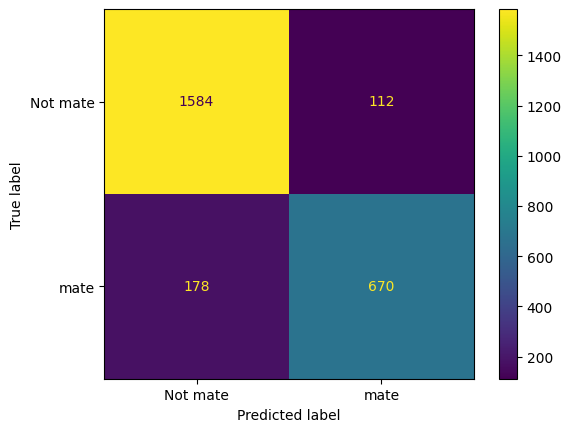

0    1696
1     848
dtype: int64
0    1762
1     782
dtype: int64
Accuracy for mate vs rest: 0.8860
Precision for mate vs rest: 0.8568
Recall for mate vs rest: 0.7901
None


In [ ]:
torch.cuda.empty_cache()
gc.collect()

outputs_columns = [col for col in output_test.columns if col.startswith('outputs_')]

# Define the trimming function
def trim_for_bool(value):
    return value.strip()

# Specify the columns to trim
columns_to_trim = [col for col in output_test.columns if col.startswith('outputs_')]

# Apply the trimming function to the specified columns
output_test[columns_to_trim] = output_test[columns_to_trim].applymap(trim_for_bool)

# Evaluate the most common output against the label
evaluation_result = get_eval(output_test['label'], output_test['outputs_1'], ['neither', 'check', 'mate'], 'mate')
print(evaluation_result)

**Run the 2nd model**

In [ ]:
# ask the 2nd model if the FEN of ea. board is check/checkmate/neither
import gc
import torch
torch.cuda.empty_cache()
gc.collect()
# convert FEN boards into Prompts needed for the second model (including mirroring the board when needed)
fens = prepareM2(fens)
print(fens)
fens.to_csv('test.csv', index = True)


                                               legals_0  \
0     Q: Is this san position 8/1p4Rp/2b1R3/2p5/2Pp1...   
1     Q: Is this san position r3k2r/pppnb1pp/4QN2/6B...   
2     Q: Is this san position 4b2k/2r2p1p/3p1B2/1PbB...   
3     Q: Is this san position 5Q1k/p3rp1p/1p4p1/8/3p...   
4     Q: Is this san position 4N3/6p1/7k/p1b5/7R/6R1...   
...                                                 ...   
3495  Q: Is this san position 4rk1R/R7/3p3p/p3r3/1p6...   
3496  Q: Is this san position 5kR1/7R/p1p1pN2/1pPpP3...   
3497  Q: Is this san position r1bqr2k/ppp4Q/2nb2p1/6...   
3498  Q: Is this san position 2k1R3/8/2K5/1PN5/8/8/8...   
3499  Q: Is this san position 2q1knr1/1ppbQ3/1p1p4/4...   

                                               legals_1  \
0     Q: Is this san position 8/1p4Rp/2b2R2/2p5/2Pp1...   
1     Q: Is this san position r3k2r/pppnb1pp/4QN2/6B...   
2     Q: Is this san position 4b2k/2r1Bp1p/3p4/1PbBp...   
3     Q: Is this san position 5Q1k/p3rp1p/1p4p1/8/3p...

**Choose the final result (mate, check, neither) by Majority vote for every output**

In [19]:
cols = [col for col in fens.columns if col.startswith('legals_')]
for column in cols:
  torch.cuda.empty_cache()
  gc.collect()
  size = len(fens['legals_1'])
  results = evaluate_dataset(fens[column], model2, tokenizer, batch_size=1, max_new_tokens=1, n_examples=size)
  torch.cuda.empty_cache()
  gc.collect()
  name = 'final_' + column
  df1[name] = finalOut(results)
print(df1)

df1.to_csv('output_model2_major.csv', index = True)

Output hidden; open in https://colab.research.google.com to view.

### **PART4: Multiple answers -> Heuristics -> Single final answer**

**Choose the best output by majority vote**

In [20]:
# apply majority vote to create a final output
output = finalAns(df1)
# print(df1)
output.to_csv('output_model2_finals.csv', index = True)

                                                  input  label outputs_0  \
0     1. d4 d5 2. Nf3 Nf6 3. e3 a6 4. Nc3 e6 5. Bd3 ...   Rg5#       g6+   
1     1. e4 e5 2. Nf3 d6 3. d4 exd4 4. Nxd4 Nf6 5. N...  Qxe7#      Nf6+   
2     1. c4 c5 2. Nf3 Nf6 3. g3 g6 4. Bg2 Bg7 5. O-O...   Bf6#      Bf6#   
3     1. g3 d6 2. Bg2 c5 3. d3 b6 4. Nf3 Nc6 5. O-O ...  Qxf1#     Qxf1#   
4     1. c4 e6 2. Nc3 Bb4 3. Ne4 d5 4. Ng3 dxc4 5. e...   Rh5#      Rh5#   
...                                                 ...    ...       ...   
3495  1. e4 d6 2. Nf3 e6 3. d4 Nc6 4. Be2 Nf6 5. e5 ...   Rh1#      Rh1#   
3496  1. e4 Nf6 2. e5 Nd5 3. d4 d6 4. f4 Nc6 5. Nf3 ...   Rg8#      Rg8#   
3497  1. e4 e5 2. Nf3 d6 3. Bc4 h6 4. Nc3 Nc6 5. d4 ...  Qxh2#      Qxh2   
3498  1. d4 d5 2. Bf4 Nf6 3. h3 h6 4. Nf3 Bf5 5. e3 ...   Re1#      Re1#   
3499  1. e4 e5 2. Bc4 Nc6 3. Nf3 Be7 4. d3 Nf6 5. h3...   Qe2#      Qe2#   

     outputs_1 outputs_2 outputs_3 outputs_4 outputs_5  \
0         Rf3#       g6#     

### **PART5: Accuracy Evaluation**

**Evaluate accuracy**

In [24]:
cols = [col for col in output.columns if col.startswith('outputs_')]
print('\n ChatGPT accuracy (based on output_0)')
exact_match_metric(output['outputs_0'], output['label'])
print('\n ChatGPT accuracy (based on final_output)')
exact_match_metric(output['final_output'], output['label'])
print('\n ChatGPT accuracy based on any of 5 outputs')
exact_match_metric_any(output[cols], output['label'])
print('\n Our accuracy following the 2nd model run')
exact_match_metric(output['finals'], output['label'])

output_filtered = filter(output)
print("\n Number of non-distinct lines ")
print(len(output_filtered['outputs_0']))
print('\n ChatGPT accuracy (based on output_0) for the lines which did not have disctinct answer')
exact_match_metric(output_filtered['outputs_0'], output_filtered['label'])
print('\n ChatGPT accuracy (based on final_output) for the lines which did not have disctinct answer')
exact_match_metric(output_filtered['final_output'], output_filtered['label'])
print('\n ChatGPT accuracy (based on any of 5 outputs) for the lines which did not have disctinct answer')
exact_match_metric_any(output_filtered[cols], output_filtered['label'])
print('\n Our accuracy for the lines which did not have disctinct answer')
exact_match_metric(output_filtered['finals'], output_filtered['label'])



 ChatGPT accuracy (based on output_0)
Exact Match Percentage: 62.77%

 ChatGPT accuracy (based on final_output)
Exact Match Percentage: 71.97%

 ChatGPT accuracy based on any of 5 outputs
Exact Match Percentage: 76.91%

 Our accuracy following the 2nd model run
Exact Match Percentage: 77.17%

 Number of non-distinct lines 
1492

 ChatGPT accuracy (based on output_0) for the lines which did not have disctinct answer
Exact Match Percentage: 36.33%

 ChatGPT accuracy (based on final_output) for the lines which did not have disctinct answer
Exact Match Percentage: 57.91%

 ChatGPT accuracy (based on any of 5 outputs) for the lines which did not have disctinct answer
Exact Match Percentage: 69.50%

 Our accuracy for the lines which did not have disctinct answer
Exact Match Percentage: 62.87%
